<a href="https://colab.research.google.com/github/LouisW2202/DLPrakt/blob/master/week_9/assignment_mnistGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Asignemnt: MNIST GAN
## Load the Data

We begin by downloading and importing the data as a PyTorch dataset using the `MNIST` helper class from `torchvision.datasets`.

In [2]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:05<00:00, 1774320.20it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100%|███████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 9831644.66it/s]

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 2469845.66it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



Note that we are are transforming the pixel values from the range `[0, 1]` to the range `[-1, 1]`. Makes generation easier...

In [3]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

As expected, the pixel values range from -1 to 1. Let's define a helper to denormalize and view the images. This function will also be useful for viewing the generated images.

In [4]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 5


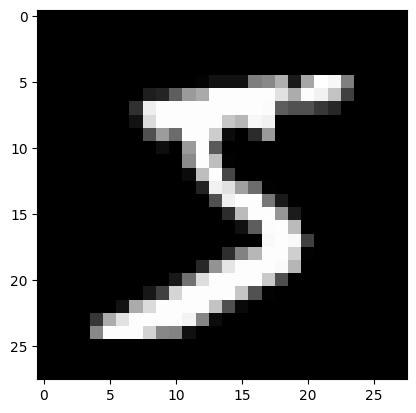

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

Finally, let's create a dataloader to load the images in batches.

In [6]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([4, 2, 9, 5, 4, 0, 6, 2, 2, 1, 5, 3, 8, 5, 9, 0, 5, 7, 8, 1, 2, 9, 6, 0,
        6, 4, 0, 0, 9, 5, 7, 7, 6, 0, 8, 8, 7, 8, 5, 4, 7, 9, 9, 7, 5, 1, 8, 2,
        4, 4, 7, 8, 3, 5, 6, 9, 8, 5, 9, 8, 5, 2, 8, 1, 7, 2, 3, 8, 3, 8, 6, 1,
        6, 3, 2, 1, 3, 6, 1, 0, 7, 4, 0, 4, 2, 4, 3, 1, 3, 3, 4, 0, 2, 0, 1, 2,
        5, 5, 9, 3])


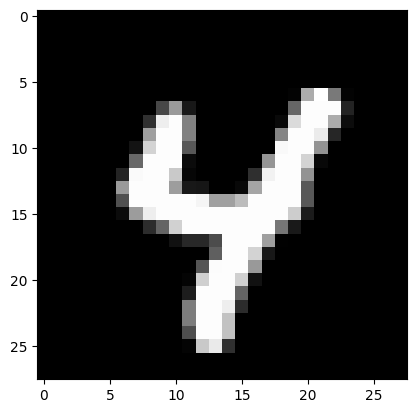

In [7]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [8]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
device

device(type='cuda')

In [11]:
%%timeit

for img, label in data_loader:
    continue

8.39 s ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 1. Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. While we can use a CNN for the discriminator, we'll use a simple feedforward network with 3 linear layers to keep things since. We'll treat each 28x28 image as a vector of size 784.

In [109]:
image_size = 784
hidden_size = 256

In [110]:
import torch.nn as nn

D = nn.Sequential(torch.nn.Linear(image_size, hidden_size),
                  torch.nn.LeakyReLU(),
                  torch.nn.Linear(hidden_size, hidden_size),
                  torch.nn.LeakyReLU(),
                  torch.nn.Linear(hidden_size, 1),
                  torch.nn.Sigmoid()
)

In [111]:
D = D.to(device);

In [112]:
D

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

## 2. Build Generator Network

The input to the generator is typically a vector or a matrix which is used as a seed for generating an image. Once again, to keep things simple, we'll use a feedfoward neural network with 3 layers, and the output will be a vector of size 784, which can be transformed to a 28x28 px image.

We use the TanH activation function for the output layer of the generator.

<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >

> "The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling." - [Source](https://stackoverflow.com/questions/41489907/generative-adversarial-networks-tanh)


Note that since the outputs of the TanH activation lie in the range `[-1,1]`, we have applied the same transformation to the images in the training dataset. Let's generate an output vector using the generator and view it as an image by transforming and denormalizing the output.

In [113]:
latent_size = 64
hidden_size = image_size // 3
hidden_size

261

In [114]:
G = nn.Sequential(
    torch.nn.Linear(latent_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [115]:
G = G.to(device)

## 3. Train the Model

* train the model
* save samples of generated images after each epoch -> use the ``denorm()`` function

In [119]:
criterion = torch.nn.BCELoss()
epochs = 40
optimizerD = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
real_label = 1
fake_label = 0
fixed_noise = torch.randn(batch_size, latent_size, device=device)

In [120]:
import torchvision.utils as vutils
from tqdm import tqdm

In [121]:

for epoch in range(epochs):
  print(f"Epoch{epoch}")
  for i, img_batch in enumerate(data_loader):
    
    #Real Images
    img_batch = img_batch[0]
    img_batch = torch.flatten(img_batch, 1)
    img_batch = img_batch.to(device)
    D.zero_grad()
    labels = torch.full((batch_size,), real_label, dtype=torch.float)
    labels = labels.to(device).reshape(batch_size, 1)
    output_real = D(img_batch)
    err_real = criterion(output_real, labels)
    print(err_real.item())
    err_real.backward()
    avg_confidence_true = output_real.mean().item()
    #Fake Image
    labels.fill_(fake_label)
    noises = torch.randn(batch_size, latent_size, device = device)
    fake_img_batch = G(noises)
    output_fake = D(fake_img_batch.detach())
    err_fake = criterion(output_fake, labels)
    err_fake.backward()
    errD = err_real + err_fake
    optimizerD.step()
    avg_confidence_fake = 1 - output_fake.mean().item()
    # Training G
    G.zero_grad()
    labels.fill_(real_label)  # fake labels are real for generator cost
    output = D(fake_img_batch)
    errG = criterion(output, labels)
    errG.backward()
    avg_confidence_fake_afterstep = 1 - output.mean().item()
    optimizerG.step()
    print(f"Epoch {epoch}, Iter{i}: Loss D: {errD}, LossG: {errD}, confReal: {avg_confidence_true}, confFake1: {avg_confidence_fake}, confFake2: {avg_confidence_fake_afterstep}")
  if i == len(data_loader) - 1:
    print('saving the output')
    fake = G(fixed_noise)
    fake = fake.to("cpu")
    vutils.save_image(fake.detach(),'fake_samples_epoch_%03d.png' % (epoch),normalize=True)

Epoch0
0.5282944440841675
Epoch 0, Iter0: Loss D: 1.037513256072998, LossG: 1.037513256072998, confReal: 0.638637900352478, confFake1: 0.6458644270896912, confFake2: 0.6508842408657074
0.49702051281929016
Epoch 0, Iter1: Loss D: 0.9679678678512573, LossG: 0.9679678678512573, confReal: 0.6650742888450623, confFake1: 0.6608975231647491, confFake2: 0.6623573005199432
0.5383976101875305
Epoch 0, Iter2: Loss D: 1.0632874965667725, LossG: 1.0632874965667725, confReal: 0.6346334218978882, confFake1: 0.6330680251121521, confFake2: 0.6366466283798218
0.479062020778656
Epoch 0, Iter3: Loss D: 0.9816580414772034, LossG: 0.9816580414772034, confReal: 0.6619165539741516, confFake1: 0.652898520231247, confFake2: 0.6557346880435944
0.49590930342674255
Epoch 0, Iter4: Loss D: 0.9371260404586792, LossG: 0.9371260404586792, confReal: 0.6629525423049927, confFake1: 0.6774080693721771, confFake2: 0.6780818998813629
0.49736079573631287
Epoch 0, Iter5: Loss D: 1.0251004695892334, LossG: 1.0251004695892334, 

0.503532886505127
Epoch 0, Iter46: Loss D: 0.9686599969863892, LossG: 0.9686599969863892, confReal: 0.6644431948661804, confFake1: 0.670318603515625, confFake2: 0.6759277284145355
0.5843480825424194
Epoch 0, Iter47: Loss D: 0.9659163951873779, LossG: 0.9659163951873779, confReal: 0.6220583319664001, confFake1: 0.698113352060318, confFake2: 0.694664716720581
0.49342143535614014
Epoch 0, Iter48: Loss D: 0.9616271257400513, LossG: 0.9616271257400513, confReal: 0.6684101223945618, confFake1: 0.67306187748909, confFake2: 0.6740096211433411
0.46959730982780457
Epoch 0, Iter49: Loss D: 0.8685303926467896, LossG: 0.8685303926467896, confReal: 0.6990736126899719, confFake1: 0.700594574213028, confFake2: 0.7012519538402557
0.4649457335472107
Epoch 0, Iter50: Loss D: 0.9862959980964661, LossG: 0.9862959980964661, confReal: 0.6777926683425903, confFake1: 0.6474599540233612, confFake2: 0.6532530188560486
0.4133506417274475
Epoch 0, Iter51: Loss D: 0.893146276473999, LossG: 0.893146276473999, confRe

0.4603066146373749
Epoch 0, Iter99: Loss D: 0.9742722511291504, LossG: 0.9742722511291504, confReal: 0.6910995841026306, confFake1: 0.6430156826972961, confFake2: 0.6605255305767059
0.4606426954269409
Epoch 0, Iter100: Loss D: 0.8960767984390259, LossG: 0.8960767984390259, confReal: 0.6866823434829712, confFake1: 0.6727789342403412, confFake2: 0.681042343378067
0.5118956565856934
Epoch 0, Iter101: Loss D: 0.9289937019348145, LossG: 0.9289937019348145, confReal: 0.6475091576576233, confFake1: 0.7005247473716736, confFake2: 0.699109822511673
0.5419288873672485
Epoch 0, Iter102: Loss D: 0.9437813758850098, LossG: 0.9437813758850098, confReal: 0.6534097194671631, confFake1: 0.6968260109424591, confFake2: 0.6899515390396118
0.41942569613456726
Epoch 0, Iter103: Loss D: 0.827814519405365, LossG: 0.827814519405365, confReal: 0.7083678841590881, confFake1: 0.6918940842151642, confFake2: 0.6922702491283417
0.4474370777606964
Epoch 0, Iter104: Loss D: 0.9535284042358398, LossG: 0.953528404235839

0.5244053602218628
Epoch 0, Iter152: Loss D: 0.9547535181045532, LossG: 0.9547535181045532, confReal: 0.6635631918907166, confFake1: 0.6840161383152008, confFake2: 0.6865715086460114
0.4528351426124573
Epoch 0, Iter153: Loss D: 0.8855724930763245, LossG: 0.8855724930763245, confReal: 0.6958277225494385, confFake1: 0.6770797669887543, confFake2: 0.677581787109375
0.4330698549747467
Epoch 0, Iter154: Loss D: 0.794781506061554, LossG: 0.794781506061554, confReal: 0.7017803192138672, confFake1: 0.7150133848190308, confFake2: 0.7115509212017059
0.4538699984550476
Epoch 0, Iter155: Loss D: 0.8922297358512878, LossG: 0.8922297358512878, confReal: 0.6894249320030212, confFake1: 0.6763798594474792, confFake2: 0.6815555393695831
0.396371990442276
Epoch 0, Iter156: Loss D: 0.8349388241767883, LossG: 0.8349388241767883, confReal: 0.723888099193573, confFake1: 0.6720175743103027, confFake2: 0.6840473115444183
0.4679555296897888
Epoch 0, Iter157: Loss D: 0.9812897443771362, LossG: 0.9812897443771362

0.4867111146450043
Epoch 0, Iter205: Loss D: 0.9830077290534973, LossG: 0.9830077290534973, confReal: 0.6737720370292664, confFake1: 0.6626245975494385, confFake2: 0.6718089282512665
0.35244062542915344
Epoch 0, Iter206: Loss D: 0.8035532236099243, LossG: 0.8035532236099243, confReal: 0.7496600151062012, confFake1: 0.6724016666412354, confFake2: 0.6899511814117432
0.45793136954307556
Epoch 0, Iter207: Loss D: 0.8746076226234436, LossG: 0.8746076226234436, confReal: 0.6851180195808411, confFake1: 0.6928203403949738, confFake2: 0.7055946886539459
0.44074225425720215
Epoch 0, Iter208: Loss D: 0.8572825193405151, LossG: 0.8572825193405151, confReal: 0.6989173889160156, confFake1: 0.7054054737091064, confFake2: 0.7182367444038391
0.39177393913269043
Epoch 0, Iter209: Loss D: 0.8334137201309204, LossG: 0.8334137201309204, confReal: 0.7148873805999756, confFake1: 0.6764345765113831, confFake2: 0.6983103156089783
0.4316765069961548
Epoch 0, Iter210: Loss D: 0.8399439454078674, LossG: 0.8399439

0.4229450821876526
Epoch 0, Iter257: Loss D: 0.8187316656112671, LossG: 0.8187316656112671, confReal: 0.7089978456497192, confFake1: 0.7012046277523041, confFake2: 0.7063076198101044
0.4265339970588684
Epoch 0, Iter258: Loss D: 0.8833185434341431, LossG: 0.8833185434341431, confReal: 0.7160083055496216, confFake1: 0.6770558655261993, confFake2: 0.6906286180019379
0.4296478033065796
Epoch 0, Iter259: Loss D: 0.8564328551292419, LossG: 0.8564328551292419, confReal: 0.7133792638778687, confFake1: 0.6830402910709381, confFake2: 0.690284788608551
0.513230562210083
Epoch 0, Iter260: Loss D: 0.9111181497573853, LossG: 0.9111181497573853, confReal: 0.671576738357544, confFake1: 0.7230329811573029, confFake2: 0.7164647281169891
0.4096549153327942
Epoch 0, Iter261: Loss D: 0.8491454124450684, LossG: 0.8491454124450684, confReal: 0.7209083437919617, confFake1: 0.6772213876247406, confFake2: 0.678508996963501
0.5033847093582153
Epoch 0, Iter262: Loss D: 0.9578999280929565, LossG: 0.957899928092956

Epoch 0, Iter306: Loss D: 0.8691898584365845, LossG: 0.8691898584365845, confReal: 0.7303488850593567, confFake1: 0.661199301481247, confFake2: 0.685969889163971
0.3829443156719208
Epoch 0, Iter307: Loss D: 0.8648929595947266, LossG: 0.8648929595947266, confReal: 0.722267746925354, confFake1: 0.6667906939983368, confFake2: 0.6971898674964905
0.5275040864944458
Epoch 0, Iter308: Loss D: 0.9218989610671997, LossG: 0.9218989610671997, confReal: 0.6545177102088928, confFake1: 0.7094534635543823, confFake2: 0.7132748067378998
0.490856796503067
Epoch 0, Iter309: Loss D: 0.9159555435180664, LossG: 0.9159555435180664, confReal: 0.6821224689483643, confFake1: 0.7042384743690491, confFake2: 0.7032629549503326
0.5000407695770264
Epoch 0, Iter310: Loss D: 0.9655277729034424, LossG: 0.9655277729034424, confReal: 0.6722816228866577, confFake1: 0.6664046943187714, confFake2: 0.6682376265525818
0.4217354357242584
Epoch 0, Iter311: Loss D: 0.8357623815536499, LossG: 0.8357623815536499, confReal: 0.7148

0.5520129799842834
Epoch 0, Iter354: Loss D: 0.9118669033050537, LossG: 0.9118669033050537, confReal: 0.6494656205177307, confFake1: 0.731904923915863, confFake2: 0.7269144952297211
0.4758955240249634
Epoch 0, Iter355: Loss D: 0.8294570446014404, LossG: 0.8294570446014404, confReal: 0.6882936954498291, confFake1: 0.7259584665298462, confFake2: 0.718633621931076
0.5404207706451416
Epoch 0, Iter356: Loss D: 1.0080468654632568, LossG: 1.0080468654632568, confReal: 0.645250678062439, confFake1: 0.6895529627799988, confFake2: 0.6786900162696838
0.40885278582572937
Epoch 0, Iter357: Loss D: 0.8528214693069458, LossG: 0.8528214693069458, confReal: 0.7253936529159546, confFake1: 0.6735319495201111, confFake2: 0.6791028678417206
0.4010985791683197
Epoch 0, Iter358: Loss D: 0.8330529928207397, LossG: 0.8330529928207397, confReal: 0.7205402851104736, confFake1: 0.6840331852436066, confFake2: 0.697053074836731
0.46444737911224365
Epoch 0, Iter359: Loss D: 0.9014419913291931, LossG: 0.9014419913291

0.4816766381263733
Epoch 0, Iter402: Loss D: 0.9092541933059692, LossG: 0.9092541933059692, confReal: 0.666329026222229, confFake1: 0.6877047419548035, confFake2: 0.6893060803413391
0.3624037802219391
Epoch 0, Iter403: Loss D: 0.7466555237770081, LossG: 0.7466555237770081, confReal: 0.7355687618255615, confFake1: 0.7037762999534607, confFake2: 0.7097013592720032
0.481401652097702
Epoch 0, Iter404: Loss D: 0.8750925660133362, LossG: 0.8750925660133362, confReal: 0.6703464984893799, confFake1: 0.7177096903324127, confFake2: 0.7152068912982941
0.4480457305908203
Epoch 0, Iter405: Loss D: 0.8604593276977539, LossG: 0.8604593276977539, confReal: 0.6961219906806946, confFake1: 0.694667637348175, confFake2: 0.698724627494812
0.4556415379047394
Epoch 0, Iter406: Loss D: 0.8524178862571716, LossG: 0.8524178862571716, confReal: 0.6924945116043091, confFake1: 0.6989560425281525, confFake2: 0.6978857219219208
0.410034716129303
Epoch 0, Iter407: Loss D: 0.8098974227905273, LossG: 0.8098974227905273

0.4391070604324341
Epoch 0, Iter450: Loss D: 0.855418860912323, LossG: 0.855418860912323, confReal: 0.6982807517051697, confFake1: 0.6940353512763977, confFake2: 0.6985383927822113
0.35248205065727234
Epoch 0, Iter451: Loss D: 0.8227304816246033, LossG: 0.8227304816246033, confReal: 0.7441624402999878, confFake1: 0.6564525663852692, confFake2: 0.6695743501186371
0.3718002140522003
Epoch 0, Iter452: Loss D: 0.7858258485794067, LossG: 0.7858258485794067, confReal: 0.7340369820594788, confFake1: 0.6883788704872131, confFake2: 0.7038000822067261
0.39427319169044495
Epoch 0, Iter453: Loss D: 0.7567393183708191, LossG: 0.7567393183708191, confReal: 0.7317800521850586, confFake1: 0.7169774770736694, confFake2: 0.7301495671272278
0.3938188850879669
Epoch 0, Iter454: Loss D: 0.7670024037361145, LossG: 0.7670024037361145, confReal: 0.7266974449157715, confFake1: 0.7194860577583313, confFake2: 0.7259810864925385
0.4266268014907837
Epoch 0, Iter455: Loss D: 0.8393895626068115, LossG: 0.83938956260

0.5772016644477844
Epoch 0, Iter496: Loss D: 1.013838768005371, LossG: 1.013838768005371, confReal: 0.6445931196212769, confFake1: 0.6893122494220734, confFake2: 0.6770720779895782
0.4008222222328186
Epoch 0, Iter497: Loss D: 0.8212755918502808, LossG: 0.8212755918502808, confReal: 0.7211102843284607, confFake1: 0.6839657425880432, confFake2: 0.6830302476882935
0.3920549750328064
Epoch 0, Iter498: Loss D: 0.9100487232208252, LossG: 0.9100487232208252, confReal: 0.7348052859306335, confFake1: 0.6512686908245087, confFake2: 0.6741859614849091
0.4252455532550812
Epoch 0, Iter499: Loss D: 0.9406713247299194, LossG: 0.9406713247299194, confReal: 0.7121530175209045, confFake1: 0.65456622838974, confFake2: 0.6772981584072113
0.4571465849876404
Epoch 0, Iter500: Loss D: 0.8750331997871399, LossG: 0.8750331997871399, confReal: 0.6876606345176697, confFake1: 0.7011515200138092, confFake2: 0.7177154719829559
0.4720829725265503
Epoch 0, Iter501: Loss D: 0.9236968755722046, LossG: 0.923696875572204

0.37335410714149475
Epoch 0, Iter549: Loss D: 0.8229820728302002, LossG: 0.8229820728302002, confReal: 0.7347071766853333, confFake1: 0.6677712798118591, confFake2: 0.6920242011547089
0.4272516071796417
Epoch 0, Iter550: Loss D: 0.9132083654403687, LossG: 0.9132083654403687, confReal: 0.7099155783653259, confFake1: 0.6643732190132141, confFake2: 0.6828171908855438
0.5079507827758789
Epoch 0, Iter551: Loss D: 0.9681863784790039, LossG: 0.9681863784790039, confReal: 0.6768373847007751, confFake1: 0.6617157161235809, confFake2: 0.6762188374996185
0.39329949021339417
Epoch 0, Iter552: Loss D: 0.8284473419189453, LossG: 0.8284473419189453, confReal: 0.7256225347518921, confFake1: 0.6933207213878632, confFake2: 0.7015611827373505
0.46666258573532104
Epoch 0, Iter553: Loss D: 0.8430922627449036, LossG: 0.8430922627449036, confReal: 0.6835321187973022, confFake1: 0.714972198009491, confFake2: 0.7141755223274231
0.5071721076965332
Epoch 0, Iter554: Loss D: 0.9825093150138855, LossG: 0.982509315

0.456856369972229
Epoch 0, Iter597: Loss D: 0.8959035277366638, LossG: 0.8959035277366638, confReal: 0.6902844309806824, confFake1: 0.6823983192443848, confFake2: 0.6879742741584778
0.4004848003387451
Epoch 0, Iter598: Loss D: 0.8446451425552368, LossG: 0.8446451425552368, confReal: 0.7258407473564148, confFake1: 0.6845258474349976, confFake2: 0.6976227164268494
0.4778767228126526
Epoch 0, Iter599: Loss D: 0.8334765434265137, LossG: 0.8334765434265137, confReal: 0.6879959106445312, confFake1: 0.7312239408493042, confFake2: 0.729335218667984
saving the output
Epoch1
0.40363872051239014
Epoch 1, Iter0: Loss D: 0.7663546204566956, LossG: 0.7663546204566956, confReal: 0.72549968957901, confFake1: 0.7201544344425201, confFake2: 0.723509818315506
0.4728650450706482
Epoch 1, Iter1: Loss D: 0.8740334510803223, LossG: 0.8740334510803223, confReal: 0.6838874816894531, confFake1: 0.700636625289917, confFake2: 0.703801304101944
0.4336218237876892
Epoch 1, Iter2: Loss D: 0.8425416350364685, LossG: 

0.3895909786224365
Epoch 1, Iter44: Loss D: 0.8332082033157349, LossG: 0.8332082033157349, confReal: 0.7309712171554565, confFake1: 0.6875284314155579, confFake2: 0.7020533382892609
0.4224008321762085
Epoch 1, Iter45: Loss D: 0.8414373397827148, LossG: 0.8414373397827148, confReal: 0.7115005850791931, confFake1: 0.6950308978557587, confFake2: 0.7121220827102661
0.5037599205970764
Epoch 1, Iter46: Loss D: 0.9050379991531372, LossG: 0.9050379991531372, confReal: 0.6584060788154602, confFake1: 0.7075360417366028, confFake2: 0.7061247229576111
0.4131404757499695
Epoch 1, Iter47: Loss D: 0.8051618337631226, LossG: 0.8051618337631226, confReal: 0.717609703540802, confFake1: 0.7073569297790527, confFake2: 0.7072521150112152
0.40432584285736084
Epoch 1, Iter48: Loss D: 0.7436851263046265, LossG: 0.7436851263046265, confReal: 0.7209484577178955, confFake1: 0.734539121389389, confFake2: 0.7327644526958466
0.42093130946159363
Epoch 1, Iter49: Loss D: 0.8718013763427734, LossG: 0.8718013763427734,

0.4244345426559448
Epoch 1, Iter95: Loss D: 0.890150249004364, LossG: 0.890150249004364, confReal: 0.7235236167907715, confFake1: 0.665293425321579, confFake2: 0.6906725466251373
0.4398512542247772
Epoch 1, Iter96: Loss D: 0.8191920518875122, LossG: 0.8191920518875122, confReal: 0.7001773118972778, confFake1: 0.725969672203064, confFake2: 0.7335979640483856
0.4372175633907318
Epoch 1, Iter97: Loss D: 0.8180721998214722, LossG: 0.8180721998214722, confReal: 0.703292965888977, confFake1: 0.7230012118816376, confFake2: 0.7216215133666992
0.49224215745925903
Epoch 1, Iter98: Loss D: 0.871495246887207, LossG: 0.871495246887207, confReal: 0.6875460147857666, confFake1: 0.7134124338626862, confFake2: 0.7062965333461761
0.4156314432621002
Epoch 1, Iter99: Loss D: 0.9090898633003235, LossG: 0.9090898633003235, confReal: 0.73497474193573, confFake1: 0.6730684638023376, confFake2: 0.6854256391525269
0.39137035608291626
Epoch 1, Iter100: Loss D: 0.814727246761322, LossG: 0.814727246761322, confRea

0.3568804860115051
Epoch 1, Iter147: Loss D: 0.7821230292320251, LossG: 0.7821230292320251, confReal: 0.74637770652771, confFake1: 0.6964156329631805, confFake2: 0.7155458331108093
0.3819720447063446
Epoch 1, Iter148: Loss D: 0.8660537004470825, LossG: 0.8660537004470825, confReal: 0.7368469834327698, confFake1: 0.6673111021518707, confFake2: 0.692051500082016
0.5429024696350098
Epoch 1, Iter149: Loss D: 1.020552158355713, LossG: 1.020552158355713, confReal: 0.6460177302360535, confFake1: 0.6557187736034393, confFake2: 0.6732910573482513
0.493931382894516
Epoch 1, Iter150: Loss D: 0.855236828327179, LossG: 0.855236828327179, confReal: 0.6768800020217896, confFake1: 0.7384531199932098, confFake2: 0.7352997660636902
0.4668315649032593
Epoch 1, Iter151: Loss D: 0.9587019681930542, LossG: 0.9587019681930542, confReal: 0.6842507719993591, confFake1: 0.667154997587204, confFake2: 0.6776189506053925
0.4788258373737335
Epoch 1, Iter152: Loss D: 0.844167172908783, LossG: 0.844167172908783, conf

0.3798380196094513
Epoch 1, Iter199: Loss D: 0.7748357057571411, LossG: 0.7748357057571411, confReal: 0.7368050813674927, confFake1: 0.7019866704940796, confFake2: 0.7195576131343842
0.47519901394844055
Epoch 1, Iter200: Loss D: 0.8649806380271912, LossG: 0.8649806380271912, confReal: 0.6849676966667175, confFake1: 0.7109122276306152, confFake2: 0.7168187201023102
0.5143967866897583
Epoch 1, Iter201: Loss D: 0.9303158521652222, LossG: 0.9303158521652222, confReal: 0.6726545095443726, confFake1: 0.6911368370056152, confFake2: 0.6837181746959686
0.4453904330730438
Epoch 1, Iter202: Loss D: 0.8639135360717773, LossG: 0.8639135360717773, confReal: 0.7116842269897461, confFake1: 0.7020776569843292, confFake2: 0.7035709321498871
0.3601980209350586
Epoch 1, Iter203: Loss D: 0.8220809102058411, LossG: 0.8220809102058411, confReal: 0.7374314665794373, confFake1: 0.6679071485996246, confFake2: 0.6824558973312378
0.40416982769966125
Epoch 1, Iter204: Loss D: 0.7333930730819702, LossG: 0.733393073

0.43815261125564575
Epoch 1, Iter251: Loss D: 0.8632863163948059, LossG: 0.8632863163948059, confReal: 0.7081765532493591, confFake1: 0.6869560182094574, confFake2: 0.7061966359615326
0.47960135340690613
Epoch 1, Iter252: Loss D: 0.8304194808006287, LossG: 0.8304194808006287, confReal: 0.6805790662765503, confFake1: 0.7347842156887054, confFake2: 0.722938746213913
0.4584212005138397
Epoch 1, Iter253: Loss D: 0.8934528231620789, LossG: 0.8934528231620789, confReal: 0.6991220116615295, confFake1: 0.6834083795547485, confFake2: 0.6827286183834076
0.34110313653945923
Epoch 1, Iter254: Loss D: 0.8538984656333923, LossG: 0.8538984656333923, confReal: 0.7536491751670837, confFake1: 0.6465891003608704, confFake2: 0.6694513857364655
0.39544540643692017
Epoch 1, Iter255: Loss D: 0.8028727769851685, LossG: 0.8028727769851685, confReal: 0.7367447018623352, confFake1: 0.7034038305282593, confFake2: 0.7216706871986389
0.45397672057151794
Epoch 1, Iter256: Loss D: 0.8096935749053955, LossG: 0.8096935

0.5115835666656494
Epoch 1, Iter303: Loss D: 0.9512961506843567, LossG: 0.9512961506843567, confReal: 0.6656638979911804, confFake1: 0.693107545375824, confFake2: 0.6977976858615875
0.4234873950481415
Epoch 1, Iter304: Loss D: 0.850735604763031, LossG: 0.850735604763031, confReal: 0.7079190015792847, confFake1: 0.6912825107574463, confFake2: 0.6934478580951691
0.5138335824012756
Epoch 1, Iter305: Loss D: 0.9148513078689575, LossG: 0.9148513078689575, confReal: 0.6776574850082397, confFake1: 0.7133839428424835, confFake2: 0.7097241282463074
0.39534908533096313
Epoch 1, Iter306: Loss D: 0.9596764445304871, LossG: 0.9596764445304871, confReal: 0.7256506085395813, confFake1: 0.6425362527370453, confFake2: 0.666305422782898
0.4305480420589447
Epoch 1, Iter307: Loss D: 1.0043904781341553, LossG: 1.0043904781341553, confReal: 0.7061488032341003, confFake1: 0.636166512966156, confFake2: 0.662999838590622
0.46279433369636536
Epoch 1, Iter308: Loss D: 0.9175242185592651, LossG: 0.917524218559265

0.4509558081626892
Epoch 1, Iter355: Loss D: 0.8621076345443726, LossG: 0.8621076345443726, confReal: 0.6901755928993225, confFake1: 0.7105666399002075, confFake2: 0.7088839411735535
0.48204368352890015
Epoch 1, Iter356: Loss D: 0.9461281299591064, LossG: 0.9461281299591064, confReal: 0.6800580620765686, confFake1: 0.6721508204936981, confFake2: 0.6795638799667358
0.39360693097114563
Epoch 1, Iter357: Loss D: 0.7636290192604065, LossG: 0.7636290192604065, confReal: 0.7302426695823669, confFake1: 0.7221993803977966, confFake2: 0.7259545624256134
0.43722426891326904
Epoch 1, Iter358: Loss D: 0.8633819818496704, LossG: 0.8633819818496704, confReal: 0.7016820907592773, confFake1: 0.6895397305488586, confFake2: 0.6900424361228943
0.37060144543647766
Epoch 1, Iter359: Loss D: 0.785287618637085, LossG: 0.785287618637085, confReal: 0.7414126396179199, confFake1: 0.6883763074874878, confFake2: 0.6999146342277527
0.38321590423583984
Epoch 1, Iter360: Loss D: 0.8405809998512268, LossG: 0.84058099

0.3553547263145447
Epoch 1, Iter408: Loss D: 0.8145009279251099, LossG: 0.8145009279251099, confReal: 0.7528671026229858, confFake1: 0.6905007362365723, confFake2: 0.7056587338447571
0.5074712038040161
Epoch 1, Iter409: Loss D: 0.9476242065429688, LossG: 0.9476242065429688, confReal: 0.6802439093589783, confFake1: 0.6936509907245636, confFake2: 0.7030892074108124
0.4347473084926605
Epoch 1, Iter410: Loss D: 0.8255727887153625, LossG: 0.8255727887153625, confReal: 0.7117016315460205, confFake1: 0.7136079370975494, confFake2: 0.7214726805686951
0.47630369663238525
Epoch 1, Iter411: Loss D: 0.8842223882675171, LossG: 0.8842223882675171, confReal: 0.6993401646614075, confFake1: 0.6949785053730011, confFake2: 0.708755224943161
0.45152875781059265
Epoch 1, Iter412: Loss D: 0.8795299530029297, LossG: 0.8795299530029297, confReal: 0.6883683800697327, confFake1: 0.6895402073860168, confFake2: 0.7108856737613678
0.5573455095291138
Epoch 1, Iter413: Loss D: 0.974423885345459, LossG: 0.97442388534

0.39817726612091064
Epoch 1, Iter459: Loss D: 0.8372869491577148, LossG: 0.8372869491577148, confReal: 0.7299293279647827, confFake1: 0.6807875037193298, confFake2: 0.7043395042419434
0.5022451877593994
Epoch 1, Iter460: Loss D: 0.8568670749664307, LossG: 0.8568670749664307, confReal: 0.6837207674980164, confFake1: 0.7379044592380524, confFake2: 0.7402520179748535
0.6253589391708374
Epoch 1, Iter461: Loss D: 0.9569294452667236, LossG: 0.9569294452667236, confReal: 0.6349523663520813, confFake1: 0.741907000541687, confFake2: 0.7208775281906128
0.4417889416217804
Epoch 1, Iter462: Loss D: 0.850848913192749, LossG: 0.850848913192749, confReal: 0.707955002784729, confFake1: 0.7013493478298187, confFake2: 0.6899873912334442
0.3456883132457733
Epoch 1, Iter463: Loss D: 0.8772745132446289, LossG: 0.8772745132446289, confReal: 0.7529472708702087, confFake1: 0.6410127282142639, confFake2: 0.666456788778305
0.395099401473999
Epoch 1, Iter464: Loss D: 0.9016223549842834, LossG: 0.9016223549842834

0.41516250371932983
Epoch 1, Iter513: Loss D: 0.8444013595581055, LossG: 0.8444013595581055, confReal: 0.7203806638717651, confFake1: 0.6999563872814178, confFake2: 0.7193334698677063
0.4559361934661865
Epoch 1, Iter514: Loss D: 0.866618812084198, LossG: 0.866618812084198, confReal: 0.7062133550643921, confFake1: 0.7032096982002258, confFake2: 0.7159556448459625
0.3941240608692169
Epoch 1, Iter515: Loss D: 0.7713606357574463, LossG: 0.7713606357574463, confReal: 0.7326664328575134, confFake1: 0.7145360708236694, confFake2: 0.7295357286930084
0.4730595052242279
Epoch 1, Iter516: Loss D: 0.8494291305541992, LossG: 0.8494291305541992, confReal: 0.6816516518592834, confFake1: 0.7222991287708282, confFake2: 0.7203999757766724
0.366148442029953
Epoch 1, Iter517: Loss D: 0.7690380811691284, LossG: 0.7690380811691284, confReal: 0.7408251762390137, confFake1: 0.696807473897934, confFake2: 0.7081457674503326
0.4285441040992737
Epoch 1, Iter518: Loss D: 0.8643107414245605, LossG: 0.86431074142456

0.45510610938072205
Epoch 1, Iter564: Loss D: 0.8702065944671631, LossG: 0.8702065944671631, confReal: 0.7021470665931702, confFake1: 0.7051787078380585, confFake2: 0.7160589396953583
0.3548971712589264
Epoch 1, Iter565: Loss D: 0.7873772382736206, LossG: 0.7873772382736206, confReal: 0.7458103895187378, confFake1: 0.6871806383132935, confFake2: 0.7107643187046051
0.4196886420249939
Epoch 1, Iter566: Loss D: 0.7329747676849365, LossG: 0.7329747676849365, confReal: 0.7112305760383606, confFake1: 0.7540063858032227, confFake2: 0.7591906785964966
0.4745495617389679
Epoch 1, Iter567: Loss D: 0.9008688926696777, LossG: 0.9008688926696777, confReal: 0.712124764919281, confFake1: 0.7078895568847656, confFake2: 0.718553751707077
0.4609901010990143
Epoch 1, Iter568: Loss D: 0.8007860779762268, LossG: 0.8007860779762268, confReal: 0.6884831190109253, confFake1: 0.734197586774826, confFake2: 0.7283457219600677
0.401212215423584
Epoch 1, Iter569: Loss D: 0.814009428024292, LossG: 0.814009428024292

0.5196197628974915
Epoch 2, Iter12: Loss D: 0.9374394416809082, LossG: 0.9374394416809082, confReal: 0.6671673655509949, confFake1: 0.6915920972824097, confFake2: 0.6861932873725891
0.43360185623168945
Epoch 2, Iter13: Loss D: 0.8464386463165283, LossG: 0.8464386463165283, confReal: 0.7134383320808411, confFake1: 0.7033931910991669, confFake2: 0.7050300538539886
0.48652446269989014
Epoch 2, Iter14: Loss D: 0.9221754670143127, LossG: 0.9221754670143127, confReal: 0.6860719919204712, confFake1: 0.6877888143062592, confFake2: 0.6803674399852753
0.306134432554245
Epoch 2, Iter15: Loss D: 0.7881820201873779, LossG: 0.7881820201873779, confReal: 0.7776625156402588, confFake1: 0.6612896025180817, confFake2: 0.6963897943496704
0.38031089305877686
Epoch 2, Iter16: Loss D: 0.848259449005127, LossG: 0.848259449005127, confReal: 0.7370562553405762, confFake1: 0.6735019087791443, confFake2: 0.7225166857242584
0.554877758026123
Epoch 2, Iter17: Loss D: 0.9526100754737854, LossG: 0.9526100754737854, 

0.4486522674560547
Epoch 2, Iter61: Loss D: 0.8638619780540466, LossG: 0.8638619780540466, confReal: 0.7131130695343018, confFake1: 0.705286830663681, confFake2: 0.718477189540863
0.48221373558044434
Epoch 2, Iter62: Loss D: 0.826740562915802, LossG: 0.826740562915802, confReal: 0.6741907596588135, confFake1: 0.7378843724727631, confFake2: 0.7235496342182159
0.4878455102443695
Epoch 2, Iter63: Loss D: 0.8506228923797607, LossG: 0.8506228923797607, confReal: 0.6922925710678101, confFake1: 0.7246786952018738, confFake2: 0.7181780636310577
0.46092450618743896
Epoch 2, Iter64: Loss D: 0.7852281332015991, LossG: 0.7852281332015991, confReal: 0.6949660181999207, confFake1: 0.7492955029010773, confFake2: 0.7251479625701904
0.3873347342014313
Epoch 2, Iter65: Loss D: 0.8347138166427612, LossG: 0.8347138166427612, confReal: 0.7359734177589417, confFake1: 0.695610761642456, confFake2: 0.7063696682453156
0.31260278820991516
Epoch 2, Iter66: Loss D: 0.8656450510025024, LossG: 0.8656450510025024, c

0.3971390128135681
Epoch 2, Iter109: Loss D: 0.9800209403038025, LossG: 0.9800209403038025, confReal: 0.7307897210121155, confFake1: 0.6331640779972076, confFake2: 0.6685161292552948
0.40577593445777893
Epoch 2, Iter110: Loss D: 0.8115813732147217, LossG: 0.8115813732147217, confReal: 0.7176966071128845, confFake1: 0.7024543583393097, confFake2: 0.7324820756912231
0.4223492443561554
Epoch 2, Iter111: Loss D: 0.7821677923202515, LossG: 0.7821677923202515, confReal: 0.7122843861579895, confFake1: 0.7287350594997406, confFake2: 0.7350609600543976
0.4740297496318817
Epoch 2, Iter112: Loss D: 0.9144197702407837, LossG: 0.9144197702407837, confReal: 0.6865025162696838, confFake1: 0.6837194561958313, confFake2: 0.687763512134552
0.32441404461860657
Epoch 2, Iter113: Loss D: 0.8200940489768982, LossG: 0.8200940489768982, confReal: 0.7677598595619202, confFake1: 0.6583235263824463, confFake2: 0.707948625087738
0.45660948753356934
Epoch 2, Iter114: Loss D: 0.8098651170730591, LossG: 0.8098651170

0.3146626651287079
Epoch 2, Iter156: Loss D: 0.7783695459365845, LossG: 0.7783695459365845, confReal: 0.7773599624633789, confFake1: 0.680032342672348, confFake2: 0.7060560286045074
0.4507436156272888
Epoch 2, Iter157: Loss D: 0.8710795640945435, LossG: 0.8710795640945435, confReal: 0.6949127316474915, confFake1: 0.6893192827701569, confFake2: 0.7054677903652191
0.4222680628299713
Epoch 2, Iter158: Loss D: 0.8328718543052673, LossG: 0.8328718543052673, confReal: 0.7067184448242188, confFake1: 0.715074896812439, confFake2: 0.7229086458683014
0.37850645184516907
Epoch 2, Iter159: Loss D: 0.8954036235809326, LossG: 0.8954036235809326, confReal: 0.7301876544952393, confFake1: 0.6481669843196869, confFake2: 0.6736998856067657
0.4328112006187439
Epoch 2, Iter160: Loss D: 0.8515188694000244, LossG: 0.8515188694000244, confReal: 0.7042290568351746, confFake1: 0.6981176435947418, confFake2: 0.7142189741134644
0.5414592027664185
Epoch 2, Iter161: Loss D: 1.004072904586792, LossG: 1.0040729045867

0.4579116702079773
Epoch 2, Iter203: Loss D: 0.8521792888641357, LossG: 0.8521792888641357, confReal: 0.695086658000946, confFake1: 0.7122238278388977, confFake2: 0.7225267887115479
0.4015011787414551
Epoch 2, Iter204: Loss D: 0.784808874130249, LossG: 0.784808874130249, confReal: 0.7286207675933838, confFake1: 0.7079969942569733, confFake2: 0.7187813222408295
0.33940836787223816
Epoch 2, Iter205: Loss D: 0.7368851900100708, LossG: 0.7368851900100708, confReal: 0.7601977586746216, confFake1: 0.7130926251411438, confFake2: 0.7315147221088409
0.44101402163505554
Epoch 2, Iter206: Loss D: 0.8144623041152954, LossG: 0.8144623041152954, confReal: 0.7147573828697205, confFake1: 0.7241069972515106, confFake2: 0.7347928583621979
0.39585304260253906
Epoch 2, Iter207: Loss D: 0.7706451416015625, LossG: 0.7706451416015625, confReal: 0.7393674850463867, confFake1: 0.7142543792724609, confFake2: 0.7284656465053558
0.5029335021972656
Epoch 2, Iter208: Loss D: 0.8678501844406128, LossG: 0.86785018444

0.3318966329097748
Epoch 2, Iter251: Loss D: 0.735110878944397, LossG: 0.735110878944397, confReal: 0.7610659599304199, confFake1: 0.7027413547039032, confFake2: 0.7207026481628418
0.40793168544769287
Epoch 2, Iter252: Loss D: 0.7922879457473755, LossG: 0.7922879457473755, confReal: 0.7348130345344543, confFake1: 0.7140261232852936, confFake2: 0.7224662601947784
0.3789592683315277
Epoch 2, Iter253: Loss D: 0.7464699745178223, LossG: 0.7464699745178223, confReal: 0.7357686161994934, confFake1: 0.726492166519165, confFake2: 0.7316088080406189
0.3906463086605072
Epoch 2, Iter254: Loss D: 0.8323988914489746, LossG: 0.8323988914489746, confReal: 0.7305938601493835, confFake1: 0.6916287243366241, confFake2: 0.7118663191795349
0.5088909864425659
Epoch 2, Iter255: Loss D: 0.9659684300422668, LossG: 0.9659684300422668, confReal: 0.6770704984664917, confFake1: 0.6818435788154602, confFake2: 0.6910251975059509
0.45386290550231934
Epoch 2, Iter256: Loss D: 0.8590233325958252, LossG: 0.859023332595

0.5341101884841919
Epoch 2, Iter299: Loss D: 0.8978272676467896, LossG: 0.8978272676467896, confReal: 0.6547683477401733, confFake1: 0.7409088909626007, confFake2: 0.7355169355869293
0.4431585967540741
Epoch 2, Iter300: Loss D: 0.8003894090652466, LossG: 0.8003894090652466, confReal: 0.7079684138298035, confFake1: 0.7403465807437897, confFake2: 0.7313898801803589
0.43517324328422546
Epoch 2, Iter301: Loss D: 0.859824538230896, LossG: 0.859824538230896, confReal: 0.6975045800209045, confFake1: 0.7103550434112549, confFake2: 0.7029566764831543
0.4010535478591919
Epoch 2, Iter302: Loss D: 0.8775739669799805, LossG: 0.8775739669799805, confReal: 0.7373946905136108, confFake1: 0.6643923223018646, confFake2: 0.6784862577915192
0.4397462010383606
Epoch 2, Iter303: Loss D: 0.847442626953125, LossG: 0.847442626953125, confReal: 0.7159345149993896, confFake1: 0.7036555111408234, confFake2: 0.7155275046825409
0.36053550243377686
Epoch 2, Iter304: Loss D: 0.7540684938430786, LossG: 0.7540684938430

0.3613840341567993
Epoch 2, Iter347: Loss D: 0.8193723559379578, LossG: 0.8193723559379578, confReal: 0.7428339719772339, confFake1: 0.6684098243713379, confFake2: 0.6800228953361511
0.44726482033729553
Epoch 2, Iter348: Loss D: 0.9579616785049438, LossG: 0.9579616785049438, confReal: 0.7218306064605713, confFake1: 0.6502958834171295, confFake2: 0.6755301654338837
0.3837283253669739
Epoch 2, Iter349: Loss D: 0.8697469234466553, LossG: 0.8697469234466553, confReal: 0.7290226817131042, confFake1: 0.6735692620277405, confFake2: 0.7038501501083374
0.3808189928531647
Epoch 2, Iter350: Loss D: 0.8465046882629395, LossG: 0.8465046882629395, confReal: 0.7434005737304688, confFake1: 0.6790400743484497, confFake2: 0.7083211839199066
0.45004451274871826
Epoch 2, Iter351: Loss D: 0.7856643199920654, LossG: 0.7856643199920654, confReal: 0.7044466733932495, confFake1: 0.7420514822006226, confFake2: 0.7479859292507172
0.34009796380996704
Epoch 2, Iter352: Loss D: 0.7317020297050476, LossG: 0.73170202

0.4268030524253845
Epoch 2, Iter392: Loss D: 0.8597777485847473, LossG: 0.8597777485847473, confReal: 0.7069609761238098, confFake1: 0.6900638937950134, confFake2: 0.7003117501735687
0.38001489639282227
Epoch 2, Iter393: Loss D: 0.7460650205612183, LossG: 0.7460650205612183, confReal: 0.7330981492996216, confFake1: 0.7189302146434784, confFake2: 0.7262197434902191
0.2870221436023712
Epoch 2, Iter394: Loss D: 0.7293034791946411, LossG: 0.7293034791946411, confReal: 0.781878650188446, confFake1: 0.6882329285144806, confFake2: 0.7083062529563904
0.4738862216472626
Epoch 2, Iter395: Loss D: 0.8892565965652466, LossG: 0.8892565965652466, confReal: 0.6954766511917114, confFake1: 0.698628306388855, confFake2: 0.7147169411182404
0.477080762386322
Epoch 2, Iter396: Loss D: 0.8322137594223022, LossG: 0.8322137594223022, confReal: 0.6922826170921326, confFake1: 0.7375056743621826, confFake2: 0.7389239072799683
0.4025241732597351
Epoch 2, Iter397: Loss D: 0.808551013469696, LossG: 0.80855101346969

Epoch 2, Iter445: Loss D: 0.8186659812927246, LossG: 0.8186659812927246, confReal: 0.7092857956886292, confFake1: 0.7175107896327972, confFake2: 0.7291655838489532
0.4478314518928528
Epoch 2, Iter446: Loss D: 0.9047113656997681, LossG: 0.9047113656997681, confReal: 0.7092318534851074, confFake1: 0.673207014799118, confFake2: 0.6978088021278381
0.45434388518333435
Epoch 2, Iter447: Loss D: 0.8706835508346558, LossG: 0.8706835508346558, confReal: 0.700410008430481, confFake1: 0.7010360658168793, confFake2: 0.7214348018169403
0.4430414140224457
Epoch 2, Iter448: Loss D: 0.840969443321228, LossG: 0.840969443321228, confReal: 0.7186678647994995, confFake1: 0.7111372947692871, confFake2: 0.7261907160282135
0.508807897567749
Epoch 2, Iter449: Loss D: 0.8595384359359741, LossG: 0.8595384359359741, confReal: 0.680160641670227, confFake1: 0.7342882752418518, confFake2: 0.7293104529380798
0.41600143909454346
Epoch 2, Iter450: Loss D: 0.7741899490356445, LossG: 0.7741899490356445, confReal: 0.7336

Epoch 2, Iter497: Loss D: 0.8402723073959351, LossG: 0.8402723073959351, confReal: 0.6970455646514893, confFake1: 0.7317875623703003, confFake2: 0.7325371503829956
0.35735759139060974
Epoch 2, Iter498: Loss D: 0.7941081523895264, LossG: 0.7941081523895264, confReal: 0.7453488707542419, confFake1: 0.6853499710559845, confFake2: 0.707372635602951
0.41612857580184937
Epoch 2, Iter499: Loss D: 0.8715071678161621, LossG: 0.8715071678161621, confReal: 0.7148913145065308, confFake1: 0.6889875829219818, confFake2: 0.7096041738986969
0.4987492263317108
Epoch 2, Iter500: Loss D: 0.8444836139678955, LossG: 0.8444836139678955, confReal: 0.6677975058555603, confFake1: 0.7435513138771057, confFake2: 0.7262762188911438
0.41021570563316345
Epoch 2, Iter501: Loss D: 0.8503561615943909, LossG: 0.8503561615943909, confReal: 0.7187966704368591, confFake1: 0.6884189248085022, confFake2: 0.6911477446556091
0.3744427263736725
Epoch 2, Iter502: Loss D: 0.8617608547210693, LossG: 0.8617608547210693, confReal: 

0.45505622029304504
Epoch 2, Iter547: Loss D: 0.8494881987571716, LossG: 0.8494881987571716, confReal: 0.7050893902778625, confFake1: 0.7083181142807007, confFake2: 0.7250755131244659
0.4937562346458435
Epoch 2, Iter548: Loss D: 0.8485603332519531, LossG: 0.8485603332519531, confReal: 0.6957664489746094, confFake1: 0.7382130920886993, confFake2: 0.734764039516449
0.3999474346637726
Epoch 2, Iter549: Loss D: 0.8682854771614075, LossG: 0.8682854771614075, confReal: 0.7326145768165588, confFake1: 0.6731279492378235, confFake2: 0.6936656832695007
0.4110592305660248
Epoch 2, Iter550: Loss D: 0.7783063054084778, LossG: 0.7783063054084778, confReal: 0.7263982892036438, confFake1: 0.7266688346862793, confFake2: 0.7382850646972656
0.5082336068153381
Epoch 2, Iter551: Loss D: 0.8594948053359985, LossG: 0.8594948053359985, confReal: 0.6903611421585083, confFake1: 0.739855170249939, confFake2: 0.7261434197425842
0.39967453479766846
Epoch 2, Iter552: Loss D: 0.8122396469116211, LossG: 0.81223964691

0.3462195098400116
Epoch 2, Iter597: Loss D: 0.681855320930481, LossG: 0.681855320930481, confReal: 0.7621456980705261, confFake1: 0.7411277890205383, confFake2: 0.7490251660346985
0.4470664858818054
Epoch 2, Iter598: Loss D: 0.8329461812973022, LossG: 0.8329461812973022, confReal: 0.7229772806167603, confFake1: 0.7185261845588684, confFake2: 0.7286051511764526
0.44511571526527405
Epoch 2, Iter599: Loss D: 0.9121772050857544, LossG: 0.9121772050857544, confReal: 0.7105095982551575, confFake1: 0.6956074237823486, confFake2: 0.7071112394332886
saving the output
Epoch3
0.37987518310546875
Epoch 3, Iter0: Loss D: 0.7813583612442017, LossG: 0.7813583612442017, confReal: 0.7458935976028442, confFake1: 0.7169796824455261, confFake2: 0.7255146205425262
0.320950984954834
Epoch 3, Iter1: Loss D: 0.7883272767066956, LossG: 0.7883272767066956, confReal: 0.7826789617538452, confFake1: 0.6701273024082184, confFake2: 0.7103058993816376
0.3469521701335907
Epoch 3, Iter2: Loss D: 0.8037877082824707, Lo

0.390742689371109
Epoch 3, Iter45: Loss D: 0.7022138237953186, LossG: 0.7022138237953186, confReal: 0.7415834069252014, confFake1: 0.7597667872905731, confFake2: 0.7597435861825943
0.3407345116138458
Epoch 3, Iter46: Loss D: 0.7431119680404663, LossG: 0.7431119680404663, confReal: 0.764018714427948, confFake1: 0.7159165143966675, confFake2: 0.7332592308521271
0.4147278368473053
Epoch 3, Iter47: Loss D: 0.8261522054672241, LossG: 0.8261522054672241, confReal: 0.7268036007881165, confFake1: 0.6915419399738312, confFake2: 0.7175137102603912
0.424650102853775
Epoch 3, Iter48: Loss D: 0.7479195594787598, LossG: 0.7479195594787598, confReal: 0.7309308648109436, confFake1: 0.7559259682893753, confFake2: 0.7541322261095047
0.34351348876953125
Epoch 3, Iter49: Loss D: 0.7718485593795776, LossG: 0.7718485593795776, confReal: 0.7620062232017517, confFake1: 0.7071412801742554, confFake2: 0.7199317514896393
0.3801433742046356
Epoch 3, Iter50: Loss D: 0.786429762840271, LossG: 0.786429762840271, con

0.34965476393699646
Epoch 3, Iter93: Loss D: 0.7095803618431091, LossG: 0.7095803618431091, confReal: 0.7653111219406128, confFake1: 0.7320248186588287, confFake2: 0.7622932642698288
0.411465585231781
Epoch 3, Iter94: Loss D: 0.774315357208252, LossG: 0.774315357208252, confReal: 0.733557939529419, confFake1: 0.7280990183353424, confFake2: 0.7387655973434448
0.31686344742774963
Epoch 3, Iter95: Loss D: 0.6868574619293213, LossG: 0.6868574619293213, confReal: 0.7776037454605103, confFake1: 0.7325634360313416, confFake2: 0.7547987997531891
0.4972374737262726
Epoch 3, Iter96: Loss D: 0.8635215759277344, LossG: 0.8635215759277344, confReal: 0.6860968470573425, confFake1: 0.7393202781677246, confFake2: 0.7397055923938751
0.387747198343277
Epoch 3, Iter97: Loss D: 0.7955082654953003, LossG: 0.7955082654953003, confReal: 0.7412675023078918, confFake1: 0.7235088646411896, confFake2: 0.7259054481983185
0.4804324209690094
Epoch 3, Iter98: Loss D: 0.9158345460891724, LossG: 0.9158345460891724, co

0.41873449087142944
Epoch 3, Iter141: Loss D: 0.7964170575141907, LossG: 0.7964170575141907, confReal: 0.7219683527946472, confFake1: 0.7199170887470245, confFake2: 0.7399056255817413
0.4128624200820923
Epoch 3, Iter142: Loss D: 0.8683986663818359, LossG: 0.8683986663818359, confReal: 0.725342869758606, confFake1: 0.6915256083011627, confFake2: 0.7168416976928711
0.4864424169063568
Epoch 3, Iter143: Loss D: 0.9041956663131714, LossG: 0.9041956663131714, confReal: 0.6810967326164246, confFake1: 0.6996751427650452, confFake2: 0.6973274052143097
0.44711965322494507
Epoch 3, Iter144: Loss D: 0.7768235206604004, LossG: 0.7768235206604004, confReal: 0.6982415318489075, confFake1: 0.748450368642807, confFake2: 0.7329078018665314
0.3610498011112213
Epoch 3, Iter145: Loss D: 0.7574713826179504, LossG: 0.7574713826179504, confReal: 0.7393345236778259, confFake1: 0.7061958014965057, confFake2: 0.7132044434547424
0.3655383586883545
Epoch 3, Iter146: Loss D: 0.8465259075164795, LossG: 0.84652590751

0.3846401274204254
Epoch 3, Iter187: Loss D: 0.8046368360519409, LossG: 0.8046368360519409, confReal: 0.7315937876701355, confFake1: 0.7053291499614716, confFake2: 0.7164941728115082
0.4916236698627472
Epoch 3, Iter188: Loss D: 0.9288043975830078, LossG: 0.9288043975830078, confReal: 0.6892542839050293, confFake1: 0.7086068689823151, confFake2: 0.7200219929218292
0.37938109040260315
Epoch 3, Iter189: Loss D: 0.7762035131454468, LossG: 0.7762035131454468, confReal: 0.7477375864982605, confFake1: 0.7123808562755585, confFake2: 0.732601523399353
0.4846230149269104
Epoch 3, Iter190: Loss D: 0.8075348138809204, LossG: 0.8075348138809204, confReal: 0.687420129776001, confFake1: 0.7488871216773987, confFake2: 0.7400960624217987
0.32536983489990234
Epoch 3, Iter191: Loss D: 0.8247411251068115, LossG: 0.8247411251068115, confReal: 0.7687240242958069, confFake1: 0.6872235238552094, confFake2: 0.7121814489364624
0.4014481008052826
Epoch 3, Iter192: Loss D: 0.7451350688934326, LossG: 0.74513506889

0.32239094376564026
Epoch 3, Iter235: Loss D: 0.7520593404769897, LossG: 0.7520593404769897, confReal: 0.7729304432868958, confFake1: 0.6934616565704346, confFake2: 0.7167288959026337
0.3755449950695038
Epoch 3, Iter236: Loss D: 0.8448600769042969, LossG: 0.8448600769042969, confReal: 0.7551937103271484, confFake1: 0.6799479126930237, confFake2: 0.7152099311351776
0.4199119210243225
Epoch 3, Iter237: Loss D: 0.7624948024749756, LossG: 0.7624948024749756, confReal: 0.7265304327011108, confFake1: 0.742352157831192, confFake2: 0.7485500872135162
0.3916923403739929
Epoch 3, Iter238: Loss D: 0.7881380915641785, LossG: 0.7881380915641785, confReal: 0.7444300055503845, confFake1: 0.7041600942611694, confFake2: 0.7253085672855377
0.3953443169593811
Epoch 3, Iter239: Loss D: 0.7518744468688965, LossG: 0.7518744468688965, confReal: 0.7346718907356262, confFake1: 0.7337043583393097, confFake2: 0.7445903420448303
0.4377375841140747
Epoch 3, Iter240: Loss D: 0.7906180024147034, LossG: 0.79061800241

0.4060455858707428
Epoch 3, Iter290: Loss D: 0.8357288837432861, LossG: 0.8357288837432861, confReal: 0.7176313400268555, confFake1: 0.7128144800662994, confFake2: 0.717806488275528
0.47684046626091003
Epoch 3, Iter291: Loss D: 0.912792980670929, LossG: 0.912792980670929, confReal: 0.6836309432983398, confFake1: 0.7077006995677948, confFake2: 0.705134928226471
0.353738397359848
Epoch 3, Iter292: Loss D: 0.7452870607376099, LossG: 0.7452870607376099, confReal: 0.7460619807243347, confFake1: 0.7182099521160126, confFake2: 0.7255039513111115
0.3725281357765198
Epoch 3, Iter293: Loss D: 0.7472565174102783, LossG: 0.7472565174102783, confReal: 0.746735692024231, confFake1: 0.7230511009693146, confFake2: 0.7288945615291595
0.3104621171951294
Epoch 3, Iter294: Loss D: 0.7706928849220276, LossG: 0.7706928849220276, confReal: 0.7786926627159119, confFake1: 0.6924915015697479, confFake2: 0.7228436470031738
0.39159902930259705
Epoch 3, Iter295: Loss D: 0.7827285528182983, LossG: 0.782728552818298

0.35271403193473816
Epoch 3, Iter344: Loss D: 0.7977946996688843, LossG: 0.7977946996688843, confReal: 0.7501002550125122, confFake1: 0.6989454925060272, confFake2: 0.6993598341941833
0.31634655594825745
Epoch 3, Iter345: Loss D: 0.7218588590621948, LossG: 0.7218588590621948, confReal: 0.7841358184814453, confFake1: 0.7105914950370789, confFake2: 0.7424979209899902
0.3538374900817871
Epoch 3, Iter346: Loss D: 0.7541323900222778, LossG: 0.7541323900222778, confReal: 0.7516553401947021, confFake1: 0.7332104444503784, confFake2: 0.7556195855140686
0.4801802635192871
Epoch 3, Iter347: Loss D: 0.9555473327636719, LossG: 0.9555473327636719, confReal: 0.708262026309967, confFake1: 0.6805360913276672, confFake2: 0.7192327082157135
0.529548704624176
Epoch 3, Iter348: Loss D: 0.8996360301971436, LossG: 0.8996360301971436, confReal: 0.674569845199585, confFake1: 0.7371726632118225, confFake2: 0.7332139611244202
0.38670584559440613
Epoch 3, Iter349: Loss D: 0.8177734613418579, LossG: 0.81777346134

0.44003888964653015
Epoch 3, Iter392: Loss D: 0.8129678964614868, LossG: 0.8129678964614868, confReal: 0.7348182797431946, confFake1: 0.7326205968856812, confFake2: 0.7470979392528534
0.49299293756484985
Epoch 3, Iter393: Loss D: 0.8818218111991882, LossG: 0.8818218111991882, confReal: 0.7046836614608765, confFake1: 0.7357588708400726, confFake2: 0.7478040456771851
0.42819204926490784
Epoch 3, Iter394: Loss D: 0.7304445505142212, LossG: 0.7304445505142212, confReal: 0.7109820246696472, confFake1: 0.7683392763137817, confFake2: 0.7603868544101715
0.4088025689125061
Epoch 3, Iter395: Loss D: 0.765295147895813, LossG: 0.765295147895813, confReal: 0.720483660697937, confFake1: 0.7387827634811401, confFake2: 0.7266400456428528
0.37666213512420654
Epoch 3, Iter396: Loss D: 0.8038021326065063, LossG: 0.8038021326065063, confReal: 0.7435806393623352, confFake1: 0.6907527446746826, confFake2: 0.708361029624939
0.306232213973999
Epoch 3, Iter397: Loss D: 0.7477352023124695, LossG: 0.747735202312

Epoch 3, Iter440: Loss D: 0.8216930627822876, LossG: 0.8216930627822876, confReal: 0.6834564208984375, confFake1: 0.745575487613678, confFake2: 0.714550793170929
0.3336202800273895
Epoch 3, Iter441: Loss D: 0.8038820624351501, LossG: 0.8038820624351501, confReal: 0.7664936184883118, confFake1: 0.6729895174503326, confFake2: 0.7009100914001465
0.324995219707489
Epoch 3, Iter442: Loss D: 0.8030916452407837, LossG: 0.8030916452407837, confReal: 0.7759575247764587, confFake1: 0.6641838848590851, confFake2: 0.719377875328064
0.466966837644577
Epoch 3, Iter443: Loss D: 0.8517580032348633, LossG: 0.8517580032348633, confReal: 0.7127223014831543, confFake1: 0.7230620086193085, confFake2: 0.743116170167923
0.37947729229927063
Epoch 3, Iter444: Loss D: 0.7412482500076294, LossG: 0.7412482500076294, confReal: 0.740966796875, confFake1: 0.7268301546573639, confFake2: 0.7491250038146973
0.5742213129997253
Epoch 3, Iter445: Loss D: 0.9485103487968445, LossG: 0.9485103487968445, confReal: 0.661163210

0.3614653944969177
Epoch 3, Iter487: Loss D: 0.7747607827186584, LossG: 0.7747607827186584, confReal: 0.770474374294281, confFake1: 0.698075145483017, confFake2: 0.7399900853633881
0.42701369524002075
Epoch 3, Iter488: Loss D: 0.7847104072570801, LossG: 0.7847104072570801, confReal: 0.7205683588981628, confFake1: 0.7394906580448151, confFake2: 0.7517442554235458
0.4295022487640381
Epoch 3, Iter489: Loss D: 0.8339364528656006, LossG: 0.8339364528656006, confReal: 0.7190930247306824, confFake1: 0.7026013135910034, confFake2: 0.7280134558677673
0.4514421820640564
Epoch 3, Iter490: Loss D: 0.78093421459198, LossG: 0.78093421459198, confReal: 0.7177208662033081, confFake1: 0.7485891282558441, confFake2: 0.7480476796627045
0.5725553035736084
Epoch 3, Iter491: Loss D: 1.0004534721374512, LossG: 1.0004534721374512, confReal: 0.6349633932113647, confFake1: 0.6998741328716278, confFake2: 0.6816340684890747
0.36274126172065735
Epoch 3, Iter492: Loss D: 0.7853637933731079, LossG: 0.785363793373107

0.40014007687568665
Epoch 3, Iter539: Loss D: 0.7708680629730225, LossG: 0.7708680629730225, confReal: 0.7196446061134338, confFake1: 0.7287678718566895, confFake2: 0.7461757957935333
0.384185791015625
Epoch 3, Iter540: Loss D: 0.7267762422561646, LossG: 0.7267762422561646, confReal: 0.754940927028656, confFake1: 0.7569371312856674, confFake2: 0.7687330543994904
0.5335075259208679
Epoch 3, Iter541: Loss D: 0.8940392136573792, LossG: 0.8940392136573792, confReal: 0.6794956922531128, confFake1: 0.7397229969501495, confFake2: 0.7271916270256042
0.44112449884414673
Epoch 3, Iter542: Loss D: 0.8684957027435303, LossG: 0.8684957027435303, confReal: 0.7185386419296265, confFake1: 0.7015676498413086, confFake2: 0.7048914134502411
0.2990506589412689
Epoch 3, Iter543: Loss D: 0.6900588274002075, LossG: 0.6900588274002075, confReal: 0.7979440093040466, confFake1: 0.7266025841236115, confFake2: 0.7477149963378906
0.35368674993515015
Epoch 3, Iter544: Loss D: 0.7751401662826538, LossG: 0.7751401662

0.33900579810142517
Epoch 3, Iter585: Loss D: 0.7302350401878357, LossG: 0.7302350401878357, confReal: 0.7761010527610779, confFake1: 0.7198562920093536, confFake2: 0.7590782195329666
0.3023468255996704
Epoch 3, Iter586: Loss D: 0.6994677782058716, LossG: 0.6994677782058716, confReal: 0.7733323574066162, confFake1: 0.7181310951709747, confFake2: 0.7555014044046402
0.5059529542922974
Epoch 3, Iter587: Loss D: 0.8393164277076721, LossG: 0.8393164277076721, confReal: 0.6767565608024597, confFake1: 0.7643990069627762, confFake2: 0.7588679045438766
0.5501460433006287
Epoch 3, Iter588: Loss D: 0.8593307137489319, LossG: 0.8593307137489319, confReal: 0.6742710471153259, confFake1: 0.7662983536720276, confFake2: 0.7397743761539459
0.3801010549068451
Epoch 3, Iter589: Loss D: 0.8165468573570251, LossG: 0.8165468573570251, confReal: 0.747799277305603, confFake1: 0.6837052702903748, confFake2: 0.6912801563739777
0.4355448782444
Epoch 3, Iter590: Loss D: 0.8583637475967407, LossG: 0.85836374759674

0.3594628870487213
Epoch 4, Iter36: Loss D: 0.7032592296600342, LossG: 0.7032592296600342, confReal: 0.7644599676132202, confFake1: 0.7472299337387085, confFake2: 0.7644986063241959
0.4077591896057129
Epoch 4, Iter37: Loss D: 0.8249101638793945, LossG: 0.8249101638793945, confReal: 0.7227120995521545, confFake1: 0.7080115675926208, confFake2: 0.7260572910308838
0.43463262915611267
Epoch 4, Iter38: Loss D: 0.7616181373596191, LossG: 0.7616181373596191, confReal: 0.7179598212242126, confFake1: 0.7532956749200821, confFake2: 0.7476624846458435
0.4435710906982422
Epoch 4, Iter39: Loss D: 0.8338932394981384, LossG: 0.8338932394981384, confReal: 0.7279612421989441, confFake1: 0.717290461063385, confFake2: 0.7229076027870178
0.4124089777469635
Epoch 4, Iter40: Loss D: 0.8159177899360657, LossG: 0.8159177899360657, confReal: 0.7294434309005737, confFake1: 0.702438473701477, confFake2: 0.7193967700004578
0.38186076283454895
Epoch 4, Iter41: Loss D: 0.7261468172073364, LossG: 0.7261468172073364,

0.35446697473526
Epoch 4, Iter89: Loss D: 0.7352794408798218, LossG: 0.7352794408798218, confReal: 0.7462790012359619, confFake1: 0.7236035466194153, confFake2: 0.7486771941184998
0.508739173412323
Epoch 4, Iter90: Loss D: 0.8793400526046753, LossG: 0.8793400526046753, confReal: 0.6880665421485901, confFake1: 0.7224273979663849, confFake2: 0.7202906608581543
0.3567752242088318
Epoch 4, Iter91: Loss D: 0.7549821138381958, LossG: 0.7549821138381958, confReal: 0.7483834624290466, confFake1: 0.717714786529541, confFake2: 0.7262960374355316
0.4306298792362213
Epoch 4, Iter92: Loss D: 0.8271048069000244, LossG: 0.8271048069000244, confReal: 0.7372717261314392, confFake1: 0.7170875370502472, confFake2: 0.7319935262203217
0.37626394629478455
Epoch 4, Iter93: Loss D: 0.7892990708351135, LossG: 0.7892990708351135, confReal: 0.7347607016563416, confFake1: 0.7176470160484314, confFake2: 0.7340206503868103
0.5061489939689636
Epoch 4, Iter94: Loss D: 0.8647708892822266, LossG: 0.8647708892822266, co

Epoch 4, Iter137: Loss D: 0.7667942643165588, LossG: 0.7667942643165588, confReal: 0.7697640061378479, confFake1: 0.6966182291507721, confFake2: 0.7334176599979401
0.50909423828125
Epoch 4, Iter138: Loss D: 0.8893506526947021, LossG: 0.8893506526947021, confReal: 0.697286069393158, confFake1: 0.7342249751091003, confFake2: 0.7364196181297302
0.3207787573337555
Epoch 4, Iter139: Loss D: 0.6867361664772034, LossG: 0.6867361664772034, confReal: 0.7758656740188599, confFake1: 0.7249633371829987, confFake2: 0.7478742003440857
0.4007372558116913
Epoch 4, Iter140: Loss D: 0.7716630697250366, LossG: 0.7716630697250366, confReal: 0.7417646050453186, confFake1: 0.7250841856002808, confFake2: 0.7342312633991241
0.3738176226615906
Epoch 4, Iter141: Loss D: 0.7754963636398315, LossG: 0.7754963636398315, confReal: 0.7619789242744446, confFake1: 0.7073731422424316, confFake2: 0.737457275390625
0.41324031352996826
Epoch 4, Iter142: Loss D: 0.7844324111938477, LossG: 0.7844324111938477, confReal: 0.722

0.48090797662734985
Epoch 4, Iter184: Loss D: 0.8473494052886963, LossG: 0.8473494052886963, confReal: 0.7193271517753601, confFake1: 0.7342078983783722, confFake2: 0.7416227459907532
0.49755042791366577
Epoch 4, Iter185: Loss D: 0.8330339789390564, LossG: 0.8330339789390564, confReal: 0.690725564956665, confFake1: 0.7473968863487244, confFake2: 0.7360566258430481
0.40634939074516296
Epoch 4, Iter186: Loss D: 0.8737809658050537, LossG: 0.8737809658050537, confReal: 0.7284127473831177, confFake1: 0.678825318813324, confFake2: 0.7016041278839111
0.45188188552856445
Epoch 4, Iter187: Loss D: 0.811482846736908, LossG: 0.811482846736908, confReal: 0.7174134850502014, confFake1: 0.7524440884590149, confFake2: 0.7555476874113083
0.3234093487262726
Epoch 4, Iter188: Loss D: 0.6317262649536133, LossG: 0.6317262649536133, confReal: 0.7706179618835449, confFake1: 0.7684134095907211, confFake2: 0.7651428282260895
0.4475758671760559
Epoch 4, Iter189: Loss D: 0.9530766606330872, LossG: 0.95307666063

0.3515295386314392
Epoch 4, Iter232: Loss D: 0.774174690246582, LossG: 0.774174690246582, confReal: 0.7730332612991333, confFake1: 0.7004416286945343, confFake2: 0.7377557456493378
0.7119945287704468
Epoch 4, Iter233: Loss D: 0.9675099849700928, LossG: 0.9675099849700928, confReal: 0.6223081350326538, confFake1: 0.7950572669506073, confFake2: 0.7676404416561127
0.43137529492378235
Epoch 4, Iter234: Loss D: 0.8632010817527771, LossG: 0.8632010817527771, confReal: 0.7165694832801819, confFake1: 0.6897515952587128, confFake2: 0.6799914240837097
0.3994219899177551
Epoch 4, Iter235: Loss D: 0.8278131484985352, LossG: 0.8278131484985352, confReal: 0.7295747399330139, confFake1: 0.7027771770954132, confFake2: 0.7126015424728394
0.4207250773906708
Epoch 4, Iter236: Loss D: 0.8986245393753052, LossG: 0.8986245393753052, confReal: 0.7189377546310425, confFake1: 0.6823848485946655, confFake2: 0.6969339549541473
0.32266876101493835
Epoch 4, Iter237: Loss D: 0.7535332441329956, LossG: 0.75353324413

0.4834628999233246
Epoch 4, Iter280: Loss D: 0.87608802318573, LossG: 0.87608802318573, confReal: 0.6905494332313538, confFake1: 0.7476439774036407, confFake2: 0.7395007014274597
0.3490922152996063
Epoch 4, Iter281: Loss D: 0.7106649279594421, LossG: 0.7106649279594421, confReal: 0.7526623606681824, confFake1: 0.7337959110736847, confFake2: 0.7387560904026031
0.38199058175086975
Epoch 4, Iter282: Loss D: 0.8162435293197632, LossG: 0.8162435293197632, confReal: 0.7429220676422119, confFake1: 0.7114484906196594, confFake2: 0.7272871434688568
0.3695957064628601
Epoch 4, Iter283: Loss D: 0.6754351854324341, LossG: 0.6754351854324341, confReal: 0.7591495513916016, confFake1: 0.7694206684827805, confFake2: 0.77809639275074
0.5057925581932068
Epoch 4, Iter284: Loss D: 1.0019170045852661, LossG: 1.0019170045852661, confReal: 0.6907855868339539, confFake1: 0.684949517250061, confFake2: 0.6901817321777344
0.4011293947696686
Epoch 4, Iter285: Loss D: 0.7869524955749512, LossG: 0.7869524955749512,

0.45099955797195435
Epoch 4, Iter326: Loss D: 0.8814574480056763, LossG: 0.8814574480056763, confReal: 0.7228005528450012, confFake1: 0.7222107350826263, confFake2: 0.749845415353775
0.4145536720752716
Epoch 4, Iter327: Loss D: 0.8536490201950073, LossG: 0.8536490201950073, confReal: 0.7280510067939758, confFake1: 0.6994391977787018, confFake2: 0.7228935956954956
0.43598127365112305
Epoch 4, Iter328: Loss D: 0.7283403277397156, LossG: 0.7283403277397156, confReal: 0.7236509323120117, confFake1: 0.7727241516113281, confFake2: 0.7769729495048523
0.46031439304351807
Epoch 4, Iter329: Loss D: 0.7483900189399719, LossG: 0.7483900189399719, confReal: 0.7145774960517883, confFake1: 0.7810957729816437, confFake2: 0.7654026299715042
0.44331228733062744
Epoch 4, Iter330: Loss D: 0.7851130962371826, LossG: 0.7851130962371826, confReal: 0.7119564414024353, confFake1: 0.7510952204465866, confFake2: 0.7303242981433868
0.3325243294239044
Epoch 4, Iter331: Loss D: 0.8388234376907349, LossG: 0.83882343

0.4185348451137543
Epoch 4, Iter379: Loss D: 0.7517876625061035, LossG: 0.7517876625061035, confReal: 0.7323105931282043, confFake1: 0.7518424242734909, confFake2: 0.7617596834897995
0.5130652785301208
Epoch 4, Iter380: Loss D: 0.9366917610168457, LossG: 0.9366917610168457, confReal: 0.6996604800224304, confFake1: 0.7181664407253265, confFake2: 0.7195131182670593
0.4586949050426483
Epoch 4, Iter381: Loss D: 1.0083506107330322, LossG: 1.0083506107330322, confReal: 0.7091972231864929, confFake1: 0.6603401601314545, confFake2: 0.6895726323127747
0.45985713601112366
Epoch 4, Iter382: Loss D: 0.7900155186653137, LossG: 0.7900155186653137, confReal: 0.720196545124054, confFake1: 0.7602963894605637, confFake2: 0.7633542567491531
0.49838536977767944
Epoch 4, Iter383: Loss D: 0.8451353907585144, LossG: 0.8451353907585144, confReal: 0.6947866082191467, confFake1: 0.7592223435640335, confFake2: 0.7445788979530334
0.4250948131084442
Epoch 4, Iter384: Loss D: 0.8629060983657837, LossG: 0.8629060983

0.3549475073814392
Epoch 4, Iter431: Loss D: 0.7064518928527832, LossG: 0.7064518928527832, confReal: 0.7589945197105408, confFake1: 0.74953892827034, confFake2: 0.7518459111452103
0.4136907160282135
Epoch 4, Iter432: Loss D: 0.7384219765663147, LossG: 0.7384219765663147, confReal: 0.7303729057312012, confFake1: 0.7591701149940491, confFake2: 0.7475418448448181
0.25394418835639954
Epoch 4, Iter433: Loss D: 0.6502929925918579, LossG: 0.6502929925918579, confReal: 0.8074951171875, confFake1: 0.7157499492168427, confFake2: 0.7487484216690063
0.3129286468029022
Epoch 4, Iter434: Loss D: 0.6770331263542175, LossG: 0.6770331263542175, confReal: 0.7877674698829651, confFake1: 0.7281632721424103, confFake2: 0.7746550440788269
0.5062100291252136
Epoch 4, Iter435: Loss D: 0.812670111656189, LossG: 0.812670111656189, confReal: 0.6715136766433716, confFake1: 0.7873384654521942, confFake2: 0.770208865404129
0.4088132083415985
Epoch 4, Iter436: Loss D: 0.80820631980896, LossG: 0.80820631980896, conf

Epoch 4, Iter480: Loss D: 0.8276529312133789, LossG: 0.8276529312133789, confReal: 0.7594195604324341, confFake1: 0.6949446797370911, confFake2: 0.7406773269176483
0.4944121837615967
Epoch 4, Iter481: Loss D: 0.8213886618614197, LossG: 0.8213886618614197, confReal: 0.6952218413352966, confFake1: 0.7552943527698517, confFake2: 0.7553544640541077
0.3704993426799774
Epoch 4, Iter482: Loss D: 0.6986489295959473, LossG: 0.6986489295959473, confReal: 0.7526058554649353, confFake1: 0.7555955946445465, confFake2: 0.759329691529274
0.42424994707107544
Epoch 4, Iter483: Loss D: 0.8717636466026306, LossG: 0.8717636466026306, confReal: 0.7315766215324402, confFake1: 0.7010165452957153, confFake2: 0.7049827575683594
0.37588804960250854
Epoch 4, Iter484: Loss D: 0.65544593334198, LossG: 0.65544593334198, confReal: 0.7508758306503296, confFake1: 0.7776540964841843, confFake2: 0.7750374227762222
0.36126410961151123
Epoch 4, Iter485: Loss D: 0.7027564644813538, LossG: 0.7027564644813538, confReal: 0.75

0.4518144428730011
Epoch 4, Iter527: Loss D: 0.8530839681625366, LossG: 0.8530839681625366, confReal: 0.6946738362312317, confFake1: 0.7080670297145844, confFake2: 0.7204591631889343
0.4637175500392914
Epoch 4, Iter528: Loss D: 0.7995830774307251, LossG: 0.7995830774307251, confReal: 0.6913660764694214, confFake1: 0.7501307725906372, confFake2: 0.7326262295246124
0.45944127440452576
Epoch 4, Iter529: Loss D: 0.8917522430419922, LossG: 0.8917522430419922, confReal: 0.7016496062278748, confFake1: 0.7012520432472229, confFake2: 0.701609879732132
0.3041232228279114
Epoch 4, Iter530: Loss D: 0.7219637036323547, LossG: 0.7219637036323547, confReal: 0.7855781316757202, confFake1: 0.6995770037174225, confFake2: 0.7234005331993103
0.38130804896354675
Epoch 4, Iter531: Loss D: 0.7760957479476929, LossG: 0.7760957479476929, confReal: 0.7382325530052185, confFake1: 0.7244675159454346, confFake2: 0.7414170205593109
0.33754101395606995
Epoch 4, Iter532: Loss D: 0.7576606273651123, LossG: 0.757660627

0.5066861510276794
Epoch 4, Iter575: Loss D: 0.8532548546791077, LossG: 0.8532548546791077, confReal: 0.6779343485832214, confFake1: 0.7517300844192505, confFake2: 0.7432978749275208
0.3362063765525818
Epoch 4, Iter576: Loss D: 0.7572841644287109, LossG: 0.7572841644287109, confReal: 0.7812052965164185, confFake1: 0.7042243778705597, confFake2: 0.7298793196678162
0.3419109284877777
Epoch 4, Iter577: Loss D: 0.733894944190979, LossG: 0.733894944190979, confReal: 0.765568196773529, confFake1: 0.7196764945983887, confFake2: 0.7470336258411407
0.36736732721328735
Epoch 4, Iter578: Loss D: 0.761367678642273, LossG: 0.761367678642273, confReal: 0.7386146187782288, confFake1: 0.7191373407840729, confFake2: 0.7353810369968414
0.3999421298503876
Epoch 4, Iter579: Loss D: 0.7741787433624268, LossG: 0.7741787433624268, confReal: 0.7407147884368896, confFake1: 0.7513391375541687, confFake2: 0.7490797936916351
0.3686739504337311
Epoch 4, Iter580: Loss D: 0.7296695709228516, LossG: 0.729669570922851

0.5597979426383972
Epoch 5, Iter22: Loss D: 0.9378859996795654, LossG: 0.9378859996795654, confReal: 0.6627123951911926, confFake1: 0.7295772731304169, confFake2: 0.7233278155326843
0.3761447072029114
Epoch 5, Iter23: Loss D: 0.7286431789398193, LossG: 0.7286431789398193, confReal: 0.7386736869812012, confFake1: 0.7470881044864655, confFake2: 0.7430008351802826
0.3431597948074341
Epoch 5, Iter24: Loss D: 0.7514517307281494, LossG: 0.7514517307281494, confReal: 0.7619093656539917, confFake1: 0.7329181134700775, confFake2: 0.7401841282844543
0.27438706159591675
Epoch 5, Iter25: Loss D: 0.6435140371322632, LossG: 0.6435140371322632, confReal: 0.7950202822685242, confFake1: 0.7312829196453094, confFake2: 0.7524235546588898
0.30040234327316284
Epoch 5, Iter26: Loss D: 0.755642294883728, LossG: 0.755642294883728, confReal: 0.7785438895225525, confFake1: 0.6970917284488678, confFake2: 0.7362222969532013
0.3854246437549591
Epoch 5, Iter27: Loss D: 0.6563822031021118, LossG: 0.6563822031021118,

0.47772184014320374
Epoch 5, Iter69: Loss D: 0.8001523613929749, LossG: 0.8001523613929749, confReal: 0.6792017817497253, confFake1: 0.7591771334409714, confFake2: 0.7502463161945343
0.37652072310447693
Epoch 5, Iter70: Loss D: 0.6975952386856079, LossG: 0.6975952386856079, confReal: 0.752528965473175, confFake1: 0.7610609084367752, confFake2: 0.7528843730688095
0.2760821580886841
Epoch 5, Iter71: Loss D: 0.7358572483062744, LossG: 0.7358572483062744, confReal: 0.8120883107185364, confFake1: 0.6923058331012726, confFake2: 0.7297650277614594
0.453779399394989
Epoch 5, Iter72: Loss D: 0.7226917743682861, LossG: 0.7226917743682861, confReal: 0.7057711482048035, confFake1: 0.7830594629049301, confFake2: 0.7766713798046112
0.4433012008666992
Epoch 5, Iter73: Loss D: 0.7806470394134521, LossG: 0.7806470394134521, confReal: 0.7195966839790344, confFake1: 0.7513025850057602, confFake2: 0.7428518235683441
0.3728772699832916
Epoch 5, Iter74: Loss D: 0.8402577638626099, LossG: 0.8402577638626099,

Epoch 5, Iter122: Loss D: 0.8249229788780212, LossG: 0.8249229788780212, confReal: 0.7413719296455383, confFake1: 0.7241201400756836, confFake2: 0.7154813408851624
0.3427464962005615
Epoch 5, Iter123: Loss D: 0.8169881105422974, LossG: 0.8169881105422974, confReal: 0.7571082711219788, confFake1: 0.6777458786964417, confFake2: 0.7080405950546265
0.28423115611076355
Epoch 5, Iter124: Loss D: 0.6760286688804626, LossG: 0.6760286688804626, confReal: 0.7986183166503906, confFake1: 0.7326566874980927, confFake2: 0.767680898308754
0.38612422347068787
Epoch 5, Iter125: Loss D: 0.7240527868270874, LossG: 0.7240527868270874, confReal: 0.7511961460113525, confFake1: 0.7484685480594635, confFake2: 0.7709421366453171
0.552725076675415
Epoch 5, Iter126: Loss D: 0.8560100793838501, LossG: 0.8560100793838501, confReal: 0.6702440977096558, confFake1: 0.7682691812515259, confFake2: 0.7469139099121094
0.3255065977573395
Epoch 5, Iter127: Loss D: 0.7349621653556824, LossG: 0.7349621653556824, confReal: 0.

0.41444504261016846
Epoch 5, Iter172: Loss D: 0.7109400629997253, LossG: 0.7109400629997253, confReal: 0.7216984629631042, confFake1: 0.767202764749527, confFake2: 0.7537728995084763
0.32763850688934326
Epoch 5, Iter173: Loss D: 0.7518686056137085, LossG: 0.7518686056137085, confReal: 0.7686520218849182, confFake1: 0.7008067667484283, confFake2: 0.7273595035076141
0.36267995834350586
Epoch 5, Iter174: Loss D: 0.7586240768432617, LossG: 0.7586240768432617, confReal: 0.7669019103050232, confFake1: 0.7139423191547394, confFake2: 0.7403966188430786
0.42867565155029297
Epoch 5, Iter175: Loss D: 0.7458640933036804, LossG: 0.7458640933036804, confReal: 0.7018510103225708, confFake1: 0.7650651186704636, confFake2: 0.7589099705219269
0.4010156989097595
Epoch 5, Iter176: Loss D: 0.7314871549606323, LossG: 0.7314871549606323, confReal: 0.7337005734443665, confFake1: 0.7540236711502075, confFake2: 0.7473667860031128
0.3234764337539673
Epoch 5, Iter177: Loss D: 0.7745932936668396, LossG: 0.77459329

0.3944239318370819
Epoch 5, Iter225: Loss D: 0.7439566850662231, LossG: 0.7439566850662231, confReal: 0.7381733655929565, confFake1: 0.7390227615833282, confFake2: 0.7416192889213562
0.347775936126709
Epoch 5, Iter226: Loss D: 0.7098872065544128, LossG: 0.7098872065544128, confReal: 0.7650653719902039, confFake1: 0.7414153218269348, confFake2: 0.7509619891643524
0.3503028452396393
Epoch 5, Iter227: Loss D: 0.7149502038955688, LossG: 0.7149502038955688, confReal: 0.7880808711051941, confFake1: 0.7386005222797394, confFake2: 0.7624611854553223
0.4038896858692169
Epoch 5, Iter228: Loss D: 0.7471376657485962, LossG: 0.7471376657485962, confReal: 0.7331022620201111, confFake1: 0.7459619343280792, confFake2: 0.7551277577877045
0.42644017934799194
Epoch 5, Iter229: Loss D: 0.7216699123382568, LossG: 0.7216699123382568, confReal: 0.7323588132858276, confFake1: 0.7739056646823883, confFake2: 0.7658004462718964
0.4361235797405243
Epoch 5, Iter230: Loss D: 0.8837934732437134, LossG: 0.88379347324

0.3686835467815399
Epoch 5, Iter278: Loss D: 0.664677083492279, LossG: 0.664677083492279, confReal: 0.7544382214546204, confFake1: 0.7816705405712128, confFake2: 0.7817616164684296
0.32884714007377625
Epoch 5, Iter279: Loss D: 0.6999664902687073, LossG: 0.6999664902687073, confReal: 0.7637724280357361, confFake1: 0.7269535064697266, confFake2: 0.7406927347183228
0.3597957491874695
Epoch 5, Iter280: Loss D: 0.7302235960960388, LossG: 0.7302235960960388, confReal: 0.7651625871658325, confFake1: 0.7494855225086212, confFake2: 0.7676854729652405
0.3927534818649292
Epoch 5, Iter281: Loss D: 0.7354282140731812, LossG: 0.7354282140731812, confReal: 0.7441093325614929, confFake1: 0.7411397993564606, confFake2: 0.7567784488201141
0.3990173637866974
Epoch 5, Iter282: Loss D: 0.6812101602554321, LossG: 0.6812101602554321, confReal: 0.7501194477081299, confFake1: 0.7793127447366714, confFake2: 0.7735644429922104
0.322573721408844
Epoch 5, Iter283: Loss D: 0.6671674251556396, LossG: 0.6671674251556

0.3624117076396942
Epoch 5, Iter333: Loss D: 0.7263427972793579, LossG: 0.7263427972793579, confReal: 0.7602232694625854, confFake1: 0.7355789542198181, confFake2: 0.7608060836791992
0.5737162232398987
Epoch 5, Iter334: Loss D: 0.8675508499145508, LossG: 0.8675508499145508, confReal: 0.6557708382606506, confFake1: 0.7783313393592834, confFake2: 0.7481016218662262
0.4413371682167053
Epoch 5, Iter335: Loss D: 0.8202517032623291, LossG: 0.8202517032623291, confReal: 0.7289160490036011, confFake1: 0.7395246922969818, confFake2: 0.7183741927146912
0.32710447907447815
Epoch 5, Iter336: Loss D: 0.6904929876327515, LossG: 0.6904929876327515, confReal: 0.7912104725837708, confFake1: 0.7267824113368988, confFake2: 0.7406283617019653
0.3332669138908386
Epoch 5, Iter337: Loss D: 0.8441830277442932, LossG: 0.8441830277442932, confReal: 0.7775389552116394, confFake1: 0.6673760712146759, confFake2: 0.7246590852737427
0.30822521448135376
Epoch 5, Iter338: Loss D: 0.6679623126983643, LossG: 0.667962312

0.4500633776187897
Epoch 5, Iter383: Loss D: 0.8677853941917419, LossG: 0.8677853941917419, confReal: 0.7188401818275452, confFake1: 0.7136451601982117, confFake2: 0.7356596291065216
0.4438466429710388
Epoch 5, Iter384: Loss D: 0.8173359632492065, LossG: 0.8173359632492065, confReal: 0.7290573120117188, confFake1: 0.7395954728126526, confFake2: 0.7519508749246597
0.41202792525291443
Epoch 5, Iter385: Loss D: 0.6829546689987183, LossG: 0.6829546689987183, confReal: 0.7367192506790161, confFake1: 0.7863970994949341, confFake2: 0.7770106792449951
0.33743903040885925
Epoch 5, Iter386: Loss D: 0.6580395698547363, LossG: 0.6580395698547363, confReal: 0.7577773928642273, confFake1: 0.7613701671361923, confFake2: 0.7610893249511719
0.3557550609111786
Epoch 5, Iter387: Loss D: 0.6765953898429871, LossG: 0.6765953898429871, confReal: 0.7726036906242371, confFake1: 0.7584662288427353, confFake2: 0.7629943341016769
0.4630669355392456
Epoch 5, Iter388: Loss D: 0.8458166122436523, LossG: 0.845816612

0.40778541564941406
Epoch 5, Iter433: Loss D: 0.8181754350662231, LossG: 0.8181754350662231, confReal: 0.7389875650405884, confFake1: 0.7235698401927948, confFake2: 0.7484155297279358
0.44709116220474243
Epoch 5, Iter434: Loss D: 0.7622132897377014, LossG: 0.7622132897377014, confReal: 0.7223199009895325, confFake1: 0.7671907842159271, confFake2: 0.7722422778606415
0.41052985191345215
Epoch 5, Iter435: Loss D: 0.7436486482620239, LossG: 0.7436486482620239, confReal: 0.7316115498542786, confFake1: 0.7500083148479462, confFake2: 0.7482528984546661
0.45607492327690125
Epoch 5, Iter436: Loss D: 0.796898365020752, LossG: 0.796898365020752, confReal: 0.7163388133049011, confFake1: 0.7484175562858582, confFake2: 0.7345315515995026
0.3819177448749542
Epoch 5, Iter437: Loss D: 0.7590324878692627, LossG: 0.7590324878692627, confReal: 0.7389704585075378, confFake1: 0.7335579693317413, confFake2: 0.7200258374214172
0.3366814851760864
Epoch 5, Iter438: Loss D: 0.6875173449516296, LossG: 0.687517344

0.49988314509391785
Epoch 5, Iter482: Loss D: 0.842607855796814, LossG: 0.842607855796814, confReal: 0.6863888502120972, confFake1: 0.7581553012132645, confFake2: 0.7484765648841858
0.3592585027217865
Epoch 5, Iter483: Loss D: 0.6262877583503723, LossG: 0.6262877583503723, confReal: 0.7528957724571228, confFake1: 0.7949274927377701, confFake2: 0.7734541743993759
0.3853716254234314
Epoch 5, Iter484: Loss D: 0.826630711555481, LossG: 0.826630711555481, confReal: 0.7536975145339966, confFake1: 0.7090757191181183, confFake2: 0.7099496126174927
0.404727041721344
Epoch 5, Iter485: Loss D: 0.8038595914840698, LossG: 0.8038595914840698, confReal: 0.7310935854911804, confFake1: 0.707050621509552, confFake2: 0.7225227057933807
0.3080902695655823
Epoch 5, Iter486: Loss D: 0.6349377632141113, LossG: 0.6349377632141113, confReal: 0.7777105569839478, confFake1: 0.7611724585294724, confFake2: 0.7734498083591461
0.38281112909317017
Epoch 5, Iter487: Loss D: 0.8171156644821167, LossG: 0.817115664482116

0.42928019165992737
Epoch 5, Iter532: Loss D: 0.8004231452941895, LossG: 0.8004231452941895, confReal: 0.7260497212409973, confFake1: 0.733506590127945, confFake2: 0.7459005117416382
0.3639735281467438
Epoch 5, Iter533: Loss D: 0.7376327514648438, LossG: 0.7376327514648438, confReal: 0.7643485069274902, confFake1: 0.7243174314498901, confFake2: 0.7402718365192413
0.44308707118034363
Epoch 5, Iter534: Loss D: 0.8503759503364563, LossG: 0.8503759503364563, confReal: 0.7099900841712952, confFake1: 0.7226117551326752, confFake2: 0.7454182207584381
0.4104846715927124
Epoch 5, Iter535: Loss D: 0.7564157247543335, LossG: 0.7564157247543335, confReal: 0.7224111557006836, confFake1: 0.73436239361763, confFake2: 0.7458505034446716
0.48857051134109497
Epoch 5, Iter536: Loss D: 0.7846471667289734, LossG: 0.7846471667289734, confReal: 0.6994202733039856, confFake1: 0.7722634226083755, confFake2: 0.7595880627632141
0.40668976306915283
Epoch 5, Iter537: Loss D: 0.7836039662361145, LossG: 0.7836039662

0.48292654752731323
Epoch 5, Iter580: Loss D: 0.8031296730041504, LossG: 0.8031296730041504, confReal: 0.6965104341506958, confFake1: 0.7813680320978165, confFake2: 0.763794869184494
0.44522157311439514
Epoch 5, Iter581: Loss D: 0.8857742547988892, LossG: 0.8857742547988892, confReal: 0.7137296795845032, confFake1: 0.698582798242569, confFake2: 0.6922544538974762
0.3239743709564209
Epoch 5, Iter582: Loss D: 0.6630982756614685, LossG: 0.6630982756614685, confReal: 0.7832160592079163, confFake1: 0.744174063205719, confFake2: 0.75343918800354
0.30912894010543823
Epoch 5, Iter583: Loss D: 0.662817120552063, LossG: 0.662817120552063, confReal: 0.7748855352401733, confFake1: 0.7451266944408417, confFake2: 0.7622942179441452
0.36513176560401917
Epoch 5, Iter584: Loss D: 0.7678280472755432, LossG: 0.7678280472755432, confReal: 0.7467067837715149, confFake1: 0.7203287184238434, confFake2: 0.7437875866889954
0.30976662039756775
Epoch 5, Iter585: Loss D: 0.8315918445587158, LossG: 0.8315918445587

0.3259866237640381
Epoch 6, Iter29: Loss D: 0.7243040800094604, LossG: 0.7243040800094604, confReal: 0.7816735506057739, confFake1: 0.7205356955528259, confFake2: 0.7373412847518921
0.38128408789634705
Epoch 6, Iter30: Loss D: 0.8085027933120728, LossG: 0.8085027933120728, confReal: 0.7461982369422913, confFake1: 0.6896003484725952, confFake2: 0.7233870625495911
0.4058067500591278
Epoch 6, Iter31: Loss D: 0.7811269760131836, LossG: 0.7811269760131836, confReal: 0.7321531772613525, confFake1: 0.7251074612140656, confFake2: 0.7418506741523743
0.3777977228164673
Epoch 6, Iter32: Loss D: 0.7518209218978882, LossG: 0.7518209218978882, confReal: 0.7475992441177368, confFake1: 0.7294304370880127, confFake2: 0.752310574054718
0.36866939067840576
Epoch 6, Iter33: Loss D: 0.6573023796081543, LossG: 0.6573023796081543, confReal: 0.751541793346405, confFake1: 0.7805018424987793, confFake2: 0.776816338300705
0.39974895119667053
Epoch 6, Iter34: Loss D: 0.7119357585906982, LossG: 0.7119357585906982,

Epoch 6, Iter77: Loss D: 0.7017202377319336, LossG: 0.7017202377319336, confReal: 0.7536965012550354, confFake1: 0.7522274702787399, confFake2: 0.7546643912792206
0.30597007274627686
Epoch 6, Iter78: Loss D: 0.605055570602417, LossG: 0.605055570602417, confReal: 0.7803418040275574, confFake1: 0.7672079503536224, confFake2: 0.7774074971675873
0.389963835477829
Epoch 6, Iter79: Loss D: 0.7685619592666626, LossG: 0.7685619592666626, confReal: 0.7429553270339966, confFake1: 0.7300770878791809, confFake2: 0.7469073534011841
0.4114927053451538
Epoch 6, Iter80: Loss D: 0.7447303533554077, LossG: 0.7447303533554077, confReal: 0.74725341796875, confFake1: 0.7463103234767914, confFake2: 0.7498940825462341
0.36872121691703796
Epoch 6, Iter81: Loss D: 0.7780433893203735, LossG: 0.7780433893203735, confReal: 0.7447264790534973, confFake1: 0.7166074812412262, confFake2: 0.73287633061409
0.33353710174560547
Epoch 6, Iter82: Loss D: 0.668639063835144, LossG: 0.668639063835144, confReal: 0.774189651012

0.3718397915363312
Epoch 6, Iter127: Loss D: 0.6879385709762573, LossG: 0.6879385709762573, confReal: 0.7482004165649414, confFake1: 0.7582952678203583, confFake2: 0.7722897380590439
0.38031184673309326
Epoch 6, Iter128: Loss D: 0.7341358661651611, LossG: 0.7341358661651611, confReal: 0.7573207020759583, confFake1: 0.7349502742290497, confFake2: 0.7536193877458572
0.3387856185436249
Epoch 6, Iter129: Loss D: 0.6410125494003296, LossG: 0.6410125494003296, confReal: 0.761299192905426, confFake1: 0.770246833562851, confFake2: 0.77448870241642
0.30892959237098694
Epoch 6, Iter130: Loss D: 0.6344858407974243, LossG: 0.6344858407974243, confReal: 0.7930012345314026, confFake1: 0.7531076818704605, confFake2: 0.7689086198806763
0.4441642761230469
Epoch 6, Iter131: Loss D: 0.7805178165435791, LossG: 0.7805178165435791, confReal: 0.719835638999939, confFake1: 0.7547103613615036, confFake2: 0.7518612146377563
0.3390481472015381
Epoch 6, Iter132: Loss D: 0.670716404914856, LossG: 0.670716404914856

0.39299285411834717
Epoch 6, Iter177: Loss D: 0.664615273475647, LossG: 0.664615273475647, confReal: 0.7339944839477539, confFake1: 0.7882474213838577, confFake2: 0.7710499614477158
0.2812768220901489
Epoch 6, Iter178: Loss D: 0.731756865978241, LossG: 0.731756865978241, confReal: 0.8044034242630005, confFake1: 0.6994102597236633, confFake2: 0.7359858155250549
0.34673094749450684
Epoch 6, Iter179: Loss D: 0.7626248598098755, LossG: 0.7626248598098755, confReal: 0.77821946144104, confFake1: 0.70904740691185, confFake2: 0.7646294385194778
0.46558043360710144
Epoch 6, Iter180: Loss D: 0.7143121957778931, LossG: 0.7143121957778931, confReal: 0.7062989473342896, confFake1: 0.7984430491924286, confFake2: 0.7821962088346481
0.3433660566806793
Epoch 6, Iter181: Loss D: 0.627515435218811, LossG: 0.627515435218811, confReal: 0.7777156829833984, confFake1: 0.7756427079439163, confFake2: 0.7615807056427002
0.31837740540504456
Epoch 6, Iter182: Loss D: 0.6972483396530151, LossG: 0.6972483396530151,

0.3740820586681366
Epoch 6, Iter227: Loss D: 0.6548884510993958, LossG: 0.6548884510993958, confReal: 0.757400393486023, confFake1: 0.7796217799186707, confFake2: 0.7719905078411102
0.3338284194469452
Epoch 6, Iter228: Loss D: 0.6877878904342651, LossG: 0.6877878904342651, confReal: 0.7770239114761353, confFake1: 0.7515814453363419, confFake2: 0.7513905912637711
0.2752910852432251
Epoch 6, Iter229: Loss D: 0.6429495811462402, LossG: 0.6429495811462402, confReal: 0.8022156953811646, confFake1: 0.7410667836666107, confFake2: 0.7708736211061478
0.41262754797935486
Epoch 6, Iter230: Loss D: 0.7770217657089233, LossG: 0.7770217657089233, confReal: 0.7301293611526489, confFake1: 0.7372760772705078, confFake2: 0.7557135373353958
0.31878218054771423
Epoch 6, Iter231: Loss D: 0.5982377529144287, LossG: 0.5982377529144287, confReal: 0.7790586948394775, confFake1: 0.7769913524389267, confFake2: 0.7841853052377701
0.37964704632759094
Epoch 6, Iter232: Loss D: 0.7105894088745117, LossG: 0.710589408

0.40615615248680115
Epoch 6, Iter277: Loss D: 0.650731086730957, LossG: 0.650731086730957, confReal: 0.7364206314086914, confFake1: 0.8180197924375534, confFake2: 0.8093793094158173
0.38558831810951233
Epoch 6, Iter278: Loss D: 0.6920341849327087, LossG: 0.6920341849327087, confReal: 0.7531540989875793, confFake1: 0.7780121713876724, confFake2: 0.769017904996872
0.32762518525123596
Epoch 6, Iter279: Loss D: 0.6472880840301514, LossG: 0.6472880840301514, confReal: 0.784546434879303, confFake1: 0.7599983811378479, confFake2: 0.7800549864768982
0.3229128122329712
Epoch 6, Iter280: Loss D: 0.6474478244781494, LossG: 0.6474478244781494, confReal: 0.7999159097671509, confFake1: 0.7671127319335938, confFake2: 0.7947587966918945
0.4185936152935028
Epoch 6, Iter281: Loss D: 0.7388204336166382, LossG: 0.7388204336166382, confReal: 0.7306952476501465, confFake1: 0.7641011476516724, confFake2: 0.7667659968137741
0.35085996985435486
Epoch 6, Iter282: Loss D: 0.6832079887390137, LossG: 0.68320798873

0.34248045086860657
Epoch 6, Iter327: Loss D: 0.7917091846466064, LossG: 0.7917091846466064, confReal: 0.7768718004226685, confFake1: 0.7002536058425903, confFake2: 0.7472248673439026
0.4026418924331665
Epoch 6, Iter328: Loss D: 0.7065183520317078, LossG: 0.7065183520317078, confReal: 0.7257099151611328, confFake1: 0.7701751887798309, confFake2: 0.7722883224487305
0.32248011231422424
Epoch 6, Iter329: Loss D: 0.739246129989624, LossG: 0.739246129989624, confReal: 0.779323399066925, confFake1: 0.7032593488693237, confFake2: 0.7368525862693787
0.5086421370506287
Epoch 6, Iter330: Loss D: 0.8009363412857056, LossG: 0.8009363412857056, confReal: 0.6830542087554932, confFake1: 0.7816987484693527, confFake2: 0.7805431187152863
0.4363515377044678
Epoch 6, Iter331: Loss D: 0.8059409856796265, LossG: 0.8059409856796265, confReal: 0.7254170179367065, confFake1: 0.7448943257331848, confFake2: 0.7320034801959991
0.34681785106658936
Epoch 6, Iter332: Loss D: 0.7485455274581909, LossG: 0.74854552745

0.3913462460041046
Epoch 6, Iter376: Loss D: 0.7069824934005737, LossG: 0.7069824934005737, confReal: 0.732990562915802, confFake1: 0.7625730335712433, confFake2: 0.7542766630649567
0.3383069634437561
Epoch 6, Iter377: Loss D: 0.7826043367385864, LossG: 0.7826043367385864, confReal: 0.7668986320495605, confFake1: 0.6950921416282654, confFake2: 0.7206800282001495
0.34528669714927673
Epoch 6, Iter378: Loss D: 0.7679810523986816, LossG: 0.7679810523986816, confReal: 0.7570798397064209, confFake1: 0.7099071443080902, confFake2: 0.7370586693286896
0.360670804977417
Epoch 6, Iter379: Loss D: 0.6740894317626953, LossG: 0.6740894317626953, confReal: 0.7602735161781311, confFake1: 0.7658327519893646, confFake2: 0.7766308188438416
0.36396464705467224
Epoch 6, Iter380: Loss D: 0.7390316724777222, LossG: 0.7390316724777222, confReal: 0.7536172270774841, confFake1: 0.7237129509449005, confFake2: 0.7451202869415283
0.39089396595954895
Epoch 6, Iter381: Loss D: 0.6717866659164429, LossG: 0.6717866659

0.3683314025402069
Epoch 6, Iter425: Loss D: 0.7157926559448242, LossG: 0.7157926559448242, confReal: 0.7625300288200378, confFake1: 0.7680558115243912, confFake2: 0.7754062563180923
0.42119795083999634
Epoch 6, Iter426: Loss D: 0.7675378322601318, LossG: 0.7675378322601318, confReal: 0.725895345211029, confFake1: 0.7407703697681427, confFake2: 0.747864156961441
0.3878326416015625
Epoch 6, Iter427: Loss D: 0.7218387126922607, LossG: 0.7218387126922607, confReal: 0.745307445526123, confFake1: 0.7502706199884415, confFake2: 0.7550438344478607
0.37713488936424255
Epoch 6, Iter428: Loss D: 0.7632846236228943, LossG: 0.7632846236228943, confReal: 0.7474758625030518, confFake1: 0.7309390306472778, confFake2: 0.7416253387928009
0.43236616253852844
Epoch 6, Iter429: Loss D: 0.8118499517440796, LossG: 0.8118499517440796, confReal: 0.730863630771637, confFake1: 0.7327383756637573, confFake2: 0.7356348931789398
0.33607298135757446
Epoch 6, Iter430: Loss D: 0.6811748743057251, LossG: 0.68117487430

0.3774957060813904
Epoch 6, Iter473: Loss D: 0.6766396760940552, LossG: 0.6766396760940552, confReal: 0.737873375415802, confFake1: 0.7670810967683792, confFake2: 0.7642506062984467
0.4290466606616974
Epoch 6, Iter474: Loss D: 0.7591627836227417, LossG: 0.7591627836227417, confReal: 0.7176697850227356, confFake1: 0.7542945593595505, confFake2: 0.7466616034507751
0.29262301325798035
Epoch 6, Iter475: Loss D: 0.7102314233779907, LossG: 0.7102314233779907, confReal: 0.7990458011627197, confFake1: 0.7004053592681885, confFake2: 0.7367782592773438
0.4823504388332367
Epoch 6, Iter476: Loss D: 0.8015128970146179, LossG: 0.8015128970146179, confReal: 0.7001419067382812, confFake1: 0.751887321472168, confFake2: 0.7518951296806335
0.34025222063064575
Epoch 6, Iter477: Loss D: 0.6533060073852539, LossG: 0.6533060073852539, confReal: 0.7661312818527222, confFake1: 0.7590931355953217, confFake2: 0.7714602500200272
0.34880536794662476
Epoch 6, Iter478: Loss D: 0.8208374977111816, LossG: 0.8208374977

0.3673390746116638
Epoch 6, Iter523: Loss D: 0.697240948677063, LossG: 0.697240948677063, confReal: 0.7522106170654297, confFake1: 0.7573980242013931, confFake2: 0.7511931210756302
0.40726348757743835
Epoch 6, Iter524: Loss D: 0.8109760880470276, LossG: 0.8109760880470276, confReal: 0.7414096593856812, confFake1: 0.7227163016796112, confFake2: 0.7303957939147949
0.35568851232528687
Epoch 6, Iter525: Loss D: 0.7360641360282898, LossG: 0.7360641360282898, confReal: 0.7603792548179626, confFake1: 0.7286880612373352, confFake2: 0.7431679964065552
0.41656744480133057
Epoch 6, Iter526: Loss D: 0.7028954029083252, LossG: 0.7028954029083252, confReal: 0.7276202440261841, confFake1: 0.7804196774959564, confFake2: 0.7734761536121368
0.3498929440975189
Epoch 6, Iter527: Loss D: 0.7808622121810913, LossG: 0.7808622121810913, confReal: 0.7609220743179321, confFake1: 0.709539145231247, confFake2: 0.7272723317146301
0.4238460063934326
Epoch 6, Iter528: Loss D: 0.7854766845703125, LossG: 0.78547668457

0.3465321958065033
Epoch 6, Iter572: Loss D: 0.7359136343002319, LossG: 0.7359136343002319, confReal: 0.7614991664886475, confFake1: 0.7302441000938416, confFake2: 0.7422099411487579
0.32410183548927307
Epoch 6, Iter573: Loss D: 0.720758855342865, LossG: 0.720758855342865, confReal: 0.7748241424560547, confFake1: 0.7200910747051239, confFake2: 0.7433822751045227
0.35781100392341614
Epoch 6, Iter574: Loss D: 0.7955914735794067, LossG: 0.7955914735794067, confReal: 0.757800817489624, confFake1: 0.7036488354206085, confFake2: 0.7415646016597748
0.38950660824775696
Epoch 6, Iter575: Loss D: 0.7506483793258667, LossG: 0.7506483793258667, confReal: 0.7611320614814758, confFake1: 0.7508405148983002, confFake2: 0.7676913440227509
0.507707953453064
Epoch 6, Iter576: Loss D: 0.8374073505401611, LossG: 0.8374073505401611, confReal: 0.6974309086799622, confFake1: 0.759552389383316, confFake2: 0.760642021894455
0.3484101891517639
Epoch 6, Iter577: Loss D: 0.7856047749519348, LossG: 0.78560477495193

0.3588118255138397
Epoch 7, Iter19: Loss D: 0.749941349029541, LossG: 0.749941349029541, confReal: 0.7610326409339905, confFake1: 0.7198162376880646, confFake2: 0.7384553551673889
0.3371226489543915
Epoch 7, Iter20: Loss D: 0.8543436527252197, LossG: 0.8543436527252197, confReal: 0.7701789736747742, confFake1: 0.6804220080375671, confFake2: 0.72368124127388
0.394243448972702
Epoch 7, Iter21: Loss D: 0.7730674743652344, LossG: 0.7730674743652344, confReal: 0.7428067326545715, confFake1: 0.7445555627346039, confFake2: 0.7697282135486603
0.2848525643348694
Epoch 7, Iter22: Loss D: 0.660175085067749, LossG: 0.660175085067749, confReal: 0.800200879573822, confFake1: 0.7588781863451004, confFake2: 0.7902638614177704
0.377795934677124
Epoch 7, Iter23: Loss D: 0.6536663770675659, LossG: 0.6536663770675659, confReal: 0.7499414682388306, confFake1: 0.7906592786312103, confFake2: 0.7942216545343399
0.3798697292804718
Epoch 7, Iter24: Loss D: 0.717219352722168, LossG: 0.717219352722168, confReal: 

0.28367552161216736
Epoch 7, Iter68: Loss D: 0.7263991832733154, LossG: 0.7263991832733154, confReal: 0.8061723113059998, confFake1: 0.6935504674911499, confFake2: 0.7524354457855225
0.41920506954193115
Epoch 7, Iter69: Loss D: 0.729668378829956, LossG: 0.729668378829956, confReal: 0.7251085638999939, confFake1: 0.7841075211763382, confFake2: 0.79110386967659
0.41377612948417664
Epoch 7, Iter70: Loss D: 0.8569694757461548, LossG: 0.8569694757461548, confReal: 0.7247048616409302, confFake1: 0.7061855494976044, confFake2: 0.7311429679393768
0.5291391015052795
Epoch 7, Iter71: Loss D: 0.7473313808441162, LossG: 0.7473313808441162, confReal: 0.6899716258049011, confFake1: 0.8270998746156693, confFake2: 0.7927606105804443
0.31781506538391113
Epoch 7, Iter72: Loss D: 0.7340726852416992, LossG: 0.7340726852416992, confReal: 0.7791456580162048, confFake1: 0.7209021151065826, confFake2: 0.7276272177696228
0.3077012300491333
Epoch 7, Iter73: Loss D: 0.7096360325813293, LossG: 0.7096360325813293,

0.3571002781391144
Epoch 7, Iter118: Loss D: 0.7302734851837158, LossG: 0.7302734851837158, confReal: 0.7515357732772827, confFake1: 0.7347815632820129, confFake2: 0.7470177412033081
0.3398538827896118
Epoch 7, Iter119: Loss D: 0.661994457244873, LossG: 0.661994457244873, confReal: 0.7549461722373962, confFake1: 0.7582497894763947, confFake2: 0.7630277723073959
0.28197234869003296
Epoch 7, Iter120: Loss D: 0.6734317541122437, LossG: 0.6734317541122437, confReal: 0.7991707921028137, confFake1: 0.7243381440639496, confFake2: 0.7560262531042099
0.34782782196998596
Epoch 7, Iter121: Loss D: 0.7224286794662476, LossG: 0.7224286794662476, confReal: 0.7614942789077759, confFake1: 0.7359750866889954, confFake2: 0.7552708834409714
0.3726421594619751
Epoch 7, Iter122: Loss D: 0.6674377918243408, LossG: 0.6674377918243408, confReal: 0.7497051954269409, confFake1: 0.7753139585256577, confFake2: 0.7751604467630386
0.3030189871788025
Epoch 7, Iter123: Loss D: 0.6410582065582275, LossG: 0.64105820655

0.3642662763595581
Epoch 7, Iter168: Loss D: 0.7325164079666138, LossG: 0.7325164079666138, confReal: 0.7485357522964478, confFake1: 0.7410786151885986, confFake2: 0.74747034907341
0.3719349503517151
Epoch 7, Iter169: Loss D: 0.8478490114212036, LossG: 0.8478490114212036, confReal: 0.7592463493347168, confFake1: 0.6972351968288422, confFake2: 0.7264925539493561
0.4150286018848419
Epoch 7, Iter170: Loss D: 0.7945504188537598, LossG: 0.7945504188537598, confReal: 0.7324398756027222, confFake1: 0.7303767800331116, confFake2: 0.7452073991298676
0.3412850797176361
Epoch 7, Iter171: Loss D: 0.6747627258300781, LossG: 0.6747627258300781, confReal: 0.7682943344116211, confFake1: 0.7532044798135757, confFake2: 0.7668001651763916
0.5021205544471741
Epoch 7, Iter172: Loss D: 0.8575769662857056, LossG: 0.8575769662857056, confReal: 0.685752272605896, confFake1: 0.7492916285991669, confFake2: 0.7488450706005096
0.3381420373916626
Epoch 7, Iter173: Loss D: 0.7173839211463928, LossG: 0.71738392114639

0.30876970291137695
Epoch 7, Iter217: Loss D: 0.6897249221801758, LossG: 0.6897249221801758, confReal: 0.7823939323425293, confFake1: 0.7288927733898163, confFake2: 0.7541784942150116
0.34226882457733154
Epoch 7, Iter218: Loss D: 0.7435774803161621, LossG: 0.7435774803161621, confReal: 0.7652695775032043, confFake1: 0.7248294651508331, confFake2: 0.7625961005687714
0.4334457218647003
Epoch 7, Iter219: Loss D: 0.790830135345459, LossG: 0.790830135345459, confReal: 0.7184757590293884, confFake1: 0.7446268796920776, confFake2: 0.7673228085041046
0.34723731875419617
Epoch 7, Iter220: Loss D: 0.6418771743774414, LossG: 0.6418771743774414, confReal: 0.7605411410331726, confFake1: 0.7788065075874329, confFake2: 0.7874380946159363
0.5016618967056274
Epoch 7, Iter221: Loss D: 0.8399238586425781, LossG: 0.8399238586425781, confReal: 0.6995872259140015, confFake1: 0.7591538280248642, confFake2: 0.7468263208866119
0.4258330464363098
Epoch 7, Iter222: Loss D: 0.7723351120948792, LossG: 0.7723351120

0.4054400622844696
Epoch 7, Iter267: Loss D: 0.8393218517303467, LossG: 0.8393218517303467, confReal: 0.7386572360992432, confFake1: 0.7025315463542938, confFake2: 0.7203825116157532
0.3931852877140045
Epoch 7, Iter268: Loss D: 0.6861824989318848, LossG: 0.6861824989318848, confReal: 0.7669337391853333, confFake1: 0.7801738977432251, confFake2: 0.7802471965551376
0.43293997645378113
Epoch 7, Iter269: Loss D: 0.7516013979911804, LossG: 0.7516013979911804, confReal: 0.7254900932312012, confFake1: 0.7557022571563721, confFake2: 0.7505476474761963
0.4219321608543396
Epoch 7, Iter270: Loss D: 0.7765640616416931, LossG: 0.7765640616416931, confReal: 0.7347162961959839, confFake1: 0.7428042590618134, confFake2: 0.7344012558460236
0.30743515491485596
Epoch 7, Iter271: Loss D: 0.7448451519012451, LossG: 0.7448451519012451, confReal: 0.7929372191429138, confFake1: 0.7036227583885193, confFake2: 0.7398092448711395
0.4357714056968689
Epoch 7, Iter272: Loss D: 0.8244571685791016, LossG: 0.824457168

0.44345176219940186
Epoch 7, Iter317: Loss D: 0.8075218796730042, LossG: 0.8075218796730042, confReal: 0.7249151468276978, confFake1: 0.7518037408590317, confFake2: 0.7459543943405151
0.3627873957157135
Epoch 7, Iter318: Loss D: 0.7048091888427734, LossG: 0.7048091888427734, confReal: 0.7597840428352356, confFake1: 0.747296541929245, confFake2: 0.7523002177476883
0.29735270142555237
Epoch 7, Iter319: Loss D: 0.7116526961326599, LossG: 0.7116526961326599, confReal: 0.7842263579368591, confFake1: 0.7036237120628357, confFake2: 0.740695983171463
0.3625785708427429
Epoch 7, Iter320: Loss D: 0.7442634105682373, LossG: 0.7442634105682373, confReal: 0.7555403709411621, confFake1: 0.71901074051857, confFake2: 0.7589128762483597
0.41926658153533936
Epoch 7, Iter321: Loss D: 0.8351036310195923, LossG: 0.8351036310195923, confReal: 0.7263982892036438, confFake1: 0.7110331356525421, confFake2: 0.7235196828842163
0.47576236724853516
Epoch 7, Iter322: Loss D: 0.8073387145996094, LossG: 0.80733871459

0.22053298354148865
Epoch 7, Iter367: Loss D: 0.5245779156684875, LossG: 0.5245779156684875, confReal: 0.8275160193443298, confFake1: 0.7662768959999084, confFake2: 0.8002444952726364
0.3467255234718323
Epoch 7, Iter368: Loss D: 0.7352231740951538, LossG: 0.7352231740951538, confReal: 0.7632699608802795, confFake1: 0.7458754777908325, confFake2: 0.769364669919014
0.5594327449798584
Epoch 7, Iter369: Loss D: 0.8791096210479736, LossG: 0.8791096210479736, confReal: 0.6760838031768799, confFake1: 0.780107393860817, confFake2: 0.7635786235332489
0.42950770258903503
Epoch 7, Iter370: Loss D: 0.7413469552993774, LossG: 0.7413469552993774, confReal: 0.7131445407867432, confFake1: 0.7746385931968689, confFake2: 0.7510287165641785
0.2724946141242981
Epoch 7, Iter371: Loss D: 0.6858054399490356, LossG: 0.6858054399490356, confReal: 0.7976837158203125, confFake1: 0.7113300263881683, confFake2: 0.7393723428249359
0.3848685324192047
Epoch 7, Iter372: Loss D: 0.7522449493408203, LossG: 0.75224494934

0.3729526400566101
Epoch 7, Iter415: Loss D: 0.7428574562072754, LossG: 0.7428574562072754, confReal: 0.7554101347923279, confFake1: 0.7308154106140137, confFake2: 0.7575498968362808
0.31649982929229736
Epoch 7, Iter416: Loss D: 0.5635882019996643, LossG: 0.5635882019996643, confReal: 0.7779914736747742, confFake1: 0.7980574667453766, confFake2: 0.8015762120485306
0.3279523253440857
Epoch 7, Iter417: Loss D: 0.6750924587249756, LossG: 0.6750924587249756, confReal: 0.7677967548370361, confFake1: 0.7474299371242523, confFake2: 0.7656789869070053
0.3396284282207489
Epoch 7, Iter418: Loss D: 0.7396414279937744, LossG: 0.7396414279937744, confReal: 0.7759658694267273, confFake1: 0.7310898900032043, confFake2: 0.7537740021944046
0.4360581934452057
Epoch 7, Iter419: Loss D: 0.8105859160423279, LossG: 0.8105859160423279, confReal: 0.7361613512039185, confFake1: 0.7345235049724579, confFake2: 0.7484987378120422
0.43876272439956665
Epoch 7, Iter420: Loss D: 0.7717097997665405, LossG: 0.771709799

Epoch 7, Iter463: Loss D: 0.7422969937324524, LossG: 0.7422969937324524, confReal: 0.7491593956947327, confFake1: 0.7558997571468353, confFake2: 0.768910750746727
0.3442547619342804
Epoch 7, Iter464: Loss D: 0.7611298561096191, LossG: 0.7611298561096191, confReal: 0.7689688205718994, confFake1: 0.7110605239868164, confFake2: 0.7399940192699432
0.5551629662513733
Epoch 7, Iter465: Loss D: 0.8947046995162964, LossG: 0.8947046995162964, confReal: 0.6780260801315308, confFake1: 0.7469253540039062, confFake2: 0.7549924850463867
0.3084695339202881
Epoch 7, Iter466: Loss D: 0.7246588468551636, LossG: 0.7246588468551636, confReal: 0.7813981175422668, confFake1: 0.7093945443630219, confFake2: 0.7453985214233398
0.38842856884002686
Epoch 7, Iter467: Loss D: 0.6764799356460571, LossG: 0.6764799356460571, confReal: 0.7410542368888855, confFake1: 0.7827144265174866, confFake2: 0.7901171743869781
0.3776809573173523
Epoch 7, Iter468: Loss D: 0.6601835489273071, LossG: 0.6601835489273071, confReal: 0.

0.34095075726509094
Epoch 7, Iter513: Loss D: 0.7004745006561279, LossG: 0.7004745006561279, confReal: 0.7742663621902466, confFake1: 0.7341982424259186, confFake2: 0.7362413108348846
0.32299578189849854
Epoch 7, Iter514: Loss D: 0.7280495166778564, LossG: 0.7280495166778564, confReal: 0.7792410254478455, confFake1: 0.7240681052207947, confFake2: 0.7428240180015564
0.3900260925292969
Epoch 7, Iter515: Loss D: 0.800146222114563, LossG: 0.800146222114563, confReal: 0.7402060031890869, confFake1: 0.7264308929443359, confFake2: 0.7378234565258026
0.42665570974349976
Epoch 7, Iter516: Loss D: 0.8220067620277405, LossG: 0.8220067620277405, confReal: 0.7445119023323059, confFake1: 0.7217839360237122, confFake2: 0.7450536787509918
0.462134450674057
Epoch 7, Iter517: Loss D: 0.8052175641059875, LossG: 0.8052175641059875, confReal: 0.7069494724273682, confFake1: 0.7459805309772491, confFake2: 0.7506053745746613
0.3254859149456024
Epoch 7, Iter518: Loss D: 0.7020134925842285, LossG: 0.70201349258

Epoch 7, Iter562: Loss D: 0.6979687213897705, LossG: 0.6979687213897705, confReal: 0.7779588103294373, confFake1: 0.7302915751934052, confFake2: 0.7431080341339111
0.35758650302886963
Epoch 7, Iter563: Loss D: 0.7304975986480713, LossG: 0.7304975986480713, confReal: 0.7633895874023438, confFake1: 0.7335015535354614, confFake2: 0.752392053604126
0.32795995473861694
Epoch 7, Iter564: Loss D: 0.6536743640899658, LossG: 0.6536743640899658, confReal: 0.7833181619644165, confFake1: 0.7450318336486816, confFake2: 0.7697266787290573
0.38021522760391235
Epoch 7, Iter565: Loss D: 0.7333123087882996, LossG: 0.7333123087882996, confReal: 0.7444711327552795, confFake1: 0.7365659177303314, confFake2: 0.7480891048908234
0.35059812664985657
Epoch 7, Iter566: Loss D: 0.6985979080200195, LossG: 0.6985979080200195, confReal: 0.7742617726325989, confFake1: 0.7521060407161713, confFake2: 0.7648637890815735
0.4267161190509796
Epoch 7, Iter567: Loss D: 0.7153122425079346, LossG: 0.7153122425079346, confReal:

0.3467743694782257
Epoch 8, Iter10: Loss D: 0.6543309688568115, LossG: 0.6543309688568115, confReal: 0.7668285965919495, confFake1: 0.7667160332202911, confFake2: 0.7623804658651352
0.3647375702857971
Epoch 8, Iter11: Loss D: 0.7395485639572144, LossG: 0.7395485639572144, confReal: 0.7686975002288818, confFake1: 0.7308055460453033, confFake2: 0.7420920729637146
0.32695892453193665
Epoch 8, Iter12: Loss D: 0.7209511995315552, LossG: 0.7209511995315552, confReal: 0.7708773612976074, confFake1: 0.7258692383766174, confFake2: 0.7404318153858185
0.28635889291763306
Epoch 8, Iter13: Loss D: 0.579558253288269, LossG: 0.579558253288269, confReal: 0.8030860424041748, confFake1: 0.7727306038141251, confFake2: 0.7918336093425751
0.3601801097393036
Epoch 8, Iter14: Loss D: 0.7538695335388184, LossG: 0.7538695335388184, confReal: 0.7575494050979614, confFake1: 0.720007449388504, confFake2: 0.7522256523370743
0.306008905172348
Epoch 8, Iter15: Loss D: 0.6730022430419922, LossG: 0.6730022430419922, c

0.3320007622241974
Epoch 8, Iter59: Loss D: 0.7122017741203308, LossG: 0.7122017741203308, confReal: 0.771379828453064, confFake1: 0.7359231114387512, confFake2: 0.7602116465568542
0.40533721446990967
Epoch 8, Iter60: Loss D: 0.6819479465484619, LossG: 0.6819479465484619, confReal: 0.7402245998382568, confFake1: 0.78273606300354, confFake2: 0.7788147777318954
0.34034818410873413
Epoch 8, Iter61: Loss D: 0.7465375065803528, LossG: 0.7465375065803528, confReal: 0.7670010328292847, confFake1: 0.7165866792201996, confFake2: 0.7410825788974762
0.4037420153617859
Epoch 8, Iter62: Loss D: 0.7858563661575317, LossG: 0.7858563661575317, confReal: 0.7408022880554199, confFake1: 0.7326184511184692, confFake2: 0.7411133944988251
0.2759970724582672
Epoch 8, Iter63: Loss D: 0.6390193104743958, LossG: 0.6390193104743958, confReal: 0.8018758893013, confFake1: 0.7633473128080368, confFake2: 0.777730256319046
0.31673339009284973
Epoch 8, Iter64: Loss D: 0.6410026550292969, LossG: 0.6410026550292969, con

0.3686775267124176
Epoch 8, Iter109: Loss D: 0.6678988337516785, LossG: 0.6678988337516785, confReal: 0.7542200088500977, confFake1: 0.769918829202652, confFake2: 0.7637460231781006
0.38442352414131165
Epoch 8, Iter110: Loss D: 0.7616307735443115, LossG: 0.7616307735443115, confReal: 0.7413857579231262, confFake1: 0.7360514402389526, confFake2: 0.7357964515686035
0.3861028850078583
Epoch 8, Iter111: Loss D: 0.7713007926940918, LossG: 0.7713007926940918, confReal: 0.7508136034011841, confFake1: 0.7126392126083374, confFake2: 0.7213142216205597
0.35637468099594116
Epoch 8, Iter112: Loss D: 0.8685095906257629, LossG: 0.8685095906257629, confReal: 0.775614857673645, confFake1: 0.6852930784225464, confFake2: 0.7314763069152832
0.36198827624320984
Epoch 8, Iter113: Loss D: 0.7284559607505798, LossG: 0.7284559607505798, confReal: 0.7512794137001038, confFake1: 0.7429743111133575, confFake2: 0.7727421671152115
0.37324005365371704
Epoch 8, Iter114: Loss D: 0.7117869853973389, LossG: 0.711786985

0.33726760745048523
Epoch 8, Iter159: Loss D: 0.7641604542732239, LossG: 0.7641604542732239, confReal: 0.7769634127616882, confFake1: 0.7255454659461975, confFake2: 0.7363288402557373
0.2771618068218231
Epoch 8, Iter160: Loss D: 0.6603301763534546, LossG: 0.6603301763534546, confReal: 0.7954810261726379, confFake1: 0.7220874726772308, confFake2: 0.7564950287342072
0.4046131372451782
Epoch 8, Iter161: Loss D: 0.7371701002120972, LossG: 0.7371701002120972, confReal: 0.7485911250114441, confFake1: 0.7592944651842117, confFake2: 0.7793678641319275
0.31678178906440735
Epoch 8, Iter162: Loss D: 0.767035961151123, LossG: 0.767035961151123, confReal: 0.7905260324478149, confFake1: 0.6992757618427277, confFake2: 0.7424333691596985
0.45827773213386536
Epoch 8, Iter163: Loss D: 0.7748838663101196, LossG: 0.7748838663101196, confReal: 0.7216996550559998, confFake1: 0.7650997936725616, confFake2: 0.7769765257835388
0.4043417274951935
Epoch 8, Iter164: Loss D: 0.7733935117721558, LossG: 0.7733935117

0.3211081624031067
Epoch 8, Iter209: Loss D: 0.7264301776885986, LossG: 0.7264301776885986, confReal: 0.782208263874054, confFake1: 0.7224747836589813, confFake2: 0.7615435868501663
0.4374898672103882
Epoch 8, Iter210: Loss D: 0.6850824356079102, LossG: 0.6850824356079102, confReal: 0.7276149392127991, confFake1: 0.8034248054027557, confFake2: 0.7995188981294632
0.31083396077156067
Epoch 8, Iter211: Loss D: 0.7239727973937988, LossG: 0.7239727973937988, confReal: 0.7835037708282471, confFake1: 0.7347805798053741, confFake2: 0.7476608455181122
0.36322811245918274
Epoch 8, Iter212: Loss D: 0.6424969434738159, LossG: 0.6424969434738159, confReal: 0.790972888469696, confFake1: 0.7912355661392212, confFake2: 0.7955483496189117
0.3874741196632385
Epoch 8, Iter213: Loss D: 0.6739262938499451, LossG: 0.6739262938499451, confReal: 0.7441280484199524, confFake1: 0.7834400832653046, confFake2: 0.773583859205246
0.4195050597190857
Epoch 8, Iter214: Loss D: 0.7689580321311951, LossG: 0.768958032131

0.43083852529525757
Epoch 8, Iter258: Loss D: 0.7106404304504395, LossG: 0.7106404304504395, confReal: 0.7266038060188293, confFake1: 0.7844559550285339, confFake2: 0.7688442319631577
0.3784913420677185
Epoch 8, Iter259: Loss D: 0.7562112808227539, LossG: 0.7562112808227539, confReal: 0.7707988023757935, confFake1: 0.7462129890918732, confFake2: 0.7471274137496948
0.4168265461921692
Epoch 8, Iter260: Loss D: 0.6616019010543823, LossG: 0.6616019010543823, confReal: 0.7346749901771545, confFake1: 0.8047112673521042, confFake2: 0.778884619474411
0.3669172525405884
Epoch 8, Iter261: Loss D: 0.8749946355819702, LossG: 0.8749946355819702, confReal: 0.7678394913673401, confFake1: 0.6567613780498505, confFake2: 0.7084895074367523
0.360044926404953
Epoch 8, Iter262: Loss D: 0.6860413551330566, LossG: 0.6860413551330566, confReal: 0.7514569163322449, confFake1: 0.7547226697206497, confFake2: 0.7977463901042938
0.46813496947288513
Epoch 8, Iter263: Loss D: 0.7761974334716797, LossG: 0.77619743347

0.5024716258049011
Epoch 8, Iter307: Loss D: 0.7792787551879883, LossG: 0.7792787551879883, confReal: 0.6955788731575012, confFake1: 0.7900066822767258, confFake2: 0.7878424823284149
0.418528288602829
Epoch 8, Iter308: Loss D: 0.6881076693534851, LossG: 0.6881076693534851, confReal: 0.738939642906189, confFake1: 0.795813798904419, confFake2: 0.7797131836414337
0.32648390531539917
Epoch 8, Iter309: Loss D: 0.6656371355056763, LossG: 0.6656371355056763, confReal: 0.775773286819458, confFake1: 0.7619350552558899, confFake2: 0.7659674435853958
0.36425402760505676
Epoch 8, Iter310: Loss D: 0.8481813669204712, LossG: 0.8481813669204712, confReal: 0.7641489505767822, confFake1: 0.7009898722171783, confFake2: 0.7316584885120392
0.4609737992286682
Epoch 8, Iter311: Loss D: 0.7401876449584961, LossG: 0.7401876449584961, confReal: 0.7277229428291321, confFake1: 0.7891172021627426, confFake2: 0.7936267852783203
0.42978551983833313
Epoch 8, Iter312: Loss D: 0.7388312220573425, LossG: 0.738831222057

0.25434163212776184
Epoch 8, Iter356: Loss D: 0.6051385998725891, LossG: 0.6051385998725891, confReal: 0.8187122344970703, confFake1: 0.7417454719543457, confFake2: 0.7672271728515625
0.37768152356147766
Epoch 8, Iter357: Loss D: 0.823452353477478, LossG: 0.823452353477478, confReal: 0.7546005249023438, confFake1: 0.6986294686794281, confFake2: 0.7403639554977417
0.26721659302711487
Epoch 8, Iter358: Loss D: 0.6756442785263062, LossG: 0.6756442785263062, confReal: 0.7996159791946411, confFake1: 0.7310542464256287, confFake2: 0.7783288210630417
0.4409905672073364
Epoch 8, Iter359: Loss D: 0.7638434171676636, LossG: 0.7638434171676636, confReal: 0.7121372818946838, confFake1: 0.761597216129303, confFake2: 0.7733243256807327
0.369282990694046
Epoch 8, Iter360: Loss D: 0.6574984192848206, LossG: 0.6574984192848206, confReal: 0.7430644035339355, confFake1: 0.7851704508066177, confFake2: 0.7778651267290115
0.4078332781791687
Epoch 8, Iter361: Loss D: 0.7217622995376587, LossG: 0.721762299537

0.3998500406742096
Epoch 8, Iter410: Loss D: 0.7138524651527405, LossG: 0.7138524651527405, confReal: 0.7474376559257507, confFake1: 0.7598082423210144, confFake2: 0.7658900916576385
0.348922461271286
Epoch 8, Iter411: Loss D: 0.6392670273780823, LossG: 0.6392670273780823, confReal: 0.7653594017028809, confFake1: 0.7874259948730469, confFake2: 0.7850662022829056
0.3038789629936218
Epoch 8, Iter412: Loss D: 0.6836005449295044, LossG: 0.6836005449295044, confReal: 0.7822579145431519, confFake1: 0.7342502176761627, confFake2: 0.755696028470993
0.34256383776664734
Epoch 8, Iter413: Loss D: 0.7487555742263794, LossG: 0.7487555742263794, confReal: 0.7713297009468079, confFake1: 0.721129298210144, confFake2: 0.7566509693861008
0.4350429177284241
Epoch 8, Iter414: Loss D: 0.7222083806991577, LossG: 0.7222083806991577, confReal: 0.7242286801338196, confFake1: 0.7804375886917114, confFake2: 0.7813092470169067
0.42389968037605286
Epoch 8, Iter415: Loss D: 0.773033618927002, LossG: 0.7730336189270

0.3485967516899109
Epoch 8, Iter457: Loss D: 0.8114749193191528, LossG: 0.8114749193191528, confReal: 0.7646926045417786, confFake1: 0.712671309709549, confFake2: 0.7413365840911865
0.4466584622859955
Epoch 8, Iter458: Loss D: 0.7929093837738037, LossG: 0.7929093837738037, confReal: 0.7144866585731506, confFake1: 0.7600947767496109, confFake2: 0.7566508948802948
0.27065032720565796
Epoch 8, Iter459: Loss D: 0.6221237182617188, LossG: 0.6221237182617188, confReal: 0.8114541172981262, confFake1: 0.7539193779230118, confFake2: 0.7689270079135895
0.3548109233379364
Epoch 8, Iter460: Loss D: 0.7393684983253479, LossG: 0.7393684983253479, confReal: 0.7760800123214722, confFake1: 0.7314395606517792, confFake2: 0.7661157697439194
0.42083099484443665
Epoch 8, Iter461: Loss D: 0.790665864944458, LossG: 0.790665864944458, confReal: 0.7252055406570435, confFake1: 0.7417300939559937, confFake2: 0.7505949437618256
0.30869758129119873
Epoch 8, Iter462: Loss D: 0.6013512015342712, LossG: 0.60135120153

0.4146738350391388
Epoch 8, Iter505: Loss D: 0.761483907699585, LossG: 0.761483907699585, confReal: 0.7370917201042175, confFake1: 0.7467829287052155, confFake2: 0.7559644430875778
0.3455323278903961
Epoch 8, Iter506: Loss D: 0.7061379551887512, LossG: 0.7061379551887512, confReal: 0.7809187769889832, confFake1: 0.7471406161785126, confFake2: 0.7732653915882111
0.42754077911376953
Epoch 8, Iter507: Loss D: 0.7979509234428406, LossG: 0.7979509234428406, confReal: 0.7299821376800537, confFake1: 0.7512959986925125, confFake2: 0.763738751411438
0.3821620047092438
Epoch 8, Iter508: Loss D: 0.8142490983009338, LossG: 0.8142490983009338, confReal: 0.7453858256340027, confFake1: 0.728831022977829, confFake2: 0.7439223825931549
0.5099961161613464
Epoch 8, Iter509: Loss D: 0.8213844299316406, LossG: 0.8213844299316406, confReal: 0.7000784277915955, confFake1: 0.7656297236680984, confFake2: 0.7525020688772202
0.3676159977912903
Epoch 8, Iter510: Loss D: 0.6921299695968628, LossG: 0.69212996959686

0.37354469299316406
Epoch 8, Iter552: Loss D: 0.695026695728302, LossG: 0.695026695728302, confReal: 0.769458532333374, confFake1: 0.7654561698436737, confFake2: 0.7704609781503677
0.3574559688568115
Epoch 8, Iter553: Loss D: 0.7635905742645264, LossG: 0.7635905742645264, confReal: 0.7646434903144836, confFake1: 0.7197719812393188, confFake2: 0.7447048723697662
0.3969096541404724
Epoch 8, Iter554: Loss D: 0.7486123442649841, LossG: 0.7486123442649841, confReal: 0.7359586954116821, confFake1: 0.7410952746868134, confFake2: 0.7503523677587509
0.34572985768318176
Epoch 8, Iter555: Loss D: 0.6942430734634399, LossG: 0.6942430734634399, confReal: 0.7669844627380371, confFake1: 0.7483323216438293, confFake2: 0.7571497708559036
0.34748736023902893
Epoch 8, Iter556: Loss D: 0.6907066106796265, LossG: 0.6907066106796265, confReal: 0.769609272480011, confFake1: 0.7534058094024658, confFake2: 0.7613510936498642
0.3637270927429199
Epoch 8, Iter557: Loss D: 0.7312721014022827, LossG: 0.731272101402

0.23274098336696625
Epoch 8, Iter598: Loss D: 0.6604786515235901, LossG: 0.6604786515235901, confReal: 0.824176013469696, confFake1: 0.697969526052475, confFake2: 0.7528141587972641
0.4683736562728882
Epoch 8, Iter599: Loss D: 0.6938730478286743, LossG: 0.6938730478286743, confReal: 0.7235569357872009, confFake1: 0.8143578618764877, confFake2: 0.803181454539299
saving the output
Epoch9
0.3143223822116852
Epoch 9, Iter0: Loss D: 0.6977956295013428, LossG: 0.6977956295013428, confReal: 0.7856428623199463, confFake1: 0.7453252375125885, confFake2: 0.750859797000885
0.3539596498012543
Epoch 9, Iter1: Loss D: 0.6474518775939941, LossG: 0.6474518775939941, confReal: 0.7825536131858826, confFake1: 0.7822498381137848, confFake2: 0.7827067226171494
0.2870732247829437
Epoch 9, Iter2: Loss D: 0.7053069472312927, LossG: 0.7053069472312927, confReal: 0.7923962473869324, confFake1: 0.7173230051994324, confFake2: 0.744781494140625
0.38986149430274963
Epoch 9, Iter3: Loss D: 0.6811552047729492, LossG:

0.4093855321407318
Epoch 9, Iter52: Loss D: 0.8238343000411987, LossG: 0.8238343000411987, confReal: 0.7406758666038513, confFake1: 0.7189819514751434, confFake2: 0.7400381863117218
0.3959367275238037
Epoch 9, Iter53: Loss D: 0.7271456122398376, LossG: 0.7271456122398376, confReal: 0.7606530785560608, confFake1: 0.7669829577207565, confFake2: 0.77712482213974
0.4059559404850006
Epoch 9, Iter54: Loss D: 0.7219879627227783, LossG: 0.7219879627227783, confReal: 0.7402976751327515, confFake1: 0.7698558121919632, confFake2: 0.7698815912008286
0.28020426630973816
Epoch 9, Iter55: Loss D: 0.6245113611221313, LossG: 0.6245113611221313, confReal: 0.7911904454231262, confFake1: 0.7525911778211594, confFake2: 0.768020287156105
0.3450864851474762
Epoch 9, Iter56: Loss D: 0.7749797105789185, LossG: 0.7749797105789185, confReal: 0.7810034155845642, confFake1: 0.7134825885295868, confFake2: 0.7473253905773163
0.3567376732826233
Epoch 9, Iter57: Loss D: 0.6748188734054565, LossG: 0.6748188734054565, c

0.32174766063690186
Epoch 9, Iter105: Loss D: 0.6313695907592773, LossG: 0.6313695907592773, confReal: 0.7706373333930969, confFake1: 0.7725915759801865, confFake2: 0.7844750583171844
0.35913801193237305
Epoch 9, Iter106: Loss D: 0.6642261743545532, LossG: 0.6642261743545532, confReal: 0.7659654021263123, confFake1: 0.7648531049489975, confFake2: 0.7670205682516098
0.3717517852783203
Epoch 9, Iter107: Loss D: 0.661406397819519, LossG: 0.661406397819519, confReal: 0.749144971370697, confFake1: 0.7813351452350616, confFake2: 0.7762239575386047
0.4252753257751465
Epoch 9, Iter108: Loss D: 0.7686914205551147, LossG: 0.7686914205551147, confReal: 0.7465418577194214, confFake1: 0.7512606531381607, confFake2: 0.7508515566587448
0.4606855809688568
Epoch 9, Iter109: Loss D: 0.9382733106613159, LossG: 0.9382733106613159, confReal: 0.719266414642334, confFake1: 0.6909313797950745, confFake2: 0.709303468465805
0.30181679129600525
Epoch 9, Iter110: Loss D: 0.6655702590942383, LossG: 0.6655702590942

Epoch 9, Iter156: Loss D: 0.6679971218109131, LossG: 0.6679971218109131, confReal: 0.7885215878486633, confFake1: 0.7450708746910095, confFake2: 0.7844919413328171
0.48839494585990906
Epoch 9, Iter157: Loss D: 0.8521515130996704, LossG: 0.8521515130996704, confReal: 0.6998741030693054, confFake1: 0.7320624589920044, confFake2: 0.7459407150745392
0.346474289894104
Epoch 9, Iter158: Loss D: 0.752680778503418, LossG: 0.752680778503418, confReal: 0.7619471549987793, confFake1: 0.743145763874054, confFake2: 0.7474725544452667
0.3806721270084381
Epoch 9, Iter159: Loss D: 0.7199145555496216, LossG: 0.7199145555496216, confReal: 0.7527179718017578, confFake1: 0.7485276162624359, confFake2: 0.7543241530656815
0.3755303919315338
Epoch 9, Iter160: Loss D: 0.7094083428382874, LossG: 0.7094083428382874, confReal: 0.7543220520019531, confFake1: 0.7602205723524094, confFake2: 0.7680509984493256
0.32663774490356445
Epoch 9, Iter161: Loss D: 0.7377463579177856, LossG: 0.7377463579177856, confReal: 0.77

0.4107287526130676
Epoch 9, Iter211: Loss D: 0.7153142094612122, LossG: 0.7153142094612122, confReal: 0.734545111656189, confFake1: 0.7731507569551468, confFake2: 0.766967162489891
0.2777804434299469
Epoch 9, Iter212: Loss D: 0.6848962903022766, LossG: 0.6848962903022766, confReal: 0.8030938506126404, confFake1: 0.7227060794830322, confFake2: 0.7594937384128571
0.3198062777519226
Epoch 9, Iter213: Loss D: 0.6774965524673462, LossG: 0.6774965524673462, confReal: 0.7835205793380737, confFake1: 0.7473298609256744, confFake2: 0.7676213830709457
0.3711870610713959
Epoch 9, Iter214: Loss D: 0.6120036840438843, LossG: 0.6120036840438843, confReal: 0.7585810422897339, confFake1: 0.8095277100801468, confFake2: 0.8031710237264633
0.3814893960952759
Epoch 9, Iter215: Loss D: 0.6838420629501343, LossG: 0.6838420629501343, confReal: 0.7502996921539307, confFake1: 0.77602818608284, confFake2: 0.7717961519956589
0.3645043969154358
Epoch 9, Iter216: Loss D: 0.693211555480957, LossG: 0.693211555480957,

0.3117099404335022
Epoch 9, Iter259: Loss D: 0.7174959182739258, LossG: 0.7174959182739258, confReal: 0.7850743532180786, confFake1: 0.7228366434574127, confFake2: 0.7302299737930298
0.2783893048763275
Epoch 9, Iter260: Loss D: 0.7343106865882874, LossG: 0.7343106865882874, confReal: 0.7986166477203369, confFake1: 0.7004992067813873, confFake2: 0.7339431941509247
0.28628313541412354
Epoch 9, Iter261: Loss D: 0.5837777256965637, LossG: 0.5837777256965637, confReal: 0.7885213494300842, confFake1: 0.7830957770347595, confFake2: 0.8009097725152969
0.32755663990974426
Epoch 9, Iter262: Loss D: 0.7116891145706177, LossG: 0.7116891145706177, confReal: 0.7726267576217651, confFake1: 0.747728019952774, confFake2: 0.7624363452196121
0.2902131676673889
Epoch 9, Iter263: Loss D: 0.5965560674667358, LossG: 0.5965560674667358, confReal: 0.7887356281280518, confFake1: 0.7850317060947418, confFake2: 0.7942692637443542
0.3255724608898163
Epoch 9, Iter264: Loss D: 0.6600220203399658, LossG: 0.6600220203

0.30018702149391174
Epoch 9, Iter307: Loss D: 0.6182957887649536, LossG: 0.6182957887649536, confReal: 0.778053879737854, confFake1: 0.7650094032287598, confFake2: 0.7904859036207199
0.4128839671611786
Epoch 9, Iter308: Loss D: 0.8282879590988159, LossG: 0.8282879590988159, confReal: 0.7587518692016602, confFake1: 0.7143720984458923, confFake2: 0.7499099671840668
0.4385586082935333
Epoch 9, Iter309: Loss D: 0.7431070804595947, LossG: 0.7431070804595947, confReal: 0.7374101877212524, confFake1: 0.7819287478923798, confFake2: 0.7815392762422562
0.429443359375
Epoch 9, Iter310: Loss D: 0.701917827129364, LossG: 0.701917827129364, confReal: 0.7494331002235413, confFake1: 0.785542756319046, confFake2: 0.7750933468341827
0.392343670129776
Epoch 9, Iter311: Loss D: 0.7610563635826111, LossG: 0.7610563635826111, confReal: 0.7422674298286438, confFake1: 0.734880805015564, confFake2: 0.7310582399368286
0.39218786358833313
Epoch 9, Iter312: Loss D: 0.877631664276123, LossG: 0.877631664276123, con

0.3443353474140167
Epoch 9, Iter353: Loss D: 0.6745123863220215, LossG: 0.6745123863220215, confReal: 0.7747135758399963, confFake1: 0.7536146938800812, confFake2: 0.7665978670120239
0.38274267315864563
Epoch 9, Iter354: Loss D: 0.6661149859428406, LossG: 0.6661149859428406, confReal: 0.7514300346374512, confFake1: 0.7993445843458176, confFake2: 0.7897812277078629
0.41210243105888367
Epoch 9, Iter355: Loss D: 0.7366938591003418, LossG: 0.7366938591003418, confReal: 0.7454023361206055, confFake1: 0.7681467533111572, confFake2: 0.7631472051143646
0.30835986137390137
Epoch 9, Iter356: Loss D: 0.6658182144165039, LossG: 0.6658182144165039, confReal: 0.7947835326194763, confFake1: 0.7383537888526917, confFake2: 0.7528242915868759
0.3193882703781128
Epoch 9, Iter357: Loss D: 0.720142126083374, LossG: 0.720142126083374, confReal: 0.7803094387054443, confFake1: 0.7190628051757812, confFake2: 0.754124641418457
0.4211735129356384
Epoch 9, Iter358: Loss D: 0.8336405754089355, LossG: 0.83364057540

0.29302865266799927
Epoch 9, Iter407: Loss D: 0.7548165917396545, LossG: 0.7548165917396545, confReal: 0.7984393835067749, confFake1: 0.704530656337738, confFake2: 0.7240454256534576
0.3151503801345825
Epoch 9, Iter408: Loss D: 0.6004890203475952, LossG: 0.6004890203475952, confReal: 0.786262571811676, confFake1: 0.7802281081676483, confFake2: 0.7935410887002945
0.25658178329467773
Epoch 9, Iter409: Loss D: 0.5998971462249756, LossG: 0.5998971462249756, confReal: 0.8143597841262817, confFake1: 0.7468830645084381, confFake2: 0.7768285423517227
0.38241931796073914
Epoch 9, Iter410: Loss D: 0.6668573021888733, LossG: 0.6668573021888733, confReal: 0.7594749331474304, confFake1: 0.7794852554798126, confFake2: 0.7982639521360397
0.42155563831329346
Epoch 9, Iter411: Loss D: 0.7180643677711487, LossG: 0.7180643677711487, confReal: 0.73927903175354, confFake1: 0.781123086810112, confFake2: 0.7756448537111282
0.2790336608886719
Epoch 9, Iter412: Loss D: 0.5895458459854126, LossG: 0.589545845985

Epoch 9, Iter461: Loss D: 0.7063149809837341, LossG: 0.7063149809837341, confReal: 0.7456887364387512, confFake1: 0.7853439897298813, confFake2: 0.7843658179044724
0.42334645986557007
Epoch 9, Iter462: Loss D: 0.719637393951416, LossG: 0.719637393951416, confReal: 0.746749222278595, confFake1: 0.7736882865428925, confFake2: 0.7681019604206085
0.27746477723121643
Epoch 9, Iter463: Loss D: 0.6654832363128662, LossG: 0.6654832363128662, confReal: 0.7997466325759888, confFake1: 0.7390871942043304, confFake2: 0.7604818195104599
0.5129628777503967
Epoch 9, Iter464: Loss D: 0.8594156503677368, LossG: 0.8594156503677368, confReal: 0.6886237263679504, confFake1: 0.743685781955719, confFake2: 0.7483503520488739
0.2954796552658081
Epoch 9, Iter465: Loss D: 0.6454663276672363, LossG: 0.6454663276672363, confReal: 0.7942619323730469, confFake1: 0.7645828276872635, confFake2: 0.7758643925189972
0.28900280594825745
Epoch 9, Iter466: Loss D: 0.6272131204605103, LossG: 0.6272131204605103, confReal: 0.7

0.36566802859306335
Epoch 9, Iter511: Loss D: 0.6454811096191406, LossG: 0.6454811096191406, confReal: 0.7585775852203369, confFake1: 0.7906655222177505, confFake2: 0.7855217456817627
0.32671165466308594
Epoch 9, Iter512: Loss D: 0.7117291688919067, LossG: 0.7117291688919067, confReal: 0.7962754368782043, confFake1: 0.7394946813583374, confFake2: 0.7610886693000793
0.34065237641334534
Epoch 9, Iter513: Loss D: 0.7298317551612854, LossG: 0.7298317551612854, confReal: 0.7731852531433105, confFake1: 0.7354562282562256, confFake2: 0.7632166743278503
0.42210933566093445
Epoch 9, Iter514: Loss D: 0.7469048500061035, LossG: 0.7469048500061035, confReal: 0.7314120531082153, confFake1: 0.7588064968585968, confFake2: 0.7551956474781036
0.43175655603408813
Epoch 9, Iter515: Loss D: 0.7980199456214905, LossG: 0.7980199456214905, confReal: 0.7268137335777283, confFake1: 0.7437840104103088, confFake2: 0.7335691452026367
0.3167921304702759
Epoch 9, Iter516: Loss D: 0.7715442180633545, LossG: 0.771544

0.4590659737586975
Epoch 9, Iter561: Loss D: 0.7817388772964478, LossG: 0.7817388772964478, confReal: 0.7183422446250916, confFake1: 0.7748841196298599, confFake2: 0.7567052096128464
0.45672476291656494
Epoch 9, Iter562: Loss D: 0.7848297953605652, LossG: 0.7848297953605652, confReal: 0.7133269906044006, confFake1: 0.762292355298996, confFake2: 0.7401840686798096
0.277972549200058
Epoch 9, Iter563: Loss D: 0.7888847589492798, LossG: 0.7888847589492798, confReal: 0.8044074773788452, confFake1: 0.6729721426963806, confFake2: 0.7310689389705658
0.37157928943634033
Epoch 9, Iter564: Loss D: 0.7670911550521851, LossG: 0.7670911550521851, confReal: 0.7635295987129211, confFake1: 0.7278200089931488, confFake2: 0.766955778002739
0.383228600025177
Epoch 9, Iter565: Loss D: 0.7284989356994629, LossG: 0.7284989356994629, confReal: 0.7595729827880859, confFake1: 0.7488572895526886, confFake2: 0.7808910012245178
0.408881813287735
Epoch 9, Iter566: Loss D: 0.7271908521652222, LossG: 0.72719085216522

0.2985479533672333
Epoch 10, Iter10: Loss D: 0.6248513460159302, LossG: 0.6248513460159302, confReal: 0.7965774536132812, confFake1: 0.7581147104501724, confFake2: 0.7765137702226639
0.33890265226364136
Epoch 10, Iter11: Loss D: 0.6905925273895264, LossG: 0.6905925273895264, confReal: 0.7653331756591797, confFake1: 0.7499440908432007, confFake2: 0.7670355588197708
0.37493064999580383
Epoch 10, Iter12: Loss D: 0.6460307836532593, LossG: 0.6460307836532593, confReal: 0.7614464163780212, confFake1: 0.7870988249778748, confFake2: 0.7853309661149979
0.385405957698822
Epoch 10, Iter13: Loss D: 0.7355793714523315, LossG: 0.7355793714523315, confReal: 0.7569140195846558, confFake1: 0.7455954849720001, confFake2: 0.7550660520792007
0.32684803009033203
Epoch 10, Iter14: Loss D: 0.6501899361610413, LossG: 0.6501899361610413, confReal: 0.7741072177886963, confFake1: 0.7571357637643814, confFake2: 0.7717921882867813
0.32124632596969604
Epoch 10, Iter15: Loss D: 0.7061748504638672, LossG: 0.70617485

Epoch 10, Iter59: Loss D: 0.7255662679672241, LossG: 0.7255662679672241, confReal: 0.7226250767707825, confFake1: 0.794765055179596, confFake2: 0.7714361846446991
0.33845254778862
Epoch 10, Iter60: Loss D: 0.70229572057724, LossG: 0.70229572057724, confReal: 0.7614509463310242, confFake1: 0.7371886372566223, confFake2: 0.7403139173984528
0.31629058718681335
Epoch 10, Iter61: Loss D: 0.6812742948532104, LossG: 0.6812742948532104, confReal: 0.7993426322937012, confFake1: 0.73811936378479, confFake2: 0.765233725309372
0.3668719530105591
Epoch 10, Iter62: Loss D: 0.6841288805007935, LossG: 0.6841288805007935, confReal: 0.7553697228431702, confFake1: 0.7692868411540985, confFake2: 0.7765244692564011
0.3012864887714386
Epoch 10, Iter63: Loss D: 0.7414929866790771, LossG: 0.7414929866790771, confReal: 0.7920123338699341, confFake1: 0.7066825926303864, confFake2: 0.7480300068855286
0.3790031969547272
Epoch 10, Iter64: Loss D: 0.6596372127532959, LossG: 0.6596372127532959, confReal: 0.745492637

0.3288249969482422
Epoch 10, Iter108: Loss D: 0.7177305221557617, LossG: 0.7177305221557617, confReal: 0.787222146987915, confFake1: 0.7374584376811981, confFake2: 0.761703833937645
0.3311407268047333
Epoch 10, Iter109: Loss D: 0.6646583080291748, LossG: 0.6646583080291748, confReal: 0.7832424640655518, confFake1: 0.7533092498779297, confFake2: 0.775305449962616
0.5019795894622803
Epoch 10, Iter110: Loss D: 0.9394041299819946, LossG: 0.9394041299819946, confReal: 0.6803305745124817, confFake1: 0.7123264074325562, confFake2: 0.7254981100559235
0.29232972860336304
Epoch 10, Iter111: Loss D: 0.6895766258239746, LossG: 0.6895766258239746, confReal: 0.8013268113136292, confFake1: 0.7338158786296844, confFake2: 0.7754461467266083
0.3909270763397217
Epoch 10, Iter112: Loss D: 0.6822056174278259, LossG: 0.6822056174278259, confReal: 0.730663001537323, confFake1: 0.779204711318016, confFake2: 0.7822636067867279
0.42112746834754944
Epoch 10, Iter113: Loss D: 0.6322269439697266, LossG: 0.63222694

0.44293200969696045
Epoch 10, Iter157: Loss D: 0.8409774303436279, LossG: 0.8409774303436279, confReal: 0.7210211753845215, confFake1: 0.7566106915473938, confFake2: 0.7626312524080276
0.3222006857395172
Epoch 10, Iter158: Loss D: 0.6626923084259033, LossG: 0.6626923084259033, confReal: 0.78513103723526, confFake1: 0.7562070488929749, confFake2: 0.7780260443687439
0.35363638401031494
Epoch 10, Iter159: Loss D: 0.583497166633606, LossG: 0.583497166633606, confReal: 0.7759650945663452, confFake1: 0.8214112967252731, confFake2: 0.8162562996149063
0.42715170979499817
Epoch 10, Iter160: Loss D: 0.7411853075027466, LossG: 0.7411853075027466, confReal: 0.744972288608551, confFake1: 0.7712526768445969, confFake2: 0.7655612826347351
0.38813063502311707
Epoch 10, Iter161: Loss D: 0.7442545890808105, LossG: 0.7442545890808105, confReal: 0.7575114369392395, confFake1: 0.7414665818214417, confFake2: 0.7472206950187683
0.28781118988990784
Epoch 10, Iter162: Loss D: 0.6675324440002441, LossG: 0.66753

0.31323373317718506
Epoch 10, Iter207: Loss D: 0.6416252255439758, LossG: 0.6416252255439758, confReal: 0.8031287789344788, confFake1: 0.7875692397356033, confFake2: 0.7998239994049072
0.3371976912021637
Epoch 10, Iter208: Loss D: 0.6733187437057495, LossG: 0.6733187437057495, confReal: 0.7819933891296387, confFake1: 0.754435122013092, confFake2: 0.7776408791542053
0.33660146594047546
Epoch 10, Iter209: Loss D: 0.6116669178009033, LossG: 0.6116669178009033, confReal: 0.7930294871330261, confFake1: 0.792961061000824, confFake2: 0.8085871189832687
0.38843584060668945
Epoch 10, Iter210: Loss D: 0.7211356163024902, LossG: 0.7211356163024902, confReal: 0.7497052550315857, confFake1: 0.7622777968645096, confFake2: 0.7717634588479996
0.3811083137989044
Epoch 10, Iter211: Loss D: 0.7048840522766113, LossG: 0.7048840522766113, confReal: 0.7633662223815918, confFake1: 0.757167786359787, confFake2: 0.7600703537464142
0.3913179039955139
Epoch 10, Iter212: Loss D: 0.7232633233070374, LossG: 0.72326

0.29633039236068726
Epoch 10, Iter255: Loss D: 0.6134384274482727, LossG: 0.6134384274482727, confReal: 0.7849844098091125, confFake1: 0.776459202170372, confFake2: 0.7955798357725143
0.40498480200767517
Epoch 10, Iter256: Loss D: 0.7203134298324585, LossG: 0.7203134298324585, confReal: 0.7297135591506958, confFake1: 0.7698985189199448, confFake2: 0.7645664215087891
0.38842716813087463
Epoch 10, Iter257: Loss D: 0.7250888347625732, LossG: 0.7250888347625732, confReal: 0.7498262524604797, confFake1: 0.7575155943632126, confFake2: 0.754095733165741
0.4014744460582733
Epoch 10, Iter258: Loss D: 0.7070488929748535, LossG: 0.7070488929748535, confReal: 0.7343739867210388, confFake1: 0.7634740173816681, confFake2: 0.7439026832580566
0.34498313069343567
Epoch 10, Iter259: Loss D: 0.7863556146621704, LossG: 0.7863556146621704, confReal: 0.7769179940223694, confFake1: 0.711583137512207, confFake2: 0.7301007211208344
0.3533434271812439
Epoch 10, Iter260: Loss D: 0.7018719911575317, LossG: 0.7018

0.32938018441200256
Epoch 10, Iter303: Loss D: 0.6654645204544067, LossG: 0.6654645204544067, confReal: 0.777781069278717, confFake1: 0.7565439343452454, confFake2: 0.7716876268386841
0.46863436698913574
Epoch 10, Iter304: Loss D: 0.7655172348022461, LossG: 0.7655172348022461, confReal: 0.7128883004188538, confFake1: 0.780929908156395, confFake2: 0.7673465013504028
0.32828009128570557
Epoch 10, Iter305: Loss D: 0.7374607920646667, LossG: 0.7374607920646667, confReal: 0.794921875, confFake1: 0.7178758382797241, confFake2: 0.7378214299678802
0.37352511286735535
Epoch 10, Iter306: Loss D: 0.7698098421096802, LossG: 0.7698098421096802, confReal: 0.7748512029647827, confFake1: 0.7440185844898224, confFake2: 0.7710943967103958
0.39208823442459106
Epoch 10, Iter307: Loss D: 0.6971831917762756, LossG: 0.6971831917762756, confReal: 0.7353368997573853, confFake1: 0.7709571123123169, confFake2: 0.7776392847299576
0.34433841705322266
Epoch 10, Iter308: Loss D: 0.6233522891998291, LossG: 0.62335228

Epoch 10, Iter351: Loss D: 0.6331481337547302, LossG: 0.6331481337547302, confReal: 0.7663453221321106, confFake1: 0.8046565502882004, confFake2: 0.7992366701364517
0.28111809492111206
Epoch 10, Iter352: Loss D: 0.5917484760284424, LossG: 0.5917484760284424, confReal: 0.8144918084144592, confFake1: 0.7717290222644806, confFake2: 0.7843248099088669
0.42641326785087585
Epoch 10, Iter353: Loss D: 0.7892026305198669, LossG: 0.7892026305198669, confReal: 0.7408732175827026, confFake1: 0.7556398808956146, confFake2: 0.7604042887687683
0.39564478397369385
Epoch 10, Iter354: Loss D: 0.6617603302001953, LossG: 0.6617603302001953, confReal: 0.7594583034515381, confFake1: 0.7972540259361267, confFake2: 0.7764148712158203
0.367079496383667
Epoch 10, Iter355: Loss D: 0.7654746770858765, LossG: 0.7654746770858765, confReal: 0.7648292183876038, confFake1: 0.750962570309639, confFake2: 0.7460017204284668
0.270132452249527
Epoch 10, Iter356: Loss D: 0.6653169989585876, LossG: 0.6653169989585876, confRe

0.3977370262145996
Epoch 10, Iter401: Loss D: 0.7498018741607666, LossG: 0.7498018741607666, confReal: 0.7586942911148071, confFake1: 0.7440387904644012, confFake2: 0.7696518003940582
0.44156500697135925
Epoch 10, Iter402: Loss D: 0.7749441862106323, LossG: 0.7749441862106323, confReal: 0.7363209128379822, confFake1: 0.7547882348299026, confFake2: 0.7590868473052979
0.4063175618648529
Epoch 10, Iter403: Loss D: 0.7240601778030396, LossG: 0.7240601778030396, confReal: 0.7359837293624878, confFake1: 0.7675849944353104, confFake2: 0.75947006046772
0.4257979989051819
Epoch 10, Iter404: Loss D: 0.8897470235824585, LossG: 0.8897470235824585, confReal: 0.7312161326408386, confFake1: 0.6961167454719543, confFake2: 0.7199174165725708
0.38848984241485596
Epoch 10, Iter405: Loss D: 0.8082125186920166, LossG: 0.8082125186920166, confReal: 0.7446983456611633, confFake1: 0.710877537727356, confFake2: 0.7415250539779663
0.3220425248146057
Epoch 10, Iter406: Loss D: 0.6064603328704834, LossG: 0.606460

0.34240615367889404
Epoch 10, Iter450: Loss D: 0.6205408573150635, LossG: 0.6205408573150635, confReal: 0.7821677923202515, confFake1: 0.7817153632640839, confFake2: 0.7882983088493347
0.3378433585166931
Epoch 10, Iter451: Loss D: 0.6820333003997803, LossG: 0.6820333003997803, confReal: 0.7779275178909302, confFake1: 0.7490275204181671, confFake2: 0.7775803357362747
0.41061416268348694
Epoch 10, Iter452: Loss D: 0.7581332325935364, LossG: 0.7581332325935364, confReal: 0.7346997857093811, confFake1: 0.7635004818439484, confFake2: 0.7763382792472839
0.39572077989578247
Epoch 10, Iter453: Loss D: 0.7020035982131958, LossG: 0.7020035982131958, confReal: 0.749842643737793, confFake1: 0.7794408202171326, confFake2: 0.7747704237699509
0.3429256081581116
Epoch 10, Iter454: Loss D: 0.7176835536956787, LossG: 0.7176835536956787, confReal: 0.7907232642173767, confFake1: 0.7692676931619644, confFake2: 0.7776087671518326
0.38115113973617554
Epoch 10, Iter455: Loss D: 0.660509467124939, LossG: 0.660

0.310442179441452
Epoch 10, Iter499: Loss D: 0.566636860370636, LossG: 0.566636860370636, confReal: 0.7798684239387512, confFake1: 0.8168940395116806, confFake2: 0.8210256546735764
0.3648013472557068
Epoch 10, Iter500: Loss D: 0.6962436437606812, LossG: 0.6962436437606812, confReal: 0.7752307057380676, confFake1: 0.7618546783924103, confFake2: 0.7738597542047501
0.44385871291160583
Epoch 10, Iter501: Loss D: 0.7565361261367798, LossG: 0.7565361261367798, confReal: 0.7171841263771057, confFake1: 0.7702005952596664, confFake2: 0.7582996487617493
0.31626856327056885
Epoch 10, Iter502: Loss D: 0.7146719694137573, LossG: 0.7146719694137573, confReal: 0.7926334738731384, confFake1: 0.7142832577228546, confFake2: 0.7410697638988495
0.3376716673374176
Epoch 10, Iter503: Loss D: 0.6905113458633423, LossG: 0.6905113458633423, confReal: 0.760839581489563, confFake1: 0.7515020072460175, confFake2: 0.7676949501037598
0.30460384488105774
Epoch 10, Iter504: Loss D: 0.573481559753418, LossG: 0.5734815

0.32527822256088257
Epoch 10, Iter549: Loss D: 0.5970625281333923, LossG: 0.5970625281333923, confReal: 0.7692838311195374, confFake1: 0.7864345610141754, confFake2: 0.7943791300058365
0.3599361479282379
Epoch 10, Iter550: Loss D: 0.7025739550590515, LossG: 0.7025739550590515, confReal: 0.7643865942955017, confFake1: 0.7544064372777939, confFake2: 0.7609055042266846
0.38931015133857727
Epoch 10, Iter551: Loss D: 0.7336457967758179, LossG: 0.7336457967758179, confReal: 0.7555736899375916, confFake1: 0.7554068267345428, confFake2: 0.763908252120018
0.22774553298950195
Epoch 10, Iter552: Loss D: 0.6241052150726318, LossG: 0.6241052150726318, confReal: 0.8344038128852844, confFake1: 0.728901743888855, confFake2: 0.7691378891468048
0.3419511616230011
Epoch 10, Iter553: Loss D: 0.6931664943695068, LossG: 0.6931664943695068, confReal: 0.7754632234573364, confFake1: 0.7590086162090302, confFake2: 0.7784990966320038
0.37504538893699646
Epoch 10, Iter554: Loss D: 0.6547865271568298, LossG: 0.654

0.3826570510864258
Epoch 10, Iter599: Loss D: 0.6917872428894043, LossG: 0.6917872428894043, confReal: 0.7450645565986633, confFake1: 0.7928597331047058, confFake2: 0.7880836129188538
saving the output
Epoch11
0.3379194438457489
Epoch 11, Iter0: Loss D: 0.6811838150024414, LossG: 0.6811838150024414, confReal: 0.7715970277786255, confFake1: 0.7585611343383789, confFake2: 0.7627271264791489
0.33667999505996704
Epoch 11, Iter1: Loss D: 0.6676809787750244, LossG: 0.6676809787750244, confReal: 0.7591566443443298, confFake1: 0.7551794350147247, confFake2: 0.7626974284648895
0.27864521741867065
Epoch 11, Iter2: Loss D: 0.7063890695571899, LossG: 0.7063890695571899, confReal: 0.8006064891815186, confFake1: 0.6975635886192322, confFake2: 0.7552656829357147
0.34767067432403564
Epoch 11, Iter3: Loss D: 0.6717394590377808, LossG: 0.6717394590377808, confReal: 0.7705273032188416, confFake1: 0.7763865292072296, confFake2: 0.7978813052177429
0.5187878012657166
Epoch 11, Iter4: Loss D: 0.7923706769943

0.28775474429130554
Epoch 11, Iter48: Loss D: 0.5755984783172607, LossG: 0.5755984783172607, confReal: 0.8016218543052673, confFake1: 0.7967766672372818, confFake2: 0.8043776899576187
0.32464727759361267
Epoch 11, Iter49: Loss D: 0.6265063881874084, LossG: 0.6265063881874084, confReal: 0.8026509881019592, confFake1: 0.7854175865650177, confFake2: 0.8000190556049347
0.36029136180877686
Epoch 11, Iter50: Loss D: 0.5756920576095581, LossG: 0.5756920576095581, confReal: 0.7703971862792969, confFake1: 0.8307366669178009, confFake2: 0.818116694688797
0.24699194729328156
Epoch 11, Iter51: Loss D: 0.6067533493041992, LossG: 0.6067533493041992, confReal: 0.8159735202789307, confFake1: 0.771018773317337, confFake2: 0.7804672718048096
0.2529197633266449
Epoch 11, Iter52: Loss D: 0.6228598356246948, LossG: 0.6228598356246948, confReal: 0.8117184042930603, confFake1: 0.7450100779533386, confFake2: 0.7746588438749313
0.3569882810115814
Epoch 11, Iter53: Loss D: 0.7591376304626465, LossG: 0.759137630

0.2749360203742981
Epoch 11, Iter98: Loss D: 0.671798050403595, LossG: 0.671798050403595, confReal: 0.8120142817497253, confFake1: 0.7415611445903778, confFake2: 0.772975504398346
0.42456865310668945
Epoch 11, Iter99: Loss D: 0.8205306529998779, LossG: 0.8205306529998779, confReal: 0.728725790977478, confFake1: 0.7352431118488312, confFake2: 0.7580523937940598
0.3803073763847351
Epoch 11, Iter100: Loss D: 0.6716842651367188, LossG: 0.6716842651367188, confReal: 0.7624948024749756, confFake1: 0.7784752696752548, confFake2: 0.7957003861665726
0.36417144536972046
Epoch 11, Iter101: Loss D: 0.7389417886734009, LossG: 0.7389417886734009, confReal: 0.7710314989089966, confFake1: 0.7440554797649384, confFake2: 0.7714694291353226
0.45534491539001465
Epoch 11, Iter102: Loss D: 0.6480351686477661, LossG: 0.6480351686477661, confReal: 0.6996651887893677, confFake1: 0.8406926244497299, confFake2: 0.8032955527305603
0.3849634528160095
Epoch 11, Iter103: Loss D: 0.7355961203575134, LossG: 0.73559612

0.5215851068496704
Epoch 11, Iter147: Loss D: 0.782038152217865, LossG: 0.782038152217865, confReal: 0.7156713604927063, confFake1: 0.800278902053833, confFake2: 0.7957501709461212
0.39254283905029297
Epoch 11, Iter148: Loss D: 0.6532305479049683, LossG: 0.6532305479049683, confReal: 0.7412374019622803, confFake1: 0.8018304854631424, confFake2: 0.7791982442140579
0.400635302066803
Epoch 11, Iter149: Loss D: 0.6967072486877441, LossG: 0.6967072486877441, confReal: 0.7469237446784973, confFake1: 0.7763879895210266, confFake2: 0.756587415933609
0.19382575154304504
Epoch 11, Iter150: Loss D: 0.5532724261283875, LossG: 0.5532724261283875, confReal: 0.8550630211830139, confFake1: 0.750665932893753, confFake2: 0.778453528881073
0.2716470956802368
Epoch 11, Iter151: Loss D: 0.5845628976821899, LossG: 0.5845628976821899, confReal: 0.8129568099975586, confFake1: 0.773296132683754, confFake2: 0.8130619525909424
0.19579406082630157
Epoch 11, Iter152: Loss D: 0.5577853918075562, LossG: 0.5577853918

0.38101592659950256
Epoch 11, Iter197: Loss D: 0.6953507661819458, LossG: 0.6953507661819458, confReal: 0.767328143119812, confFake1: 0.7755556702613831, confFake2: 0.7832963019609451
0.33783721923828125
Epoch 11, Iter198: Loss D: 0.6353937387466431, LossG: 0.6353937387466431, confReal: 0.7821634411811829, confFake1: 0.7804367542266846, confFake2: 0.7889759689569473
0.4029600918292999
Epoch 11, Iter199: Loss D: 0.7417945861816406, LossG: 0.7417945861816406, confReal: 0.7289987802505493, confFake1: 0.7517905235290527, confFake2: 0.7501162439584732
0.3842034935951233
Epoch 11, Iter200: Loss D: 0.8605815172195435, LossG: 0.8605815172195435, confReal: 0.7547934055328369, confFake1: 0.7062260508537292, confFake2: 0.729521781206131
0.3526960611343384
Epoch 11, Iter201: Loss D: 0.7022867202758789, LossG: 0.7022867202758789, confReal: 0.7678759694099426, confFake1: 0.7492318451404572, confFake2: 0.7777358740568161
0.26499977707862854
Epoch 11, Iter202: Loss D: 0.5719761848449707, LossG: 0.5719

0.3394504487514496
Epoch 11, Iter246: Loss D: 0.7056909799575806, LossG: 0.7056909799575806, confReal: 0.7889440655708313, confFake1: 0.754078283905983, confFake2: 0.7798200696706772
0.3647586703300476
Epoch 11, Iter247: Loss D: 0.7504613995552063, LossG: 0.7504613995552063, confReal: 0.7688973546028137, confFake1: 0.7388430833816528, confFake2: 0.7618079632520676
0.47244992852211
Epoch 11, Iter248: Loss D: 0.8140180110931396, LossG: 0.8140180110931396, confReal: 0.7109681367874146, confFake1: 0.7614780813455582, confFake2: 0.7589365243911743
0.334817498922348
Epoch 11, Iter249: Loss D: 0.6789706349372864, LossG: 0.6789706349372864, confReal: 0.7792614698410034, confFake1: 0.7527066022157669, confFake2: 0.7657509297132492
0.38704943656921387
Epoch 11, Iter250: Loss D: 0.7576926946640015, LossG: 0.7576926946640015, confReal: 0.7465739846229553, confFake1: 0.7576047331094742, confFake2: 0.764162227511406
0.3897441327571869
Epoch 11, Iter251: Loss D: 0.6975804567337036, LossG: 0.697580456

0.35720717906951904
Epoch 11, Iter296: Loss D: 0.6547743082046509, LossG: 0.6547743082046509, confReal: 0.7813190221786499, confFake1: 0.7765370756387711, confFake2: 0.7847311198711395
0.32920515537261963
Epoch 11, Iter297: Loss D: 0.6953461170196533, LossG: 0.6953461170196533, confReal: 0.7904072403907776, confFake1: 0.7562103271484375, confFake2: 0.7755963206291199
0.4000645875930786
Epoch 11, Iter298: Loss D: 0.7029763460159302, LossG: 0.7029763460159302, confReal: 0.7373717427253723, confFake1: 0.7736274003982544, confFake2: 0.7748635858297348
0.3373212218284607
Epoch 11, Iter299: Loss D: 0.7017819881439209, LossG: 0.7017819881439209, confReal: 0.7702581882476807, confFake1: 0.7512617111206055, confFake2: 0.7664320766925812
0.27181074023246765
Epoch 11, Iter300: Loss D: 0.5595671534538269, LossG: 0.5595671534538269, confReal: 0.8091022372245789, confFake1: 0.7749885618686676, confFake2: 0.7913277894258499
0.44629350304603577
Epoch 11, Iter301: Loss D: 0.778834342956543, LossG: 0.77

0.3537251949310303
Epoch 11, Iter345: Loss D: 0.7423216104507446, LossG: 0.7423216104507446, confReal: 0.7670242190361023, confFake1: 0.7319449186325073, confFake2: 0.7553695738315582
0.4095456600189209
Epoch 11, Iter346: Loss D: 0.7514234781265259, LossG: 0.7514234781265259, confReal: 0.7307003140449524, confFake1: 0.7592348605394363, confFake2: 0.7623524516820908
0.33774611353874207
Epoch 11, Iter347: Loss D: 0.753777265548706, LossG: 0.753777265548706, confReal: 0.7755240201950073, confFake1: 0.7146814167499542, confFake2: 0.755547970533371
0.4368007183074951
Epoch 11, Iter348: Loss D: 0.7911741733551025, LossG: 0.7911741733551025, confReal: 0.738814651966095, confFake1: 0.7483214735984802, confFake2: 0.7543344050645828
0.39981764554977417
Epoch 11, Iter349: Loss D: 0.6908078193664551, LossG: 0.6908078193664551, confReal: 0.7395687699317932, confFake1: 0.7791348844766617, confFake2: 0.7592338621616364
0.3109489381313324
Epoch 11, Iter350: Loss D: 0.7113153338432312, LossG: 0.7113153

Epoch 11, Iter394: Loss D: 0.5760946869850159, LossG: 0.5760946869850159, confReal: 0.802962601184845, confFake1: 0.7716281563043594, confFake2: 0.7897015064954758
0.38653838634490967
Epoch 11, Iter395: Loss D: 0.71452796459198, LossG: 0.71452796459198, confReal: 0.7497451901435852, confFake1: 0.7561789005994797, confFake2: 0.7652044594287872
0.252636581659317
Epoch 11, Iter396: Loss D: 0.5991566181182861, LossG: 0.5991566181182861, confReal: 0.816679835319519, confFake1: 0.7466604709625244, confFake2: 0.7701445370912552
0.3732176125049591
Epoch 11, Iter397: Loss D: 0.7517026662826538, LossG: 0.7517026662826538, confReal: 0.7672680616378784, confFake1: 0.7521034628152847, confFake2: 0.7693042457103729
0.35248106718063354
Epoch 11, Iter398: Loss D: 0.8144118785858154, LossG: 0.8144118785858154, confReal: 0.7666822671890259, confFake1: 0.7137971222400665, confFake2: 0.7437052428722382
0.31175482273101807
Epoch 11, Iter399: Loss D: 0.6194345355033875, LossG: 0.6194345355033875, confReal: 

0.3556104302406311
Epoch 11, Iter443: Loss D: 0.6634861826896667, LossG: 0.6634861826896667, confReal: 0.7659234404563904, confFake1: 0.7876535058021545, confFake2: 0.7949256002902985
0.3070724904537201
Epoch 11, Iter444: Loss D: 0.6296446323394775, LossG: 0.6296446323394775, confReal: 0.7980278730392456, confFake1: 0.7523359209299088, confFake2: 0.7718189507722855
0.307973712682724
Epoch 11, Iter445: Loss D: 0.6015056371688843, LossG: 0.6015056371688843, confReal: 0.7918983101844788, confFake1: 0.7959595173597336, confFake2: 0.8078696429729462
0.4281291365623474
Epoch 11, Iter446: Loss D: 0.7451315522193909, LossG: 0.7451315522193909, confReal: 0.7389816045761108, confFake1: 0.76824951171875, confFake2: 0.7705906331539154
0.29928919672966003
Epoch 11, Iter447: Loss D: 0.5788149833679199, LossG: 0.5788149833679199, confReal: 0.795400857925415, confFake1: 0.7895139008760452, confFake2: 0.7900244742631912
0.27974921464920044
Epoch 11, Iter448: Loss D: 0.668986439704895, LossG: 0.66898643

0.44696494936943054
Epoch 11, Iter493: Loss D: 0.7387121915817261, LossG: 0.7387121915817261, confReal: 0.7221212387084961, confFake1: 0.7918291836977005, confFake2: 0.7911985516548157
0.3589368462562561
Epoch 11, Iter494: Loss D: 0.6982202529907227, LossG: 0.6982202529907227, confReal: 0.759329080581665, confFake1: 0.7644602954387665, confFake2: 0.7645131796598434
0.2839265465736389
Epoch 11, Iter495: Loss D: 0.6593278646469116, LossG: 0.6593278646469116, confReal: 0.8035957217216492, confFake1: 0.7505993396043777, confFake2: 0.7707439810037613
0.40282467007637024
Epoch 11, Iter496: Loss D: 0.699991762638092, LossG: 0.699991762638092, confReal: 0.7481922507286072, confFake1: 0.7781475186347961, confFake2: 0.7862628549337387
0.3866017162799835
Epoch 11, Iter497: Loss D: 0.7078607082366943, LossG: 0.7078607082366943, confReal: 0.7688543796539307, confFake1: 0.775772899389267, confFake2: 0.7807614952325821
0.33528509736061096
Epoch 11, Iter498: Loss D: 0.7422869205474854, LossG: 0.742286

0.3258614242076874
Epoch 11, Iter542: Loss D: 0.6186301708221436, LossG: 0.6186301708221436, confReal: 0.7778753638267517, confFake1: 0.7846756428480148, confFake2: 0.8053914457559586
0.43220534920692444
Epoch 11, Iter543: Loss D: 0.6828505992889404, LossG: 0.6828505992889404, confReal: 0.7316638231277466, confFake1: 0.8096901774406433, confFake2: 0.8024079948663712
0.28867197036743164
Epoch 11, Iter544: Loss D: 0.5737176537513733, LossG: 0.5737176537513733, confReal: 0.8010058403015137, confFake1: 0.7911857068538666, confFake2: 0.7915488481521606
0.343514084815979
Epoch 11, Iter545: Loss D: 0.7197942733764648, LossG: 0.7197942733764648, confReal: 0.7746536135673523, confFake1: 0.7308881878852844, confFake2: 0.760477140545845
0.27862879633903503
Epoch 11, Iter546: Loss D: 0.558494508266449, LossG: 0.558494508266449, confReal: 0.8020200729370117, confFake1: 0.7736283987760544, confFake2: 0.7949452251195908
0.2963928282260895
Epoch 11, Iter547: Loss D: 0.5759280920028687, LossG: 0.575928

0.2448355257511139
Epoch 11, Iter592: Loss D: 0.602299690246582, LossG: 0.602299690246582, confReal: 0.8336515426635742, confFake1: 0.750350683927536, confFake2: 0.7840292453765869
0.34356558322906494
Epoch 11, Iter593: Loss D: 0.6554709672927856, LossG: 0.6554709672927856, confReal: 0.7820450663566589, confFake1: 0.7674438208341599, confFake2: 0.785560205578804
0.27318209409713745
Epoch 11, Iter594: Loss D: 0.7463903427124023, LossG: 0.7463903427124023, confReal: 0.8169354796409607, confFake1: 0.7018382251262665, confFake2: 0.7638130038976669
0.3906492590904236
Epoch 11, Iter595: Loss D: 0.6458242535591125, LossG: 0.6458242535591125, confReal: 0.7718573808670044, confFake1: 0.7975021600723267, confFake2: 0.8255548775196075
0.36797863245010376
Epoch 11, Iter596: Loss D: 0.5844175219535828, LossG: 0.5844175219535828, confReal: 0.7702714204788208, confFake1: 0.8236581832170486, confFake2: 0.8174508064985275
0.4682137668132782
Epoch 11, Iter597: Loss D: 0.746859610080719, LossG: 0.7468596

0.32029327750205994
Epoch 12, Iter41: Loss D: 0.5690748691558838, LossG: 0.5690748691558838, confReal: 0.7754045128822327, confFake1: 0.8063684105873108, confFake2: 0.8137874603271484
0.35993820428848267
Epoch 12, Iter42: Loss D: 0.5971993803977966, LossG: 0.5971993803977966, confReal: 0.7806896567344666, confFake1: 0.8069699108600616, confFake2: 0.8027043044567108
0.330046683549881
Epoch 12, Iter43: Loss D: 0.6559380292892456, LossG: 0.6559380292892456, confReal: 0.7848668694496155, confFake1: 0.7763933539390564, confFake2: 0.7850486785173416
0.28493431210517883
Epoch 12, Iter44: Loss D: 0.6756913661956787, LossG: 0.6756913661956787, confReal: 0.7965965270996094, confFake1: 0.7325190007686615, confFake2: 0.7641295045614243
0.30218902230262756
Epoch 12, Iter45: Loss D: 0.6430906057357788, LossG: 0.6430906057357788, confReal: 0.8118472099304199, confFake1: 0.7693595886230469, confFake2: 0.8020359873771667
0.4807395935058594
Epoch 12, Iter46: Loss D: 0.7291151285171509, LossG: 0.72911512

0.32681986689567566
Epoch 12, Iter90: Loss D: 0.617078423500061, LossG: 0.617078423500061, confReal: 0.785325288772583, confFake1: 0.7855504304170609, confFake2: 0.7954224646091461
0.3487681448459625
Epoch 12, Iter91: Loss D: 0.765089750289917, LossG: 0.765089750289917, confReal: 0.7702049612998962, confFake1: 0.7209809422492981, confFake2: 0.7533143162727356
0.365833044052124
Epoch 12, Iter92: Loss D: 0.6584509015083313, LossG: 0.6584509015083313, confReal: 0.7653517723083496, confFake1: 0.7819684147834778, confFake2: 0.7839441001415253
0.2650342583656311
Epoch 12, Iter93: Loss D: 0.6387518644332886, LossG: 0.6387518644332886, confReal: 0.8124531507492065, confFake1: 0.740662544965744, confFake2: 0.7769433110952377
0.39015188813209534
Epoch 12, Iter94: Loss D: 0.7168240547180176, LossG: 0.7168240547180176, confReal: 0.7495967149734497, confFake1: 0.7712558805942535, confFake2: 0.7866532355546951
0.36434492468833923
Epoch 12, Iter95: Loss D: 0.6004904508590698, LossG: 0.600490450859069

0.31154635548591614
Epoch 12, Iter140: Loss D: 0.6436700820922852, LossG: 0.6436700820922852, confReal: 0.7883455753326416, confFake1: 0.7665794044733047, confFake2: 0.7962811589241028
0.37077078223228455
Epoch 12, Iter141: Loss D: 0.7885696291923523, LossG: 0.7885696291923523, confReal: 0.7549757361412048, confFake1: 0.7294243276119232, confFake2: 0.7556987851858139
0.3569750487804413
Epoch 12, Iter142: Loss D: 0.7169927358627319, LossG: 0.7169927358627319, confReal: 0.7848832011222839, confFake1: 0.74531489610672, confFake2: 0.7734280824661255
0.3502327501773834
Epoch 12, Iter143: Loss D: 0.6270163059234619, LossG: 0.6270163059234619, confReal: 0.7833235859870911, confFake1: 0.7963156700134277, confFake2: 0.8058132529258728
0.40564659237861633
Epoch 12, Iter144: Loss D: 0.6728631258010864, LossG: 0.6728631258010864, confReal: 0.7503359913825989, confFake1: 0.8014606833457947, confFake2: 0.796021968126297
0.3028685748577118
Epoch 12, Iter145: Loss D: 0.7178019285202026, LossG: 0.71780

0.32510146498680115
Epoch 12, Iter190: Loss D: 0.6844336986541748, LossG: 0.6844336986541748, confReal: 0.7914116978645325, confFake1: 0.7588505297899246, confFake2: 0.7836456000804901
0.3354431390762329
Epoch 12, Iter191: Loss D: 0.6431692242622375, LossG: 0.6431692242622375, confReal: 0.7783234119415283, confFake1: 0.7748412489891052, confFake2: 0.78542660176754
0.37683507800102234
Epoch 12, Iter192: Loss D: 0.7208279967308044, LossG: 0.7208279967308044, confReal: 0.7532191872596741, confFake1: 0.7498260140419006, confFake2: 0.7490735650062561
0.37655365467071533
Epoch 12, Iter193: Loss D: 0.7432197332382202, LossG: 0.7432197332382202, confReal: 0.7738943099975586, confFake1: 0.7549646496772766, confFake2: 0.7657441794872284
0.2844136953353882
Epoch 12, Iter194: Loss D: 0.5826526880264282, LossG: 0.5826526880264282, confReal: 0.7943862676620483, confFake1: 0.7780847400426865, confFake2: 0.7886566370725632
0.38522449135780334
Epoch 12, Iter195: Loss D: 0.7694819569587708, LossG: 0.769

0.36187049746513367
Epoch 12, Iter240: Loss D: 0.6848512887954712, LossG: 0.6848512887954712, confReal: 0.7486407160758972, confFake1: 0.7737840265035629, confFake2: 0.7744661420583725
0.3116932511329651
Epoch 12, Iter241: Loss D: 0.6560404300689697, LossG: 0.6560404300689697, confReal: 0.7968265414237976, confFake1: 0.7613101303577423, confFake2: 0.7707731425762177
0.35755714774131775
Epoch 12, Iter242: Loss D: 0.6729758381843567, LossG: 0.6729758381843567, confReal: 0.7731212377548218, confFake1: 0.7616874575614929, confFake2: 0.7794965952634811
0.34798285365104675
Epoch 12, Iter243: Loss D: 0.6817319393157959, LossG: 0.6817319393157959, confReal: 0.7735247611999512, confFake1: 0.7675356566905975, confFake2: 0.7789041548967361
0.342857301235199
Epoch 12, Iter244: Loss D: 0.6263758540153503, LossG: 0.6263758540153503, confReal: 0.7583935856819153, confFake1: 0.7859697788953781, confFake2: 0.7805743515491486
0.30048954486846924
Epoch 12, Iter245: Loss D: 0.6413275599479675, LossG: 0.64

Epoch 12, Iter289: Loss D: 0.7472735643386841, LossG: 0.7472735643386841, confReal: 0.7573915123939514, confFake1: 0.7492947578430176, confFake2: 0.756261870265007
0.33005768060684204
Epoch 12, Iter290: Loss D: 0.6516053080558777, LossG: 0.6516053080558777, confReal: 0.7931808233261108, confFake1: 0.7671985626220703, confFake2: 0.7796827703714371
0.2632952332496643
Epoch 12, Iter291: Loss D: 0.5620943307876587, LossG: 0.5620943307876587, confReal: 0.8173381686210632, confFake1: 0.786993607878685, confFake2: 0.8078023940324783
0.3574637472629547
Epoch 12, Iter292: Loss D: 0.6454685926437378, LossG: 0.6454685926437378, confReal: 0.7843900918960571, confFake1: 0.7902886271476746, confFake2: 0.7968250662088394
0.35494381189346313
Epoch 12, Iter293: Loss D: 0.7612834572792053, LossG: 0.7612834572792053, confReal: 0.7596766352653503, confFake1: 0.7252132892608643, confFake2: 0.7520622313022614
0.392424076795578
Epoch 12, Iter294: Loss D: 0.6980106234550476, LossG: 0.6980106234550476, confRea

0.45715558528900146
Epoch 12, Iter339: Loss D: 0.7396193146705627, LossG: 0.7396193146705627, confReal: 0.7171254754066467, confFake1: 0.7882863730192184, confFake2: 0.7751776874065399
0.38406211137771606
Epoch 12, Iter340: Loss D: 0.7321198582649231, LossG: 0.7321198582649231, confReal: 0.7526330351829529, confFake1: 0.7638631910085678, confFake2: 0.7578594833612442
0.36730876564979553
Epoch 12, Iter341: Loss D: 0.8144153356552124, LossG: 0.8144153356552124, confReal: 0.7624828815460205, confFake1: 0.7227087318897247, confFake2: 0.7345419824123383
0.366543710231781
Epoch 12, Iter342: Loss D: 0.8279266357421875, LossG: 0.8279266357421875, confReal: 0.7608561515808105, confFake1: 0.7085583508014679, confFake2: 0.7409628033638
0.28639423847198486
Epoch 12, Iter343: Loss D: 0.6426299810409546, LossG: 0.6426299810409546, confReal: 0.8111007213592529, confFake1: 0.7744350433349609, confFake2: 0.8056880682706833
0.4083079397678375
Epoch 12, Iter344: Loss D: 0.6892455816268921, LossG: 0.68924

0.32436758279800415
Epoch 12, Iter388: Loss D: 0.6894047260284424, LossG: 0.6894047260284424, confReal: 0.7823964357376099, confFake1: 0.7535151988267899, confFake2: 0.783528670668602
0.44721996784210205
Epoch 12, Iter389: Loss D: 0.6833511590957642, LossG: 0.6833511590957642, confReal: 0.7407437562942505, confFake1: 0.8132020086050034, confFake2: 0.8071835041046143
0.31128591299057007
Epoch 12, Iter390: Loss D: 0.6126068234443665, LossG: 0.6126068234443665, confReal: 0.7964047789573669, confFake1: 0.7742714881896973, confFake2: 0.7819902300834656
0.2898162305355072
Epoch 12, Iter391: Loss D: 0.655309796333313, LossG: 0.655309796333313, confReal: 0.8063807487487793, confFake1: 0.7439353168010712, confFake2: 0.7788879424333572
0.4091333746910095
Epoch 12, Iter392: Loss D: 0.784186601638794, LossG: 0.784186601638794, confReal: 0.7409002780914307, confFake1: 0.753022626042366, confFake2: 0.7734120637178421
0.3716251254081726
Epoch 12, Iter393: Loss D: 0.7677996754646301, LossG: 0.76779967

0.2743792235851288
Epoch 12, Iter438: Loss D: 0.6882883310317993, LossG: 0.6882883310317993, confReal: 0.8063547611236572, confFake1: 0.7427634596824646, confFake2: 0.7845269441604614
0.39637482166290283
Epoch 12, Iter439: Loss D: 0.6269180774688721, LossG: 0.6269180774688721, confReal: 0.7590411901473999, confFake1: 0.8150595873594284, confFake2: 0.8121837228536606
0.40598002076148987
Epoch 12, Iter440: Loss D: 0.7490459680557251, LossG: 0.7490459680557251, confReal: 0.7468777298927307, confFake1: 0.7506796717643738, confFake2: 0.7553295195102692
0.35122162103652954
Epoch 12, Iter441: Loss D: 0.6674365401268005, LossG: 0.6674365401268005, confReal: 0.7706315517425537, confFake1: 0.7707939893007278, confFake2: 0.7775616943836212
0.3679523468017578
Epoch 12, Iter442: Loss D: 0.6507772207260132, LossG: 0.6507772207260132, confReal: 0.7677363157272339, confFake1: 0.7897891849279404, confFake2: 0.7833800166845322
0.39215734601020813
Epoch 12, Iter443: Loss D: 0.7802755832672119, LossG: 0.7

0.3742083013057709
Epoch 12, Iter486: Loss D: 0.6552967429161072, LossG: 0.6552967429161072, confReal: 0.7625771164894104, confFake1: 0.7842553704977036, confFake2: 0.7939296364784241
0.35812315344810486
Epoch 12, Iter487: Loss D: 0.6711869239807129, LossG: 0.6711869239807129, confReal: 0.78323894739151, confFake1: 0.7730679363012314, confFake2: 0.7855555713176727
0.4660050868988037
Epoch 12, Iter488: Loss D: 0.7722978591918945, LossG: 0.7722978591918945, confReal: 0.7084580063819885, confFake1: 0.7756655961275101, confFake2: 0.7614854127168655
0.330980509519577
Epoch 12, Iter489: Loss D: 0.7501612901687622, LossG: 0.7501612901687622, confReal: 0.7865938544273376, confFake1: 0.7392536997795105, confFake2: 0.7565291970968246
0.3281823694705963
Epoch 12, Iter490: Loss D: 0.6923562288284302, LossG: 0.6923562288284302, confReal: 0.7929106950759888, confFake1: 0.759955108165741, confFake2: 0.7876431494951248
0.35888057947158813
Epoch 12, Iter491: Loss D: 0.6661562323570251, LossG: 0.6661562

0.2850833535194397
Epoch 12, Iter534: Loss D: 0.6953802108764648, LossG: 0.6953802108764648, confReal: 0.810850977897644, confFake1: 0.7307077050209045, confFake2: 0.7489866018295288
0.442484050989151
Epoch 12, Iter535: Loss D: 0.8700461387634277, LossG: 0.8700461387634277, confReal: 0.7443461418151855, confFake1: 0.7208172380924225, confFake2: 0.7464507222175598
0.33065658807754517
Epoch 12, Iter536: Loss D: 0.7190824747085571, LossG: 0.7190824747085571, confReal: 0.7888988852500916, confFake1: 0.7459406554698944, confFake2: 0.7741223573684692
0.3146330714225769
Epoch 12, Iter537: Loss D: 0.7532293796539307, LossG: 0.7532293796539307, confReal: 0.7833355665206909, confFake1: 0.7315817177295685, confFake2: 0.7731675356626511
0.3377360701560974
Epoch 12, Iter538: Loss D: 0.5970538854598999, LossG: 0.5970538854598999, confReal: 0.7788289189338684, confFake1: 0.8063497543334961, confFake2: 0.8131964951753616
0.47649750113487244
Epoch 12, Iter539: Loss D: 0.8104117512702942, LossG: 0.81041

0.3403932750225067
Epoch 12, Iter583: Loss D: 0.7265488505363464, LossG: 0.7265488505363464, confReal: 0.7682462930679321, confFake1: 0.7464402914047241, confFake2: 0.7589650452136993
0.2811862528324127
Epoch 12, Iter584: Loss D: 0.6610884666442871, LossG: 0.6610884666442871, confReal: 0.8109660148620605, confFake1: 0.7379699647426605, confFake2: 0.7783798277378082
0.3410015404224396
Epoch 12, Iter585: Loss D: 0.6158264875411987, LossG: 0.6158264875411987, confReal: 0.7784643173217773, confFake1: 0.7874641120433807, confFake2: 0.8039933890104294
0.5682649612426758
Epoch 12, Iter586: Loss D: 0.8855222463607788, LossG: 0.8855222463607788, confReal: 0.6815772652626038, confFake1: 0.7769985496997833, confFake2: 0.7511947900056839
0.28401893377304077
Epoch 12, Iter587: Loss D: 0.65434730052948, LossG: 0.65434730052948, confReal: 0.810267448425293, confFake1: 0.7346011102199554, confFake2: 0.7588309496641159
0.3024560511112213
Epoch 12, Iter588: Loss D: 0.6277795433998108, LossG: 0.627779543

0.3904849886894226
Epoch 13, Iter34: Loss D: 0.7116693258285522, LossG: 0.7116693258285522, confReal: 0.7622312903404236, confFake1: 0.7639142423868179, confFake2: 0.779363140463829
0.2899918556213379
Epoch 13, Iter35: Loss D: 0.5572337508201599, LossG: 0.5572337508201599, confReal: 0.8078715801239014, confFake1: 0.7987552285194397, confFake2: 0.812803640961647
0.36204782128334045
Epoch 13, Iter36: Loss D: 0.6413251161575317, LossG: 0.6413251161575317, confReal: 0.7741934657096863, confFake1: 0.791671097278595, confFake2: 0.793129563331604
0.4332856237888336
Epoch 13, Iter37: Loss D: 0.8661112785339355, LossG: 0.8661112785339355, confReal: 0.7299759984016418, confFake1: 0.715676873922348, confFake2: 0.7204157114028931
0.33363616466522217
Epoch 13, Iter38: Loss D: 0.5847336053848267, LossG: 0.5847336053848267, confReal: 0.7755236029624939, confFake1: 0.8109002709388733, confFake2: 0.8036171793937683
0.299947589635849
Epoch 13, Iter39: Loss D: 0.6233537197113037, LossG: 0.623353719711303

Epoch 13, Iter87: Loss D: 0.6242406368255615, LossG: 0.6242406368255615, confReal: 0.8030164837837219, confFake1: 0.7562511116266251, confFake2: 0.7766627371311188
0.3018213212490082
Epoch 13, Iter88: Loss D: 0.580115556716919, LossG: 0.580115556716919, confReal: 0.7903178930282593, confFake1: 0.7947195470333099, confFake2: 0.8078203499317169
0.28077250719070435
Epoch 13, Iter89: Loss D: 0.7272165417671204, LossG: 0.7272165417671204, confReal: 0.811429500579834, confFake1: 0.7087130844593048, confFake2: 0.7712068855762482
0.3800720274448395
Epoch 13, Iter90: Loss D: 0.624804675579071, LossG: 0.624804675579071, confReal: 0.7645497918128967, confFake1: 0.8157300651073456, confFake2: 0.8227421045303345
0.47739845514297485
Epoch 13, Iter91: Loss D: 0.7304315567016602, LossG: 0.7304315567016602, confReal: 0.7141241431236267, confFake1: 0.8179324716329575, confFake2: 0.7926429957151413
0.36983275413513184
Epoch 13, Iter92: Loss D: 0.7860536575317383, LossG: 0.7860536575317383, confReal: 0.77

0.376272588968277
Epoch 13, Iter137: Loss D: 0.7108772993087769, LossG: 0.7108772993087769, confReal: 0.770087480545044, confFake1: 0.7596544325351715, confFake2: 0.7735936790704727
0.3096213936805725
Epoch 13, Iter138: Loss D: 0.6370470523834229, LossG: 0.6370470523834229, confReal: 0.7910531163215637, confFake1: 0.7636347115039825, confFake2: 0.7934450060129166
0.30493754148483276
Epoch 13, Iter139: Loss D: 0.616277813911438, LossG: 0.616277813911438, confReal: 0.8064529299736023, confFake1: 0.7721072435379028, confFake2: 0.7992692291736603
0.3640748858451843
Epoch 13, Iter140: Loss D: 0.733751118183136, LossG: 0.733751118183136, confReal: 0.7705932259559631, confFake1: 0.7532879710197449, confFake2: 0.7798114567995071
0.3535115718841553
Epoch 13, Iter141: Loss D: 0.6067897081375122, LossG: 0.6067897081375122, confReal: 0.7698991298675537, confFake1: 0.8033072352409363, confFake2: 0.8049146384000778
0.37222549319267273
Epoch 13, Iter142: Loss D: 0.6535879373550415, LossG: 0.653587937

0.2642901539802551
Epoch 13, Iter185: Loss D: 0.6974779367446899, LossG: 0.6974779367446899, confReal: 0.8195145726203918, confFake1: 0.713528573513031, confFake2: 0.7677610069513321
0.37314674258232117
Epoch 13, Iter186: Loss D: 0.8356062173843384, LossG: 0.8356062173843384, confReal: 0.7623327374458313, confFake1: 0.7168479263782501, confFake2: 0.7691740840673447
0.42038536071777344
Epoch 13, Iter187: Loss D: 0.6730919480323792, LossG: 0.6730919480323792, confReal: 0.746088981628418, confFake1: 0.8030186146497726, confFake2: 0.8096073567867279
0.4670650362968445
Epoch 13, Iter188: Loss D: 0.76856929063797, LossG: 0.76856929063797, confReal: 0.7229315638542175, confFake1: 0.7842738330364227, confFake2: 0.7673282325267792
0.31768858432769775
Epoch 13, Iter189: Loss D: 0.6457388401031494, LossG: 0.6457388401031494, confReal: 0.7823344469070435, confFake1: 0.7689898610115051, confFake2: 0.7620815932750702
0.28650376200675964
Epoch 13, Iter190: Loss D: 0.6034401655197144, LossG: 0.6034401

0.2803279161453247
Epoch 13, Iter236: Loss D: 0.5844047665596008, LossG: 0.5844047665596008, confReal: 0.8042935132980347, confFake1: 0.7815478146076202, confFake2: 0.7994055151939392
0.3700486719608307
Epoch 13, Iter237: Loss D: 0.6854811906814575, LossG: 0.6854811906814575, confReal: 0.7826844453811646, confFake1: 0.7771746516227722, confFake2: 0.7942107617855072
0.43748313188552856
Epoch 13, Iter238: Loss D: 0.7239688634872437, LossG: 0.7239688634872437, confReal: 0.728827714920044, confFake1: 0.788631021976471, confFake2: 0.7752775251865387
0.2686389684677124
Epoch 13, Iter239: Loss D: 0.5973318219184875, LossG: 0.5973318219184875, confReal: 0.8151432871818542, confFake1: 0.7700897306203842, confFake2: 0.7807531952857971
0.3760342299938202
Epoch 13, Iter240: Loss D: 0.6910335421562195, LossG: 0.6910335421562195, confReal: 0.7641816735267639, confFake1: 0.7719848304986954, confFake2: 0.7928109467029572
0.33566761016845703
Epoch 13, Iter241: Loss D: 0.6396530866622925, LossG: 0.63965

0.3389440178871155
Epoch 13, Iter284: Loss D: 0.6832780838012695, LossG: 0.6832780838012695, confReal: 0.7815097570419312, confFake1: 0.7599366307258606, confFake2: 0.7927461415529251
0.3161866366863251
Epoch 13, Iter285: Loss D: 0.5982485413551331, LossG: 0.5982485413551331, confReal: 0.7985575199127197, confFake1: 0.7956704050302505, confFake2: 0.809599369764328
0.37305185198783875
Epoch 13, Iter286: Loss D: 0.642654538154602, LossG: 0.642654538154602, confReal: 0.7684217691421509, confFake1: 0.7992659360170364, confFake2: 0.7933273762464523
0.3321942090988159
Epoch 13, Iter287: Loss D: 0.6358453035354614, LossG: 0.6358453035354614, confReal: 0.7870133519172668, confFake1: 0.7784126698970795, confFake2: 0.7929621934890747
0.37880897521972656
Epoch 13, Iter288: Loss D: 0.6958633661270142, LossG: 0.6958633661270142, confReal: 0.759560227394104, confFake1: 0.7786058336496353, confFake2: 0.7848041951656342
0.36527320742607117
Epoch 13, Iter289: Loss D: 0.6670600771903992, LossG: 0.667060

0.3655076026916504
Epoch 13, Iter332: Loss D: 0.6561727523803711, LossG: 0.6561727523803711, confReal: 0.7716495394706726, confFake1: 0.7921401262283325, confFake2: 0.8050248324871063
0.35217779874801636
Epoch 13, Iter333: Loss D: 0.7048686146736145, LossG: 0.7048686146736145, confReal: 0.7674422860145569, confFake1: 0.7554150819778442, confFake2: 0.7685716897249222
0.34643927216529846
Epoch 13, Iter334: Loss D: 0.6571499109268188, LossG: 0.6571499109268188, confReal: 0.7573333382606506, confFake1: 0.774576261639595, confFake2: 0.7705044597387314
0.34827619791030884
Epoch 13, Iter335: Loss D: 0.6096106767654419, LossG: 0.6096106767654419, confReal: 0.7841354012489319, confFake1: 0.8057044595479965, confFake2: 0.8015465587377548
0.4303942918777466
Epoch 13, Iter336: Loss D: 0.8714460730552673, LossG: 0.8714460730552673, confReal: 0.7347492575645447, confFake1: 0.7241846919059753, confFake2: 0.723377525806427
0.30604299902915955
Epoch 13, Iter337: Loss D: 0.6741358637809753, LossG: 0.674

0.32468488812446594
Epoch 13, Iter380: Loss D: 0.5977779626846313, LossG: 0.5977779626846313, confReal: 0.792937695980072, confFake1: 0.7925436049699783, confFake2: 0.8041645437479019
0.2520323097705841
Epoch 13, Iter381: Loss D: 0.534661054611206, LossG: 0.534661054611206, confReal: 0.8316844701766968, confFake1: 0.7971655875444412, confFake2: 0.8151099383831024
0.3957342803478241
Epoch 13, Iter382: Loss D: 0.7346464395523071, LossG: 0.7346464395523071, confReal: 0.7467899918556213, confFake1: 0.7629553079605103, confFake2: 0.7718949168920517
0.3217073082923889
Epoch 13, Iter383: Loss D: 0.6904613971710205, LossG: 0.6904613971710205, confReal: 0.7880162000656128, confFake1: 0.762318953871727, confFake2: 0.7768064886331558
0.2629694938659668
Epoch 13, Iter384: Loss D: 0.4818177819252014, LossG: 0.4818177819252014, confReal: 0.8102238178253174, confFake1: 0.8248748779296875, confFake2: 0.8279839009046555
0.3042564392089844
Epoch 13, Iter385: Loss D: 0.6408246755599976, LossG: 0.64082467

0.3052656054496765
Epoch 13, Iter433: Loss D: 0.6584807634353638, LossG: 0.6584807634353638, confReal: 0.778849184513092, confFake1: 0.7593766897916794, confFake2: 0.7754868119955063
0.28385457396507263
Epoch 13, Iter434: Loss D: 0.6132510900497437, LossG: 0.6132510900497437, confReal: 0.7952673435211182, confFake1: 0.762186124920845, confFake2: 0.7844927310943604
0.36064350605010986
Epoch 13, Iter435: Loss D: 0.6575851440429688, LossG: 0.6575851440429688, confReal: 0.7706915736198425, confFake1: 0.7954204231500626, confFake2: 0.796925812959671
0.353300541639328
Epoch 13, Iter436: Loss D: 0.6585032939910889, LossG: 0.6585032939910889, confReal: 0.7742679715156555, confFake1: 0.7790181785821915, confFake2: 0.7824577689170837
0.27796876430511475
Epoch 13, Iter437: Loss D: 0.6010130643844604, LossG: 0.6010130643844604, confReal: 0.8082739114761353, confFake1: 0.7652864158153534, confFake2: 0.7908251881599426
0.4491744935512543
Epoch 13, Iter438: Loss D: 0.7835366725921631, LossG: 0.783536

0.37995070219039917
Epoch 13, Iter484: Loss D: 0.6248353719711304, LossG: 0.6248353719711304, confReal: 0.7661260962486267, confFake1: 0.8061973601579666, confFake2: 0.8015836179256439
0.3427615761756897
Epoch 13, Iter485: Loss D: 0.7931479215621948, LossG: 0.7931479215621948, confReal: 0.7966071367263794, confFake1: 0.7196129262447357, confFake2: 0.749232828617096
0.22923606634140015
Epoch 13, Iter486: Loss D: 0.5556357502937317, LossG: 0.5556357502937317, confReal: 0.8267286419868469, confFake1: 0.7635838687419891, confFake2: 0.7957210540771484
0.5267566442489624
Epoch 13, Iter487: Loss D: 0.7756755948066711, LossG: 0.7756755948066711, confReal: 0.6865891814231873, confFake1: 0.8177682161331177, confFake2: 0.7872656136751175
0.2998981773853302
Epoch 13, Iter488: Loss D: 0.6759793758392334, LossG: 0.6759793758392334, confReal: 0.7981796264648438, confFake1: 0.7461013495922089, confFake2: 0.7587743848562241
0.29893696308135986
Epoch 13, Iter489: Loss D: 0.5596920251846313, LossG: 0.559

0.336552232503891
Epoch 13, Iter535: Loss D: 0.6567327380180359, LossG: 0.6567327380180359, confReal: 0.7799326181411743, confFake1: 0.7781808525323868, confFake2: 0.7988285273313522
0.3053150177001953
Epoch 13, Iter536: Loss D: 0.6163532733917236, LossG: 0.6163532733917236, confReal: 0.7904229760169983, confFake1: 0.7932239919900894, confFake2: 0.8074622005224228
0.3470629155635834
Epoch 13, Iter537: Loss D: 0.6783846616744995, LossG: 0.6783846616744995, confReal: 0.7693579196929932, confFake1: 0.7603944391012192, confFake2: 0.7799882143735886
0.3619428873062134
Epoch 13, Iter538: Loss D: 0.6528923511505127, LossG: 0.6528923511505127, confReal: 0.7564888000488281, confFake1: 0.7992815375328064, confFake2: 0.7985977530479431
0.3227153420448303
Epoch 13, Iter539: Loss D: 0.6028220057487488, LossG: 0.6028220057487488, confReal: 0.7961328625679016, confFake1: 0.8114877790212631, confFake2: 0.8093036264181137
0.23897670209407806
Epoch 13, Iter540: Loss D: 0.6450215578079224, LossG: 0.64502

0.3956403136253357
Epoch 13, Iter587: Loss D: 0.6947790384292603, LossG: 0.6947790384292603, confReal: 0.7654421925544739, confFake1: 0.7850095480680466, confFake2: 0.8033311069011688
0.45684173703193665
Epoch 13, Iter588: Loss D: 0.7931534647941589, LossG: 0.7931534647941589, confReal: 0.7286055684089661, confFake1: 0.7715847790241241, confFake2: 0.7683712095022202
0.340472936630249
Epoch 13, Iter589: Loss D: 0.634398341178894, LossG: 0.634398341178894, confReal: 0.7792399525642395, confFake1: 0.7834019511938095, confFake2: 0.7862126231193542
0.3766903579235077
Epoch 13, Iter590: Loss D: 0.6428313255310059, LossG: 0.6428313255310059, confReal: 0.7663023471832275, confFake1: 0.7962854504585266, confFake2: 0.7947267889976501
0.3194558620452881
Epoch 13, Iter591: Loss D: 0.6457045078277588, LossG: 0.6457045078277588, confReal: 0.7861561179161072, confFake1: 0.7592092007398605, confFake2: 0.7707772850990295
0.39918628334999084
Epoch 13, Iter592: Loss D: 0.7708240151405334, LossG: 0.770824

Epoch 14, Iter34: Loss D: 0.6128840446472168, LossG: 0.6128840446472168, confReal: 0.7913470268249512, confFake1: 0.7757551670074463, confFake2: 0.7962831407785416
0.2446158528327942
Epoch 14, Iter35: Loss D: 0.5939198136329651, LossG: 0.5939198136329651, confReal: 0.8234034776687622, confFake1: 0.74983149766922, confFake2: 0.7936862260103226
0.38261857628822327
Epoch 14, Iter36: Loss D: 0.6164842247962952, LossG: 0.6164842247962952, confReal: 0.7604807615280151, confFake1: 0.815063551068306, confFake2: 0.8217681348323822
0.3781387507915497
Epoch 14, Iter37: Loss D: 0.7511718273162842, LossG: 0.7511718273162842, confReal: 0.775310218334198, confFake1: 0.7530525326728821, confFake2: 0.766844779253006
0.37736600637435913
Epoch 14, Iter38: Loss D: 0.6402193307876587, LossG: 0.6402193307876587, confReal: 0.7576738595962524, confFake1: 0.7950478792190552, confFake2: 0.7876139283180237
0.33832257986068726
Epoch 14, Iter39: Loss D: 0.6875345706939697, LossG: 0.6875345706939697, confReal: 0.79

0.33962690830230713
Epoch 14, Iter85: Loss D: 0.6479337811470032, LossG: 0.6479337811470032, confReal: 0.7826924920082092, confFake1: 0.7875645309686661, confFake2: 0.7916423231363297
0.2926490008831024
Epoch 14, Iter86: Loss D: 0.599602997303009, LossG: 0.599602997303009, confReal: 0.8121927976608276, confFake1: 0.7801701426506042, confFake2: 0.7937402725219727
0.3616959750652313
Epoch 14, Iter87: Loss D: 0.7640835046768188, LossG: 0.7640835046768188, confReal: 0.7838778495788574, confFake1: 0.7291685044765472, confFake2: 0.7694571912288666
0.3536471128463745
Epoch 14, Iter88: Loss D: 0.6634414792060852, LossG: 0.6634414792060852, confReal: 0.7763863205909729, confFake1: 0.7728397846221924, confFake2: 0.7911188155412674
0.38857463002204895
Epoch 14, Iter89: Loss D: 0.6738796234130859, LossG: 0.6738796234130859, confReal: 0.7410005927085876, confFake1: 0.7855555564165115, confFake2: 0.7817265689373016
0.3004309833049774
Epoch 14, Iter90: Loss D: 0.6182452440261841, LossG: 0.61824524402

0.30249568819999695
Epoch 14, Iter134: Loss D: 0.6176482439041138, LossG: 0.6176482439041138, confReal: 0.8002173900604248, confFake1: 0.7656891644001007, confFake2: 0.7823703438043594
0.25606733560562134
Epoch 14, Iter135: Loss D: 0.6725654006004333, LossG: 0.6725654006004333, confReal: 0.8207913041114807, confFake1: 0.7338573038578033, confFake2: 0.7769496142864227
0.4784180223941803
Epoch 14, Iter136: Loss D: 0.7200660109519958, LossG: 0.7200660109519958, confReal: 0.716134786605835, confFake1: 0.8067762404680252, confFake2: 0.796834796667099
0.3365875482559204
Epoch 14, Iter137: Loss D: 0.6415833234786987, LossG: 0.6415833234786987, confReal: 0.8014950156211853, confFake1: 0.7800573259592056, confFake2: 0.7796228229999542
0.3396932780742645
Epoch 14, Iter138: Loss D: 0.6608129143714905, LossG: 0.6608129143714905, confReal: 0.7892065048217773, confFake1: 0.7946704924106598, confFake2: 0.7935610264539719
0.3008253276348114
Epoch 14, Iter139: Loss D: 0.6663587689399719, LossG: 0.66635

Epoch 14, Iter184: Loss D: 0.5824776291847229, LossG: 0.5824776291847229, confReal: 0.8018994927406311, confFake1: 0.7834713011980057, confFake2: 0.7863892018795013
0.19377118349075317
Epoch 14, Iter185: Loss D: 0.5681768655776978, LossG: 0.5681768655776978, confReal: 0.859829843044281, confFake1: 0.7547271847724915, confFake2: 0.8004394620656967
0.3377431035041809
Epoch 14, Iter186: Loss D: 0.6488741636276245, LossG: 0.6488741636276245, confReal: 0.7824187874794006, confFake1: 0.7809295505285263, confFake2: 0.8080698400735855
0.3639320731163025
Epoch 14, Iter187: Loss D: 0.6559590101242065, LossG: 0.6559590101242065, confReal: 0.7675443291664124, confFake1: 0.8049569576978683, confFake2: 0.8079211711883545
0.3298488259315491
Epoch 14, Iter188: Loss D: 0.6215270161628723, LossG: 0.6215270161628723, confReal: 0.7746263146400452, confFake1: 0.786959171295166, confFake2: 0.791300967335701
0.44106948375701904
Epoch 14, Iter189: Loss D: 0.7910549640655518, LossG: 0.7910549640655518, confRea

0.3478008806705475
Epoch 14, Iter233: Loss D: 0.6833938360214233, LossG: 0.6833938360214233, confReal: 0.7827889919281006, confFake1: 0.7678727805614471, confFake2: 0.76783886551857
0.31978559494018555
Epoch 14, Iter234: Loss D: 0.6801111698150635, LossG: 0.6801111698150635, confReal: 0.8012955784797668, confFake1: 0.7490558922290802, confFake2: 0.7777421623468399
0.3814159333705902
Epoch 14, Iter235: Loss D: 0.7234381437301636, LossG: 0.7234381437301636, confReal: 0.7509242296218872, confFake1: 0.7585019171237946, confFake2: 0.7729562669992447
0.2519851624965668
Epoch 14, Iter236: Loss D: 0.6431040167808533, LossG: 0.6431040167808533, confReal: 0.8202987313270569, confFake1: 0.733621209859848, confFake2: 0.7803869694471359
0.4442451000213623
Epoch 14, Iter237: Loss D: 0.7172012329101562, LossG: 0.7172012329101562, confReal: 0.7360835075378418, confFake1: 0.8183240294456482, confFake2: 0.8061072528362274
0.2865135371685028
Epoch 14, Iter238: Loss D: 0.6107211112976074, LossG: 0.6107211

0.30279043316841125
Epoch 14, Iter287: Loss D: 0.5885064601898193, LossG: 0.5885064601898193, confReal: 0.7946385145187378, confFake1: 0.7818547338247299, confFake2: 0.8150098472833633
0.3916626572608948
Epoch 14, Iter288: Loss D: 0.716291606426239, LossG: 0.716291606426239, confReal: 0.753762423992157, confFake1: 0.7819208353757858, confFake2: 0.794406995177269
0.4192389249801636
Epoch 14, Iter289: Loss D: 0.7153220772743225, LossG: 0.7153220772743225, confReal: 0.76640784740448, confFake1: 0.7854238897562027, confFake2: 0.7897711098194122
0.38542017340660095
Epoch 14, Iter290: Loss D: 0.71983802318573, LossG: 0.71983802318573, confReal: 0.7684404850006104, confFake1: 0.7744895219802856, confFake2: 0.7831327617168427
0.42902982234954834
Epoch 14, Iter291: Loss D: 0.7286330461502075, LossG: 0.7286330461502075, confReal: 0.7304679751396179, confFake1: 0.7723009586334229, confFake2: 0.7683029919862747
0.4016689956188202
Epoch 14, Iter292: Loss D: 0.7858706712722778, LossG: 0.785870671272

0.3639327883720398
Epoch 14, Iter340: Loss D: 0.8238008618354797, LossG: 0.8238008618354797, confReal: 0.7710911631584167, confFake1: 0.7264240384101868, confFake2: 0.7520030587911606
0.2995414733886719
Epoch 14, Iter341: Loss D: 0.621138334274292, LossG: 0.621138334274292, confReal: 0.7995448112487793, confFake1: 0.7676840424537659, confFake2: 0.7849157005548477
0.24971164762973785
Epoch 14, Iter342: Loss D: 0.7046667337417603, LossG: 0.7046667337417603, confReal: 0.8267550468444824, confFake1: 0.7219362556934357, confFake2: 0.7859592139720917
0.426888108253479
Epoch 14, Iter343: Loss D: 0.6902722716331482, LossG: 0.6902722716331482, confReal: 0.738603949546814, confFake1: 0.8189837485551834, confFake2: 0.8218117505311966
0.46317121386528015
Epoch 14, Iter344: Loss D: 0.7418091297149658, LossG: 0.7418091297149658, confReal: 0.7364802956581116, confFake1: 0.7998696118593216, confFake2: 0.7908041626214981
0.39060550928115845
Epoch 14, Iter345: Loss D: 0.7521216869354248, LossG: 0.752121

Epoch 14, Iter390: Loss D: 0.7348763346672058, LossG: 0.7348763346672058, confReal: 0.8049867153167725, confFake1: 0.7140337526798248, confFake2: 0.7584228962659836
0.31829124689102173
Epoch 14, Iter391: Loss D: 0.7318992614746094, LossG: 0.7318992614746094, confReal: 0.7875832915306091, confFake1: 0.738129734992981, confFake2: 0.7861843854188919
0.554168701171875
Epoch 14, Iter392: Loss D: 0.840285062789917, LossG: 0.840285062789917, confReal: 0.6803955435752869, confFake1: 0.7927435338497162, confFake2: 0.7759399116039276
0.4039843678474426
Epoch 14, Iter393: Loss D: 0.6340582370758057, LossG: 0.6340582370758057, confReal: 0.7405059933662415, confFake1: 0.826747328042984, confFake2: 0.7939504832029343
0.30820322036743164
Epoch 14, Iter394: Loss D: 0.6342732310295105, LossG: 0.6342732310295105, confReal: 0.812743067741394, confFake1: 0.7616826444864273, confFake2: 0.76389080286026
0.1736791729927063
Epoch 14, Iter395: Loss D: 0.6489757299423218, LossG: 0.6489757299423218, confReal: 0.

0.27104178071022034
Epoch 14, Iter440: Loss D: 0.5850801467895508, LossG: 0.5850801467895508, confReal: 0.8126071095466614, confFake1: 0.7756896018981934, confFake2: 0.8033534437417984
0.35381683707237244
Epoch 14, Iter441: Loss D: 0.7164192199707031, LossG: 0.7164192199707031, confReal: 0.7730304598808289, confFake1: 0.7469628155231476, confFake2: 0.7728390544652939
0.3833583891391754
Epoch 14, Iter442: Loss D: 0.6752471923828125, LossG: 0.6752471923828125, confReal: 0.7653691172599792, confFake1: 0.7949638366699219, confFake2: 0.8014563769102097
0.2628031075000763
Epoch 14, Iter443: Loss D: 0.6679964661598206, LossG: 0.6679964661598206, confReal: 0.8249374032020569, confFake1: 0.7336795032024384, confFake2: 0.7719349414110184
0.32161593437194824
Epoch 14, Iter444: Loss D: 0.5949875116348267, LossG: 0.5949875116348267, confReal: 0.7891685366630554, confFake1: 0.796835795044899, confFake2: 0.8107125163078308
0.4898277223110199
Epoch 14, Iter445: Loss D: 0.8165197968482971, LossG: 0.816

0.32128769159317017
Epoch 14, Iter490: Loss D: 0.5728025436401367, LossG: 0.5728025436401367, confReal: 0.7923905253410339, confFake1: 0.8185636550188065, confFake2: 0.8231867849826813
0.32905471324920654
Epoch 14, Iter491: Loss D: 0.7526102066040039, LossG: 0.7526102066040039, confReal: 0.7863953709602356, confFake1: 0.7379820942878723, confFake2: 0.7660273760557175
0.3729392886161804
Epoch 14, Iter492: Loss D: 0.7073334455490112, LossG: 0.7073334455490112, confReal: 0.7669771313667297, confFake1: 0.7640188783407211, confFake2: 0.7815045267343521
0.408816933631897
Epoch 14, Iter493: Loss D: 0.705321192741394, LossG: 0.705321192741394, confReal: 0.7608959674835205, confFake1: 0.7784581035375595, confFake2: 0.7874249368906021
0.39233827590942383
Epoch 14, Iter494: Loss D: 0.6831378936767578, LossG: 0.6831378936767578, confReal: 0.7421525120735168, confFake1: 0.7917869687080383, confFake2: 0.775042325258255
0.2518642842769623
Epoch 14, Iter495: Loss D: 0.5519015192985535, LossG: 0.551901

0.3775865435600281
Epoch 14, Iter539: Loss D: 0.6852610111236572, LossG: 0.6852610111236572, confReal: 0.7552433609962463, confFake1: 0.7746591567993164, confFake2: 0.7689682841300964
0.28063568472862244
Epoch 14, Iter540: Loss D: 0.6419277787208557, LossG: 0.6419277787208557, confReal: 0.8164487481117249, confFake1: 0.7461033761501312, confFake2: 0.7822987735271454
0.3193586766719818
Epoch 14, Iter541: Loss D: 0.700692892074585, LossG: 0.700692892074585, confReal: 0.7950572967529297, confFake1: 0.7515763491392136, confFake2: 0.7816817909479141
0.44894981384277344
Epoch 14, Iter542: Loss D: 0.6957747340202332, LossG: 0.6957747340202332, confReal: 0.7330207824707031, confFake1: 0.8093529939651489, confFake2: 0.8097277134656906
0.3802686333656311
Epoch 14, Iter543: Loss D: 0.6861323118209839, LossG: 0.6861323118209839, confReal: 0.7533218264579773, confFake1: 0.7662028819322586, confFake2: 0.7636912912130356
0.2936001420021057
Epoch 14, Iter544: Loss D: 0.6251450777053833, LossG: 0.62514

0.3739134967327118
Epoch 14, Iter589: Loss D: 0.7473497986793518, LossG: 0.7473497986793518, confReal: 0.7663336992263794, confFake1: 0.7491700053215027, confFake2: 0.7680797576904297
0.33594977855682373
Epoch 14, Iter590: Loss D: 0.7236348390579224, LossG: 0.7236348390579224, confReal: 0.777424693107605, confFake1: 0.7551773488521576, confFake2: 0.7728139609098434
0.4348646402359009
Epoch 14, Iter591: Loss D: 0.7778133153915405, LossG: 0.7778133153915405, confReal: 0.7441036701202393, confFake1: 0.7579036504030228, confFake2: 0.7575406283140182
0.3488835096359253
Epoch 14, Iter592: Loss D: 0.6737531423568726, LossG: 0.6737531423568726, confReal: 0.7746061682701111, confFake1: 0.7732235938310623, confFake2: 0.779190868139267
0.2957039177417755
Epoch 14, Iter593: Loss D: 0.6099628210067749, LossG: 0.6099628210067749, confReal: 0.800743818283081, confFake1: 0.7799912691116333, confFake2: 0.7974617034196854
0.3524904251098633
Epoch 14, Iter594: Loss D: 0.5832074880599976, LossG: 0.5832074

0.41314688324928284
Epoch 15, Iter38: Loss D: 0.708248496055603, LossG: 0.708248496055603, confReal: 0.7405538558959961, confFake1: 0.7887479513883591, confFake2: 0.7852482795715332
0.35906490683555603
Epoch 15, Iter39: Loss D: 0.6799477338790894, LossG: 0.6799477338790894, confReal: 0.770027220249176, confFake1: 0.7700896263122559, confFake2: 0.7718550562858582
0.3419601619243622
Epoch 15, Iter40: Loss D: 0.6743661165237427, LossG: 0.6743661165237427, confReal: 0.7801189422607422, confFake1: 0.7515169531106949, confFake2: 0.7584897428750992
0.28800398111343384
Epoch 15, Iter41: Loss D: 0.695610761642456, LossG: 0.695610761642456, confReal: 0.8016656041145325, confFake1: 0.7337003350257874, confFake2: 0.7754126042127609
0.2815306782722473
Epoch 15, Iter42: Loss D: 0.6244620084762573, LossG: 0.6244620084762573, confReal: 0.8041831851005554, confFake1: 0.764550045132637, confFake2: 0.8092606067657471
0.4561566710472107
Epoch 15, Iter43: Loss D: 0.7758174538612366, LossG: 0.77581745386123

0.38781023025512695
Epoch 15, Iter88: Loss D: 0.7118975520133972, LossG: 0.7118975520133972, confReal: 0.7512556910514832, confFake1: 0.7642717957496643, confFake2: 0.7851855456829071
0.28917196393013
Epoch 15, Iter89: Loss D: 0.5842399597167969, LossG: 0.5842399597167969, confReal: 0.8069842457771301, confFake1: 0.7843568921089172, confFake2: 0.8014040738344193
0.3814927637577057
Epoch 15, Iter90: Loss D: 0.7366504669189453, LossG: 0.7366504669189453, confReal: 0.7615119218826294, confFake1: 0.7663828134536743, confFake2: 0.7752741277217865
0.3655433654785156
Epoch 15, Iter91: Loss D: 0.6103261113166809, LossG: 0.6103261113166809, confReal: 0.7622509598731995, confFake1: 0.8077675998210907, confFake2: 0.7985932976007462
0.4651239812374115
Epoch 15, Iter92: Loss D: 0.7937171459197998, LossG: 0.7937171459197998, confReal: 0.7399072051048279, confFake1: 0.7836187183856964, confFake2: 0.7589214444160461
0.3700738549232483
Epoch 15, Iter93: Loss D: 0.7264423370361328, LossG: 0.726442337036

0.3435475826263428
Epoch 15, Iter138: Loss D: 0.583402693271637, LossG: 0.583402693271637, confReal: 0.7745659351348877, confFake1: 0.8221503049135208, confFake2: 0.8195395767688751
0.33529090881347656
Epoch 15, Iter139: Loss D: 0.6279445886611938, LossG: 0.6279445886611938, confReal: 0.7928670048713684, confFake1: 0.7909699082374573, confFake2: 0.7934921681880951
0.3428294062614441
Epoch 15, Iter140: Loss D: 0.693958044052124, LossG: 0.693958044052124, confReal: 0.7840295433998108, confFake1: 0.7767581939697266, confFake2: 0.7826865315437317
0.3005232810974121
Epoch 15, Iter141: Loss D: 0.6977009773254395, LossG: 0.6977009773254395, confReal: 0.8065029978752136, confFake1: 0.749211311340332, confFake2: 0.7772336602210999
0.3604253828525543
Epoch 15, Iter142: Loss D: 0.6850138902664185, LossG: 0.6850138902664185, confReal: 0.7737247943878174, confFake1: 0.7735824286937714, confFake2: 0.7947525382041931
0.33528879284858704
Epoch 15, Iter143: Loss D: 0.6023949980735779, LossG: 0.60239499

0.36495673656463623
Epoch 15, Iter187: Loss D: 0.6984525322914124, LossG: 0.6984525322914124, confReal: 0.7551029324531555, confFake1: 0.76477912068367, confFake2: 0.7776840627193451
0.3690408170223236
Epoch 15, Iter188: Loss D: 0.732630729675293, LossG: 0.732630729675293, confReal: 0.7498963475227356, confFake1: 0.7586177289485931, confFake2: 0.7697146683931351
0.3831048011779785
Epoch 15, Iter189: Loss D: 0.6750441789627075, LossG: 0.6750441789627075, confReal: 0.7590556144714355, confFake1: 0.7896044552326202, confFake2: 0.7909762412309647
0.34064212441444397
Epoch 15, Iter190: Loss D: 0.7121188640594482, LossG: 0.7121188640594482, confReal: 0.7813448905944824, confFake1: 0.7488775551319122, confFake2: 0.7746033072471619
0.36845827102661133
Epoch 15, Iter191: Loss D: 0.6636626720428467, LossG: 0.6636626720428467, confReal: 0.7764257788658142, confFake1: 0.7840972542762756, confFake2: 0.7909602373838425
0.36784636974334717
Epoch 15, Iter192: Loss D: 0.6740122437477112, LossG: 0.67401

0.3856104910373688
Epoch 15, Iter237: Loss D: 0.6723343729972839, LossG: 0.6723343729972839, confReal: 0.753621518611908, confFake1: 0.79294154047966, confFake2: 0.774450346827507
0.2930520176887512
Epoch 15, Iter238: Loss D: 0.6926947832107544, LossG: 0.6926947832107544, confReal: 0.8057848811149597, confFake1: 0.7236336469650269, confFake2: 0.7641911953687668
0.32188522815704346
Epoch 15, Iter239: Loss D: 0.5970116853713989, LossG: 0.5970116853713989, confReal: 0.7809929251670837, confFake1: 0.7934812903404236, confFake2: 0.8106623142957687
0.36626699566841125
Epoch 15, Iter240: Loss D: 0.6979184150695801, LossG: 0.6979184150695801, confReal: 0.7664855718612671, confFake1: 0.7751570492982864, confFake2: 0.7838054895401001
0.3319135308265686
Epoch 15, Iter241: Loss D: 0.7199960947036743, LossG: 0.7199960947036743, confReal: 0.7742558121681213, confFake1: 0.7507173269987106, confFake2: 0.7696623057126999
0.33937782049179077
Epoch 15, Iter242: Loss D: 0.6403980255126953, LossG: 0.640398

0.43392208218574524
Epoch 15, Iter287: Loss D: 0.6235353946685791, LossG: 0.6235353946685791, confReal: 0.754772424697876, confFake1: 0.845569521188736, confFake2: 0.8346148878335953
0.2994593679904938
Epoch 15, Iter288: Loss D: 0.5690409541130066, LossG: 0.5690409541130066, confReal: 0.8025540113449097, confFake1: 0.7942416369915009, confFake2: 0.7936153262853622
0.35039329528808594
Epoch 15, Iter289: Loss D: 0.6108947992324829, LossG: 0.6108947992324829, confReal: 0.7695708870887756, confFake1: 0.8033132553100586, confFake2: 0.7970860749483109
0.3758484423160553
Epoch 15, Iter290: Loss D: 0.689108669757843, LossG: 0.689108669757843, confReal: 0.751880943775177, confFake1: 0.7772144228219986, confFake2: 0.7676858007907867
0.25448817014694214
Epoch 15, Iter291: Loss D: 0.646356463432312, LossG: 0.646356463432312, confReal: 0.818333089351654, confFake1: 0.7368965446949005, confFake2: 0.77130426466465
0.31175732612609863
Epoch 15, Iter292: Loss D: 0.7310048341751099, LossG: 0.73100483417

0.3008260726928711
Epoch 15, Iter337: Loss D: 0.6140413880348206, LossG: 0.6140413880348206, confReal: 0.7880876660346985, confFake1: 0.7784986197948456, confFake2: 0.8023869693279266
0.3250417113304138
Epoch 15, Iter338: Loss D: 0.6050969362258911, LossG: 0.6050969362258911, confReal: 0.7865957617759705, confFake1: 0.7930555194616318, confFake2: 0.8016746044158936
0.26831579208374023
Epoch 15, Iter339: Loss D: 0.5794901847839355, LossG: 0.5794901847839355, confReal: 0.8194682002067566, confFake1: 0.7859665602445602, confFake2: 0.8092954605817795
0.31954342126846313
Epoch 15, Iter340: Loss D: 0.5554593801498413, LossG: 0.5554593801498413, confReal: 0.8234665989875793, confFake1: 0.8175395429134369, confFake2: 0.836407259106636
0.32784467935562134
Epoch 15, Iter341: Loss D: 0.5612055063247681, LossG: 0.5612055063247681, confReal: 0.7860077023506165, confFake1: 0.8254364430904388, confFake2: 0.8216730952262878
0.29684147238731384
Epoch 15, Iter342: Loss D: 0.6899585723876953, LossG: 0.68

0.3182070553302765
Epoch 15, Iter385: Loss D: 0.6995733976364136, LossG: 0.6995733976364136, confReal: 0.7972366809844971, confFake1: 0.7598876953125, confFake2: 0.7663079649209976
0.2751057744026184
Epoch 15, Iter386: Loss D: 0.6182585954666138, LossG: 0.6182585954666138, confReal: 0.8099755644798279, confFake1: 0.7478053867816925, confFake2: 0.7802217900753021
0.31588906049728394
Epoch 15, Iter387: Loss D: 0.7128998637199402, LossG: 0.7128998637199402, confReal: 0.7956883311271667, confFake1: 0.7429410517215729, confFake2: 0.7823560386896133
0.42702269554138184
Epoch 15, Iter388: Loss D: 0.7000929117202759, LossG: 0.7000929117202759, confReal: 0.7470725178718567, confFake1: 0.7943241000175476, confFake2: 0.7991767525672913
0.318748414516449
Epoch 15, Iter389: Loss D: 0.6055676937103271, LossG: 0.6055676937103271, confReal: 0.7862777709960938, confFake1: 0.7967273890972137, confFake2: 0.7924619317054749
0.23773746192455292
Epoch 15, Iter390: Loss D: 0.5728052258491516, LossG: 0.572805

0.25487276911735535
Epoch 15, Iter432: Loss D: 0.5745115280151367, LossG: 0.5745115280151367, confReal: 0.8327879905700684, confFake1: 0.7678261548280716, confFake2: 0.7992678433656693
0.3168046772480011
Epoch 15, Iter433: Loss D: 0.6554012894630432, LossG: 0.6554012894630432, confReal: 0.797576367855072, confFake1: 0.7723137885332108, confFake2: 0.7988795191049576
0.4309549629688263
Epoch 15, Iter434: Loss D: 0.6866985559463501, LossG: 0.6866985559463501, confReal: 0.7210990786552429, confFake1: 0.8004592210054398, confFake2: 0.7916193753480911
0.3343977928161621
Epoch 15, Iter435: Loss D: 0.5855257511138916, LossG: 0.5855257511138916, confReal: 0.7931374907493591, confFake1: 0.8114452958106995, confFake2: 0.8036810010671616
0.3260728716850281
Epoch 15, Iter436: Loss D: 0.639599084854126, LossG: 0.639599084854126, confReal: 0.7766311764717102, confFake1: 0.7768260687589645, confFake2: 0.7760928720235825
0.33211517333984375
Epoch 15, Iter437: Loss D: 0.6509509682655334, LossG: 0.650950

0.3566542863845825
Epoch 15, Iter487: Loss D: 0.6691401600837708, LossG: 0.6691401600837708, confReal: 0.7623535990715027, confFake1: 0.78636135160923, confFake2: 0.7727598994970322
0.34002479910850525
Epoch 15, Iter488: Loss D: 0.6092001795768738, LossG: 0.6092001795768738, confReal: 0.7990496158599854, confFake1: 0.7951568961143494, confFake2: 0.7871460318565369
0.2685973644256592
Epoch 15, Iter489: Loss D: 0.6201921701431274, LossG: 0.6201921701431274, confReal: 0.8136477470397949, confFake1: 0.7520416080951691, confFake2: 0.7888937443494797
0.3420533537864685
Epoch 15, Iter490: Loss D: 0.7173662185668945, LossG: 0.7173662185668945, confReal: 0.7958603501319885, confFake1: 0.7463577091693878, confFake2: 0.7962448596954346
0.3928907811641693
Epoch 15, Iter491: Loss D: 0.6698657274246216, LossG: 0.6698657274246216, confReal: 0.7523856163024902, confFake1: 0.7940845787525177, confFake2: 0.8018072545528412
0.33183836936950684
Epoch 15, Iter492: Loss D: 0.6015253663063049, LossG: 0.60152

0.28576529026031494
Epoch 15, Iter540: Loss D: 0.5644651651382446, LossG: 0.5644651651382446, confReal: 0.8182798624038696, confFake1: 0.7981878519058228, confFake2: 0.8143500238656998
0.36228668689727783
Epoch 15, Iter541: Loss D: 0.6170917749404907, LossG: 0.6170917749404907, confReal: 0.7593803405761719, confFake1: 0.8048437088727951, confFake2: 0.7999093681573868
0.3586495518684387
Epoch 15, Iter542: Loss D: 0.658514142036438, LossG: 0.658514142036438, confReal: 0.7679678797721863, confFake1: 0.7797424048185349, confFake2: 0.7801087647676468
0.29443979263305664
Epoch 15, Iter543: Loss D: 0.714026689529419, LossG: 0.714026689529419, confReal: 0.8064460754394531, confFake1: 0.730892688035965, confFake2: 0.7652583420276642
0.3270861804485321
Epoch 15, Iter544: Loss D: 0.6967567205429077, LossG: 0.6967567205429077, confReal: 0.7802483439445496, confFake1: 0.7611252218484879, confFake2: 0.7811807245016098
0.36441197991371155
Epoch 15, Iter545: Loss D: 0.6649255752563477, LossG: 0.664925

0.3395739793777466
Epoch 15, Iter592: Loss D: 0.5795844793319702, LossG: 0.5795844793319702, confReal: 0.7707604765892029, confFake1: 0.8100345879793167, confFake2: 0.814321368932724
0.352243036031723
Epoch 15, Iter593: Loss D: 0.6323659420013428, LossG: 0.6323659420013428, confReal: 0.7741513848304749, confFake1: 0.7889228612184525, confFake2: 0.7922770380973816
0.3212290108203888
Epoch 15, Iter594: Loss D: 0.6860731840133667, LossG: 0.6860731840133667, confReal: 0.7978814244270325, confFake1: 0.7520738989114761, confFake2: 0.7849240154027939
0.48737701773643494
Epoch 15, Iter595: Loss D: 0.8427780866622925, LossG: 0.8427780866622925, confReal: 0.7139574885368347, confFake1: 0.7803761661052704, confFake2: 0.7799014002084732
0.39426955580711365
Epoch 15, Iter596: Loss D: 0.7497621774673462, LossG: 0.7497621774673462, confReal: 0.7552853226661682, confFake1: 0.7641882747411728, confFake2: 0.759887620806694
0.34192150831222534
Epoch 15, Iter597: Loss D: 0.7557960748672485, LossG: 0.75579

0.4327146112918854
Epoch 16, Iter41: Loss D: 0.8111647367477417, LossG: 0.8111647367477417, confReal: 0.7540115714073181, confFake1: 0.7481637597084045, confFake2: 0.7511416226625443
0.26393282413482666
Epoch 16, Iter42: Loss D: 0.631519079208374, LossG: 0.631519079208374, confReal: 0.820860743522644, confFake1: 0.7490649521350861, confFake2: 0.787985697388649
0.2848992943763733
Epoch 16, Iter43: Loss D: 0.609171986579895, LossG: 0.609171986579895, confReal: 0.8097960948944092, confFake1: 0.7674918472766876, confFake2: 0.8029349893331528
0.31075039505958557
Epoch 16, Iter44: Loss D: 0.560184895992279, LossG: 0.560184895992279, confReal: 0.7996415495872498, confFake1: 0.8189870566129684, confFake2: 0.8319689631462097
0.3776395320892334
Epoch 16, Iter45: Loss D: 0.6457228064537048, LossG: 0.6457228064537048, confReal: 0.7502104043960571, confFake1: 0.8073558807373047, confFake2: 0.7949509471654892
0.39000651240348816
Epoch 16, Iter46: Loss D: 0.584267795085907, LossG: 0.584267795085907, 

0.30248159170150757
Epoch 16, Iter91: Loss D: 0.620396614074707, LossG: 0.620396614074707, confReal: 0.7973758578300476, confFake1: 0.7777044773101807, confFake2: 0.7915743142366409
0.34405869245529175
Epoch 16, Iter92: Loss D: 0.6158979535102844, LossG: 0.6158979535102844, confReal: 0.7892429828643799, confFake1: 0.7947084158658981, confFake2: 0.803680881857872
0.39429327845573425
Epoch 16, Iter93: Loss D: 0.7605167627334595, LossG: 0.7605167627334595, confReal: 0.7498186826705933, confFake1: 0.757191926240921, confFake2: 0.7673801928758621
0.28461626172065735
Epoch 16, Iter94: Loss D: 0.5602638721466064, LossG: 0.5602638721466064, confReal: 0.7990477681159973, confFake1: 0.7940732687711716, confFake2: 0.8022695183753967
0.34862053394317627
Epoch 16, Iter95: Loss D: 0.6084823608398438, LossG: 0.6084823608398438, confReal: 0.7844532132148743, confFake1: 0.7986812591552734, confFake2: 0.8037981390953064
0.2791752219200134
Epoch 16, Iter96: Loss D: 0.6145530939102173, LossG: 0.6145530939

0.2636777460575104
Epoch 16, Iter140: Loss D: 0.6490559577941895, LossG: 0.6490559577941895, confReal: 0.819940984249115, confFake1: 0.7302008271217346, confFake2: 0.7666939944028854
0.2868173122406006
Epoch 16, Iter141: Loss D: 0.7180063724517822, LossG: 0.7180063724517822, confReal: 0.7996199131011963, confFake1: 0.7202134132385254, confFake2: 0.775476798415184
0.39462143182754517
Epoch 16, Iter142: Loss D: 0.6494494080543518, LossG: 0.6494494080543518, confReal: 0.7612183094024658, confFake1: 0.8032620251178741, confFake2: 0.814051628112793
0.32666417956352234
Epoch 16, Iter143: Loss D: 0.6268918514251709, LossG: 0.6268918514251709, confReal: 0.7995628118515015, confFake1: 0.7846803665161133, confFake2: 0.7998700737953186
0.46850135922431946
Epoch 16, Iter144: Loss D: 0.7102915048599243, LossG: 0.7102915048599243, confReal: 0.7223080992698669, confFake1: 0.8187071532011032, confFake2: 0.7888659685850143
0.2955649197101593
Epoch 16, Iter145: Loss D: 0.6051198840141296, LossG: 0.60511

0.27311256527900696
Epoch 16, Iter190: Loss D: 0.7381933927536011, LossG: 0.7381933927536011, confReal: 0.8164894580841064, confFake1: 0.7036307752132416, confFake2: 0.7560032308101654
0.36127227544784546
Epoch 16, Iter191: Loss D: 0.6737258434295654, LossG: 0.6737258434295654, confReal: 0.7694323658943176, confFake1: 0.7761596292257309, confFake2: 0.7999602109193802
0.3229897916316986
Epoch 16, Iter192: Loss D: 0.6083534955978394, LossG: 0.6083534955978394, confReal: 0.7842374444007874, confFake1: 0.7988157272338867, confFake2: 0.8048523366451263
0.3734457790851593
Epoch 16, Iter193: Loss D: 0.7416126132011414, LossG: 0.7416126132011414, confReal: 0.7659135460853577, confFake1: 0.775487408041954, confFake2: 0.7778694182634354
0.2554546296596527
Epoch 16, Iter194: Loss D: 0.6247467994689941, LossG: 0.6247467994689941, confReal: 0.81844562292099, confFake1: 0.7460223734378815, confFake2: 0.7779872119426727
0.3236132860183716
Epoch 16, Iter195: Loss D: 0.6525230407714844, LossG: 0.652523

Epoch 16, Iter239: Loss D: 0.7360810041427612, LossG: 0.7360810041427612, confReal: 0.7549983263015747, confFake1: 0.7656332105398178, confFake2: 0.7713189870119095
0.28752440214157104
Epoch 16, Iter240: Loss D: 0.5781021118164062, LossG: 0.5781021118164062, confReal: 0.8128095865249634, confFake1: 0.7898996472358704, confFake2: 0.8047076910734177
0.3175833821296692
Epoch 16, Iter241: Loss D: 0.701991081237793, LossG: 0.701991081237793, confReal: 0.7907521724700928, confFake1: 0.7495294511318207, confFake2: 0.7797197997570038
0.3209390938282013
Epoch 16, Iter242: Loss D: 0.5520883202552795, LossG: 0.5520883202552795, confReal: 0.7967159748077393, confFake1: 0.8188636302947998, confFake2: 0.8236529976129532
0.3132602870464325
Epoch 16, Iter243: Loss D: 0.5971511006355286, LossG: 0.5971511006355286, confReal: 0.7966946363449097, confFake1: 0.7910578548908234, confFake2: 0.7973020225763321
0.36434391140937805
Epoch 16, Iter244: Loss D: 0.719077467918396, LossG: 0.719077467918396, confReal

0.44767245650291443
Epoch 16, Iter289: Loss D: 0.7809240221977234, LossG: 0.7809240221977234, confReal: 0.7525487542152405, confFake1: 0.7582103610038757, confFake2: 0.7733025848865509
0.3342883884906769
Epoch 16, Iter290: Loss D: 0.6375145316123962, LossG: 0.6375145316123962, confReal: 0.7800900340080261, confFake1: 0.7847407907247543, confFake2: 0.793824166059494
0.3086187243461609
Epoch 16, Iter291: Loss D: 0.5902429819107056, LossG: 0.5902429819107056, confReal: 0.8034704923629761, confFake1: 0.7878965735435486, confFake2: 0.7964674383401871
0.335149884223938
Epoch 16, Iter292: Loss D: 0.6426644325256348, LossG: 0.6426644325256348, confReal: 0.7940043210983276, confFake1: 0.7748173624277115, confFake2: 0.7967720031738281
0.33420827984809875
Epoch 16, Iter293: Loss D: 0.6091055870056152, LossG: 0.6091055870056152, confReal: 0.7838922739028931, confFake1: 0.8086332380771637, confFake2: 0.8092567473649979
0.32206153869628906
Epoch 16, Iter294: Loss D: 0.7005468010902405, LossG: 0.7005

0.3526656925678253
Epoch 16, Iter339: Loss D: 0.6674466133117676, LossG: 0.6674466133117676, confReal: 0.7885140776634216, confFake1: 0.7947526574134827, confFake2: 0.8201717287302017
0.38818877935409546
Epoch 16, Iter340: Loss D: 0.7164613008499146, LossG: 0.7164613008499146, confReal: 0.7499739527702332, confFake1: 0.7788649052381516, confFake2: 0.7919965982437134
0.41275206208229065
Epoch 16, Iter341: Loss D: 0.6131393909454346, LossG: 0.6131393909454346, confReal: 0.7606446146965027, confFake1: 0.8370538055896759, confFake2: 0.8181314319372177
0.3460485339164734
Epoch 16, Iter342: Loss D: 0.6611874103546143, LossG: 0.6611874103546143, confReal: 0.788255512714386, confFake1: 0.7701730281114578, confFake2: 0.7678356021642685
0.35273852944374084
Epoch 16, Iter343: Loss D: 0.7636656761169434, LossG: 0.7636656761169434, confReal: 0.7830317616462708, confFake1: 0.7337588667869568, confFake2: 0.753571093082428
0.2301371693611145
Epoch 16, Iter344: Loss D: 0.5727814435958862, LossG: 0.5727

Epoch 16, Iter388: Loss D: 0.5526348352432251, LossG: 0.5526348352432251, confReal: 0.7864311337471008, confFake1: 0.8199544250965118, confFake2: 0.832718089222908
0.28783854842185974
Epoch 16, Iter389: Loss D: 0.6056084036827087, LossG: 0.6056084036827087, confReal: 0.8112195134162903, confFake1: 0.7673773616552353, confFake2: 0.8015614897012711
0.3996990919113159
Epoch 16, Iter390: Loss D: 0.6610475182533264, LossG: 0.6610475182533264, confReal: 0.7556250095367432, confFake1: 0.808381050825119, confFake2: 0.8037564754486084
0.308052659034729
Epoch 16, Iter391: Loss D: 0.6248056888580322, LossG: 0.6248056888580322, confReal: 0.7856774926185608, confFake1: 0.7783912718296051, confFake2: 0.7799213826656342
0.3161022961139679
Epoch 16, Iter392: Loss D: 0.6191975474357605, LossG: 0.6191975474357605, confReal: 0.793945848941803, confFake1: 0.7870159149169922, confFake2: 0.7910318076610565
0.3669574558734894
Epoch 16, Iter393: Loss D: 0.6759346723556519, LossG: 0.6759346723556519, confReal:

0.3439355492591858
Epoch 16, Iter438: Loss D: 0.6849331855773926, LossG: 0.6849331855773926, confReal: 0.7859600782394409, confFake1: 0.7882485389709473, confFake2: 0.7824541479349136
0.27613067626953125
Epoch 16, Iter439: Loss D: 0.7571312189102173, LossG: 0.7571312189102173, confReal: 0.8041830062866211, confFake1: 0.7211744785308838, confFake2: 0.75958251953125
0.3522452712059021
Epoch 16, Iter440: Loss D: 0.6281616687774658, LossG: 0.6281616687774658, confReal: 0.7643212676048279, confFake1: 0.791276752948761, confFake2: 0.8003415316343307
0.3939477801322937
Epoch 16, Iter441: Loss D: 0.7238858938217163, LossG: 0.7238858938217163, confReal: 0.7508884072303772, confFake1: 0.7750988453626633, confFake2: 0.7803246676921844
0.33772048354148865
Epoch 16, Iter442: Loss D: 0.6718519330024719, LossG: 0.6718519330024719, confReal: 0.7739254832267761, confFake1: 0.7652537524700165, confFake2: 0.7706921845674515
0.30708128213882446
Epoch 16, Iter443: Loss D: 0.5872088670730591, LossG: 0.58720

0.3428846001625061
Epoch 16, Iter488: Loss D: 0.8498290777206421, LossG: 0.8498290777206421, confReal: 0.7877724766731262, confFake1: 0.6837276816368103, confFake2: 0.7388865351676941
0.30155760049819946
Epoch 16, Iter489: Loss D: 0.6138300895690918, LossG: 0.6138300895690918, confReal: 0.8087332248687744, confFake1: 0.7786178886890411, confFake2: 0.8163604140281677
0.31568464636802673
Epoch 16, Iter490: Loss D: 0.6430544853210449, LossG: 0.6430544853210449, confReal: 0.7904078364372253, confFake1: 0.7836819887161255, confFake2: 0.800706297159195
0.3391454219818115
Epoch 16, Iter491: Loss D: 0.5597209930419922, LossG: 0.5597209930419922, confReal: 0.7683335542678833, confFake1: 0.8256374448537827, confFake2: 0.8162066638469696
0.3459625244140625
Epoch 16, Iter492: Loss D: 0.6117827892303467, LossG: 0.6117827892303467, confReal: 0.7807095050811768, confFake1: 0.7996452748775482, confFake2: 0.7884957492351532
0.3375667631626129
Epoch 16, Iter493: Loss D: 0.7352231740951538, LossG: 0.7352

0.29501840472221375
Epoch 16, Iter537: Loss D: 0.6942963600158691, LossG: 0.6942963600158691, confReal: 0.8061654567718506, confFake1: 0.7273399531841278, confFake2: 0.774235799908638
0.38480085134506226
Epoch 16, Iter538: Loss D: 0.6797432899475098, LossG: 0.6797432899475098, confReal: 0.7735599875450134, confFake1: 0.7825229316949844, confFake2: 0.8061153590679169
0.42283910512924194
Epoch 16, Iter539: Loss D: 0.6345834136009216, LossG: 0.6345834136009216, confReal: 0.7394281029701233, confFake1: 0.8334328085184097, confFake2: 0.8078883588314056
0.2838538587093353
Epoch 16, Iter540: Loss D: 0.6275653839111328, LossG: 0.6275653839111328, confReal: 0.8097276091575623, confFake1: 0.7453947067260742, confFake2: 0.7630036920309067
0.26033884286880493
Epoch 16, Iter541: Loss D: 0.6091310381889343, LossG: 0.6091310381889343, confReal: 0.8350471258163452, confFake1: 0.7682484537363052, confFake2: 0.8159365653991699
0.4125238060951233
Epoch 16, Iter542: Loss D: 0.6490640044212341, LossG: 0.64

0.2756710648536682
Epoch 16, Iter586: Loss D: 0.6175497770309448, LossG: 0.6175497770309448, confReal: 0.8049306869506836, confFake1: 0.780625119805336, confFake2: 0.8058744817972183
0.4341346323490143
Epoch 16, Iter587: Loss D: 0.6874492764472961, LossG: 0.6874492764472961, confReal: 0.7304592728614807, confFake1: 0.8074395209550858, confFake2: 0.7939453125
0.377232164144516
Epoch 16, Iter588: Loss D: 0.668791651725769, LossG: 0.668791651725769, confReal: 0.7611274719238281, confFake1: 0.7939172834157944, confFake2: 0.7710218131542206
0.266401469707489
Epoch 16, Iter589: Loss D: 0.7422764301300049, LossG: 0.7422764301300049, confReal: 0.8228809833526611, confFake1: 0.7034627795219421, confFake2: 0.7497248649597168
0.2956509292125702
Epoch 16, Iter590: Loss D: 0.5399053692817688, LossG: 0.5399053692817688, confReal: 0.7932704091072083, confFake1: 0.8118079751729965, confFake2: 0.8196601569652557
0.3789662718772888
Epoch 16, Iter591: Loss D: 0.7311455011367798, LossG: 0.7311455011367798

Epoch 17, Iter34: Loss D: 0.6760357618331909, LossG: 0.6760357618331909, confReal: 0.7587340474128723, confFake1: 0.768606424331665, confFake2: 0.7786417752504349
0.23287224769592285
Epoch 17, Iter35: Loss D: 0.5850719809532166, LossG: 0.5850719809532166, confReal: 0.8249152302742004, confFake1: 0.7623426169157028, confFake2: 0.787419006228447
0.27148503065109253
Epoch 17, Iter36: Loss D: 0.5641167163848877, LossG: 0.5641167163848877, confReal: 0.8168973922729492, confFake1: 0.7920668125152588, confFake2: 0.8120465129613876
0.34918925166130066
Epoch 17, Iter37: Loss D: 0.6104450225830078, LossG: 0.6104450225830078, confReal: 0.7760105133056641, confFake1: 0.8085252791643143, confFake2: 0.8113351613283157
0.28867775201797485
Epoch 17, Iter38: Loss D: 0.6047152876853943, LossG: 0.6047152876853943, confReal: 0.8212304711341858, confFake1: 0.7680944055318832, confFake2: 0.8011427670717239
0.43237775564193726
Epoch 17, Iter39: Loss D: 0.7179485559463501, LossG: 0.7179485559463501, confReal:

0.3485216796398163
Epoch 17, Iter84: Loss D: 0.6822348833084106, LossG: 0.6822348833084106, confReal: 0.7652062773704529, confFake1: 0.765886127948761, confFake2: 0.7738384157419205
0.3047267496585846
Epoch 17, Iter85: Loss D: 0.5992300510406494, LossG: 0.5992300510406494, confReal: 0.7919878363609314, confFake1: 0.7932588011026382, confFake2: 0.8040881901979446
0.29851508140563965
Epoch 17, Iter86: Loss D: 0.6079785823822021, LossG: 0.6079785823822021, confReal: 0.8105979561805725, confFake1: 0.7778809070587158, confFake2: 0.7996771335601807
0.34683552384376526
Epoch 17, Iter87: Loss D: 0.7195963859558105, LossG: 0.7195963859558105, confReal: 0.7882557511329651, confFake1: 0.7472732663154602, confFake2: 0.7839159667491913
0.3248315453529358
Epoch 17, Iter88: Loss D: 0.6230752468109131, LossG: 0.6230752468109131, confReal: 0.7826014757156372, confFake1: 0.7853002846240997, confFake2: 0.8047285676002502
0.3825344145298004
Epoch 17, Iter89: Loss D: 0.6179908514022827, LossG: 0.6179908514

0.4451773762702942
Epoch 17, Iter134: Loss D: 0.7623485326766968, LossG: 0.7623485326766968, confReal: 0.7449902296066284, confFake1: 0.7699034959077835, confFake2: 0.7689925581216812
0.275919646024704
Epoch 17, Iter135: Loss D: 0.5492243766784668, LossG: 0.5492243766784668, confReal: 0.816881537437439, confFake1: 0.7958961874246597, confFake2: 0.8103557825088501
0.32172533869743347
Epoch 17, Iter136: Loss D: 0.6453772783279419, LossG: 0.6453772783279419, confReal: 0.7794657945632935, confFake1: 0.766876146197319, confFake2: 0.7941593378782272
0.23300513625144958
Epoch 17, Iter137: Loss D: 0.5823097229003906, LossG: 0.5823097229003906, confReal: 0.8361756205558777, confFake1: 0.7636496424674988, confFake2: 0.801138773560524
0.40736350417137146
Epoch 17, Iter138: Loss D: 0.6881083846092224, LossG: 0.6881083846092224, confReal: 0.7523913979530334, confFake1: 0.7923785299062729, confFake2: 0.8078450411558151
0.32455170154571533
Epoch 17, Iter139: Loss D: 0.6031020879745483, LossG: 0.60310

0.2441747933626175
Epoch 17, Iter184: Loss D: 0.695062518119812, LossG: 0.695062518119812, confReal: 0.8273603916168213, confFake1: 0.7057991623878479, confFake2: 0.8007794767618179
0.30361372232437134
Epoch 17, Iter185: Loss D: 0.653130054473877, LossG: 0.653130054473877, confReal: 0.8006080389022827, confFake1: 0.7615436762571335, confFake2: 0.8168445974588394
0.34078842401504517
Epoch 17, Iter186: Loss D: 0.5177212953567505, LossG: 0.5177212953567505, confReal: 0.7730343341827393, confFake1: 0.8646313548088074, confFake2: 0.855156883597374
0.45905324816703796
Epoch 17, Iter187: Loss D: 0.6989955902099609, LossG: 0.6989955902099609, confReal: 0.7238386273384094, confFake1: 0.8197344988584518, confFake2: 0.7873632162809372
0.2896914780139923
Epoch 17, Iter188: Loss D: 0.6087205410003662, LossG: 0.6087205410003662, confReal: 0.7907548546791077, confFake1: 0.7740651220083237, confFake2: 0.7633187472820282
0.3834287226200104
Epoch 17, Iter189: Loss D: 0.6614552140235901, LossG: 0.6614552

0.313133180141449
Epoch 17, Iter234: Loss D: 0.6243481636047363, LossG: 0.6243481636047363, confReal: 0.7972515821456909, confFake1: 0.7791185826063156, confFake2: 0.7867659032344818
0.33828863501548767
Epoch 17, Iter235: Loss D: 0.6477071642875671, LossG: 0.6477071642875671, confReal: 0.804373025894165, confFake1: 0.7707353234291077, confFake2: 0.7849380970001221
0.3237555921077728
Epoch 17, Iter236: Loss D: 0.5747966766357422, LossG: 0.5747966766357422, confReal: 0.8051997423171997, confFake1: 0.8072691708803177, confFake2: 0.8144558966159821
0.33461424708366394
Epoch 17, Iter237: Loss D: 0.7523642182350159, LossG: 0.7523642182350159, confReal: 0.7992124557495117, confFake1: 0.7236782014369965, confFake2: 0.7700888812541962
0.4414788484573364
Epoch 17, Iter238: Loss D: 0.7169103622436523, LossG: 0.7169103622436523, confReal: 0.7394856214523315, confFake1: 0.7948145121335983, confFake2: 0.7996143698692322
0.40009137988090515
Epoch 17, Iter239: Loss D: 0.638320803642273, LossG: 0.63832

0.3032560348510742
Epoch 17, Iter283: Loss D: 0.7038660645484924, LossG: 0.7038660645484924, confReal: 0.8068186640739441, confFake1: 0.7487174570560455, confFake2: 0.7768807262182236
0.40086814761161804
Epoch 17, Iter284: Loss D: 0.6862635612487793, LossG: 0.6862635612487793, confReal: 0.7641550898551941, confFake1: 0.7842526286840439, confFake2: 0.7984846979379654
0.3829971253871918
Epoch 17, Iter285: Loss D: 0.6620360612869263, LossG: 0.6620360612869263, confReal: 0.7950543165206909, confFake1: 0.7959006130695343, confFake2: 0.8011489510536194
0.4120780825614929
Epoch 17, Iter286: Loss D: 0.7229304313659668, LossG: 0.7229304313659668, confReal: 0.7531373500823975, confFake1: 0.8038647621870041, confFake2: 0.7851612567901611
0.2634979486465454
Epoch 17, Iter287: Loss D: 0.6188842058181763, LossG: 0.6188842058181763, confReal: 0.8287919163703918, confFake1: 0.7485015690326691, confFake2: 0.7716790437698364
0.34270766377449036
Epoch 17, Iter288: Loss D: 0.7155753374099731, LossG: 0.715

0.3020522892475128
Epoch 17, Iter332: Loss D: 0.6009793281555176, LossG: 0.6009793281555176, confReal: 0.7911679148674011, confFake1: 0.780156672000885, confFake2: 0.789693221449852
0.30758365988731384
Epoch 17, Iter333: Loss D: 0.6987721920013428, LossG: 0.6987721920013428, confReal: 0.7937489748001099, confFake1: 0.7288522720336914, confFake2: 0.7716168016195297
0.3606276512145996
Epoch 17, Iter334: Loss D: 0.632164478302002, LossG: 0.632164478302002, confReal: 0.7617147564888, confFake1: 0.7875111848115921, confFake2: 0.8062776923179626
0.3120696544647217
Epoch 17, Iter335: Loss D: 0.5944992303848267, LossG: 0.5944992303848267, confReal: 0.8049265742301941, confFake1: 0.7948164790868759, confFake2: 0.8073750734329224
0.3259178400039673
Epoch 17, Iter336: Loss D: 0.6508761644363403, LossG: 0.6508761644363403, confReal: 0.7837612628936768, confFake1: 0.766454666852951, confFake2: 0.7743309885263443
0.36729732155799866
Epoch 17, Iter337: Loss D: 0.6446029543876648, LossG: 0.64460295438

Epoch 17, Iter380: Loss D: 0.6172831058502197, LossG: 0.6172831058502197, confReal: 0.7529860734939575, confFake1: 0.8198110610246658, confFake2: 0.8000161349773407
0.27371975779533386
Epoch 17, Iter381: Loss D: 0.6013005971908569, LossG: 0.6013005971908569, confReal: 0.8165847659111023, confFake1: 0.7800829708576202, confFake2: 0.7860648036003113
0.2578265368938446
Epoch 17, Iter382: Loss D: 0.5865284204483032, LossG: 0.5865284204483032, confReal: 0.8261765241622925, confFake1: 0.7602390795946121, confFake2: 0.7892254739999771
0.3002782464027405
Epoch 17, Iter383: Loss D: 0.6452758312225342, LossG: 0.6452758312225342, confReal: 0.7966516613960266, confFake1: 0.7646514177322388, confFake2: 0.7919243723154068
0.3930821120738983
Epoch 17, Iter384: Loss D: 0.7708836793899536, LossG: 0.7708836793899536, confReal: 0.7741934061050415, confFake1: 0.7573105692863464, confFake2: 0.7818674445152283
0.387135773897171
Epoch 17, Iter385: Loss D: 0.6482027769088745, LossG: 0.6482027769088745, confRe

0.24395738542079926
Epoch 17, Iter430: Loss D: 0.5139706134796143, LossG: 0.5139706134796143, confReal: 0.8276965022087097, confFake1: 0.7881618142127991, confFake2: 0.8006497621536255
0.315266877412796
Epoch 17, Iter431: Loss D: 0.6248582601547241, LossG: 0.6248582601547241, confReal: 0.783543586730957, confFake1: 0.7803485989570618, confFake2: 0.7871398031711578
0.3768182396888733
Epoch 17, Iter432: Loss D: 0.7179998755455017, LossG: 0.7179998755455017, confReal: 0.7793304324150085, confFake1: 0.7678465396165848, confFake2: 0.7739666849374771
0.4112824499607086
Epoch 17, Iter433: Loss D: 0.7555102109909058, LossG: 0.7555102109909058, confReal: 0.7491615414619446, confFake1: 0.7501581013202667, confFake2: 0.7572755664587021
0.28802773356437683
Epoch 17, Iter434: Loss D: 0.6524723172187805, LossG: 0.6524723172187805, confReal: 0.8091586232185364, confFake1: 0.7532111406326294, confFake2: 0.7942966818809509
0.3104698359966278
Epoch 17, Iter435: Loss D: 0.5979387760162354, LossG: 0.59793

0.4195903241634369
Epoch 17, Iter480: Loss D: 0.7579662203788757, LossG: 0.7579662203788757, confReal: 0.7396851778030396, confFake1: 0.7701661139726639, confFake2: 0.7678174525499344
0.417539119720459
Epoch 17, Iter481: Loss D: 0.7198395133018494, LossG: 0.7198395133018494, confReal: 0.751943826675415, confFake1: 0.7784516215324402, confFake2: 0.7718617171049118
0.34871694445610046
Epoch 17, Iter482: Loss D: 0.682503342628479, LossG: 0.682503342628479, confReal: 0.7851855158805847, confFake1: 0.7808953374624252, confFake2: 0.7857993394136429
0.38707616925239563
Epoch 17, Iter483: Loss D: 0.7472165822982788, LossG: 0.7472165822982788, confReal: 0.7895879149436951, confFake1: 0.7518583685159683, confFake2: 0.7762422561645508
0.3642136752605438
Epoch 17, Iter484: Loss D: 0.74532151222229, LossG: 0.74532151222229, confReal: 0.772934079170227, confFake1: 0.7480865120887756, confFake2: 0.7779351323843002
0.37074539065361023
Epoch 17, Iter485: Loss D: 0.668633222579956, LossG: 0.668633222579

Epoch 17, Iter529: Loss D: 0.5256171226501465, LossG: 0.5256171226501465, confReal: 0.8447486758232117, confFake1: 0.7724083065986633, confFake2: 0.8068786412477493
0.3708151578903198
Epoch 17, Iter530: Loss D: 0.5990334153175354, LossG: 0.5990334153175354, confReal: 0.7829810380935669, confFake1: 0.8292786478996277, confFake2: 0.8339944332838058
0.32500526309013367
Epoch 17, Iter531: Loss D: 0.6578448414802551, LossG: 0.6578448414802551, confReal: 0.7991650104522705, confFake1: 0.7735902070999146, confFake2: 0.7938518971204758
0.3978549540042877
Epoch 17, Iter532: Loss D: 0.7208665609359741, LossG: 0.7208665609359741, confReal: 0.7429950833320618, confFake1: 0.7752426564693451, confFake2: 0.7798892706632614
0.3160895109176636
Epoch 17, Iter533: Loss D: 0.5728459358215332, LossG: 0.5728459358215332, confReal: 0.7962286472320557, confFake1: 0.8068024516105652, confFake2: 0.8073388338088989
0.27216339111328125
Epoch 17, Iter534: Loss D: 0.6147817373275757, LossG: 0.6147817373275757, conf

0.2847239077091217
Epoch 17, Iter579: Loss D: 0.6445584893226624, LossG: 0.6445584893226624, confReal: 0.8174598217010498, confFake1: 0.7541689723730087, confFake2: 0.7978884130716324
0.3033284544944763
Epoch 17, Iter580: Loss D: 0.5033295154571533, LossG: 0.5033295154571533, confReal: 0.7962542772293091, confFake1: 0.8433254063129425, confFake2: 0.8538385778665543
0.2752894163131714
Epoch 17, Iter581: Loss D: 0.5787246227264404, LossG: 0.5787246227264404, confReal: 0.8131229281425476, confFake1: 0.7936239242553711, confFake2: 0.8026382923126221
0.3708782196044922
Epoch 17, Iter582: Loss D: 0.774167537689209, LossG: 0.774167537689209, confReal: 0.7734434604644775, confFake1: 0.7600811868906021, confFake2: 0.7645791321992874
0.3375070095062256
Epoch 17, Iter583: Loss D: 0.7428627014160156, LossG: 0.7428627014160156, confReal: 0.7919135689735413, confFake1: 0.7583883702754974, confFake2: 0.7781323343515396
0.38962963223457336
Epoch 17, Iter584: Loss D: 0.6622297167778015, LossG: 0.662229

0.2737981975078583
Epoch 18, Iter27: Loss D: 0.5877173542976379, LossG: 0.5877173542976379, confReal: 0.8339526057243347, confFake1: 0.7638164609670639, confFake2: 0.8046357333660126
0.31665268540382385
Epoch 18, Iter28: Loss D: 0.6663795113563538, LossG: 0.6663795113563538, confReal: 0.8047189116477966, confFake1: 0.7695710808038712, confFake2: 0.8080863058567047
0.4286462664604187
Epoch 18, Iter29: Loss D: 0.728965163230896, LossG: 0.728965163230896, confReal: 0.7391865253448486, confFake1: 0.8034825921058655, confFake2: 0.8028737157583237
0.39195600152015686
Epoch 18, Iter30: Loss D: 0.7081986665725708, LossG: 0.7081986665725708, confReal: 0.7688130140304565, confFake1: 0.7950093150138855, confFake2: 0.7874292433261871
0.35006454586982727
Epoch 18, Iter31: Loss D: 0.6027969717979431, LossG: 0.6027969717979431, confReal: 0.7912474870681763, confFake1: 0.8146230578422546, confFake2: 0.8057302534580231
0.2138267159461975
Epoch 18, Iter32: Loss D: 0.5654374361038208, LossG: 0.5654374361

0.30915164947509766
Epoch 18, Iter76: Loss D: 0.5841087102890015, LossG: 0.5841087102890015, confReal: 0.7839894890785217, confFake1: 0.8099600225687027, confFake2: 0.8052096962928772
0.2679891884326935
Epoch 18, Iter77: Loss D: 0.6497218608856201, LossG: 0.6497218608856201, confReal: 0.8246090412139893, confFake1: 0.7372458279132843, confFake2: 0.7798203527927399
0.3090837299823761
Epoch 18, Iter78: Loss D: 0.6174345016479492, LossG: 0.6174345016479492, confReal: 0.7924412488937378, confFake1: 0.7824659049510956, confFake2: 0.7995139360427856
0.323990136384964
Epoch 18, Iter79: Loss D: 0.5693295001983643, LossG: 0.5693295001983643, confReal: 0.7996851801872253, confFake1: 0.81609807908535, confFake2: 0.819956824183464
0.3061069846153259
Epoch 18, Iter80: Loss D: 0.6522864699363708, LossG: 0.6522864699363708, confReal: 0.7995354533195496, confFake1: 0.7569117397069931, confFake2: 0.7801879495382309
0.3199690580368042
Epoch 18, Iter81: Loss D: 0.613014817237854, LossG: 0.613014817237854

Epoch 18, Iter125: Loss D: 0.7921198010444641, LossG: 0.7921198010444641, confReal: 0.7272704839706421, confFake1: 0.7464487254619598, confFake2: 0.7393350005149841
0.3679163157939911
Epoch 18, Iter126: Loss D: 0.7088866233825684, LossG: 0.7088866233825684, confReal: 0.7649575471878052, confFake1: 0.7559685558080673, confFake2: 0.7618518173694611
0.3956848084926605
Epoch 18, Iter127: Loss D: 0.7382192015647888, LossG: 0.7382192015647888, confReal: 0.766335129737854, confFake1: 0.7661183923482895, confFake2: 0.7748447805643082
0.3531213700771332
Epoch 18, Iter128: Loss D: 0.6774535179138184, LossG: 0.6774535179138184, confReal: 0.7703425288200378, confFake1: 0.7681573927402496, confFake2: 0.7820025086402893
0.2936164140701294
Epoch 18, Iter129: Loss D: 0.5703016519546509, LossG: 0.5703016519546509, confReal: 0.8125377297401428, confFake1: 0.7989360690116882, confFake2: 0.814551055431366
0.37131941318511963
Epoch 18, Iter130: Loss D: 0.6645238399505615, LossG: 0.6645238399505615, confRea

0.27578598260879517
Epoch 18, Iter175: Loss D: 0.6020734310150146, LossG: 0.6020734310150146, confReal: 0.8027434945106506, confFake1: 0.7815995663404465, confFake2: 0.7922288179397583
0.31888166069984436
Epoch 18, Iter176: Loss D: 0.687872588634491, LossG: 0.687872588634491, confReal: 0.7921999096870422, confFake1: 0.7573605626821518, confFake2: 0.7807411551475525
0.33402636647224426
Epoch 18, Iter177: Loss D: 0.6956887245178223, LossG: 0.6956887245178223, confReal: 0.776386022567749, confFake1: 0.7653181552886963, confFake2: 0.7773056775331497
0.3715652525424957
Epoch 18, Iter178: Loss D: 0.7429574728012085, LossG: 0.7429574728012085, confReal: 0.7660253643989563, confFake1: 0.7808840870857239, confFake2: 0.7932698726654053
0.389895498752594
Epoch 18, Iter179: Loss D: 0.6501670479774475, LossG: 0.6501670479774475, confReal: 0.7632717490196228, confFake1: 0.7962569296360016, confFake2: 0.7885932922363281
0.33304068446159363
Epoch 18, Iter180: Loss D: 0.7372062802314758, LossG: 0.73720

0.3737002909183502
Epoch 18, Iter225: Loss D: 0.6648684144020081, LossG: 0.6648684144020081, confReal: 0.7509856820106506, confFake1: 0.7886946499347687, confFake2: 0.7807345688343048
0.3749604821205139
Epoch 18, Iter226: Loss D: 0.7042202353477478, LossG: 0.7042202353477478, confReal: 0.7747747898101807, confFake1: 0.7636766284704208, confFake2: 0.7767122834920883
0.2970564067363739
Epoch 18, Iter227: Loss D: 0.6124504208564758, LossG: 0.6124504208564758, confReal: 0.7988905310630798, confFake1: 0.7764776647090912, confFake2: 0.7874689549207687
0.2815853953361511
Epoch 18, Iter228: Loss D: 0.6463844776153564, LossG: 0.6463844776153564, confReal: 0.803432822227478, confFake1: 0.7502493113279343, confFake2: 0.790319636464119
0.32403844594955444
Epoch 18, Iter229: Loss D: 0.6335978507995605, LossG: 0.6335978507995605, confReal: 0.7946043014526367, confFake1: 0.7743566930294037, confFake2: 0.8008792847394943
0.36012569069862366
Epoch 18, Iter230: Loss D: 0.6389308571815491, LossG: 0.63893

0.31298956274986267
Epoch 18, Iter275: Loss D: 0.5686116218566895, LossG: 0.5686116218566895, confReal: 0.7821764945983887, confFake1: 0.8125005811452866, confFake2: 0.8118083775043488
0.37440401315689087
Epoch 18, Iter276: Loss D: 0.6694768667221069, LossG: 0.6694768667221069, confReal: 0.7661038637161255, confFake1: 0.7830494046211243, confFake2: 0.7814083695411682
0.3034164607524872
Epoch 18, Iter277: Loss D: 0.5876931548118591, LossG: 0.5876931548118591, confReal: 0.8005091547966003, confFake1: 0.7982461601495743, confFake2: 0.7999215573072433
0.2646915316581726
Epoch 18, Iter278: Loss D: 0.6131209135055542, LossG: 0.6131209135055542, confReal: 0.82090824842453, confFake1: 0.7752328217029572, confFake2: 0.8034621477127075
0.28294098377227783
Epoch 18, Iter279: Loss D: 0.60943603515625, LossG: 0.60943603515625, confReal: 0.8154855370521545, confFake1: 0.7745370715856552, confFake2: 0.8040634840726852
0.342181533575058
Epoch 18, Iter280: Loss D: 0.6694479584693909, LossG: 0.669447958

0.28854382038116455
Epoch 18, Iter324: Loss D: 0.6229428052902222, LossG: 0.6229428052902222, confReal: 0.803820013999939, confFake1: 0.7737643718719482, confFake2: 0.8038771152496338
0.35046446323394775
Epoch 18, Iter325: Loss D: 0.6390295028686523, LossG: 0.6390295028686523, confReal: 0.7776336669921875, confFake1: 0.7884854525327682, confFake2: 0.8017130643129349
0.27546989917755127
Epoch 18, Iter326: Loss D: 0.5604280233383179, LossG: 0.5604280233383179, confReal: 0.8237193822860718, confFake1: 0.8088757991790771, confFake2: 0.8243427127599716
0.3537254333496094
Epoch 18, Iter327: Loss D: 0.6364318132400513, LossG: 0.6364318132400513, confReal: 0.7728712558746338, confFake1: 0.8001111596822739, confFake2: 0.7932436466217041
0.2941424250602722
Epoch 18, Iter328: Loss D: 0.6077284812927246, LossG: 0.6077284812927246, confReal: 0.7939504981040955, confFake1: 0.7693183124065399, confFake2: 0.7792817950248718
0.26514625549316406
Epoch 18, Iter329: Loss D: 0.6192291975021362, LossG: 0.61

Epoch 18, Iter380: Loss D: 0.6865357756614685, LossG: 0.6865357756614685, confReal: 0.7677096128463745, confFake1: 0.781425803899765, confFake2: 0.8087455183267593
0.44257625937461853
Epoch 18, Iter381: Loss D: 0.7237539291381836, LossG: 0.7237539291381836, confReal: 0.7349929809570312, confFake1: 0.7943175882101059, confFake2: 0.7997570037841797
0.35993826389312744
Epoch 18, Iter382: Loss D: 0.6373783349990845, LossG: 0.6373783349990845, confReal: 0.7784295678138733, confFake1: 0.7880410403013229, confFake2: 0.7889769077301025
0.44217702746391296
Epoch 18, Iter383: Loss D: 0.7588950395584106, LossG: 0.7588950395584106, confReal: 0.7375832796096802, confFake1: 0.7857787311077118, confFake2: 0.7724261283874512
0.3163032829761505
Epoch 18, Iter384: Loss D: 0.6631143093109131, LossG: 0.6631143093109131, confReal: 0.7973977327346802, confFake1: 0.765776976943016, confFake2: 0.7720932513475418
0.3451542556285858
Epoch 18, Iter385: Loss D: 0.845370888710022, LossG: 0.845370888710022, confRea

0.28593090176582336
Epoch 18, Iter427: Loss D: 0.6215953826904297, LossG: 0.6215953826904297, confReal: 0.810206413269043, confFake1: 0.7809676080942154, confFake2: 0.799137532711029
0.4245774745941162
Epoch 18, Iter428: Loss D: 0.7487255334854126, LossG: 0.7487255334854126, confReal: 0.7316574454307556, confFake1: 0.7844289988279343, confFake2: 0.7796440720558167
0.4039970934391022
Epoch 18, Iter429: Loss D: 0.7072621583938599, LossG: 0.7072621583938599, confReal: 0.7473990321159363, confFake1: 0.7944059371948242, confFake2: 0.782405287027359
0.3258959949016571
Epoch 18, Iter430: Loss D: 0.6947765350341797, LossG: 0.6947765350341797, confReal: 0.787807285785675, confFake1: 0.7561147511005402, confFake2: 0.7611776739358902
0.26213183999061584
Epoch 18, Iter431: Loss D: 0.6595218181610107, LossG: 0.6595218181610107, confReal: 0.8228902220726013, confFake1: 0.7420802116394043, confFake2: 0.786247506737709
0.2646162807941437
Epoch 18, Iter432: Loss D: 0.5400832891464233, LossG: 0.54008328

0.3675554096698761
Epoch 18, Iter475: Loss D: 0.7303572297096252, LossG: 0.7303572297096252, confReal: 0.7652423977851868, confFake1: 0.7551444619894028, confFake2: 0.7860544621944427
0.4000795781612396
Epoch 18, Iter476: Loss D: 0.7159373164176941, LossG: 0.7159373164176941, confReal: 0.7654926776885986, confFake1: 0.775579571723938, confFake2: 0.7945112586021423
0.35501065850257874
Epoch 18, Iter477: Loss D: 0.7471441030502319, LossG: 0.7471441030502319, confReal: 0.7782489061355591, confFake1: 0.7421093881130219, confFake2: 0.7646241933107376
0.4702915847301483
Epoch 18, Iter478: Loss D: 0.820313572883606, LossG: 0.820313572883606, confReal: 0.7288281917572021, confFake1: 0.763860285282135, confFake2: 0.7789703756570816
0.43872520327568054
Epoch 18, Iter479: Loss D: 0.7090291976928711, LossG: 0.7090291976928711, confReal: 0.7367602586746216, confFake1: 0.7919841110706329, confFake2: 0.7735513895750046
0.3057645261287689
Epoch 18, Iter480: Loss D: 0.6091057062149048, LossG: 0.6091057

0.4349798560142517
Epoch 18, Iter522: Loss D: 0.8553415536880493, LossG: 0.8553415536880493, confReal: 0.739933431148529, confFake1: 0.7560299932956696, confFake2: 0.7521709054708481
0.2982911467552185
Epoch 18, Iter523: Loss D: 0.5680626034736633, LossG: 0.5680626034736633, confReal: 0.8036638498306274, confFake1: 0.7990402579307556, confFake2: 0.8040397316217422
0.2950740158557892
Epoch 18, Iter524: Loss D: 0.766972005367279, LossG: 0.766972005367279, confReal: 0.8008811473846436, confFake1: 0.7016311585903168, confFake2: 0.7718119919300079
0.29578521847724915
Epoch 18, Iter525: Loss D: 0.6134233474731445, LossG: 0.6134233474731445, confReal: 0.7996290326118469, confFake1: 0.7773456275463104, confFake2: 0.8112897872924805
0.3299127221107483
Epoch 18, Iter526: Loss D: 0.5378483533859253, LossG: 0.5378483533859253, confReal: 0.7728917002677917, confFake1: 0.8408209830522537, confFake2: 0.8313855230808258
0.4418669044971466
Epoch 18, Iter527: Loss D: 0.6884130239486694, LossG: 0.6884130

0.40373602509498596
Epoch 18, Iter576: Loss D: 0.6871333718299866, LossG: 0.6871333718299866, confReal: 0.7656883001327515, confFake1: 0.7895327359437943, confFake2: 0.7784591317176819
0.26907655596733093
Epoch 18, Iter577: Loss D: 0.5865217447280884, LossG: 0.5865217447280884, confReal: 0.8146951198577881, confFake1: 0.7754267603158951, confFake2: 0.7898158729076385
0.33638033270835876
Epoch 18, Iter578: Loss D: 0.720115602016449, LossG: 0.720115602016449, confReal: 0.784990668296814, confFake1: 0.7328936457633972, confFake2: 0.7696085721254349
0.2952500879764557
Epoch 18, Iter579: Loss D: 0.6100518703460693, LossG: 0.6100518703460693, confReal: 0.7974183559417725, confFake1: 0.7830770909786224, confFake2: 0.8055143356323242
0.39709776639938354
Epoch 18, Iter580: Loss D: 0.685051679611206, LossG: 0.685051679611206, confReal: 0.7701621651649475, confFake1: 0.7976766973733902, confFake2: 0.8021747022867203
0.3423979878425598
Epoch 18, Iter581: Loss D: 0.7011896371841431, LossG: 0.701189

0.28562042117118835
Epoch 19, Iter28: Loss D: 0.6285662055015564, LossG: 0.6285662055015564, confReal: 0.8071850538253784, confFake1: 0.7608868330717087, confFake2: 0.780039981007576
0.4078569710254669
Epoch 19, Iter29: Loss D: 0.7191078066825867, LossG: 0.7191078066825867, confReal: 0.749410092830658, confFake1: 0.786596804857254, confFake2: 0.7970321774482727
0.4080497622489929
Epoch 19, Iter30: Loss D: 0.7828556299209595, LossG: 0.7828556299209595, confReal: 0.7439880967140198, confFake1: 0.7376731634140015, confFake2: 0.7576943635940552
0.34325531125068665
Epoch 19, Iter31: Loss D: 0.6773435473442078, LossG: 0.6773435473442078, confReal: 0.7787125706672668, confFake1: 0.7582883685827255, confFake2: 0.7751209288835526
0.26736441254615784
Epoch 19, Iter32: Loss D: 0.6111774444580078, LossG: 0.6111774444580078, confReal: 0.8221690654754639, confFake1: 0.7745038121938705, confFake2: 0.8021517992019653
0.2808404564857483
Epoch 19, Iter33: Loss D: 0.5691577792167664, LossG: 0.56915777921

0.40897688269615173
Epoch 19, Iter78: Loss D: 0.6565933227539062, LossG: 0.6565933227539062, confReal: 0.7448098659515381, confFake1: 0.8110762387514114, confFake2: 0.8011712729930878
0.32237958908081055
Epoch 19, Iter79: Loss D: 0.6366569995880127, LossG: 0.6366569995880127, confReal: 0.7891591191291809, confFake1: 0.7804926335811615, confFake2: 0.7821963578462601
0.3069162964820862
Epoch 19, Iter80: Loss D: 0.6095801591873169, LossG: 0.6095801591873169, confReal: 0.8011366128921509, confFake1: 0.776050940155983, confFake2: 0.7757130414247513
0.2537170648574829
Epoch 19, Iter81: Loss D: 0.5306267738342285, LossG: 0.5306267738342285, confReal: 0.8394397497177124, confFake1: 0.790497824549675, confFake2: 0.8108563274145126
0.29834964871406555
Epoch 19, Iter82: Loss D: 0.7184398174285889, LossG: 0.7184398174285889, confReal: 0.8026853799819946, confFake1: 0.7268443405628204, confFake2: 0.7692462205886841
0.34379592537879944
Epoch 19, Iter83: Loss D: 0.6054874658584595, LossG: 0.605487465

0.3414449095726013
Epoch 19, Iter127: Loss D: 0.573235034942627, LossG: 0.573235034942627, confReal: 0.7799332141876221, confFake1: 0.8351388722658157, confFake2: 0.8328723758459091
0.3523622453212738
Epoch 19, Iter128: Loss D: 0.6252943873405457, LossG: 0.6252943873405457, confReal: 0.7720201015472412, confFake1: 0.8031371533870697, confFake2: 0.7936880588531494
0.304104745388031
Epoch 19, Iter129: Loss D: 0.683729887008667, LossG: 0.683729887008667, confReal: 0.7916513085365295, confFake1: 0.7478006482124329, confFake2: 0.7589599341154099
0.2850244641304016
Epoch 19, Iter130: Loss D: 0.6702398061752319, LossG: 0.6702398061752319, confReal: 0.8058210611343384, confFake1: 0.7605201900005341, confFake2: 0.7813038676977158
0.2595199942588806
Epoch 19, Iter131: Loss D: 0.549904465675354, LossG: 0.549904465675354, confReal: 0.8262947797775269, confFake1: 0.7902611196041107, confFake2: 0.8140556365251541
0.36585038900375366
Epoch 19, Iter132: Loss D: 0.7430452704429626, LossG: 0.74304527044

0.28591057658195496
Epoch 19, Iter177: Loss D: 0.6361496448516846, LossG: 0.6361496448516846, confReal: 0.815679132938385, confFake1: 0.7580190300941467, confFake2: 0.771780475974083
0.3240543603897095
Epoch 19, Iter178: Loss D: 0.573479413986206, LossG: 0.573479413986206, confReal: 0.7740316390991211, confFake1: 0.8174336701631546, confFake2: 0.8023886978626251
0.28634533286094666
Epoch 19, Iter179: Loss D: 0.6782873868942261, LossG: 0.6782873868942261, confReal: 0.8188340663909912, confFake1: 0.7203646600246429, confFake2: 0.7615412175655365
0.30007341504096985
Epoch 19, Iter180: Loss D: 0.6412158012390137, LossG: 0.6412158012390137, confReal: 0.7964673638343811, confFake1: 0.7666442096233368, confFake2: 0.7969980537891388
0.23755012452602386
Epoch 19, Iter181: Loss D: 0.5922843217849731, LossG: 0.5922843217849731, confReal: 0.8325715661048889, confFake1: 0.7596714496612549, confFake2: 0.8090296387672424
0.3480258882045746
Epoch 19, Iter182: Loss D: 0.5701286792755127, LossG: 0.57012

0.32782799005508423
Epoch 19, Iter227: Loss D: 0.6214690208435059, LossG: 0.6214690208435059, confReal: 0.7819190621376038, confFake1: 0.7930284589529037, confFake2: 0.8036447614431381
0.32642677426338196
Epoch 19, Iter228: Loss D: 0.5342680215835571, LossG: 0.5342680215835571, confReal: 0.7904594540596008, confFake1: 0.8328419029712677, confFake2: 0.8290412873029709
0.34117430448532104
Epoch 19, Iter229: Loss D: 0.7007372379302979, LossG: 0.7007372379302979, confReal: 0.7687081694602966, confFake1: 0.7547579854726791, confFake2: 0.7588013112545013
0.30421358346939087
Epoch 19, Iter230: Loss D: 0.7195450067520142, LossG: 0.7195450067520142, confReal: 0.7879160642623901, confFake1: 0.7412727773189545, confFake2: 0.767619177699089
0.30849045515060425
Epoch 19, Iter231: Loss D: 0.5699217319488525, LossG: 0.5699217319488525, confReal: 0.8001721501350403, confFake1: 0.8039910197257996, confFake2: 0.8131139576435089
0.3703194260597229
Epoch 19, Iter232: Loss D: 0.7232778072357178, LossG: 0.7

0.29879772663116455
Epoch 19, Iter277: Loss D: 0.6386653780937195, LossG: 0.6386653780937195, confReal: 0.8000353574752808, confFake1: 0.7598480731248856, confFake2: 0.7820974737405777
0.4305640459060669
Epoch 19, Iter278: Loss D: 0.7861484289169312, LossG: 0.7861484289169312, confReal: 0.7466668486595154, confFake1: 0.7841947674751282, confFake2: 0.7832881957292557
0.2944147288799286
Epoch 19, Iter279: Loss D: 0.6486356258392334, LossG: 0.6486356258392334, confReal: 0.8061279058456421, confFake1: 0.7628665566444397, confFake2: 0.781109631061554
0.4181020259857178
Epoch 19, Iter280: Loss D: 0.7563422918319702, LossG: 0.7563422918319702, confReal: 0.7535815238952637, confFake1: 0.7669963836669922, confFake2: 0.7817807793617249
0.2378775030374527
Epoch 19, Iter281: Loss D: 0.5709858536720276, LossG: 0.5709858536720276, confReal: 0.8353899717330933, confFake1: 0.7561156302690506, confFake2: 0.7973151504993439
0.38800954818725586
Epoch 19, Iter282: Loss D: 0.6465929746627808, LossG: 0.6465

0.32201582193374634
Epoch 19, Iter326: Loss D: 0.6787843108177185, LossG: 0.6787843108177185, confReal: 0.7999504208564758, confFake1: 0.7562155723571777, confFake2: 0.7829499542713165
0.29029497504234314
Epoch 19, Iter327: Loss D: 0.5538661479949951, LossG: 0.5538661479949951, confReal: 0.8026824593544006, confFake1: 0.811144694685936, confFake2: 0.8221820890903473
0.3254464566707611
Epoch 19, Iter328: Loss D: 0.6524938344955444, LossG: 0.6524938344955444, confReal: 0.7927364706993103, confFake1: 0.7846167683601379, confFake2: 0.803899735212326
0.27249032258987427
Epoch 19, Iter329: Loss D: 0.5235252380371094, LossG: 0.5235252380371094, confReal: 0.8076309561729431, confFake1: 0.8171380013227463, confFake2: 0.82680244743824
0.33029696345329285
Epoch 19, Iter330: Loss D: 0.647809624671936, LossG: 0.647809624671936, confReal: 0.7949798703193665, confFake1: 0.7701439708471298, confFake2: 0.7912798970937729
0.4961585998535156
Epoch 19, Iter331: Loss D: 0.7574512362480164, LossG: 0.7574512

0.5439662337303162
Epoch 19, Iter374: Loss D: 0.7763996124267578, LossG: 0.7763996124267578, confReal: 0.7051051259040833, confFake1: 0.8205220103263855, confFake2: 0.8039590716362
0.33513540029525757
Epoch 19, Iter375: Loss D: 0.687658429145813, LossG: 0.687658429145813, confReal: 0.7932140231132507, confFake1: 0.7593591213226318, confFake2: 0.7737928479909897
0.33584389090538025
Epoch 19, Iter376: Loss D: 0.7065190076828003, LossG: 0.7065190076828003, confReal: 0.7921543717384338, confFake1: 0.7547906786203384, confFake2: 0.7985881716012955
0.41482576727867126
Epoch 19, Iter377: Loss D: 0.6755635142326355, LossG: 0.6755635142326355, confReal: 0.752483069896698, confFake1: 0.8043056577444077, confFake2: 0.8088550567626953
0.34117016196250916
Epoch 19, Iter378: Loss D: 0.589961051940918, LossG: 0.589961051940918, confReal: 0.7918971180915833, confFake1: 0.8099778443574905, confFake2: 0.8071225583553314
0.3411672115325928
Epoch 19, Iter379: Loss D: 0.7103680372238159, LossG: 0.710368037

0.3316541314125061
Epoch 19, Iter424: Loss D: 0.6344177722930908, LossG: 0.6344177722930908, confReal: 0.8024046421051025, confFake1: 0.7826796770095825, confFake2: 0.8098008781671524
0.3822496831417084
Epoch 19, Iter425: Loss D: 0.5950382947921753, LossG: 0.5950382947921753, confReal: 0.7582545280456543, confFake1: 0.8275679051876068, confFake2: 0.8104036301374435
0.3611014783382416
Epoch 19, Iter426: Loss D: 0.6259045004844666, LossG: 0.6259045004844666, confReal: 0.7615864872932434, confFake1: 0.8044320493936539, confFake2: 0.7883503437042236
0.32330939173698425
Epoch 19, Iter427: Loss D: 0.7127758264541626, LossG: 0.7127758264541626, confReal: 0.7936729192733765, confFake1: 0.7351923286914825, confFake2: 0.7619398981332779
0.2677187919616699
Epoch 19, Iter428: Loss D: 0.666850745677948, LossG: 0.666850745677948, confReal: 0.8192126154899597, confFake1: 0.7320702373981476, confFake2: 0.789500281214714
0.34398698806762695
Epoch 19, Iter429: Loss D: 0.7078242301940918, LossG: 0.707824

0.3168695271015167
Epoch 19, Iter473: Loss D: 0.6139340400695801, LossG: 0.6139340400695801, confReal: 0.7904840707778931, confFake1: 0.7818215489387512, confFake2: 0.7988593727350235
0.2884489893913269
Epoch 19, Iter474: Loss D: 0.6820105314254761, LossG: 0.6820105314254761, confReal: 0.8064791560173035, confFake1: 0.7476255297660828, confFake2: 0.7778290808200836
0.299535870552063
Epoch 19, Iter475: Loss D: 0.5952131152153015, LossG: 0.5952131152153015, confReal: 0.8073384165763855, confFake1: 0.7839427590370178, confFake2: 0.8168393224477768
0.3759170472621918
Epoch 19, Iter476: Loss D: 0.691150963306427, LossG: 0.691150963306427, confReal: 0.7784704566001892, confFake1: 0.8146989494562149, confFake2: 0.8193294554948807
0.3827464282512665
Epoch 19, Iter477: Loss D: 0.6491885185241699, LossG: 0.6491885185241699, confReal: 0.7591041326522827, confFake1: 0.7880965024232864, confFake2: 0.7859071344137192
0.3454440236091614
Epoch 19, Iter478: Loss D: 0.611203670501709, LossG: 0.611203670

Epoch 19, Iter520: Loss D: 0.6589785814285278, LossG: 0.6589785814285278, confReal: 0.8003620505332947, confFake1: 0.7631519436836243, confFake2: 0.7748136818408966
0.31857213377952576
Epoch 19, Iter521: Loss D: 0.5939462184906006, LossG: 0.5939462184906006, confReal: 0.7899099588394165, confFake1: 0.797623947262764, confFake2: 0.8040045350790024
0.25742748379707336
Epoch 19, Iter522: Loss D: 0.5643795728683472, LossG: 0.5643795728683472, confReal: 0.8303169012069702, confFake1: 0.7889290302991867, confFake2: 0.8055621385574341
0.29266083240509033
Epoch 19, Iter523: Loss D: 0.839672327041626, LossG: 0.839672327041626, confReal: 0.8181691765785217, confFake1: 0.6932936608791351, confFake2: 0.7658815830945969
0.5329762697219849
Epoch 19, Iter524: Loss D: 0.7761513590812683, LossG: 0.7761513590812683, confReal: 0.7072260975837708, confFake1: 0.8292632848024368, confFake2: 0.8189754784107208
0.3157481253147125
Epoch 19, Iter525: Loss D: 0.6145232319831848, LossG: 0.6145232319831848, confRe

0.3552905321121216
Epoch 19, Iter569: Loss D: 0.6421529650688171, LossG: 0.6421529650688171, confReal: 0.7699714303016663, confFake1: 0.7917898297309875, confFake2: 0.7972669303417206
0.33330345153808594
Epoch 19, Iter570: Loss D: 0.5914053916931152, LossG: 0.5914053916931152, confReal: 0.7922071814537048, confFake1: 0.8115949928760529, confFake2: 0.8102598935365677
0.24134154617786407
Epoch 19, Iter571: Loss D: 0.5665126442909241, LossG: 0.5665126442909241, confReal: 0.8437742590904236, confFake1: 0.7696481496095657, confFake2: 0.8115863054990768
0.25758740305900574
Epoch 19, Iter572: Loss D: 0.5549629926681519, LossG: 0.5549629926681519, confReal: 0.821470320224762, confFake1: 0.781153678894043, confFake2: 0.8147381693124771
0.3009190857410431
Epoch 19, Iter573: Loss D: 0.5451850891113281, LossG: 0.5451850891113281, confReal: 0.7970753312110901, confFake1: 0.8194413036108017, confFake2: 0.828257605433464
0.4779433310031891
Epoch 19, Iter574: Loss D: 0.8061224222183228, LossG: 0.80612

0.3393402099609375
Epoch 20, Iter18: Loss D: 0.7081231474876404, LossG: 0.7081231474876404, confReal: 0.7881029844284058, confFake1: 0.7513891011476517, confFake2: 0.7723730504512787
0.26172563433647156
Epoch 20, Iter19: Loss D: 0.6296672821044922, LossG: 0.6296672821044922, confReal: 0.8196302652359009, confFake1: 0.7724846005439758, confFake2: 0.8045901954174042
0.393204003572464
Epoch 20, Iter20: Loss D: 0.6629639863967896, LossG: 0.6629639863967896, confReal: 0.7656179666519165, confFake1: 0.8065208792686462, confFake2: 0.8148345053195953
0.34722888469696045
Epoch 20, Iter21: Loss D: 0.7756333351135254, LossG: 0.7756333351135254, confReal: 0.782950222492218, confFake1: 0.7599419504404068, confFake2: 0.7819623053073883
0.33681273460388184
Epoch 20, Iter22: Loss D: 0.6028465032577515, LossG: 0.6028465032577515, confReal: 0.7917935252189636, confFake1: 0.8045083731412888, confFake2: 0.8093085736036301
0.38556596636772156
Epoch 20, Iter23: Loss D: 0.7746856212615967, LossG: 0.774685621

0.3005853295326233
Epoch 20, Iter68: Loss D: 0.7167941927909851, LossG: 0.7167941927909851, confReal: 0.811996579170227, confFake1: 0.7517827451229095, confFake2: 0.8020497113466263
0.2802077531814575
Epoch 20, Iter69: Loss D: 0.538360595703125, LossG: 0.538360595703125, confReal: 0.8122557401657104, confFake1: 0.8092228770256042, confFake2: 0.8396111875772476
0.32968005537986755
Epoch 20, Iter70: Loss D: 0.5183625221252441, LossG: 0.5183625221252441, confReal: 0.8034241795539856, confFake1: 0.8553532660007477, confFake2: 0.8531263023614883
0.2963809072971344
Epoch 20, Iter71: Loss D: 0.5014210939407349, LossG: 0.5014210939407349, confReal: 0.7996859550476074, confFake1: 0.8321916162967682, confFake2: 0.8202055394649506
0.3370279371738434
Epoch 20, Iter72: Loss D: 0.6840739250183105, LossG: 0.6840739250183105, confReal: 0.7834682464599609, confFake1: 0.7751289457082748, confFake2: 0.7839154601097107
0.3645676374435425
Epoch 20, Iter73: Loss D: 0.6195287704467773, LossG: 0.6195287704467

0.23327071964740753
Epoch 20, Iter117: Loss D: 0.6233396530151367, LossG: 0.6233396530151367, confReal: 0.8352256417274475, confFake1: 0.7532899975776672, confFake2: 0.7862111181020737
0.3877652585506439
Epoch 20, Iter118: Loss D: 0.7018750905990601, LossG: 0.7018750905990601, confReal: 0.766814112663269, confFake1: 0.7817521691322327, confFake2: 0.7905339449644089
0.2538016736507416
Epoch 20, Iter119: Loss D: 0.6183185577392578, LossG: 0.6183185577392578, confReal: 0.8297892808914185, confFake1: 0.7726010531187057, confFake2: 0.8087568283081055
0.44677358865737915
Epoch 20, Iter120: Loss D: 0.6869558095932007, LossG: 0.6869558095932007, confReal: 0.7484214901924133, confFake1: 0.8174972981214523, confFake2: 0.8099216818809509
0.3982200622558594
Epoch 20, Iter121: Loss D: 0.7081791162490845, LossG: 0.7081791162490845, confReal: 0.7734681367874146, confFake1: 0.7836578637361526, confFake2: 0.7799404412508011
0.2441934198141098
Epoch 20, Iter122: Loss D: 0.6974825859069824, LossG: 0.6974

0.24239066243171692
Epoch 20, Iter165: Loss D: 0.5622895359992981, LossG: 0.5622895359992981, confReal: 0.8338618278503418, confFake1: 0.7706509828567505, confFake2: 0.8065546900033951
0.4612916111946106
Epoch 20, Iter166: Loss D: 0.713767945766449, LossG: 0.713767945766449, confReal: 0.7270727157592773, confFake1: 0.8171467185020447, confFake2: 0.8103144615888596
0.3341604173183441
Epoch 20, Iter167: Loss D: 0.700695812702179, LossG: 0.700695812702179, confReal: 0.7965289950370789, confFake1: 0.7612634301185608, confFake2: 0.7748254090547562
0.37647199630737305
Epoch 20, Iter168: Loss D: 0.7428009510040283, LossG: 0.7428009510040283, confReal: 0.7710310220718384, confFake1: 0.7627971470355988, confFake2: 0.7750135064125061
0.35169029235839844
Epoch 20, Iter169: Loss D: 0.6439945697784424, LossG: 0.6439945697784424, confReal: 0.7873713374137878, confFake1: 0.7786310613155365, confFake2: 0.7881346344947815
0.25378161668777466
Epoch 20, Iter170: Loss D: 0.5201126337051392, LossG: 0.52011

0.43804094195365906
Epoch 20, Iter215: Loss D: 0.7756977081298828, LossG: 0.7756977081298828, confReal: 0.7265213131904602, confFake1: 0.7706251740455627, confFake2: 0.7902428060770035
0.32828235626220703
Epoch 20, Iter216: Loss D: 0.5812972187995911, LossG: 0.5812972187995911, confReal: 0.7991718649864197, confFake1: 0.8186845481395721, confFake2: 0.8223820924758911
0.33836793899536133
Epoch 20, Iter217: Loss D: 0.6060835719108582, LossG: 0.6060835719108582, confReal: 0.7732723951339722, confFake1: 0.7969688773155212, confFake2: 0.7883629202842712
0.35678398609161377
Epoch 20, Iter218: Loss D: 0.6853969693183899, LossG: 0.6853969693183899, confReal: 0.7812861204147339, confFake1: 0.7810284644365311, confFake2: 0.7759236246347427
0.2690885066986084
Epoch 20, Iter219: Loss D: 0.6046137809753418, LossG: 0.6046137809753418, confReal: 0.8189103603363037, confFake1: 0.7722285687923431, confFake2: 0.792259931564331
0.25908270478248596
Epoch 20, Iter220: Loss D: 0.5456572771072388, LossG: 0.5

0.3293178975582123
Epoch 20, Iter265: Loss D: 0.6862142086029053, LossG: 0.6862142086029053, confReal: 0.7876036167144775, confFake1: 0.7767404764890671, confFake2: 0.7928835302591324
0.3378240168094635
Epoch 20, Iter266: Loss D: 0.6435546875, LossG: 0.6435546875, confReal: 0.7741987705230713, confFake1: 0.7765189856290817, confFake2: 0.7912454307079315
0.3319459557533264
Epoch 20, Iter267: Loss D: 0.7912824153900146, LossG: 0.7912824153900146, confReal: 0.7844990491867065, confFake1: 0.7227799594402313, confFake2: 0.7649674713611603
0.28374597430229187
Epoch 20, Iter268: Loss D: 0.5658000707626343, LossG: 0.5658000707626343, confReal: 0.8131736516952515, confFake1: 0.8056492209434509, confFake2: 0.8319327980279922
0.3747390806674957
Epoch 20, Iter269: Loss D: 0.5612174272537231, LossG: 0.5612174272537231, confReal: 0.7596371173858643, confFake1: 0.848079189658165, confFake2: 0.8296636044979095
0.37923187017440796
Epoch 20, Iter270: Loss D: 0.7035343050956726, LossG: 0.7035343050956726

0.38432958722114563
Epoch 20, Iter314: Loss D: 0.6171122193336487, LossG: 0.6171122193336487, confReal: 0.7669514417648315, confFake1: 0.8214361816644669, confFake2: 0.8046106696128845
0.33297428488731384
Epoch 20, Iter315: Loss D: 0.7551734447479248, LossG: 0.7551734447479248, confReal: 0.790669858455658, confFake1: 0.7352737188339233, confFake2: 0.7625637501478195
0.3865010440349579
Epoch 20, Iter316: Loss D: 0.6376518607139587, LossG: 0.6376518607139587, confReal: 0.7696821689605713, confFake1: 0.8029134571552277, confFake2: 0.8015820682048798
0.24964259564876556
Epoch 20, Iter317: Loss D: 0.5689775943756104, LossG: 0.5689775943756104, confReal: 0.816770076751709, confFake1: 0.7903713136911392, confFake2: 0.8029687702655792
0.2272305190563202
Epoch 20, Iter318: Loss D: 0.4866892397403717, LossG: 0.4866892397403717, confReal: 0.8375449776649475, confFake1: 0.8053059428930283, confFake2: 0.8293390274047852
0.3455827236175537
Epoch 20, Iter319: Loss D: 0.7048317193984985, LossG: 0.7048

0.28913843631744385
Epoch 20, Iter364: Loss D: 0.6821763515472412, LossG: 0.6821763515472412, confReal: 0.8147488236427307, confFake1: 0.76346755027771, confFake2: 0.7970450222492218
0.3220292925834656
Epoch 20, Iter365: Loss D: 0.691276490688324, LossG: 0.691276490688324, confReal: 0.7967252135276794, confFake1: 0.7705886662006378, confFake2: 0.7952937036752701
0.36572495102882385
Epoch 20, Iter366: Loss D: 0.6242976188659668, LossG: 0.6242976188659668, confReal: 0.792871356010437, confFake1: 0.8133769631385803, confFake2: 0.8166969269514084
0.386188268661499
Epoch 20, Iter367: Loss D: 0.770584762096405, LossG: 0.770584762096405, confReal: 0.779593288898468, confFake1: 0.7732362747192383, confFake2: 0.7884803414344788
0.34221166372299194
Epoch 20, Iter368: Loss D: 0.57632976770401, LossG: 0.57632976770401, confReal: 0.7705318331718445, confFake1: 0.8256988525390625, confFake2: 0.8106104731559753
0.3625781238079071
Epoch 20, Iter369: Loss D: 0.6746063232421875, LossG: 0.674606323242187

0.45570921897888184
Epoch 20, Iter414: Loss D: 0.7310401797294617, LossG: 0.7310401797294617, confReal: 0.7315244674682617, confFake1: 0.8098204880952835, confFake2: 0.7970390766859055
0.3754708766937256
Epoch 20, Iter415: Loss D: 0.7466787099838257, LossG: 0.7466787099838257, confReal: 0.7673591375350952, confFake1: 0.785339891910553, confFake2: 0.7834766805171967
0.36206549406051636
Epoch 20, Iter416: Loss D: 0.6321790814399719, LossG: 0.6321790814399719, confReal: 0.7659394145011902, confFake1: 0.7991601824760437, confFake2: 0.7872629016637802
0.24046625196933746
Epoch 20, Iter417: Loss D: 0.6751503944396973, LossG: 0.6751503944396973, confReal: 0.8248477578163147, confFake1: 0.7247503101825714, confFake2: 0.7767186462879181
0.32165443897247314
Epoch 20, Iter418: Loss D: 0.5508061051368713, LossG: 0.5508061051368713, confReal: 0.7957711815834045, confFake1: 0.8159500807523727, confFake2: 0.8330743610858917
0.36548322439193726
Epoch 20, Iter419: Loss D: 0.716370701789856, LossG: 0.71

0.35081782937049866
Epoch 20, Iter464: Loss D: 0.6784375309944153, LossG: 0.6784375309944153, confReal: 0.780088484287262, confFake1: 0.766820564866066, confFake2: 0.781107634305954
0.30143967270851135
Epoch 20, Iter465: Loss D: 0.6095066070556641, LossG: 0.6095066070556641, confReal: 0.7967996597290039, confFake1: 0.7884345054626465, confFake2: 0.802767276763916
0.2747781574726105
Epoch 20, Iter466: Loss D: 0.5428206920623779, LossG: 0.5428206920623779, confReal: 0.8148105144500732, confFake1: 0.8025290369987488, confFake2: 0.8217815458774567
0.39507219195365906
Epoch 20, Iter467: Loss D: 0.7075517773628235, LossG: 0.7075517773628235, confReal: 0.7597042918205261, confFake1: 0.7898534387350082, confFake2: 0.7866654396057129
0.405499130487442
Epoch 20, Iter468: Loss D: 0.6816426515579224, LossG: 0.6816426515579224, confReal: 0.7495424747467041, confFake1: 0.8025079518556595, confFake2: 0.7802535742521286
0.31057512760162354
Epoch 20, Iter469: Loss D: 0.6368401050567627, LossG: 0.636840

Epoch 20, Iter513: Loss D: 0.6680317521095276, LossG: 0.6680317521095276, confReal: 0.7650181651115417, confFake1: 0.7940267771482468, confFake2: 0.7906235158443451
0.2608717679977417
Epoch 20, Iter514: Loss D: 0.6089392304420471, LossG: 0.6089392304420471, confReal: 0.8169993162155151, confFake1: 0.7570782154798508, confFake2: 0.7863407135009766
0.4280554950237274
Epoch 20, Iter515: Loss D: 0.8220714330673218, LossG: 0.8220714330673218, confReal: 0.7630990147590637, confFake1: 0.7728980630636215, confFake2: 0.7920784205198288
0.29693883657455444
Epoch 20, Iter516: Loss D: 0.61359703540802, LossG: 0.61359703540802, confReal: 0.8003701567649841, confFake1: 0.7814313173294067, confFake2: 0.8037095665931702
0.3076172471046448
Epoch 20, Iter517: Loss D: 0.5980361700057983, LossG: 0.5980361700057983, confReal: 0.8142340183258057, confFake1: 0.7876523435115814, confFake2: 0.8243121057748795
0.385872483253479
Epoch 20, Iter518: Loss D: 0.5822676420211792, LossG: 0.5822676420211792, confReal: 

0.27995172142982483
Epoch 20, Iter563: Loss D: 0.6922087073326111, LossG: 0.6922087073326111, confReal: 0.8069172501564026, confFake1: 0.7209230065345764, confFake2: 0.777722954750061
0.3677297532558441
Epoch 20, Iter564: Loss D: 0.5775257349014282, LossG: 0.5775257349014282, confReal: 0.7731871604919434, confFake1: 0.837183028459549, confFake2: 0.8371394127607346
0.36953920125961304
Epoch 20, Iter565: Loss D: 0.6213505268096924, LossG: 0.6213505268096924, confReal: 0.7603272795677185, confFake1: 0.812759131193161, confFake2: 0.7920779138803482
0.315762460231781
Epoch 20, Iter566: Loss D: 0.7017766237258911, LossG: 0.7017766237258911, confReal: 0.805825412273407, confFake1: 0.754877969622612, confFake2: 0.7782087326049805
0.25213930010795593
Epoch 20, Iter567: Loss D: 0.5968371629714966, LossG: 0.5968371629714966, confReal: 0.8281776309013367, confFake1: 0.7545136064291, confFake2: 0.7981591522693634
0.3835385739803314
Epoch 20, Iter568: Loss D: 0.6464793682098389, LossG: 0.64647936820

0.33046209812164307
Epoch 21, Iter12: Loss D: 0.613032341003418, LossG: 0.613032341003418, confReal: 0.7750837802886963, confFake1: 0.79676353931427, confFake2: 0.800995871424675
0.344679057598114
Epoch 21, Iter13: Loss D: 0.6379083395004272, LossG: 0.6379083395004272, confReal: 0.7915241718292236, confFake1: 0.8072054535150528, confFake2: 0.8076080679893494
0.205780029296875
Epoch 21, Iter14: Loss D: 0.5345867872238159, LossG: 0.5345867872238159, confReal: 0.8572899699211121, confFake1: 0.7728335410356522, confFake2: 0.8035440891981125
0.2947006821632385
Epoch 21, Iter15: Loss D: 0.611072838306427, LossG: 0.611072838306427, confReal: 0.8067429661750793, confFake1: 0.7750000357627869, confFake2: 0.8137775808572769
0.3355199098587036
Epoch 21, Iter16: Loss D: 0.600631058216095, LossG: 0.600631058216095, confReal: 0.8012139201164246, confFake1: 0.7995301485061646, confFake2: 0.8274834454059601
0.3569425642490387
Epoch 21, Iter17: Loss D: 0.5634392499923706, LossG: 0.5634392499923706, con

Epoch 21, Iter61: Loss D: 0.7430353760719299, LossG: 0.7430353760719299, confReal: 0.73634934425354, confFake1: 0.8151122778654099, confFake2: 0.785367876291275
0.2694026827812195
Epoch 21, Iter62: Loss D: 0.6320939064025879, LossG: 0.6320939064025879, confReal: 0.8260741233825684, confFake1: 0.745484322309494, confFake2: 0.7884475737810135
0.38043829798698425
Epoch 21, Iter63: Loss D: 0.6510632038116455, LossG: 0.6510632038116455, confReal: 0.7841304540634155, confFake1: 0.7964542508125305, confFake2: 0.8138161897659302
0.28283464908599854
Epoch 21, Iter64: Loss D: 0.6158033609390259, LossG: 0.6158033609390259, confReal: 0.8149654865264893, confFake1: 0.7786793559789658, confFake2: 0.8139739334583282
0.39289283752441406
Epoch 21, Iter65: Loss D: 0.6154258251190186, LossG: 0.6154258251190186, confReal: 0.7633073925971985, confFake1: 0.8284441381692886, confFake2: 0.8218534290790558
0.282413125038147
Epoch 21, Iter66: Loss D: 0.5123170614242554, LossG: 0.5123170614242554, confReal: 0.80

0.26545268297195435
Epoch 21, Iter111: Loss D: 0.5844676494598389, LossG: 0.5844676494598389, confReal: 0.8255969285964966, confFake1: 0.7711462676525116, confFake2: 0.8107986450195312
0.3217831254005432
Epoch 21, Iter112: Loss D: 0.5442848801612854, LossG: 0.5442848801612854, confReal: 0.7822727560997009, confFake1: 0.824527308344841, confFake2: 0.8316273987293243
0.32768377661705017
Epoch 21, Iter113: Loss D: 0.6295377612113953, LossG: 0.6295377612113953, confReal: 0.8114767074584961, confFake1: 0.7926633954048157, confFake2: 0.8176040351390839
0.41406530141830444
Epoch 21, Iter114: Loss D: 0.6757888793945312, LossG: 0.6757888793945312, confReal: 0.7381314635276794, confFake1: 0.8108436316251755, confFake2: 0.7947067618370056
0.2700573205947876
Epoch 21, Iter115: Loss D: 0.5546507835388184, LossG: 0.5546507835388184, confReal: 0.8314661979675293, confFake1: 0.8002783507108688, confFake2: 0.802760660648346
0.2849159240722656
Epoch 21, Iter116: Loss D: 0.6010093688964844, LossG: 0.6010

0.34774351119995117
Epoch 21, Iter161: Loss D: 0.5783801078796387, LossG: 0.5783801078796387, confReal: 0.7901414036750793, confFake1: 0.8262174874544144, confFake2: 0.8183874934911728
0.20751966536045074
Epoch 21, Iter162: Loss D: 0.5775581002235413, LossG: 0.5775581002235413, confReal: 0.8479177951812744, confFake1: 0.7500103563070297, confFake2: 0.800594374537468
0.2754869759082794
Epoch 21, Iter163: Loss D: 0.5272884368896484, LossG: 0.5272884368896484, confReal: 0.7979074120521545, confFake1: 0.8153468817472458, confFake2: 0.8306245058774948
0.46638354659080505
Epoch 21, Iter164: Loss D: 0.7295636534690857, LossG: 0.7295636534690857, confReal: 0.7262185215950012, confFake1: 0.8217122703790665, confFake2: 0.800227478146553
0.23774951696395874
Epoch 21, Iter165: Loss D: 0.44600969552993774, LossG: 0.44600969552993774, confReal: 0.8399231433868408, confFake1: 0.8322492092847824, confFake2: 0.8210425227880478
0.23891322314739227
Epoch 21, Iter166: Loss D: 0.62874436378479, LossG: 0.62

0.2834276556968689
Epoch 21, Iter211: Loss D: 0.6269838809967041, LossG: 0.6269838809967041, confReal: 0.8044651746749878, confFake1: 0.7752109915018082, confFake2: 0.7926953881978989
0.3104422390460968
Epoch 21, Iter212: Loss D: 0.6017663478851318, LossG: 0.6017663478851318, confReal: 0.7904418110847473, confFake1: 0.8023546636104584, confFake2: 0.8114290684461594
0.39201509952545166
Epoch 21, Iter213: Loss D: 0.634014368057251, LossG: 0.634014368057251, confReal: 0.759976327419281, confFake1: 0.8159176260232925, confFake2: 0.8039504438638687
0.2856690585613251
Epoch 21, Iter214: Loss D: 0.6497350931167603, LossG: 0.6497350931167603, confReal: 0.8104888200759888, confFake1: 0.738613098859787, confFake2: 0.777159258723259
0.3304523825645447
Epoch 21, Iter215: Loss D: 0.6975442171096802, LossG: 0.6975442171096802, confReal: 0.7935481071472168, confFake1: 0.7560662478208542, confFake2: 0.7900827825069427
0.31048282980918884
Epoch 21, Iter216: Loss D: 0.6509396433830261, LossG: 0.65093964

0.3249931335449219
Epoch 21, Iter260: Loss D: 0.5389553308486938, LossG: 0.5389553308486938, confReal: 0.781987726688385, confFake1: 0.8280983716249466, confFake2: 0.826973631978035
0.27814868092536926
Epoch 21, Iter261: Loss D: 0.6293367147445679, LossG: 0.6293367147445679, confReal: 0.823573887348175, confFake1: 0.7699911743402481, confFake2: 0.7954192757606506
0.27918073534965515
Epoch 21, Iter262: Loss D: 0.5599685907363892, LossG: 0.5599685907363892, confReal: 0.8158552646636963, confFake1: 0.7972999215126038, confFake2: 0.8160155862569809
0.28125298023223877
Epoch 21, Iter263: Loss D: 0.6053522825241089, LossG: 0.6053522825241089, confReal: 0.8229743838310242, confFake1: 0.7776395678520203, confFake2: 0.8233131021261215
0.4003320336341858
Epoch 21, Iter264: Loss D: 0.6444467306137085, LossG: 0.6444467306137085, confReal: 0.7354006767272949, confFake1: 0.8216536939144135, confFake2: 0.8092610239982605
0.37017911672592163
Epoch 21, Iter265: Loss D: 0.7529542446136475, LossG: 0.7529

Epoch 21, Iter308: Loss D: 0.638644814491272, LossG: 0.638644814491272, confReal: 0.836575984954834, confFake1: 0.7524471580982208, confFake2: 0.7999235391616821
0.41791418194770813
Epoch 21, Iter309: Loss D: 0.6824229955673218, LossG: 0.6824229955673218, confReal: 0.7570264339447021, confFake1: 0.799928292632103, confFake2: 0.8224188685417175
0.5853114724159241
Epoch 21, Iter310: Loss D: 0.8213794231414795, LossG: 0.8213794231414795, confReal: 0.6850141882896423, confFake1: 0.8280995935201645, confFake2: 0.7993824779987335
0.3265354037284851
Epoch 21, Iter311: Loss D: 0.5912128686904907, LossG: 0.5912128686904907, confReal: 0.7961034774780273, confFake1: 0.814037024974823, confFake2: 0.7938641011714935
0.2354908287525177
Epoch 21, Iter312: Loss D: 0.5927517414093018, LossG: 0.5927517414093018, confReal: 0.8292691111564636, confFake1: 0.7478648722171783, confFake2: 0.7890754044055939
0.21518760919570923
Epoch 21, Iter313: Loss D: 0.5404714345932007, LossG: 0.5404714345932007, confReal:

0.3247745931148529
Epoch 21, Iter358: Loss D: 0.6705551147460938, LossG: 0.6705551147460938, confReal: 0.7917190194129944, confFake1: 0.7591625303030014, confFake2: 0.777528926730156
0.3583160936832428
Epoch 21, Iter359: Loss D: 0.6402482986450195, LossG: 0.6402482986450195, confReal: 0.7589638829231262, confFake1: 0.8011781871318817, confFake2: 0.7934001386165619
0.2572171986103058
Epoch 21, Iter360: Loss D: 0.5191555023193359, LossG: 0.5191555023193359, confReal: 0.8228544592857361, confFake1: 0.8094516843557358, confFake2: 0.8134393393993378
0.32432594895362854
Epoch 21, Iter361: Loss D: 0.7085964679718018, LossG: 0.7085964679718018, confReal: 0.7998659610748291, confFake1: 0.7492348849773407, confFake2: 0.7919551581144333
0.4248497784137726
Epoch 21, Iter362: Loss D: 0.8328487873077393, LossG: 0.8328487873077393, confReal: 0.7490606307983398, confFake1: 0.7442366182804108, confFake2: 0.7715212553739548
0.2400238811969757
Epoch 21, Iter363: Loss D: 0.5593271255493164, LossG: 0.55932

0.44814178347587585
Epoch 21, Iter408: Loss D: 0.7034777998924255, LossG: 0.7034777998924255, confReal: 0.7259203791618347, confFake1: 0.8076590746641159, confFake2: 0.782788097858429
0.2565724849700928
Epoch 21, Iter409: Loss D: 0.5540115237236023, LossG: 0.5540115237236023, confReal: 0.8263296484947205, confFake1: 0.7881177216768265, confFake2: 0.8068543523550034
0.35100001096725464
Epoch 21, Iter410: Loss D: 0.648586630821228, LossG: 0.648586630821228, confReal: 0.7728350758552551, confFake1: 0.7924926429986954, confFake2: 0.7996671348810196
0.3324107229709625
Epoch 21, Iter411: Loss D: 0.6520212292671204, LossG: 0.6520212292671204, confReal: 0.7898076176643372, confFake1: 0.7777445316314697, confFake2: 0.789634570479393
0.35511478781700134
Epoch 21, Iter412: Loss D: 0.6906269788742065, LossG: 0.6906269788742065, confReal: 0.7894454598426819, confFake1: 0.7661772817373276, confFake2: 0.785268247127533
0.2883491516113281
Epoch 21, Iter413: Loss D: 0.5769938230514526, LossG: 0.5769938

0.3135036528110504
Epoch 21, Iter457: Loss D: 0.5609122514724731, LossG: 0.5609122514724731, confReal: 0.7893671989440918, confFake1: 0.8176967352628708, confFake2: 0.8085831850767136
0.27349236607551575
Epoch 21, Iter458: Loss D: 0.5440037846565247, LossG: 0.5440037846565247, confReal: 0.815488874912262, confFake1: 0.8029957562685013, confFake2: 0.8088925331830978
0.2459602653980255
Epoch 21, Iter459: Loss D: 0.5383626818656921, LossG: 0.5383626818656921, confReal: 0.8354693651199341, confFake1: 0.7952500134706497, confFake2: 0.8284589052200317
0.3257337212562561
Epoch 21, Iter460: Loss D: 0.6862698793411255, LossG: 0.6862698793411255, confReal: 0.8022083640098572, confFake1: 0.7719546556472778, confFake2: 0.8081756234169006
0.4160795509815216
Epoch 21, Iter461: Loss D: 0.6362532377243042, LossG: 0.6362532377243042, confReal: 0.7518343329429626, confFake1: 0.8294269144535065, confFake2: 0.8209271132946014
0.4768359363079071
Epoch 21, Iter462: Loss D: 0.8384414911270142, LossG: 0.83844

Epoch 21, Iter506: Loss D: 0.6002955436706543, LossG: 0.6002955436706543, confReal: 0.8118607997894287, confFake1: 0.7873216718435287, confFake2: 0.8062174618244171
0.376615434885025
Epoch 21, Iter507: Loss D: 0.6816091537475586, LossG: 0.6816091537475586, confReal: 0.7824353575706482, confFake1: 0.800385594367981, confFake2: 0.8054674565792084
0.2484181970357895
Epoch 21, Iter508: Loss D: 0.4976089596748352, LossG: 0.4976089596748352, confReal: 0.835296094417572, confFake1: 0.8114707767963409, confFake2: 0.8233847916126251
0.19181495904922485
Epoch 21, Iter509: Loss D: 0.49017634987831116, LossG: 0.49017634987831116, confReal: 0.8628365397453308, confFake1: 0.7845631390810013, confFake2: 0.8224564045667648
0.35334503650665283
Epoch 21, Iter510: Loss D: 0.6530507802963257, LossG: 0.6530507802963257, confReal: 0.7878705263137817, confFake1: 0.7866513878107071, confFake2: 0.809658020734787
0.34238651394844055
Epoch 21, Iter511: Loss D: 0.6486495733261108, LossG: 0.6486495733261108, confR

0.40091532468795776
Epoch 21, Iter556: Loss D: 0.6394757032394409, LossG: 0.6394757032394409, confReal: 0.7571081519126892, confFake1: 0.8223817050457001, confFake2: 0.8104956299066544
0.37191739678382874
Epoch 21, Iter557: Loss D: 0.6868388652801514, LossG: 0.6868388652801514, confReal: 0.777475893497467, confFake1: 0.7749245911836624, confFake2: 0.7765308022499084
0.29704126715660095
Epoch 21, Iter558: Loss D: 0.5777695178985596, LossG: 0.5777695178985596, confReal: 0.8158016800880432, confFake1: 0.7985577881336212, confFake2: 0.8106106221675873
0.3209177255630493
Epoch 21, Iter559: Loss D: 0.5935807228088379, LossG: 0.5935807228088379, confReal: 0.8091620206832886, confFake1: 0.790661945939064, confFake2: 0.810175746679306
0.3484715223312378
Epoch 21, Iter560: Loss D: 0.661591112613678, LossG: 0.661591112613678, confReal: 0.7772347927093506, confFake1: 0.7772328555583954, confFake2: 0.7891827970743179
0.4012220799922943
Epoch 21, Iter561: Loss D: 0.683340311050415, LossG: 0.68334031

0.40185919404029846
Epoch 22, Iter4: Loss D: 0.6210023760795593, LossG: 0.6210023760795593, confReal: 0.7502346634864807, confFake1: 0.8247451633214951, confFake2: 0.7989962846040726
0.2580513656139374
Epoch 22, Iter5: Loss D: 0.686664879322052, LossG: 0.686664879322052, confReal: 0.82613205909729, confFake1: 0.7356604039669037, confFake2: 0.7717102915048599
0.26224279403686523
Epoch 22, Iter6: Loss D: 0.5610111951828003, LossG: 0.5610111951828003, confReal: 0.8347105383872986, confFake1: 0.8004226386547089, confFake2: 0.8316507041454315
0.4432523250579834
Epoch 22, Iter7: Loss D: 0.6977427005767822, LossG: 0.6977427005767822, confReal: 0.7385227680206299, confFake1: 0.8152182400226593, confFake2: 0.794965535402298
0.21372325718402863
Epoch 22, Iter8: Loss D: 0.4798959493637085, LossG: 0.4798959493637085, confReal: 0.8408029079437256, confFake1: 0.7991415411233902, confFake2: 0.8053432255983353
0.2837313413619995
Epoch 22, Iter9: Loss D: 0.5603117942810059, LossG: 0.5603117942810059, c

0.32663506269454956
Epoch 22, Iter54: Loss D: 0.5523068904876709, LossG: 0.5523068904876709, confReal: 0.7912940979003906, confFake1: 0.8172477036714554, confFake2: 0.8147852718830109
0.2345551699399948
Epoch 22, Iter55: Loss D: 0.5447000861167908, LossG: 0.5447000861167908, confReal: 0.8403918743133545, confFake1: 0.775005578994751, confFake2: 0.8029494881629944
0.4074166715145111
Epoch 22, Iter56: Loss D: 0.6664432287216187, LossG: 0.6664432287216187, confReal: 0.7452684044837952, confFake1: 0.8085548579692841, confFake2: 0.7943967878818512
0.34984496235847473
Epoch 22, Iter57: Loss D: 0.5863484740257263, LossG: 0.5863484740257263, confReal: 0.7846160531044006, confFake1: 0.8157651573419571, confFake2: 0.7981464117765427
0.333026260137558
Epoch 22, Iter58: Loss D: 0.7623915672302246, LossG: 0.7623915672302246, confReal: 0.7976139783859253, confFake1: 0.7311894297599792, confFake2: 0.7622723132371902
0.347610741853714
Epoch 22, Iter59: Loss D: 0.6907166242599487, LossG: 0.690716624259

Epoch 22, Iter103: Loss D: 0.5615869760513306, LossG: 0.5615869760513306, confReal: 0.7791715860366821, confFake1: 0.8214592635631561, confFake2: 0.8254068195819855
0.2813228666782379
Epoch 22, Iter104: Loss D: 0.5831269025802612, LossG: 0.5831269025802612, confReal: 0.811075747013092, confFake1: 0.7904209196567535, confFake2: 0.8036776334047318
0.2731245756149292
Epoch 22, Iter105: Loss D: 0.6036003828048706, LossG: 0.6036003828048706, confReal: 0.8260447382926941, confFake1: 0.7794381529092789, confFake2: 0.8100029081106186
0.3373323380947113
Epoch 22, Iter106: Loss D: 0.5741021037101746, LossG: 0.5741021037101746, confReal: 0.7731495499610901, confFake1: 0.8245169818401337, confFake2: 0.822401762008667
0.2817234396934509
Epoch 22, Iter107: Loss D: 0.5831555128097534, LossG: 0.5831555128097534, confReal: 0.8145328164100647, confFake1: 0.7931034564971924, confFake2: 0.8005590289831161
0.3247440755367279
Epoch 22, Iter108: Loss D: 0.5795901417732239, LossG: 0.5795901417732239, confReal

Epoch 22, Iter152: Loss D: 0.6674932241439819, LossG: 0.6674932241439819, confReal: 0.7546809315681458, confFake1: 0.7844939231872559, confFake2: 0.7751243412494659
0.22814230620861053
Epoch 22, Iter153: Loss D: 0.5389249324798584, LossG: 0.5389249324798584, confReal: 0.8512529730796814, confFake1: 0.7879530787467957, confFake2: 0.8120114058256149
0.26092222332954407
Epoch 22, Iter154: Loss D: 0.6185747385025024, LossG: 0.6185747385025024, confReal: 0.8489983677864075, confFake1: 0.7646246254444122, confFake2: 0.814271092414856
0.35654738545417786
Epoch 22, Iter155: Loss D: 0.6097403168678284, LossG: 0.6097403168678284, confReal: 0.780720591545105, confFake1: 0.8127943426370621, confFake2: 0.8259592056274414
0.37597593665122986
Epoch 22, Iter156: Loss D: 0.6265282034873962, LossG: 0.6265282034873962, confReal: 0.761311948299408, confFake1: 0.818355068564415, confFake2: 0.8050515800714493
0.2977921664714813
Epoch 22, Iter157: Loss D: 0.4968646168708801, LossG: 0.4968646168708801, confRe

Epoch 22, Iter201: Loss D: 0.6622178554534912, LossG: 0.6622178554534912, confReal: 0.774551510810852, confFake1: 0.793819397687912, confFake2: 0.8023833930492401
0.4074265658855438
Epoch 22, Iter202: Loss D: 0.6456387042999268, LossG: 0.6456387042999268, confReal: 0.7526727318763733, confFake1: 0.8191544562578201, confFake2: 0.8021710067987442
0.308520644903183
Epoch 22, Iter203: Loss D: 0.5811524987220764, LossG: 0.5811524987220764, confReal: 0.8009481430053711, confFake1: 0.8054140955209732, confFake2: 0.7995239496231079
0.28120383620262146
Epoch 22, Iter204: Loss D: 0.6071755886077881, LossG: 0.6071755886077881, confReal: 0.8230823874473572, confFake1: 0.7680888175964355, confFake2: 0.8012759983539581
0.26928696036338806
Epoch 22, Iter205: Loss D: 0.6016601324081421, LossG: 0.6016601324081421, confReal: 0.8206111788749695, confFake1: 0.7854823768138885, confFake2: 0.8165062814950943
0.37314146757125854
Epoch 22, Iter206: Loss D: 0.6381921172142029, LossG: 0.6381921172142029, confRe

0.2736278474330902
Epoch 22, Iter250: Loss D: 0.5630301237106323, LossG: 0.5630301237106323, confReal: 0.8136122226715088, confFake1: 0.8037300407886505, confFake2: 0.8025107979774475
0.2696587145328522
Epoch 22, Iter251: Loss D: 0.6188712120056152, LossG: 0.6188712120056152, confReal: 0.8177965879440308, confFake1: 0.7585593014955521, confFake2: 0.7833005636930466
0.3747146427631378
Epoch 22, Iter252: Loss D: 0.7977380156517029, LossG: 0.7977380156517029, confReal: 0.7664213180541992, confFake1: 0.7711119204759598, confFake2: 0.7858743667602539
0.37070465087890625
Epoch 22, Iter253: Loss D: 0.6738721132278442, LossG: 0.6738721132278442, confReal: 0.7686986923217773, confFake1: 0.7822093963623047, confFake2: 0.7859964966773987
0.36250534653663635
Epoch 22, Iter254: Loss D: 0.7875714302062988, LossG: 0.7875714302062988, confReal: 0.7850151062011719, confFake1: 0.7234475016593933, confFake2: 0.7612868547439575
0.32508257031440735
Epoch 22, Iter255: Loss D: 0.6594098806381226, LossG: 0.65

0.36958393454551697
Epoch 22, Iter299: Loss D: 0.631739616394043, LossG: 0.631739616394043, confReal: 0.769091010093689, confFake1: 0.7994503378868103, confFake2: 0.8110667318105698
0.3932444751262665
Epoch 22, Iter300: Loss D: 0.7016078233718872, LossG: 0.7016078233718872, confReal: 0.7679567337036133, confFake1: 0.7932513654232025, confFake2: 0.7911647260189056
0.2941933274269104
Epoch 22, Iter301: Loss D: 0.6524814367294312, LossG: 0.6524814367294312, confReal: 0.8152815103530884, confFake1: 0.7525816410779953, confFake2: 0.7875498235225677
0.38787680864334106
Epoch 22, Iter302: Loss D: 0.7383908629417419, LossG: 0.7383908629417419, confReal: 0.7640615105628967, confFake1: 0.7719503492116928, confFake2: 0.7888872623443604
0.431478351354599
Epoch 22, Iter303: Loss D: 0.6888949275016785, LossG: 0.6888949275016785, confReal: 0.7399042844772339, confFake1: 0.807358130812645, confFake2: 0.7933335602283478
0.2066241204738617
Epoch 22, Iter304: Loss D: 0.5305588841438293, LossG: 0.53055888

0.28436708450317383
Epoch 22, Iter348: Loss D: 0.524833083152771, LossG: 0.524833083152771, confReal: 0.8148608803749084, confFake1: 0.8192681968212128, confFake2: 0.8313601016998291
0.2797701060771942
Epoch 22, Iter349: Loss D: 0.5643409490585327, LossG: 0.5643409490585327, confReal: 0.8243424296379089, confFake1: 0.8007648289203644, confFake2: 0.8118388801813126
0.34200042486190796
Epoch 22, Iter350: Loss D: 0.5989465713500977, LossG: 0.5989465713500977, confReal: 0.7964290976524353, confFake1: 0.8164665400981903, confFake2: 0.8225689381361008
0.23889590799808502
Epoch 22, Iter351: Loss D: 0.5523744821548462, LossG: 0.5523744821548462, confReal: 0.8371843695640564, confFake1: 0.7871999740600586, confFake2: 0.8143917471170425
0.28726261854171753
Epoch 22, Iter352: Loss D: 0.5830847024917603, LossG: 0.5830847024917603, confReal: 0.8155712485313416, confFake1: 0.7904633730649948, confFake2: 0.8213111609220505
0.3829782009124756
Epoch 22, Iter353: Loss D: 0.6413270235061646, LossG: 0.641

0.35356786847114563
Epoch 22, Iter398: Loss D: 0.7350431680679321, LossG: 0.7350431680679321, confReal: 0.7714345455169678, confFake1: 0.7492425441741943, confFake2: 0.7758374512195587
0.3476737141609192
Epoch 22, Iter399: Loss D: 0.6222432255744934, LossG: 0.6222432255744934, confReal: 0.7873886823654175, confFake1: 0.8275957554578781, confFake2: 0.8227426260709763
0.3780997395515442
Epoch 22, Iter400: Loss D: 0.6648792028427124, LossG: 0.6648792028427124, confReal: 0.7678343057632446, confFake1: 0.7955723106861115, confFake2: 0.790100947022438
0.27400538325309753
Epoch 22, Iter401: Loss D: 0.6336953639984131, LossG: 0.6336953639984131, confReal: 0.8171900510787964, confFake1: 0.7540327906608582, confFake2: 0.7942910194396973
0.37891891598701477
Epoch 22, Iter402: Loss D: 0.6652381420135498, LossG: 0.6652381420135498, confReal: 0.7641458511352539, confFake1: 0.7902476787567139, confFake2: 0.7937040776014328
0.30857306718826294
Epoch 22, Iter403: Loss D: 0.5811598300933838, LossG: 0.58

0.3173620104789734
Epoch 22, Iter448: Loss D: 0.6075277924537659, LossG: 0.6075277924537659, confReal: 0.791722297668457, confFake1: 0.7902844101190567, confFake2: 0.7909210622310638
0.32299163937568665
Epoch 22, Iter449: Loss D: 0.7683963775634766, LossG: 0.7683963775634766, confReal: 0.7879922389984131, confFake1: 0.7103230059146881, confFake2: 0.7643178850412369
0.3355500400066376
Epoch 22, Iter450: Loss D: 0.5994894504547119, LossG: 0.5994894504547119, confReal: 0.787088930606842, confFake1: 0.8119112104177475, confFake2: 0.8213751316070557
0.21759076416492462
Epoch 22, Iter451: Loss D: 0.5448392629623413, LossG: 0.5448392629623413, confReal: 0.844853401184082, confFake1: 0.7860539257526398, confFake2: 0.8216276466846466
0.2460675686597824
Epoch 22, Iter452: Loss D: 0.4704265594482422, LossG: 0.4704265594482422, confReal: 0.8311265110969543, confFake1: 0.8277450799942017, confFake2: 0.8442137390375137
0.43683886528015137
Epoch 22, Iter453: Loss D: 0.6888414621353149, LossG: 0.68884

0.31810274720191956
Epoch 22, Iter498: Loss D: 0.6177879571914673, LossG: 0.6177879571914673, confReal: 0.788156270980835, confFake1: 0.8033153414726257, confFake2: 0.8046445846557617
0.30872684717178345
Epoch 22, Iter499: Loss D: 0.5410552024841309, LossG: 0.5410552024841309, confReal: 0.7979782223701477, confFake1: 0.8274059146642685, confFake2: 0.8229147344827652
0.3388850688934326
Epoch 22, Iter500: Loss D: 0.6483982801437378, LossG: 0.6483982801437378, confReal: 0.7891479134559631, confFake1: 0.7897134274244308, confFake2: 0.7851147502660751
0.22360198199748993
Epoch 22, Iter501: Loss D: 0.5429724454879761, LossG: 0.5429724454879761, confReal: 0.8454416394233704, confFake1: 0.780990719795227, confFake2: 0.8082438856363297
0.31078043580055237
Epoch 22, Iter502: Loss D: 0.6188663840293884, LossG: 0.6188663840293884, confReal: 0.8180668354034424, confFake1: 0.7957701534032822, confFake2: 0.8225326240062714
0.34137314558029175
Epoch 22, Iter503: Loss D: 0.641923189163208, LossG: 0.641

0.2720063030719757
Epoch 22, Iter548: Loss D: 0.5557740926742554, LossG: 0.5557740926742554, confReal: 0.8291967511177063, confFake1: 0.8022005707025528, confFake2: 0.8217797875404358
0.46102046966552734
Epoch 22, Iter549: Loss D: 0.655278742313385, LossG: 0.655278742313385, confReal: 0.7429420948028564, confFake1: 0.8452015221118927, confFake2: 0.8094478696584702
0.3508908748626709
Epoch 22, Iter550: Loss D: 0.69706130027771, LossG: 0.69706130027771, confReal: 0.7890600562095642, confFake1: 0.7686170637607574, confFake2: 0.76687191426754
0.2859167158603668
Epoch 22, Iter551: Loss D: 0.6026884317398071, LossG: 0.6026884317398071, confReal: 0.8212963938713074, confFake1: 0.7738092839717865, confFake2: 0.7982692420482635
0.2877843379974365
Epoch 22, Iter552: Loss D: 0.5960726737976074, LossG: 0.5960726737976074, confReal: 0.8152925968170166, confFake1: 0.7737343013286591, confFake2: 0.8089675158262253
0.3117882311344147
Epoch 22, Iter553: Loss D: 0.6198710799217224, LossG: 0.619871079921

Epoch 22, Iter597: Loss D: 0.5128023624420166, LossG: 0.5128023624420166, confReal: 0.8515282869338989, confFake1: 0.7854326814413071, confFake2: 0.8031353056430817
0.2211579829454422
Epoch 22, Iter598: Loss D: 0.6319539546966553, LossG: 0.6319539546966553, confReal: 0.8425787091255188, confFake1: 0.7492577135562897, confFake2: 0.8098869770765305
0.4050503373146057
Epoch 22, Iter599: Loss D: 0.6035876870155334, LossG: 0.6035876870155334, confReal: 0.774023175239563, confFake1: 0.8377219438552856, confFake2: 0.8323575109243393
saving the output
Epoch23
0.2531086802482605
Epoch 23, Iter0: Loss D: 0.5332465767860413, LossG: 0.5332465767860413, confReal: 0.8255643844604492, confFake1: 0.795213520526886, confFake2: 0.8173814862966537
0.2737622857093811
Epoch 23, Iter1: Loss D: 0.49511849880218506, LossG: 0.49511849880218506, confReal: 0.8185528516769409, confFake1: 0.82536880671978, confFake2: 0.8324667364358902
0.3301953077316284
Epoch 23, Iter2: Loss D: 0.5971502661705017, LossG: 0.597150

0.3459857404232025
Epoch 23, Iter46: Loss D: 0.6198053956031799, LossG: 0.6198053956031799, confReal: 0.7928762435913086, confFake1: 0.8054200857877731, confFake2: 0.8122087568044662
0.31764647364616394
Epoch 23, Iter47: Loss D: 0.6287455558776855, LossG: 0.6287455558776855, confReal: 0.7894999384880066, confFake1: 0.7772014737129211, confFake2: 0.7884849011898041
0.3427731692790985
Epoch 23, Iter48: Loss D: 0.6436602473258972, LossG: 0.6436602473258972, confReal: 0.7948366403579712, confFake1: 0.7801749855279922, confFake2: 0.8094535320997238
0.29462680220603943
Epoch 23, Iter49: Loss D: 0.6457152366638184, LossG: 0.6457152366638184, confReal: 0.8121150732040405, confFake1: 0.7828403115272522, confFake2: 0.8082213699817657
0.364094614982605
Epoch 23, Iter50: Loss D: 0.6206269264221191, LossG: 0.6206269264221191, confReal: 0.7820752263069153, confFake1: 0.8104241192340851, confFake2: 0.8100517094135284
0.3413715362548828
Epoch 23, Iter51: Loss D: 0.5616613626480103, LossG: 0.5616613626

0.33733248710632324
Epoch 23, Iter96: Loss D: 0.6194889545440674, LossG: 0.6194889545440674, confReal: 0.7950730919837952, confFake1: 0.8040435016155243, confFake2: 0.8018562495708466
0.26978322863578796
Epoch 23, Iter97: Loss D: 0.6856484413146973, LossG: 0.6856484413146973, confReal: 0.8190991282463074, confFake1: 0.7587149739265442, confFake2: 0.7898125499486923
0.3450987935066223
Epoch 23, Iter98: Loss D: 0.5885311365127563, LossG: 0.5885311365127563, confReal: 0.7791863083839417, confFake1: 0.8265921026468277, confFake2: 0.8230843842029572
0.31428301334381104
Epoch 23, Iter99: Loss D: 0.5810935497283936, LossG: 0.5810935497283936, confReal: 0.7969205975532532, confFake1: 0.8088930994272232, confFake2: 0.8077474236488342
0.2915140390396118
Epoch 23, Iter100: Loss D: 0.563836395740509, LossG: 0.563836395740509, confReal: 0.8098734617233276, confFake1: 0.7928913235664368, confFake2: 0.795074850320816
0.19478678703308105
Epoch 23, Iter101: Loss D: 0.49462467432022095, LossG: 0.4946246

0.2696230113506317
Epoch 23, Iter145: Loss D: 0.6160690784454346, LossG: 0.6160690784454346, confReal: 0.8204184770584106, confFake1: 0.7730396687984467, confFake2: 0.8003660589456558
0.30429166555404663
Epoch 23, Iter146: Loss D: 0.5566806197166443, LossG: 0.5566806197166443, confReal: 0.802161693572998, confFake1: 0.8072796165943146, confFake2: 0.8176016211509705
0.2713767886161804
Epoch 23, Iter147: Loss D: 0.5815420150756836, LossG: 0.5815420150756836, confReal: 0.8217530846595764, confFake1: 0.7932859510183334, confFake2: 0.8145985007286072
0.371830552816391
Epoch 23, Iter148: Loss D: 0.7161972522735596, LossG: 0.7161972522735596, confReal: 0.7705264091491699, confFake1: 0.7727170586585999, confFake2: 0.798958420753479
0.383675217628479
Epoch 23, Iter149: Loss D: 0.6259504556655884, LossG: 0.6259504556655884, confReal: 0.774522066116333, confFake1: 0.815911278128624, confFake2: 0.8071334511041641
0.4315423369407654
Epoch 23, Iter150: Loss D: 0.6806620359420776, LossG: 0.6806620359

0.30076029896736145
Epoch 23, Iter195: Loss D: 0.6258716583251953, LossG: 0.6258716583251953, confReal: 0.8045567274093628, confFake1: 0.7827259749174118, confFake2: 0.8162164092063904
0.35076308250427246
Epoch 23, Iter196: Loss D: 0.5825563669204712, LossG: 0.5825563669204712, confReal: 0.7833380103111267, confFake1: 0.8255937993526459, confFake2: 0.8322641849517822
0.3711077868938446
Epoch 23, Iter197: Loss D: 0.6270427703857422, LossG: 0.6270427703857422, confReal: 0.7563621401786804, confFake1: 0.8095269501209259, confFake2: 0.7935534566640854
0.34672099351882935
Epoch 23, Iter198: Loss D: 0.7314932346343994, LossG: 0.7314932346343994, confReal: 0.784551739692688, confFake1: 0.7435531616210938, confFake2: 0.7557970136404037
0.3517541289329529
Epoch 23, Iter199: Loss D: 0.8015861511230469, LossG: 0.8015861511230469, confReal: 0.7852299213409424, confFake1: 0.7289802432060242, confFake2: 0.7752321660518646
0.2744157314300537
Epoch 23, Iter200: Loss D: 0.5475804805755615, LossG: 0.547

0.33513906598091125
Epoch 23, Iter245: Loss D: 0.7059053182601929, LossG: 0.7059053182601929, confReal: 0.7886471152305603, confFake1: 0.7491705119609833, confFake2: 0.7853686809539795
0.3640501797199249
Epoch 23, Iter246: Loss D: 0.6089800000190735, LossG: 0.6089800000190735, confReal: 0.7669060826301575, confFake1: 0.8158740103244781, confFake2: 0.8177329301834106
0.31715914607048035
Epoch 23, Iter247: Loss D: 0.6662917137145996, LossG: 0.6662917137145996, confReal: 0.798796534538269, confFake1: 0.7719616740942001, confFake2: 0.780552864074707
0.33796924352645874
Epoch 23, Iter248: Loss D: 0.6013851761817932, LossG: 0.6013851761817932, confReal: 0.791228175163269, confFake1: 0.8034773468971252, confFake2: 0.800161674618721
0.24599212408065796
Epoch 23, Iter249: Loss D: 0.5861262083053589, LossG: 0.5861262083053589, confReal: 0.8404412865638733, confFake1: 0.7716832756996155, confFake2: 0.8081156611442566
0.27459797263145447
Epoch 23, Iter250: Loss D: 0.6786069869995117, LossG: 0.6786

0.21012789011001587
Epoch 23, Iter295: Loss D: 0.5324018001556396, LossG: 0.5324018001556396, confReal: 0.8475974798202515, confFake1: 0.7811463624238968, confFake2: 0.8220641613006592
0.39539259672164917
Epoch 23, Iter296: Loss D: 0.7115252614021301, LossG: 0.7115252614021301, confReal: 0.7631004452705383, confFake1: 0.7942775785923004, confFake2: 0.8021193742752075
0.3393327295780182
Epoch 23, Iter297: Loss D: 0.6334418654441833, LossG: 0.6334418654441833, confReal: 0.80556321144104, confFake1: 0.7880197167396545, confFake2: 0.8056407272815704
0.38734716176986694
Epoch 23, Iter298: Loss D: 0.71363365650177, LossG: 0.71363365650177, confReal: 0.7756053805351257, confFake1: 0.7900469303131104, confFake2: 0.8023171275854111
0.251579225063324
Epoch 23, Iter299: Loss D: 0.5037057399749756, LossG: 0.5037057399749756, confReal: 0.8344163298606873, confFake1: 0.8061136305332184, confFake2: 0.8280136734247208
0.338949590921402
Epoch 23, Iter300: Loss D: 0.6461950540542603, LossG: 0.6461950540

0.28037580847740173
Epoch 23, Iter344: Loss D: 0.593700647354126, LossG: 0.593700647354126, confReal: 0.8233608603477478, confFake1: 0.7832354754209518, confFake2: 0.7958294749259949
0.21005916595458984
Epoch 23, Iter345: Loss D: 0.5756804943084717, LossG: 0.5756804943084717, confReal: 0.8558282256126404, confFake1: 0.7524281740188599, confFake2: 0.8059214055538177
0.3247206509113312
Epoch 23, Iter346: Loss D: 0.5721508860588074, LossG: 0.5721508860588074, confReal: 0.7975262403488159, confFake1: 0.8130334913730621, confFake2: 0.8352450579404831
0.3783966600894928
Epoch 23, Iter347: Loss D: 0.6387487649917603, LossG: 0.6387487649917603, confReal: 0.7599819898605347, confFake1: 0.8069748282432556, confFake2: 0.804919570684433
0.33691421151161194
Epoch 23, Iter348: Loss D: 0.6583112478256226, LossG: 0.6583112478256226, confReal: 0.7888093590736389, confFake1: 0.7894256711006165, confFake2: 0.7944532781839371
0.37585341930389404
Epoch 23, Iter349: Loss D: 0.6126176118850708, LossG: 0.6126

0.30218178033828735
Epoch 23, Iter394: Loss D: 0.7119289636611938, LossG: 0.7119289636611938, confReal: 0.8049210906028748, confFake1: 0.7602173984050751, confFake2: 0.79317606985569
0.3461608290672302
Epoch 23, Iter395: Loss D: 0.5982098579406738, LossG: 0.5982098579406738, confReal: 0.790526270866394, confFake1: 0.8289160579442978, confFake2: 0.8326183706521988
0.3356999158859253
Epoch 23, Iter396: Loss D: 0.6719570159912109, LossG: 0.6719570159912109, confReal: 0.7900767922401428, confFake1: 0.7777011543512344, confFake2: 0.7958884686231613
0.24733015894889832
Epoch 23, Iter397: Loss D: 0.5633600354194641, LossG: 0.5633600354194641, confReal: 0.825050950050354, confFake1: 0.7882509082555771, confFake2: 0.8162325769662857
0.35335421562194824
Epoch 23, Iter398: Loss D: 0.6228235960006714, LossG: 0.6228235960006714, confReal: 0.7875974774360657, confFake1: 0.833872839808464, confFake2: 0.8361010551452637
0.2645309567451477
Epoch 23, Iter399: Loss D: 0.5882649421691895, LossG: 0.5882649

0.37912237644195557
Epoch 23, Iter443: Loss D: 0.673032283782959, LossG: 0.673032283782959, confReal: 0.7683528065681458, confFake1: 0.8133881986141205, confFake2: 0.8058042228221893
0.3925541937351227
Epoch 23, Iter444: Loss D: 0.661713719367981, LossG: 0.661713719367981, confReal: 0.751002848148346, confFake1: 0.8115809261798859, confFake2: 0.7804974764585495
0.29741325974464417
Epoch 23, Iter445: Loss D: 0.6982033252716064, LossG: 0.6982033252716064, confReal: 0.7987947463989258, confFake1: 0.7359376847743988, confFake2: 0.7646999359130859
0.2821396589279175
Epoch 23, Iter446: Loss D: 0.6366957426071167, LossG: 0.6366957426071167, confReal: 0.808405339717865, confFake1: 0.7793969810009003, confFake2: 0.802128791809082
0.27318352460861206
Epoch 23, Iter447: Loss D: 0.5686038732528687, LossG: 0.5686038732528687, confReal: 0.8282477259635925, confFake1: 0.7949845790863037, confFake2: 0.8235465437173843
0.321877121925354
Epoch 23, Iter448: Loss D: 0.6696282029151917, LossG: 0.6696282029

0.3679283559322357
Epoch 23, Iter492: Loss D: 0.5976608395576477, LossG: 0.5976608395576477, confReal: 0.7640365362167358, confFake1: 0.8253269195556641, confFake2: 0.8052207827568054
0.33510923385620117
Epoch 23, Iter493: Loss D: 0.6053534746170044, LossG: 0.6053534746170044, confReal: 0.7705667018890381, confFake1: 0.7966042309999466, confFake2: 0.7740628868341446
0.32189640402793884
Epoch 23, Iter494: Loss D: 0.6918925046920776, LossG: 0.6918925046920776, confReal: 0.7965900897979736, confFake1: 0.7507478445768356, confFake2: 0.7697703838348389
0.3601294755935669
Epoch 23, Iter495: Loss D: 0.7181061506271362, LossG: 0.7181061506271362, confReal: 0.7836092710494995, confFake1: 0.7598255276679993, confFake2: 0.7878958135843277
0.21794308722019196
Epoch 23, Iter496: Loss D: 0.6038248538970947, LossG: 0.6038248538970947, confReal: 0.8449624180793762, confFake1: 0.754499539732933, confFake2: 0.8135193735361099
0.43487733602523804
Epoch 23, Iter497: Loss D: 0.7293130159378052, LossG: 0.72

Epoch 23, Iter541: Loss D: 0.585474967956543, LossG: 0.585474967956543, confReal: 0.8028598427772522, confFake1: 0.8070954978466034, confFake2: 0.8123974800109863
0.3087019920349121
Epoch 23, Iter542: Loss D: 0.5685667991638184, LossG: 0.5685667991638184, confReal: 0.8010880351066589, confFake1: 0.8140575885772705, confFake2: 0.8130421042442322
0.293363094329834
Epoch 23, Iter543: Loss D: 0.6210931539535522, LossG: 0.6210931539535522, confReal: 0.8141823410987854, confFake1: 0.7953893095254898, confFake2: 0.8027950674295425
0.27498114109039307
Epoch 23, Iter544: Loss D: 0.5964402556419373, LossG: 0.5964402556419373, confReal: 0.8155463933944702, confFake1: 0.7918081879615784, confFake2: 0.813309445977211
0.32202789187431335
Epoch 23, Iter545: Loss D: 0.6037739515304565, LossG: 0.6037739515304565, confReal: 0.786984384059906, confFake1: 0.8005788028240204, confFake2: 0.8104181736707687
0.41019582748413086
Epoch 23, Iter546: Loss D: 0.7442362308502197, LossG: 0.7442362308502197, confReal

0.26080402731895447
Epoch 23, Iter591: Loss D: 0.5596405267715454, LossG: 0.5596405267715454, confReal: 0.8263257145881653, confFake1: 0.7903829962015152, confFake2: 0.8127982169389725
0.22472567856311798
Epoch 23, Iter592: Loss D: 0.6215684413909912, LossG: 0.6215684413909912, confReal: 0.8421386480331421, confFake1: 0.7404915392398834, confFake2: 0.8014723658561707
0.3061605393886566
Epoch 23, Iter593: Loss D: 0.6270637512207031, LossG: 0.6270637512207031, confReal: 0.8109806776046753, confFake1: 0.7836661785840988, confFake2: 0.8307605534791946
0.4811285734176636
Epoch 23, Iter594: Loss D: 0.6882733106613159, LossG: 0.6882733106613159, confReal: 0.7280128598213196, confFake1: 0.8387597054243088, confFake2: 0.8136540502309799
0.30318644642829895
Epoch 23, Iter595: Loss D: 0.6146296262741089, LossG: 0.6146296262741089, confReal: 0.8015719652175903, confFake1: 0.7795899957418442, confFake2: 0.7813459634780884
0.26331013441085815
Epoch 23, Iter596: Loss D: 0.5911575555801392, LossG: 0.5

0.3072649836540222
Epoch 24, Iter37: Loss D: 0.6512167453765869, LossG: 0.6512167453765869, confReal: 0.7982053756713867, confFake1: 0.7691814452409744, confFake2: 0.7808327078819275
0.33119574189186096
Epoch 24, Iter38: Loss D: 0.6665610074996948, LossG: 0.6665610074996948, confReal: 0.7882107496261597, confFake1: 0.7592024654150009, confFake2: 0.7816916853189468
0.29798945784568787
Epoch 24, Iter39: Loss D: 0.6029260158538818, LossG: 0.6029260158538818, confReal: 0.81940758228302, confFake1: 0.8061204552650452, confFake2: 0.8224382400512695
0.32585254311561584
Epoch 24, Iter40: Loss D: 0.580366849899292, LossG: 0.580366849899292, confReal: 0.8046714663505554, confFake1: 0.8220497220754623, confFake2: 0.8234932124614716
0.36360758543014526
Epoch 24, Iter41: Loss D: 0.7125053405761719, LossG: 0.7125053405761719, confReal: 0.7923135757446289, confFake1: 0.790192648768425, confFake2: 0.803815633058548
0.26441851258277893
Epoch 24, Iter42: Loss D: 0.5761058926582336, LossG: 0.576105892658

0.4288962185382843
Epoch 24, Iter85: Loss D: 0.6830596923828125, LossG: 0.6830596923828125, confReal: 0.7524605989456177, confFake1: 0.8290147632360458, confFake2: 0.8284269869327545
0.3866828978061676
Epoch 24, Iter86: Loss D: 0.6468704342842102, LossG: 0.6468704342842102, confReal: 0.7572762370109558, confFake1: 0.8156164437532425, confFake2: 0.7923870533704758
0.3796919286251068
Epoch 24, Iter87: Loss D: 0.748225212097168, LossG: 0.748225212097168, confReal: 0.793444812297821, confFake1: 0.7615680992603302, confFake2: 0.7773461192846298
0.29297274351119995
Epoch 24, Iter88: Loss D: 0.5756950378417969, LossG: 0.5756950378417969, confReal: 0.8178152441978455, confFake1: 0.8039864748716354, confFake2: 0.8209717720746994
0.23464486002922058
Epoch 24, Iter89: Loss D: 0.5867313146591187, LossG: 0.5867313146591187, confReal: 0.8261120915412903, confFake1: 0.7611511051654816, confFake2: 0.8079233169555664
0.34955111145973206
Epoch 24, Iter90: Loss D: 0.6306382417678833, LossG: 0.63063824176

0.2913288474082947
Epoch 24, Iter133: Loss D: 0.5552523136138916, LossG: 0.5552523136138916, confReal: 0.8098452091217041, confFake1: 0.8048313111066818, confFake2: 0.8256324380636215
0.3423160910606384
Epoch 24, Iter134: Loss D: 0.568009614944458, LossG: 0.568009614944458, confReal: 0.7844703793525696, confFake1: 0.8388122618198395, confFake2: 0.8274632096290588
0.3130440413951874
Epoch 24, Iter135: Loss D: 0.6016370058059692, LossG: 0.6016370058059692, confReal: 0.7977740168571472, confFake1: 0.7991119772195816, confFake2: 0.7949720025062561
0.30370333790779114
Epoch 24, Iter136: Loss D: 0.7216511964797974, LossG: 0.7216511964797974, confReal: 0.8067223429679871, confFake1: 0.7367760241031647, confFake2: 0.7755141258239746
0.33897292613983154
Epoch 24, Iter137: Loss D: 0.6492211818695068, LossG: 0.6492211818695068, confReal: 0.799300491809845, confFake1: 0.7751789093017578, confFake2: 0.8021540939807892
0.4931364953517914
Epoch 24, Iter138: Loss D: 0.7323938608169556, LossG: 0.732393

0.2485281527042389
Epoch 24, Iter180: Loss D: 0.7825251817703247, LossG: 0.7825251817703247, confReal: 0.8164932131767273, confFake1: 0.69928178191185, confFake2: 0.7470003068447113
0.23761796951293945
Epoch 24, Iter181: Loss D: 0.5132737159729004, LossG: 0.5132737159729004, confReal: 0.8394729495048523, confFake1: 0.7970212399959564, confFake2: 0.834010511636734
0.33440670371055603
Epoch 24, Iter182: Loss D: 0.571234941482544, LossG: 0.571234941482544, confReal: 0.7981140613555908, confFake1: 0.821929931640625, confFake2: 0.8322602659463882
0.33377331495285034
Epoch 24, Iter183: Loss D: 0.6716958284378052, LossG: 0.6716958284378052, confReal: 0.7724786400794983, confFake1: 0.7749996781349182, confFake2: 0.7819330245256424
0.2920193076133728
Epoch 24, Iter184: Loss D: 0.5587764382362366, LossG: 0.5587764382362366, confReal: 0.8074142932891846, confFake1: 0.8132856637239456, confFake2: 0.8159312456846237
0.2755894362926483
Epoch 24, Iter185: Loss D: 0.6323624849319458, LossG: 0.63236248

0.3043025732040405
Epoch 24, Iter235: Loss D: 0.658089280128479, LossG: 0.658089280128479, confReal: 0.8018248677253723, confFake1: 0.7616364657878876, confFake2: 0.7896546572446823
0.3069646656513214
Epoch 24, Iter236: Loss D: 0.5272567868232727, LossG: 0.5272567868232727, confReal: 0.7995570302009583, confFake1: 0.8294002413749695, confFake2: 0.8258683085441589
0.33953529596328735
Epoch 24, Iter237: Loss D: 0.7001628875732422, LossG: 0.7001628875732422, confReal: 0.7822830080986023, confFake1: 0.7678060382604599, confFake2: 0.7804293483495712
0.3058595061302185
Epoch 24, Iter238: Loss D: 0.7389912605285645, LossG: 0.7389912605285645, confReal: 0.8010613918304443, confFake1: 0.7150571346282959, confFake2: 0.7854793965816498
0.3738645017147064
Epoch 24, Iter239: Loss D: 0.6731035709381104, LossG: 0.6731035709381104, confReal: 0.7833216786384583, confFake1: 0.7849860638380051, confFake2: 0.8130433112382889
0.33001798391342163
Epoch 24, Iter240: Loss D: 0.5409110188484192, LossG: 0.54091

0.2741304337978363
Epoch 24, Iter285: Loss D: 0.584714412689209, LossG: 0.584714412689209, confReal: 0.8195115327835083, confFake1: 0.7763560116291046, confFake2: 0.798313170671463
0.3746553659439087
Epoch 24, Iter286: Loss D: 0.6916699409484863, LossG: 0.6916699409484863, confReal: 0.7627825140953064, confFake1: 0.768251046538353, confFake2: 0.7791274338960648
0.24855613708496094
Epoch 24, Iter287: Loss D: 0.6914689540863037, LossG: 0.6914689540863037, confReal: 0.8311977982521057, confFake1: 0.7416289448738098, confFake2: 0.7909789681434631
0.31940051913261414
Epoch 24, Iter288: Loss D: 0.5668075084686279, LossG: 0.5668075084686279, confReal: 0.7989404201507568, confFake1: 0.8140912801027298, confFake2: 0.8343454599380493
0.3243943750858307
Epoch 24, Iter289: Loss D: 0.5859068632125854, LossG: 0.5859068632125854, confReal: 0.7961530685424805, confFake1: 0.8230507373809814, confFake2: 0.8289087116718292
0.3957323729991913
Epoch 24, Iter290: Loss D: 0.6629710793495178, LossG: 0.6629710

0.3635217249393463
Epoch 24, Iter335: Loss D: 0.696123480796814, LossG: 0.696123480796814, confReal: 0.7847506403923035, confFake1: 0.7929929792881012, confFake2: 0.7955921739339828
0.3705812990665436
Epoch 24, Iter336: Loss D: 0.7066946029663086, LossG: 0.7066946029663086, confReal: 0.769834041595459, confFake1: 0.76510189473629, confFake2: 0.7731287479400635
0.2802024483680725
Epoch 24, Iter337: Loss D: 0.5531541109085083, LossG: 0.5531541109085083, confReal: 0.825465977191925, confFake1: 0.8183222860097885, confFake2: 0.8247522264719009
0.3822532296180725
Epoch 24, Iter338: Loss D: 0.7299524545669556, LossG: 0.7299524545669556, confReal: 0.7732940316200256, confFake1: 0.7704898715019226, confFake2: 0.7874636501073837
0.2757607698440552
Epoch 24, Iter339: Loss D: 0.5671494007110596, LossG: 0.5671494007110596, confReal: 0.8043917417526245, confFake1: 0.7899502813816071, confFake2: 0.8048447221517563
0.32783767580986023
Epoch 24, Iter340: Loss D: 0.6334689259529114, LossG: 0.6334689259

0.3593544363975525
Epoch 24, Iter385: Loss D: 0.656665563583374, LossG: 0.656665563583374, confReal: 0.7778929471969604, confFake1: 0.810298278927803, confFake2: 0.8046244531869888
0.31304866075515747
Epoch 24, Iter386: Loss D: 0.6373012065887451, LossG: 0.6373012065887451, confReal: 0.8070075511932373, confFake1: 0.7802914828062057, confFake2: 0.7898286879062653
0.3455422818660736
Epoch 24, Iter387: Loss D: 0.6832244396209717, LossG: 0.6832244396209717, confReal: 0.793148934841156, confFake1: 0.7670805007219315, confFake2: 0.7844976335763931
0.34341543912887573
Epoch 24, Iter388: Loss D: 0.6730303764343262, LossG: 0.6730303764343262, confReal: 0.7952525019645691, confFake1: 0.7723907977342606, confFake2: 0.7893854379653931
0.33494284749031067
Epoch 24, Iter389: Loss D: 0.6163392066955566, LossG: 0.6163392066955566, confReal: 0.7725164890289307, confFake1: 0.7896717935800552, confFake2: 0.7930828481912613
0.23408041894435883
Epoch 24, Iter390: Loss D: 0.6455401182174683, LossG: 0.64554

0.3240644633769989
Epoch 24, Iter435: Loss D: 0.5467427372932434, LossG: 0.5467427372932434, confReal: 0.7951604127883911, confFake1: 0.8250982314348221, confFake2: 0.8300970047712326
0.3856256902217865
Epoch 24, Iter436: Loss D: 0.6845277547836304, LossG: 0.6845277547836304, confReal: 0.7560552954673767, confFake1: 0.7844588458538055, confFake2: 0.7842023968696594
0.2925289571285248
Epoch 24, Iter437: Loss D: 0.6071594953536987, LossG: 0.6071594953536987, confReal: 0.797046959400177, confFake1: 0.7804825901985168, confFake2: 0.7984220534563065
0.30851227045059204
Epoch 24, Iter438: Loss D: 0.6031801104545593, LossG: 0.6031801104545593, confReal: 0.8107622861862183, confFake1: 0.7871364653110504, confFake2: 0.8048408478498459
0.33008620142936707
Epoch 24, Iter439: Loss D: 0.7177569270133972, LossG: 0.7177569270133972, confReal: 0.7891690135002136, confFake1: 0.7506242096424103, confFake2: 0.7881308346986771
0.37161675095558167
Epoch 24, Iter440: Loss D: 0.6534740924835205, LossG: 0.653

0.3421429991722107
Epoch 24, Iter484: Loss D: 0.6496043801307678, LossG: 0.6496043801307678, confReal: 0.7796910405158997, confFake1: 0.7705314457416534, confFake2: 0.7831439673900604
0.2625449597835541
Epoch 24, Iter485: Loss D: 0.5267602801322937, LossG: 0.5267602801322937, confReal: 0.8210684061050415, confFake1: 0.8154073059558868, confFake2: 0.8205957412719727
0.3016040623188019
Epoch 24, Iter486: Loss D: 0.6553784608840942, LossG: 0.6553784608840942, confReal: 0.8028313517570496, confFake1: 0.7636163979768753, confFake2: 0.791162833571434
0.33597037196159363
Epoch 24, Iter487: Loss D: 0.6211410760879517, LossG: 0.6211410760879517, confReal: 0.7877537608146667, confFake1: 0.7902382165193558, confFake2: 0.8056679517030716
0.32236868143081665
Epoch 24, Iter488: Loss D: 0.6119966506958008, LossG: 0.6119966506958008, confReal: 0.7993342280387878, confFake1: 0.7940650433301926, confFake2: 0.8095313757658005
0.3110022246837616
Epoch 24, Iter489: Loss D: 0.5732778906822205, LossG: 0.5732

0.30021005868911743
Epoch 24, Iter533: Loss D: 0.6042956709861755, LossG: 0.6042956709861755, confReal: 0.7972123622894287, confFake1: 0.7842405736446381, confFake2: 0.8089459091424942
0.4258537292480469
Epoch 24, Iter534: Loss D: 0.6966657042503357, LossG: 0.6966657042503357, confReal: 0.7472772002220154, confFake1: 0.8041572570800781, confFake2: 0.796041876077652
0.3386957347393036
Epoch 24, Iter535: Loss D: 0.5569667816162109, LossG: 0.5569667816162109, confReal: 0.7867045402526855, confFake1: 0.8396236449480057, confFake2: 0.8226906955242157
0.260364830493927
Epoch 24, Iter536: Loss D: 0.6300390362739563, LossG: 0.6300390362739563, confReal: 0.8241748809814453, confFake1: 0.7571413815021515, confFake2: 0.7779116481542587
0.39539259672164917
Epoch 24, Iter537: Loss D: 0.7337361574172974, LossG: 0.7337361574172974, confReal: 0.7711558938026428, confFake1: 0.7710804492235184, confFake2: 0.7901723682880402
0.39245885610580444
Epoch 24, Iter538: Loss D: 0.7088972330093384, LossG: 0.7088

0.3891124725341797
Epoch 24, Iter581: Loss D: 0.651214063167572, LossG: 0.651214063167572, confReal: 0.7443600296974182, confFake1: 0.8012006729841232, confFake2: 0.7912580221891403
0.347526878118515
Epoch 24, Iter582: Loss D: 0.7453980445861816, LossG: 0.7453980445861816, confReal: 0.798144519329071, confFake1: 0.7387653291225433, confFake2: 0.7779812216758728
0.32578393816947937
Epoch 24, Iter583: Loss D: 0.6337428092956543, LossG: 0.6337428092956543, confReal: 0.8178578019142151, confFake1: 0.7707643210887909, confFake2: 0.8192827850580215
0.39644622802734375
Epoch 24, Iter584: Loss D: 0.8105142116546631, LossG: 0.8105142116546631, confReal: 0.755257248878479, confFake1: 0.7495980858802795, confFake2: 0.7735659033060074
0.38741591572761536
Epoch 24, Iter585: Loss D: 0.6465891599655151, LossG: 0.6465891599655151, confReal: 0.7848652601242065, confFake1: 0.8245075643062592, confFake2: 0.8234430700540543
0.42582395672798157
Epoch 24, Iter586: Loss D: 0.6827037334442139, LossG: 0.682703

0.3601926863193512
Epoch 25, Iter30: Loss D: 0.5467275381088257, LossG: 0.5467275381088257, confReal: 0.7675191164016724, confFake1: 0.8467463105916977, confFake2: 0.8191892802715302
0.2652771770954132
Epoch 25, Iter31: Loss D: 0.5453360676765442, LossG: 0.5453360676765442, confReal: 0.8157212734222412, confFake1: 0.7996298521757126, confFake2: 0.7943585962057114
0.28345543146133423
Epoch 25, Iter32: Loss D: 0.6073669195175171, LossG: 0.6073669195175171, confReal: 0.8306779265403748, confFake1: 0.7707256525754929, confFake2: 0.7970162481069565
0.2366141825914383
Epoch 25, Iter33: Loss D: 0.5342081785202026, LossG: 0.5342081785202026, confReal: 0.8322330117225647, confFake1: 0.7957564443349838, confFake2: 0.8256527781486511
0.2844102084636688
Epoch 25, Iter34: Loss D: 0.583519458770752, LossG: 0.583519458770752, confReal: 0.8077325820922852, confFake1: 0.7960871011018753, confFake2: 0.815175473690033
0.30933934450149536
Epoch 25, Iter35: Loss D: 0.6085444688796997, LossG: 0.608544468879

0.3596614897251129
Epoch 25, Iter79: Loss D: 0.6381480097770691, LossG: 0.6381480097770691, confReal: 0.7841452360153198, confFake1: 0.8046308755874634, confFake2: 0.8171312361955643
0.39222970604896545
Epoch 25, Iter80: Loss D: 0.579932451248169, LossG: 0.579932451248169, confReal: 0.7490557432174683, confFake1: 0.8482301533222198, confFake2: 0.8202866464853287
0.42655569314956665
Epoch 25, Iter81: Loss D: 0.8332071304321289, LossG: 0.8332071304321289, confReal: 0.7647497653961182, confFake1: 0.7330146729946136, confFake2: 0.7474815249443054
0.2424880564212799
Epoch 25, Iter82: Loss D: 0.6172575950622559, LossG: 0.6172575950622559, confReal: 0.8350031971931458, confFake1: 0.74774369597435, confFake2: 0.8035315722227097
0.4005933403968811
Epoch 25, Iter83: Loss D: 0.6581899523735046, LossG: 0.6581899523735046, confReal: 0.7388518452644348, confFake1: 0.8147153556346893, confFake2: 0.8116786926984787
0.3835885524749756
Epoch 25, Iter84: Loss D: 0.7198768854141235, LossG: 0.7198768854141

0.2673521339893341
Epoch 25, Iter129: Loss D: 0.567570686340332, LossG: 0.567570686340332, confReal: 0.8178740739822388, confFake1: 0.774555504322052, confFake2: 0.8126707077026367
0.34816214442253113
Epoch 25, Iter130: Loss D: 0.653965175151825, LossG: 0.653965175151825, confReal: 0.7788216471672058, confFake1: 0.7816777527332306, confFake2: 0.8067070841789246
0.2874051630496979
Epoch 25, Iter131: Loss D: 0.560391902923584, LossG: 0.560391902923584, confReal: 0.8074470162391663, confFake1: 0.8064871281385422, confFake2: 0.823883906006813
0.36542731523513794
Epoch 25, Iter132: Loss D: 0.7162195444107056, LossG: 0.7162195444107056, confReal: 0.7975386381149292, confFake1: 0.7530204057693481, confFake2: 0.7888112366199493
0.4312495291233063
Epoch 25, Iter133: Loss D: 0.6894985437393188, LossG: 0.6894985437393188, confReal: 0.7479186058044434, confFake1: 0.8102852702140808, confFake2: 0.7993641346693039
0.3347744345664978
Epoch 25, Iter134: Loss D: 0.6205506324768066, LossG: 0.62055063247

0.41016945242881775
Epoch 25, Iter178: Loss D: 0.6804566383361816, LossG: 0.6804566383361816, confReal: 0.7723580598831177, confFake1: 0.8064551204442978, confFake2: 0.8105991333723068
0.285057932138443
Epoch 25, Iter179: Loss D: 0.586185097694397, LossG: 0.586185097694397, confReal: 0.8107553124427795, confFake1: 0.7911896109580994, confFake2: 0.8159000426530838
0.28570839762687683
Epoch 25, Iter180: Loss D: 0.5668787956237793, LossG: 0.5668787956237793, confReal: 0.8074494004249573, confFake1: 0.792221412062645, confFake2: 0.8218551725149155
0.44899675250053406
Epoch 25, Iter181: Loss D: 0.698379635810852, LossG: 0.698379635810852, confReal: 0.7467753291130066, confFake1: 0.8136456310749054, confFake2: 0.8010620325803757
0.37221235036849976
Epoch 25, Iter182: Loss D: 0.6345768570899963, LossG: 0.6345768570899963, confReal: 0.7703779339790344, confFake1: 0.8062381595373154, confFake2: 0.7875212281942368
0.2447645515203476
Epoch 25, Iter183: Loss D: 0.5895668864250183, LossG: 0.5895668

0.27002865076065063
Epoch 25, Iter227: Loss D: 0.5585495829582214, LossG: 0.5585495829582214, confReal: 0.822655439376831, confFake1: 0.8073796480894089, confFake2: 0.8216372728347778
0.3701381981372833
Epoch 25, Iter228: Loss D: 0.6655834913253784, LossG: 0.6655834913253784, confReal: 0.7850945591926575, confFake1: 0.8102139681577682, confFake2: 0.8177421241998672
0.33865126967430115
Epoch 25, Iter229: Loss D: 0.7013393640518188, LossG: 0.7013393640518188, confReal: 0.7789610028266907, confFake1: 0.7831476032733917, confFake2: 0.7881577610969543
0.44893553853034973
Epoch 25, Iter230: Loss D: 0.7414731979370117, LossG: 0.7414731979370117, confReal: 0.740014910697937, confFake1: 0.7876775562763214, confFake2: 0.7813586443662643
0.2849377989768982
Epoch 25, Iter231: Loss D: 0.5748860836029053, LossG: 0.5748860836029053, confReal: 0.8033379912376404, confFake1: 0.8007201850414276, confFake2: 0.8008865714073181
0.25327739119529724
Epoch 25, Iter232: Loss D: 0.659497857093811, LossG: 0.6594

0.28474804759025574
Epoch 25, Iter277: Loss D: 0.5802905559539795, LossG: 0.5802905559539795, confReal: 0.8053123354911804, confFake1: 0.8238431960344315, confFake2: 0.8320820033550262
0.35368627309799194
Epoch 25, Iter278: Loss D: 0.5511387586593628, LossG: 0.5511387586593628, confReal: 0.7719425559043884, confFake1: 0.8457646816968918, confFake2: 0.8254314512014389
0.2284954935312271
Epoch 25, Iter279: Loss D: 0.5089200139045715, LossG: 0.5089200139045715, confReal: 0.8355677723884583, confFake1: 0.8076452612876892, confFake2: 0.8140838891267776
0.3380042314529419
Epoch 25, Iter280: Loss D: 0.6281236410140991, LossG: 0.6281236410140991, confReal: 0.8004056215286255, confFake1: 0.7850457429885864, confFake2: 0.8059868663549423
0.3255910277366638
Epoch 25, Iter281: Loss D: 0.7220790386199951, LossG: 0.7220790386199951, confReal: 0.7743285894393921, confFake1: 0.7469926178455353, confFake2: 0.7810150235891342
0.18655234575271606
Epoch 25, Iter282: Loss D: 0.47121748328208923, LossG: 0.4

0.2695355713367462
Epoch 25, Iter326: Loss D: 0.5639870166778564, LossG: 0.5639870166778564, confReal: 0.8245964050292969, confFake1: 0.7961565852165222, confFake2: 0.8261329531669617
0.2693934142589569
Epoch 25, Iter327: Loss D: 0.5393734574317932, LossG: 0.5393734574317932, confReal: 0.81898432970047, confFake1: 0.8061581999063492, confFake2: 0.8294243216514587
0.3729991912841797
Epoch 25, Iter328: Loss D: 0.6474918127059937, LossG: 0.6474918127059937, confReal: 0.7693431973457336, confFake1: 0.812057837843895, confFake2: 0.8136783838272095
0.3928597867488861
Epoch 25, Iter329: Loss D: 0.631939172744751, LossG: 0.631939172744751, confReal: 0.7608056664466858, confFake1: 0.8217139840126038, confFake2: 0.8057008385658264
0.3382553160190582
Epoch 25, Iter330: Loss D: 0.620988130569458, LossG: 0.620988130569458, confReal: 0.7946839928627014, confFake1: 0.794037252664566, confFake2: 0.7916276156902313
0.2769808769226074
Epoch 25, Iter331: Loss D: 0.5992869734764099, LossG: 0.5992869734764

0.2651294469833374
Epoch 25, Iter376: Loss D: 0.5275865793228149, LossG: 0.5275865793228149, confReal: 0.8237556219100952, confFake1: 0.8117232918739319, confFake2: 0.8327644765377045
0.5196533799171448
Epoch 25, Iter377: Loss D: 0.7249675989151001, LossG: 0.7249675989151001, confReal: 0.7386509776115417, confFake1: 0.8398838341236115, confFake2: 0.8175571858882904
0.30693674087524414
Epoch 25, Iter378: Loss D: 0.6532396078109741, LossG: 0.6532396078109741, confReal: 0.8068456649780273, confFake1: 0.7759825587272644, confFake2: 0.7853774279356003
0.2914065420627594
Epoch 25, Iter379: Loss D: 0.7278268337249756, LossG: 0.7278268337249756, confReal: 0.8139910101890564, confFake1: 0.7102076411247253, confFake2: 0.7754423171281815
0.30856019258499146
Epoch 25, Iter380: Loss D: 0.518735408782959, LossG: 0.518735408782959, confReal: 0.8028389811515808, confFake1: 0.8360190689563751, confFake2: 0.8532269895076752
0.3368484377861023
Epoch 25, Iter381: Loss D: 0.5433351993560791, LossG: 0.54333

0.22104443609714508
Epoch 25, Iter425: Loss D: 0.47115230560302734, LossG: 0.47115230560302734, confReal: 0.8476279973983765, confFake1: 0.8139022886753082, confFake2: 0.8355702757835388
0.3741803765296936
Epoch 25, Iter426: Loss D: 0.6633773446083069, LossG: 0.6633773446083069, confReal: 0.7722254991531372, confFake1: 0.8207772076129913, confFake2: 0.813749760389328
0.4219329059123993
Epoch 25, Iter427: Loss D: 0.7014841437339783, LossG: 0.7014841437339783, confReal: 0.7599642872810364, confFake1: 0.8089301288127899, confFake2: 0.7942513674497604
0.2525706887245178
Epoch 25, Iter428: Loss D: 0.5488598346710205, LossG: 0.5488598346710205, confReal: 0.8347244262695312, confFake1: 0.7929015457630157, confFake2: 0.7973338961601257
0.27319151163101196
Epoch 25, Iter429: Loss D: 0.6948524713516235, LossG: 0.6948524713516235, confReal: 0.8198397755622864, confFake1: 0.7372196912765503, confFake2: 0.7882533371448517
0.3433546721935272
Epoch 25, Iter430: Loss D: 0.6276794672012329, LossG: 0.62

0.19707924127578735
Epoch 25, Iter474: Loss D: 0.4667694866657257, LossG: 0.4667694866657257, confReal: 0.8553478717803955, confFake1: 0.7972124516963959, confFake2: 0.8226745575666428
0.2850092351436615
Epoch 25, Iter475: Loss D: 0.5253070592880249, LossG: 0.5253070592880249, confReal: 0.8215793967247009, confFake1: 0.8103096783161163, confFake2: 0.8391910195350647
0.3514699935913086
Epoch 25, Iter476: Loss D: 0.6142163276672363, LossG: 0.6142163276672363, confReal: 0.7857685685157776, confFake1: 0.8218851536512375, confFake2: 0.8281369060277939
0.27888017892837524
Epoch 25, Iter477: Loss D: 0.6110392808914185, LossG: 0.6110392808914185, confReal: 0.8242087960243225, confFake1: 0.7604888379573822, confFake2: 0.7969091981649399
0.32671645283699036
Epoch 25, Iter478: Loss D: 0.5936475992202759, LossG: 0.5936475992202759, confReal: 0.7952665686607361, confFake1: 0.812280923128128, confFake2: 0.8274717032909393
0.3138374090194702
Epoch 25, Iter479: Loss D: 0.5737735033035278, LossG: 0.573

0.21518094837665558
Epoch 25, Iter523: Loss D: 0.603646993637085, LossG: 0.603646993637085, confReal: 0.843218207359314, confFake1: 0.7381933033466339, confFake2: 0.7898993194103241
0.30885788798332214
Epoch 25, Iter524: Loss D: 0.5596343278884888, LossG: 0.5596343278884888, confReal: 0.8088415265083313, confFake1: 0.8086647093296051, confFake2: 0.8284396082162857
0.4822498857975006
Epoch 25, Iter525: Loss D: 0.7660597562789917, LossG: 0.7660597562789917, confReal: 0.7435207962989807, confFake1: 0.8106740266084671, confFake2: 0.7997013479471207
0.2935847043991089
Epoch 25, Iter526: Loss D: 0.5374900102615356, LossG: 0.5374900102615356, confReal: 0.7997114658355713, confFake1: 0.8153700232505798, confFake2: 0.8053778856992722
0.2762489318847656
Epoch 25, Iter527: Loss D: 0.6503418684005737, LossG: 0.6503418684005737, confReal: 0.8263928294181824, confFake1: 0.7591692209243774, confFake2: 0.7894510179758072
0.2138289213180542
Epoch 25, Iter528: Loss D: 0.44121068716049194, LossG: 0.44121

0.4140259325504303
Epoch 25, Iter573: Loss D: 0.7314721345901489, LossG: 0.7314721345901489, confReal: 0.7596179246902466, confFake1: 0.7849454134702682, confFake2: 0.7862949967384338
0.38253912329673767
Epoch 25, Iter574: Loss D: 0.6771713495254517, LossG: 0.6771713495254517, confReal: 0.7768074870109558, confFake1: 0.7981499284505844, confFake2: 0.8002488911151886
0.3456946909427643
Epoch 25, Iter575: Loss D: 0.6679704189300537, LossG: 0.6679704189300537, confReal: 0.7814263105392456, confFake1: 0.7882576435804367, confFake2: 0.7962886095046997
0.25897276401519775
Epoch 25, Iter576: Loss D: 0.6115283966064453, LossG: 0.6115283966064453, confReal: 0.8414613008499146, confFake1: 0.7658937275409698, confFake2: 0.8037363141775131
0.3264240622520447
Epoch 25, Iter577: Loss D: 0.6990551352500916, LossG: 0.6990551352500916, confReal: 0.7896623015403748, confFake1: 0.752494677901268, confFake2: 0.8041497021913528
0.3739253282546997
Epoch 25, Iter578: Loss D: 0.690471887588501, LossG: 0.69047

Epoch 26, Iter21: Loss D: 0.6832143664360046, LossG: 0.6832143664360046, confReal: 0.7626574635505676, confFake1: 0.8112697601318359, confFake2: 0.8129594326019287
0.32583481073379517
Epoch 26, Iter22: Loss D: 0.5675231218338013, LossG: 0.5675231218338013, confReal: 0.7929524183273315, confFake1: 0.8256631195545197, confFake2: 0.8216959685087204
0.3337188959121704
Epoch 26, Iter23: Loss D: 0.6566396951675415, LossG: 0.6566396951675415, confReal: 0.794597327709198, confFake1: 0.7990204244852066, confFake2: 0.7970105409622192
0.2520420253276825
Epoch 26, Iter24: Loss D: 0.5037050247192383, LossG: 0.5037050247192383, confReal: 0.8383050560951233, confFake1: 0.8055807501077652, confFake2: 0.8215335458517075
0.2857923209667206
Epoch 26, Iter25: Loss D: 0.5275742411613464, LossG: 0.5275742411613464, confReal: 0.8065926432609558, confFake1: 0.8320751041173935, confFake2: 0.8354000896215439
0.23108500242233276
Epoch 26, Iter26: Loss D: 0.6561645269393921, LossG: 0.6561645269393921, confReal: 0

0.23622922599315643
Epoch 26, Iter71: Loss D: 0.5120829343795776, LossG: 0.5120829343795776, confReal: 0.8344838619232178, confFake1: 0.8042581528425217, confFake2: 0.8254226297140121
0.2572677433490753
Epoch 26, Iter72: Loss D: 0.5283833742141724, LossG: 0.5283833742141724, confReal: 0.8281012773513794, confFake1: 0.8114989250898361, confFake2: 0.8302512019872665
0.28630366921424866
Epoch 26, Iter73: Loss D: 0.5162269473075867, LossG: 0.5162269473075867, confReal: 0.8171951174736023, confFake1: 0.8324855118989944, confFake2: 0.8353708684444427
0.395404577255249
Epoch 26, Iter74: Loss D: 0.6287627220153809, LossG: 0.6287627220153809, confReal: 0.7715393900871277, confFake1: 0.8190330117940903, confFake2: 0.797963947057724
0.28802812099456787
Epoch 26, Iter75: Loss D: 0.666160523891449, LossG: 0.666160523891449, confReal: 0.8203959465026855, confFake1: 0.7559087872505188, confFake2: 0.782823458313942
0.2698870301246643
Epoch 26, Iter76: Loss D: 0.5994910001754761, LossG: 0.5994910001754

0.29144522547721863
Epoch 26, Iter121: Loss D: 0.5861080884933472, LossG: 0.5861080884933472, confReal: 0.8116819858551025, confFake1: 0.7872054725885391, confFake2: 0.8148505389690399
0.36569035053253174
Epoch 26, Iter122: Loss D: 0.6181802749633789, LossG: 0.6181802749633789, confReal: 0.7648693919181824, confFake1: 0.8098607063293457, confFake2: 0.806203305721283
0.44929221272468567
Epoch 26, Iter123: Loss D: 0.7149969339370728, LossG: 0.7149969339370728, confReal: 0.7445115447044373, confFake1: 0.8039574474096298, confFake2: 0.7814322859048843
0.4283594489097595
Epoch 26, Iter124: Loss D: 0.823188304901123, LossG: 0.823188304901123, confReal: 0.7695914506912231, confFake1: 0.7551939636468887, confFake2: 0.7585226148366928
0.24764804542064667
Epoch 26, Iter125: Loss D: 0.6214215755462646, LossG: 0.6214215755462646, confReal: 0.8304983377456665, confFake1: 0.7494382262229919, confFake2: 0.7973719090223312
0.2878069579601288
Epoch 26, Iter126: Loss D: 0.6338655948638916, LossG: 0.6338

0.32932937145233154
Epoch 26, Iter171: Loss D: 0.6437228918075562, LossG: 0.6437228918075562, confReal: 0.7824980020523071, confFake1: 0.7930049300193787, confFake2: 0.805049329996109
0.3093845248222351
Epoch 26, Iter172: Loss D: 0.5732986330986023, LossG: 0.5732986330986023, confReal: 0.8057559132575989, confFake1: 0.8100151866674423, confFake2: 0.8151557892560959
0.30065685510635376
Epoch 26, Iter173: Loss D: 0.5684942007064819, LossG: 0.5684942007064819, confReal: 0.7930996417999268, confFake1: 0.806794136762619, confFake2: 0.8218721300363541
0.2668741047382355
Epoch 26, Iter174: Loss D: 0.5260792374610901, LossG: 0.5260792374610901, confReal: 0.8381379246711731, confFake1: 0.8166391998529434, confFake2: 0.8351942151784897
0.28838884830474854
Epoch 26, Iter175: Loss D: 0.5956910252571106, LossG: 0.5956910252571106, confReal: 0.8196820616722107, confFake1: 0.7901855111122131, confFake2: 0.8065556734800339
0.35477155447006226
Epoch 26, Iter176: Loss D: 0.5829973220825195, LossG: 0.582

Epoch 26, Iter220: Loss D: 0.6653733253479004, LossG: 0.6653733253479004, confReal: 0.8069998025894165, confFake1: 0.7517194002866745, confFake2: 0.7702679932117462
0.38213688135147095
Epoch 26, Iter221: Loss D: 0.6773871183395386, LossG: 0.6773871183395386, confReal: 0.7659256458282471, confFake1: 0.7852164059877396, confFake2: 0.7945076674222946
0.2503761649131775
Epoch 26, Iter222: Loss D: 0.5061982870101929, LossG: 0.5061982870101929, confReal: 0.8250719904899597, confFake1: 0.8140182942152023, confFake2: 0.8202886581420898
0.33895912766456604
Epoch 26, Iter223: Loss D: 0.7817579507827759, LossG: 0.7817579507827759, confReal: 0.7777961492538452, confFake1: 0.7164866626262665, confFake2: 0.7815912365913391
0.31884390115737915
Epoch 26, Iter224: Loss D: 0.5487033724784851, LossG: 0.5487033724784851, confReal: 0.7936958074569702, confFake1: 0.8207527250051498, confFake2: 0.836487203836441
0.35562780499458313
Epoch 26, Iter225: Loss D: 0.6888362765312195, LossG: 0.6888362765312195, con

0.37129199504852295
Epoch 26, Iter270: Loss D: 0.6769936084747314, LossG: 0.6769936084747314, confReal: 0.777542769908905, confFake1: 0.787702888250351, confFake2: 0.7922029346227646
0.39893797039985657
Epoch 26, Iter271: Loss D: 0.6640986204147339, LossG: 0.6640986204147339, confReal: 0.7529298067092896, confFake1: 0.8065436035394669, confFake2: 0.7961183935403824
0.2959831655025482
Epoch 26, Iter272: Loss D: 0.6010032296180725, LossG: 0.6010032296180725, confReal: 0.7981623411178589, confFake1: 0.7863259613513947, confFake2: 0.7860755324363708
0.31159543991088867
Epoch 26, Iter273: Loss D: 0.7081035375595093, LossG: 0.7081035375595093, confReal: 0.8037652373313904, confFake1: 0.744288980960846, confFake2: 0.7832736968994141
0.20197047293186188
Epoch 26, Iter274: Loss D: 0.5151144862174988, LossG: 0.5151144862174988, confReal: 0.8591126799583435, confFake1: 0.7804962992668152, confFake2: 0.8407570123672485
0.31313902139663696
Epoch 26, Iter275: Loss D: 0.505839467048645, LossG: 0.5058

0.35955777764320374
Epoch 26, Iter320: Loss D: 0.6046826243400574, LossG: 0.6046826243400574, confReal: 0.7767227292060852, confFake1: 0.8327533900737762, confFake2: 0.8192081153392792
0.30984604358673096
Epoch 26, Iter321: Loss D: 0.6815438270568848, LossG: 0.6815438270568848, confReal: 0.8045783638954163, confFake1: 0.7690300047397614, confFake2: 0.7848032861948013
0.2362116128206253
Epoch 26, Iter322: Loss D: 0.49800604581832886, LossG: 0.49800604581832886, confReal: 0.8407215476036072, confFake1: 0.8050465881824493, confFake2: 0.8289893716573715
0.3203628361225128
Epoch 26, Iter323: Loss D: 0.737265944480896, LossG: 0.737265944480896, confReal: 0.8044575452804565, confFake1: 0.7629199624061584, confFake2: 0.7999083399772644
0.39688101410865784
Epoch 26, Iter324: Loss D: 0.7149091958999634, LossG: 0.7149091958999634, confReal: 0.7464962005615234, confFake1: 0.7845940440893173, confFake2: 0.7951696217060089
0.32296574115753174
Epoch 26, Iter325: Loss D: 0.546820878982544, LossG: 0.54

0.3187933564186096
Epoch 26, Iter370: Loss D: 0.6285133957862854, LossG: 0.6285133957862854, confReal: 0.805088460445404, confFake1: 0.780226469039917, confFake2: 0.8063490688800812
0.3346320688724518
Epoch 26, Iter371: Loss D: 0.6932794451713562, LossG: 0.6932794451713562, confReal: 0.7911680936813354, confFake1: 0.7618737816810608, confFake2: 0.8000084608793259
0.3623911440372467
Epoch 26, Iter372: Loss D: 0.7406927347183228, LossG: 0.7406927347183228, confReal: 0.7880244255065918, confFake1: 0.7520616352558136, confFake2: 0.7926554530858994
0.4234331548213959
Epoch 26, Iter373: Loss D: 0.677579402923584, LossG: 0.677579402923584, confReal: 0.753069281578064, confFake1: 0.8165791779756546, confFake2: 0.8144212961196899
0.2498498260974884
Epoch 26, Iter374: Loss D: 0.49456918239593506, LossG: 0.49456918239593506, confReal: 0.841172456741333, confFake1: 0.8099039942026138, confFake2: 0.8266474604606628
0.34216856956481934
Epoch 26, Iter375: Loss D: 0.6027324795722961, LossG: 0.60273247

0.34578144550323486
Epoch 26, Iter419: Loss D: 0.5393604040145874, LossG: 0.5393604040145874, confReal: 0.7979671955108643, confFake1: 0.8425486385822296, confFake2: 0.8599732965230942
0.31612735986709595
Epoch 26, Iter420: Loss D: 0.6292036771774292, LossG: 0.6292036771774292, confReal: 0.797982931137085, confFake1: 0.8128111809492111, confFake2: 0.8188057690858841
0.3404536247253418
Epoch 26, Iter421: Loss D: 0.6043995022773743, LossG: 0.6043995022773743, confReal: 0.794380784034729, confFake1: 0.8015592098236084, confFake2: 0.8054662346839905
0.2982441186904907
Epoch 26, Iter422: Loss D: 0.5662345886230469, LossG: 0.5662345886230469, confReal: 0.8133828043937683, confFake1: 0.812680572271347, confFake2: 0.8134907335042953
0.21234160661697388
Epoch 26, Iter423: Loss D: 0.5506393909454346, LossG: 0.5506393909454346, confReal: 0.844111442565918, confFake1: 0.7691922783851624, confFake2: 0.809322327375412
0.39410221576690674
Epoch 26, Iter424: Loss D: 0.7501075267791748, LossG: 0.750107

Epoch 26, Iter468: Loss D: 0.5452327728271484, LossG: 0.5452327728271484, confReal: 0.832641065120697, confFake1: 0.7827328741550446, confFake2: 0.8152814358472824
0.3201172947883606
Epoch 26, Iter469: Loss D: 0.5745488405227661, LossG: 0.5745488405227661, confReal: 0.7863894701004028, confFake1: 0.8243993073701859, confFake2: 0.8232235014438629
0.29458537697792053
Epoch 26, Iter470: Loss D: 0.5970673561096191, LossG: 0.5970673561096191, confReal: 0.8089420795440674, confFake1: 0.7801221758127213, confFake2: 0.7995593696832657
0.2729480266571045
Epoch 26, Iter471: Loss D: 0.566266655921936, LossG: 0.566266655921936, confReal: 0.817545473575592, confFake1: 0.7980318665504456, confFake2: 0.8174050897359848
0.2714667320251465
Epoch 26, Iter472: Loss D: 0.5242750644683838, LossG: 0.5242750644683838, confReal: 0.8154926300048828, confFake1: 0.8172892481088638, confFake2: 0.8317770808935165
0.3541625440120697
Epoch 26, Iter473: Loss D: 0.6314799785614014, LossG: 0.6314799785614014, confReal:

Epoch 26, Iter517: Loss D: 0.6317957639694214, LossG: 0.6317957639694214, confReal: 0.8123167157173157, confFake1: 0.7846292406320572, confFake2: 0.7884654849767685
0.3873109817504883
Epoch 26, Iter518: Loss D: 0.6412063837051392, LossG: 0.6412063837051392, confReal: 0.7781650424003601, confFake1: 0.8097709566354752, confFake2: 0.8032452464103699
0.2634607255458832
Epoch 26, Iter519: Loss D: 0.5759105682373047, LossG: 0.5759105682373047, confReal: 0.833981990814209, confFake1: 0.7802544087171555, confFake2: 0.8091879487037659
0.35415294766426086
Epoch 26, Iter520: Loss D: 0.5751467347145081, LossG: 0.5751467347145081, confReal: 0.7928390502929688, confFake1: 0.8313130289316177, confFake2: 0.8256084471940994
0.21334637701511383
Epoch 26, Iter521: Loss D: 0.684535801410675, LossG: 0.684535801410675, confReal: 0.8500320315361023, confFake1: 0.7305262386798859, confFake2: 0.7862007766962051
0.33606359362602234
Epoch 26, Iter522: Loss D: 0.5974417924880981, LossG: 0.5974417924880981, confRe

0.3884064853191376
Epoch 26, Iter567: Loss D: 0.6481528878211975, LossG: 0.6481528878211975, confReal: 0.7737017869949341, confFake1: 0.8160003125667572, confFake2: 0.8024316132068634
0.3055450916290283
Epoch 26, Iter568: Loss D: 0.6045039296150208, LossG: 0.6045039296150208, confReal: 0.8257079124450684, confFake1: 0.7993434369564056, confFake2: 0.8137624263763428
0.4155694842338562
Epoch 26, Iter569: Loss D: 0.7148089408874512, LossG: 0.7148089408874512, confReal: 0.7591232061386108, confFake1: 0.7785573601722717, confFake2: 0.7788767218589783
0.3593098819255829
Epoch 26, Iter570: Loss D: 0.6067399382591248, LossG: 0.6067399382591248, confReal: 0.8008423447608948, confFake1: 0.8186460882425308, confFake2: 0.8092302232980728
0.27675554156303406
Epoch 26, Iter571: Loss D: 0.564172625541687, LossG: 0.564172625541687, confReal: 0.8265397548675537, confFake1: 0.7953237891197205, confFake2: 0.8139537423849106
0.27675575017929077
Epoch 26, Iter572: Loss D: 0.7048154473304749, LossG: 0.70481

0.26893851161003113
Epoch 27, Iter14: Loss D: 0.6722478866577148, LossG: 0.6722478866577148, confReal: 0.8171298503875732, confFake1: 0.7539156824350357, confFake2: 0.7925767600536346
0.2520335018634796
Epoch 27, Iter15: Loss D: 0.5815198421478271, LossG: 0.5815198421478271, confReal: 0.8329159617424011, confFake1: 0.7746549099683762, confFake2: 0.8153664618730545
0.2900736629962921
Epoch 27, Iter16: Loss D: 0.4575537443161011, LossG: 0.4575537443161011, confReal: 0.8136330842971802, confFake1: 0.8641712665557861, confFake2: 0.8624082207679749
0.3063405156135559
Epoch 27, Iter17: Loss D: 0.5459408760070801, LossG: 0.5459408760070801, confReal: 0.8110182881355286, confFake1: 0.8166051954030991, confFake2: 0.8233578205108643
0.23785735666751862
Epoch 27, Iter18: Loss D: 0.5249908566474915, LossG: 0.5249908566474915, confReal: 0.8444106578826904, confFake1: 0.8013680130243301, confFake2: 0.8322183787822723
0.28481200337409973
Epoch 27, Iter19: Loss D: 0.5373165607452393, LossG: 0.53731656

0.20402874052524567
Epoch 27, Iter63: Loss D: 0.5329374074935913, LossG: 0.5329374074935913, confReal: 0.8519848585128784, confFake1: 0.7766109108924866, confFake2: 0.8116028010845184
0.34815359115600586
Epoch 27, Iter64: Loss D: 0.6157737374305725, LossG: 0.6157737374305725, confReal: 0.7890102863311768, confFake1: 0.7999873012304306, confFake2: 0.8166780918836594
0.3019978404045105
Epoch 27, Iter65: Loss D: 0.6067535877227783, LossG: 0.6067535877227783, confReal: 0.827999472618103, confFake1: 0.8030441254377365, confFake2: 0.8213707059621811
0.33821895718574524
Epoch 27, Iter66: Loss D: 0.5832645893096924, LossG: 0.5832645893096924, confReal: 0.791400134563446, confFake1: 0.8163618445396423, confFake2: 0.8159632086753845
0.296169638633728
Epoch 27, Iter67: Loss D: 0.6283599138259888, LossG: 0.6283599138259888, confReal: 0.8176814317703247, confFake1: 0.7915646731853485, confFake2: 0.8000847548246384
0.3292330205440521
Epoch 27, Iter68: Loss D: 0.6242718696594238, LossG: 0.62427186965

0.29030486941337585
Epoch 27, Iter113: Loss D: 0.598414421081543, LossG: 0.598414421081543, confReal: 0.813931941986084, confFake1: 0.7840346246957779, confFake2: 0.8261741697788239
0.3136753439903259
Epoch 27, Iter114: Loss D: 0.5058888792991638, LossG: 0.5058888792991638, confReal: 0.7902474999427795, confFake1: 0.8469830006361008, confFake2: 0.843557819724083
0.32532188296318054
Epoch 27, Iter115: Loss D: 0.5265642404556274, LossG: 0.5265642404556274, confReal: 0.7875292897224426, confFake1: 0.8484412729740143, confFake2: 0.832240417599678
0.3497909903526306
Epoch 27, Iter116: Loss D: 0.6306039094924927, LossG: 0.6306039094924927, confReal: 0.7747135758399963, confFake1: 0.7917464822530746, confFake2: 0.7768357694149017
0.2979845702648163
Epoch 27, Iter117: Loss D: 0.7141040563583374, LossG: 0.7141040563583374, confReal: 0.8109251856803894, confFake1: 0.742586225271225, confFake2: 0.77605801820755
0.23709559440612793
Epoch 27, Iter118: Loss D: 0.5075985789299011, LossG: 0.5075985789

Epoch 27, Iter162: Loss D: 0.5805920362472534, LossG: 0.5805920362472534, confReal: 0.8309290409088135, confFake1: 0.7878285497426987, confFake2: 0.833852156996727
0.42679885029792786
Epoch 27, Iter163: Loss D: 0.692541241645813, LossG: 0.692541241645813, confReal: 0.7406573295593262, confFake1: 0.8192068189382553, confFake2: 0.8070887476205826
0.3777023255825043
Epoch 27, Iter164: Loss D: 0.5738447308540344, LossG: 0.5738447308540344, confReal: 0.7944350838661194, confFake1: 0.8439213931560516, confFake2: 0.8230952620506287
0.2600642442703247
Epoch 27, Iter165: Loss D: 0.5677189230918884, LossG: 0.5677189230918884, confReal: 0.8330051898956299, confFake1: 0.7815585881471634, confFake2: 0.7973565757274628
0.3103237450122833
Epoch 27, Iter166: Loss D: 0.5895642042160034, LossG: 0.5895642042160034, confReal: 0.7984957695007324, confFake1: 0.8024763315916061, confFake2: 0.816039964556694
0.4064376652240753
Epoch 27, Iter167: Loss D: 0.6952317953109741, LossG: 0.6952317953109741, confReal:

Epoch 27, Iter211: Loss D: 0.6033623814582825, LossG: 0.6033623814582825, confReal: 0.8019688129425049, confFake1: 0.7785008102655411, confFake2: 0.805812731385231
0.4511524438858032
Epoch 27, Iter212: Loss D: 0.7502067685127258, LossG: 0.7502067685127258, confReal: 0.7233299612998962, confFake1: 0.7848512679338455, confFake2: 0.7682683616876602
0.18596744537353516
Epoch 27, Iter213: Loss D: 0.5040661692619324, LossG: 0.5040661692619324, confReal: 0.8672289848327637, confFake1: 0.7783084958791733, confFake2: 0.8246899843215942
0.32722145318984985
Epoch 27, Iter214: Loss D: 0.663435161113739, LossG: 0.663435161113739, confReal: 0.7939436435699463, confFake1: 0.7690375596284866, confFake2: 0.8114628791809082
0.38588324189186096
Epoch 27, Iter215: Loss D: 0.5945448875427246, LossG: 0.5945448875427246, confReal: 0.7832942605018616, confFake1: 0.8450517058372498, confFake2: 0.8404708951711655
0.40023642778396606
Epoch 27, Iter216: Loss D: 0.6725332736968994, LossG: 0.6725332736968994, confR

0.2334994077682495
Epoch 27, Iter261: Loss D: 0.5669026970863342, LossG: 0.5669026970863342, confReal: 0.855792224407196, confFake1: 0.7629152536392212, confFake2: 0.8120871037244797
0.3132324814796448
Epoch 27, Iter262: Loss D: 0.5380332469940186, LossG: 0.5380332469940186, confReal: 0.8048341274261475, confFake1: 0.8319564163684845, confFake2: 0.8452004790306091
0.3044115900993347
Epoch 27, Iter263: Loss D: 0.5620400905609131, LossG: 0.5620400905609131, confReal: 0.7898142337799072, confFake1: 0.8158801347017288, confFake2: 0.8201442509889603
0.3837946355342865
Epoch 27, Iter264: Loss D: 0.665317952632904, LossG: 0.665317952632904, confReal: 0.7692530155181885, confFake1: 0.8118153214454651, confFake2: 0.8080732226371765
0.32717499136924744
Epoch 27, Iter265: Loss D: 0.6570797562599182, LossG: 0.6570797562599182, confReal: 0.7889494299888611, confFake1: 0.7802520096302032, confFake2: 0.7878429144620895
0.2757788896560669
Epoch 27, Iter266: Loss D: 0.5368818044662476, LossG: 0.5368818

0.40319666266441345
Epoch 27, Iter310: Loss D: 0.7225146293640137, LossG: 0.7225146293640137, confReal: 0.7601082921028137, confFake1: 0.7852564603090286, confFake2: 0.7987174689769745
0.36283454298973083
Epoch 27, Iter311: Loss D: 0.6975696086883545, LossG: 0.6975696086883545, confReal: 0.8129041790962219, confFake1: 0.7989162504673004, confFake2: 0.8228586614131927
0.26986515522003174
Epoch 27, Iter312: Loss D: 0.5512768030166626, LossG: 0.5512768030166626, confReal: 0.8293853402137756, confFake1: 0.8025706261396408, confFake2: 0.829184040427208
0.34654951095581055
Epoch 27, Iter313: Loss D: 0.6352231502532959, LossG: 0.6352231502532959, confReal: 0.7849106192588806, confFake1: 0.7936201840639114, confFake2: 0.8150234967470169
0.34390997886657715
Epoch 27, Iter314: Loss D: 0.5911641120910645, LossG: 0.5911641120910645, confReal: 0.791311502456665, confFake1: 0.8116172105073929, confFake2: 0.8092993348836899
0.2911047637462616
Epoch 27, Iter315: Loss D: 0.6384226083755493, LossG: 0.63

0.26382288336753845
Epoch 27, Iter360: Loss D: 0.6184591054916382, LossG: 0.6184591054916382, confReal: 0.8292664289474487, confFake1: 0.7669795900583267, confFake2: 0.8076295256614685
0.2660018801689148
Epoch 27, Iter361: Loss D: 0.4932202100753784, LossG: 0.4932202100753784, confReal: 0.8316085338592529, confFake1: 0.8260351866483688, confFake2: 0.8467908054590225
0.40424680709838867
Epoch 27, Iter362: Loss D: 0.5959057807922363, LossG: 0.5959057807922363, confReal: 0.7726898193359375, confFake1: 0.8503891378641129, confFake2: 0.8290318697690964
0.3428279161453247
Epoch 27, Iter363: Loss D: 0.618726372718811, LossG: 0.618726372718811, confReal: 0.7869851589202881, confFake1: 0.8214640468358994, confFake2: 0.8042909651994705
0.21374045312404633
Epoch 27, Iter364: Loss D: 0.5809059143066406, LossG: 0.5809059143066406, confReal: 0.8559843897819519, confFake1: 0.7495643794536591, confFake2: 0.8024886399507523
0.34518158435821533
Epoch 27, Iter365: Loss D: 0.7043324708938599, LossG: 0.704

0.32015547156333923
Epoch 27, Iter410: Loss D: 0.6278927326202393, LossG: 0.6278927326202393, confReal: 0.7922605872154236, confFake1: 0.7944612205028534, confFake2: 0.8042139708995819
0.4677846431732178
Epoch 27, Iter411: Loss D: 0.7460262775421143, LossG: 0.7460262775421143, confReal: 0.7532191276550293, confFake1: 0.8050566166639328, confFake2: 0.7944322228431702
0.25041255354881287
Epoch 27, Iter412: Loss D: 0.6577076315879822, LossG: 0.6577076315879822, confReal: 0.8281602263450623, confFake1: 0.7382627129554749, confFake2: 0.7814411371946335
0.3039572834968567
Epoch 27, Iter413: Loss D: 0.6233469843864441, LossG: 0.6233469843864441, confReal: 0.8100834488868713, confFake1: 0.7864907830953598, confFake2: 0.8198722153902054
0.4263256788253784
Epoch 27, Iter414: Loss D: 0.7027378082275391, LossG: 0.7027378082275391, confReal: 0.7593910694122314, confFake1: 0.808640718460083, confFake2: 0.8165576606988907
0.3839109241962433
Epoch 27, Iter415: Loss D: 0.6442174911499023, LossG: 0.6442

Epoch 27, Iter458: Loss D: 0.617048978805542, LossG: 0.617048978805542, confReal: 0.8221684098243713, confFake1: 0.7774342149496078, confFake2: 0.8181826323270798
0.3594069480895996
Epoch 27, Iter459: Loss D: 0.6557927131652832, LossG: 0.6557927131652832, confReal: 0.7862868309020996, confFake1: 0.8049312829971313, confFake2: 0.8235021680593491
0.38954371213912964
Epoch 27, Iter460: Loss D: 0.6343798041343689, LossG: 0.6343798041343689, confReal: 0.7655713558197021, confFake1: 0.8201439082622528, confFake2: 0.808324933052063
0.47856032848358154
Epoch 27, Iter461: Loss D: 0.6898979544639587, LossG: 0.6898979544639587, confReal: 0.7500150203704834, confFake1: 0.840265542268753, confFake2: 0.802968367934227
0.19669601321220398
Epoch 27, Iter462: Loss D: 0.6004562377929688, LossG: 0.6004562377929688, confReal: 0.868403434753418, confFake1: 0.7287151217460632, confFake2: 0.7828546166419983
0.28051939606666565
Epoch 27, Iter463: Loss D: 0.6207060813903809, LossG: 0.6207060813903809, confReal

0.29584887623786926
Epoch 27, Iter513: Loss D: 0.5656671524047852, LossG: 0.5656671524047852, confReal: 0.8117945790290833, confFake1: 0.8015141785144806, confFake2: 0.8144540041685104
0.431996613740921
Epoch 27, Iter514: Loss D: 0.7154274582862854, LossG: 0.7154274582862854, confReal: 0.7507033944129944, confFake1: 0.7907136529684067, confFake2: 0.7905744761228561
0.23727110028266907
Epoch 27, Iter515: Loss D: 0.6599252820014954, LossG: 0.6599252820014954, confReal: 0.8327511548995972, confFake1: 0.7367953062057495, confFake2: 0.7831842452287674
0.3375462591648102
Epoch 27, Iter516: Loss D: 0.5671404600143433, LossG: 0.5671404600143433, confReal: 0.7971404194831848, confFake1: 0.8326684236526489, confFake2: 0.838306188583374
0.3508385121822357
Epoch 27, Iter517: Loss D: 0.678266704082489, LossG: 0.678266704082489, confReal: 0.779937207698822, confFake1: 0.7979782372713089, confFake2: 0.798858568072319
0.3081127107143402
Epoch 27, Iter518: Loss D: 0.6072127819061279, LossG: 0.607212781

0.34012171626091003
Epoch 27, Iter561: Loss D: 0.5719444751739502, LossG: 0.5719444751739502, confReal: 0.7959240078926086, confFake1: 0.8291879892349243, confFake2: 0.8328345865011215
0.30809861421585083
Epoch 27, Iter562: Loss D: 0.6154345273971558, LossG: 0.6154345273971558, confReal: 0.8100753426551819, confFake1: 0.7892867773771286, confFake2: 0.8026657849550247
0.3883422911167145
Epoch 27, Iter563: Loss D: 0.7135424613952637, LossG: 0.7135424613952637, confReal: 0.764972984790802, confFake1: 0.8008843660354614, confFake2: 0.8004570305347443
0.3282422423362732
Epoch 27, Iter564: Loss D: 0.5737599730491638, LossG: 0.5737599730491638, confReal: 0.7918519973754883, confFake1: 0.8172755688428879, confFake2: 0.8139511942863464
0.19714103639125824
Epoch 27, Iter565: Loss D: 0.5385843515396118, LossG: 0.5385843515396118, confReal: 0.8617527484893799, confFake1: 0.7721857875585556, confFake2: 0.8079599440097809
0.250440388917923
Epoch 27, Iter566: Loss D: 0.4939502477645874, LossG: 0.4939

0.23566477000713348
Epoch 28, Iter7: Loss D: 0.5998287200927734, LossG: 0.5998287200927734, confReal: 0.8491573333740234, confFake1: 0.7538895159959793, confFake2: 0.7957782745361328
0.2539858818054199
Epoch 28, Iter8: Loss D: 0.547508180141449, LossG: 0.547508180141449, confReal: 0.8215749263763428, confFake1: 0.7879049926996231, confFake2: 0.8132864385843277
0.28771498799324036
Epoch 28, Iter9: Loss D: 0.594190239906311, LossG: 0.594190239906311, confReal: 0.8156294226646423, confFake1: 0.7728446573019028, confFake2: 0.8178718090057373
0.352037638425827
Epoch 28, Iter10: Loss D: 0.5497269034385681, LossG: 0.5497269034385681, confReal: 0.7853938341140747, confFake1: 0.8459325283765793, confFake2: 0.8448967635631561
0.26945438981056213
Epoch 28, Iter11: Loss D: 0.5097686052322388, LossG: 0.5097686052322388, confReal: 0.8264837265014648, confFake1: 0.8132137358188629, confFake2: 0.8231610655784607
0.2158811092376709
Epoch 28, Iter12: Loss D: 0.5669391751289368, LossG: 0.5669391751289368

Epoch 28, Iter53: Loss D: 0.62690269947052, LossG: 0.62690269947052, confReal: 0.7925382852554321, confFake1: 0.7870191186666489, confFake2: 0.7926482111215591
0.252277672290802
Epoch 28, Iter54: Loss D: 0.6111317873001099, LossG: 0.6111317873001099, confReal: 0.8350381255149841, confFake1: 0.7758955359458923, confFake2: 0.8129987418651581
0.2795813977718353
Epoch 28, Iter55: Loss D: 0.5153101682662964, LossG: 0.5153101682662964, confReal: 0.8100747466087341, confFake1: 0.8292510956525803, confFake2: 0.8382529318332672
0.2657521069049835
Epoch 28, Iter56: Loss D: 0.5556104183197021, LossG: 0.5556104183197021, confReal: 0.8196101188659668, confFake1: 0.8062341958284378, confFake2: 0.816985547542572
0.35355344414711
Epoch 28, Iter57: Loss D: 0.7063064575195312, LossG: 0.7063064575195312, confReal: 0.7970072627067566, confFake1: 0.7688269168138504, confFake2: 0.7944027334451675
0.34531232714653015
Epoch 28, Iter58: Loss D: 0.6405322551727295, LossG: 0.6405322551727295, confReal: 0.7968673

0.3435940742492676
Epoch 28, Iter107: Loss D: 0.5853165984153748, LossG: 0.5853165984153748, confReal: 0.7802915573120117, confFake1: 0.821400910615921, confFake2: 0.818522721529007
0.26115795969963074
Epoch 28, Iter108: Loss D: 0.5030850172042847, LossG: 0.5030850172042847, confReal: 0.8362585306167603, confFake1: 0.8195265680551529, confFake2: 0.8338610827922821
0.3985678255558014
Epoch 28, Iter109: Loss D: 0.6380510330200195, LossG: 0.6380510330200195, confReal: 0.7745983600616455, confFake1: 0.8177379667758942, confFake2: 0.8194889724254608
0.3097194731235504
Epoch 28, Iter110: Loss D: 0.5592367649078369, LossG: 0.5592367649078369, confReal: 0.814572274684906, confFake1: 0.8154467642307281, confFake2: 0.8133886754512787
0.3311483561992645
Epoch 28, Iter111: Loss D: 0.7205124497413635, LossG: 0.7205124497413635, confReal: 0.7890254259109497, confFake1: 0.7408829033374786, confFake2: 0.7841202169656754
0.27782997488975525
Epoch 28, Iter112: Loss D: 0.5896399021148682, LossG: 0.589639

0.40002426505088806
Epoch 28, Iter161: Loss D: 0.6549487709999084, LossG: 0.6549487709999084, confReal: 0.7645705342292786, confFake1: 0.8168127089738846, confFake2: 0.812497079372406
0.3555397689342499
Epoch 28, Iter162: Loss D: 0.6842069625854492, LossG: 0.6842069625854492, confReal: 0.7773001194000244, confFake1: 0.7728572189807892, confFake2: 0.7979421615600586
0.23930887877941132
Epoch 28, Iter163: Loss D: 0.5107046365737915, LossG: 0.5107046365737915, confReal: 0.8330203890800476, confFake1: 0.8093762099742889, confFake2: 0.8270738869905472
0.27928227186203003
Epoch 28, Iter164: Loss D: 0.5281148552894592, LossG: 0.5281148552894592, confReal: 0.8134526014328003, confFake1: 0.8018427342176437, confFake2: 0.813268393278122
0.2309790402650833
Epoch 28, Iter165: Loss D: 0.48396915197372437, LossG: 0.48396915197372437, confReal: 0.8436126708984375, confFake1: 0.8182102292776108, confFake2: 0.8398986458778381
0.4127027690410614
Epoch 28, Iter166: Loss D: 0.6372196674346924, LossG: 0.63

0.2591279149055481
Epoch 28, Iter212: Loss D: 0.5177099704742432, LossG: 0.5177099704742432, confReal: 0.8337574601173401, confFake1: 0.80642169713974, confFake2: 0.8072031885385513
0.2723841369152069
Epoch 28, Iter213: Loss D: 0.6427314281463623, LossG: 0.6427314281463623, confReal: 0.8194295167922974, confFake1: 0.7728686630725861, confFake2: 0.803248330950737
0.37476176023483276
Epoch 28, Iter214: Loss D: 0.6169934868812561, LossG: 0.6169934868812561, confReal: 0.7758772969245911, confFake1: 0.8131795525550842, confFake2: 0.8164260387420654
0.28715237975120544
Epoch 28, Iter215: Loss D: 0.6012586355209351, LossG: 0.6012586355209351, confReal: 0.8308627009391785, confFake1: 0.7673918157815933, confFake2: 0.8138304054737091
0.38795143365859985
Epoch 28, Iter216: Loss D: 0.730000376701355, LossG: 0.730000376701355, confReal: 0.7811279892921448, confFake1: 0.7898908257484436, confFake2: 0.8098938167095184
0.36685705184936523
Epoch 28, Iter217: Loss D: 0.6304788589477539, LossG: 0.630478

0.17578807473182678
Epoch 28, Iter262: Loss D: 0.5806213617324829, LossG: 0.5806213617324829, confReal: 0.872460126876831, confFake1: 0.7323526740074158, confFake2: 0.7982636243104935
0.40651071071624756
Epoch 28, Iter263: Loss D: 0.5775584578514099, LossG: 0.5775584578514099, confReal: 0.7830033898353577, confFake1: 0.8664601892232895, confFake2: 0.8643054813146591
0.2889585494995117
Epoch 28, Iter264: Loss D: 0.5294485092163086, LossG: 0.5294485092163086, confReal: 0.8214077353477478, confFake1: 0.8280992358922958, confFake2: 0.8269839137792587
0.28414350748062134
Epoch 28, Iter265: Loss D: 0.5738900899887085, LossG: 0.5738900899887085, confReal: 0.8031759262084961, confFake1: 0.8099839091300964, confFake2: 0.8108183294534683
0.3110949695110321
Epoch 28, Iter266: Loss D: 0.6356645822525024, LossG: 0.6356645822525024, confReal: 0.8066375255584717, confFake1: 0.7661871761083603, confFake2: 0.8036846220493317
0.27960851788520813
Epoch 28, Iter267: Loss D: 0.5198161602020264, LossG: 0.51

0.37481042742729187
Epoch 28, Iter312: Loss D: 0.7329124212265015, LossG: 0.7329124212265015, confReal: 0.7734299302101135, confFake1: 0.7798990905284882, confFake2: 0.8040637671947479
0.3912096321582794
Epoch 28, Iter313: Loss D: 0.694145679473877, LossG: 0.694145679473877, confReal: 0.7696433067321777, confFake1: 0.7852515131235123, confFake2: 0.8024996221065521
0.44199928641319275
Epoch 28, Iter314: Loss D: 0.6889951229095459, LossG: 0.6889951229095459, confReal: 0.743311882019043, confFake1: 0.822705864906311, confFake2: 0.8006324768066406
0.30278462171554565
Epoch 28, Iter315: Loss D: 0.6931769847869873, LossG: 0.6931769847869873, confReal: 0.8160136938095093, confFake1: 0.7304706573486328, confFake2: 0.7669788002967834
0.2986285984516144
Epoch 28, Iter316: Loss D: 0.6495196223258972, LossG: 0.6495196223258972, confReal: 0.8043674826622009, confFake1: 0.7642970383167267, confFake2: 0.7962891459465027
0.3157157003879547
Epoch 28, Iter317: Loss D: 0.5664700269699097, LossG: 0.566470

0.2940913438796997
Epoch 28, Iter361: Loss D: 0.7058975100517273, LossG: 0.7058975100517273, confReal: 0.8228872418403625, confFake1: 0.7426453530788422, confFake2: 0.7828920036554337
0.37340348958969116
Epoch 28, Iter362: Loss D: 0.6757598519325256, LossG: 0.6757598519325256, confReal: 0.7872304916381836, confFake1: 0.7938761115074158, confFake2: 0.8156674355268478
0.3084597885608673
Epoch 28, Iter363: Loss D: 0.5673995614051819, LossG: 0.5673995614051819, confReal: 0.8206059336662292, confFake1: 0.8174478262662888, confFake2: 0.8332625031471252
0.35788488388061523
Epoch 28, Iter364: Loss D: 0.6448386907577515, LossG: 0.6448386907577515, confReal: 0.7847817540168762, confFake1: 0.7962600141763687, confFake2: 0.802892193198204
0.28391823172569275
Epoch 28, Iter365: Loss D: 0.5170117616653442, LossG: 0.5170117616653442, confReal: 0.818907618522644, confFake1: 0.8321711719036102, confFake2: 0.8354211449623108
0.30878686904907227
Epoch 28, Iter366: Loss D: 0.581491231918335, LossG: 0.5814

0.2953711748123169
Epoch 28, Iter411: Loss D: 0.6965187788009644, LossG: 0.6965187788009644, confReal: 0.8100393414497375, confFake1: 0.7267438471317291, confFake2: 0.7882583737373352
0.3232179880142212
Epoch 28, Iter412: Loss D: 0.5939100980758667, LossG: 0.5939100980758667, confReal: 0.7964829802513123, confFake1: 0.8023261278867722, confFake2: 0.8318188488483429
0.33693328499794006
Epoch 28, Iter413: Loss D: 0.6247893571853638, LossG: 0.6247893571853638, confReal: 0.7873581051826477, confFake1: 0.8116470575332642, confFake2: 0.8280261307954788
0.29557374119758606
Epoch 28, Iter414: Loss D: 0.5776329636573792, LossG: 0.5776329636573792, confReal: 0.8261086344718933, confFake1: 0.8165852427482605, confFake2: 0.8302596658468246
0.4109165072441101
Epoch 28, Iter415: Loss D: 0.7802992463111877, LossG: 0.7802992463111877, confReal: 0.7641941905021667, confFake1: 0.7497571110725403, confFake2: 0.7625611126422882
0.3758124113082886
Epoch 28, Iter416: Loss D: 0.6779761910438538, LossG: 0.677

0.350737601518631
Epoch 28, Iter461: Loss D: 0.6685323119163513, LossG: 0.6685323119163513, confReal: 0.7850576639175415, confFake1: 0.7902819067239761, confFake2: 0.802174374461174
0.2810080349445343
Epoch 28, Iter462: Loss D: 0.5357531309127808, LossG: 0.5357531309127808, confReal: 0.8137475252151489, confFake1: 0.8196485489606857, confFake2: 0.8192481249570847
0.2671416103839874
Epoch 28, Iter463: Loss D: 0.532220184803009, LossG: 0.532220184803009, confReal: 0.836078941822052, confFake1: 0.8229654729366302, confFake2: 0.8330566585063934
0.2989232838153839
Epoch 28, Iter464: Loss D: 0.5698655843734741, LossG: 0.5698655843734741, confReal: 0.7982206344604492, confFake1: 0.8048485964536667, confFake2: 0.8064643889665604
0.33506664633750916
Epoch 28, Iter465: Loss D: 0.6745116710662842, LossG: 0.6745116710662842, confReal: 0.786133885383606, confFake1: 0.7887304425239563, confFake2: 0.7972818166017532
0.30168792605400085
Epoch 28, Iter466: Loss D: 0.5435945987701416, LossG: 0.543594598

0.38350623846054077
Epoch 28, Iter510: Loss D: 0.681066632270813, LossG: 0.681066632270813, confReal: 0.7646937370300293, confFake1: 0.7965819537639618, confFake2: 0.7897362112998962
0.24567635357379913
Epoch 28, Iter511: Loss D: 0.5053872466087341, LossG: 0.5053872466087341, confReal: 0.82961106300354, confFake1: 0.8054542541503906, confFake2: 0.8108486980199814
0.25038450956344604
Epoch 28, Iter512: Loss D: 0.5118151903152466, LossG: 0.5118151903152466, confReal: 0.8316552639007568, confFake1: 0.8012496680021286, confFake2: 0.8170966356992722
0.3469306528568268
Epoch 28, Iter513: Loss D: 0.6381781101226807, LossG: 0.6381781101226807, confReal: 0.7891863584518433, confFake1: 0.8032153695821762, confFake2: 0.8103927224874496
0.31607940793037415
Epoch 28, Iter514: Loss D: 0.6621639728546143, LossG: 0.6621639728546143, confReal: 0.8066558837890625, confFake1: 0.7639645040035248, confFake2: 0.8034235388040543
0.3773597776889801
Epoch 28, Iter515: Loss D: 0.6091063618659973, LossG: 0.60910

0.3440842628479004
Epoch 28, Iter559: Loss D: 0.61761474609375, LossG: 0.61761474609375, confReal: 0.7952390909194946, confFake1: 0.8221419900655746, confFake2: 0.8300278335809708
0.40599074959754944
Epoch 28, Iter560: Loss D: 0.6979060769081116, LossG: 0.6979060769081116, confReal: 0.7622551321983337, confFake1: 0.7940419316291809, confFake2: 0.7926874905824661
0.3307032585144043
Epoch 28, Iter561: Loss D: 0.6203047037124634, LossG: 0.6203047037124634, confReal: 0.8071475625038147, confFake1: 0.7901393324136734, confFake2: 0.8044526278972626
0.2692091763019562
Epoch 28, Iter562: Loss D: 0.5616289377212524, LossG: 0.5616289377212524, confReal: 0.8203292489051819, confFake1: 0.805765762925148, confFake2: 0.8313171863555908
0.3194069266319275
Epoch 28, Iter563: Loss D: 0.5880855321884155, LossG: 0.5880855321884155, confReal: 0.7892661094665527, confFake1: 0.7934387028217316, confFake2: 0.8117861598730087
0.34992101788520813
Epoch 28, Iter564: Loss D: 0.6226193904876709, LossG: 0.62261939

0.3829360008239746
Epoch 29, Iter7: Loss D: 0.6489793062210083, LossG: 0.6489793062210083, confReal: 0.774506688117981, confFake1: 0.8075941056013107, confFake2: 0.814453512430191
0.292691171169281
Epoch 29, Iter8: Loss D: 0.6407532691955566, LossG: 0.6407532691955566, confReal: 0.7968535423278809, confFake1: 0.7723931521177292, confFake2: 0.7883314788341522
0.28211286664009094
Epoch 29, Iter9: Loss D: 0.6794110536575317, LossG: 0.6794110536575317, confReal: 0.823908269405365, confFake1: 0.7448228895664215, confFake2: 0.8031343072652817
0.259103387594223
Epoch 29, Iter10: Loss D: 0.4983343780040741, LossG: 0.4983343780040741, confReal: 0.824195384979248, confFake1: 0.8401316106319427, confFake2: 0.8493072092533112
0.2879813313484192
Epoch 29, Iter11: Loss D: 0.47866761684417725, LossG: 0.47866761684417725, confReal: 0.8200469613075256, confFake1: 0.849721148610115, confFake2: 0.8461465090513229
0.4469749331474304
Epoch 29, Iter12: Loss D: 0.6824305653572083, LossG: 0.6824305653572083, 

0.2881473898887634
Epoch 29, Iter57: Loss D: 0.6018943190574646, LossG: 0.6018943190574646, confReal: 0.8116122484207153, confFake1: 0.7919445335865021, confFake2: 0.8185534924268723
0.3678227663040161
Epoch 29, Iter58: Loss D: 0.5609347820281982, LossG: 0.5609347820281982, confReal: 0.77029949426651, confFake1: 0.8424721360206604, confFake2: 0.8276358842849731
0.27941545844078064
Epoch 29, Iter59: Loss D: 0.54670649766922, LossG: 0.54670649766922, confReal: 0.8076517581939697, confFake1: 0.8075822442770004, confFake2: 0.8149984925985336
0.33957305550575256
Epoch 29, Iter60: Loss D: 0.6570161581039429, LossG: 0.6570161581039429, confReal: 0.7869699001312256, confFake1: 0.7917948216199875, confFake2: 0.7951929569244385
0.3523397743701935
Epoch 29, Iter61: Loss D: 0.77977454662323, LossG: 0.77977454662323, confReal: 0.7875823974609375, confFake1: 0.7453807890415192, confFake2: 0.7696477323770523
0.28799062967300415
Epoch 29, Iter62: Loss D: 0.6022839546203613, LossG: 0.6022839546203613, 

0.3070318400859833
Epoch 29, Iter106: Loss D: 0.7367523908615112, LossG: 0.7367523908615112, confReal: 0.7964159846305847, confFake1: 0.740858256816864, confFake2: 0.7781416773796082
0.34885725378990173
Epoch 29, Iter107: Loss D: 0.6435234546661377, LossG: 0.6435234546661377, confReal: 0.7810088396072388, confFake1: 0.8015221655368805, confFake2: 0.805374801158905
0.2361079305410385
Epoch 29, Iter108: Loss D: 0.49763554334640503, LossG: 0.49763554334640503, confReal: 0.8434209823608398, confFake1: 0.8141641318798065, confFake2: 0.8273171037435532
0.38387176394462585
Epoch 29, Iter109: Loss D: 0.685506284236908, LossG: 0.685506284236908, confReal: 0.7730678915977478, confFake1: 0.791763424873352, confFake2: 0.7959995567798615
0.2647508978843689
Epoch 29, Iter110: Loss D: 0.5820184350013733, LossG: 0.5820184350013733, confReal: 0.8284032940864563, confFake1: 0.8019357472658157, confFake2: 0.8185568153858185
0.2985171675682068
Epoch 29, Iter111: Loss D: 0.6019724607467651, LossG: 0.601972

0.19620004296302795
Epoch 29, Iter155: Loss D: 0.7124212980270386, LossG: 0.7124212980270386, confReal: 0.8589774966239929, confFake1: 0.6945006251335144, confFake2: 0.7698996067047119
0.21813231706619263
Epoch 29, Iter156: Loss D: 0.4234405755996704, LossG: 0.4234405755996704, confReal: 0.8474414348602295, confFake1: 0.8413986563682556, confFake2: 0.8703027814626694
0.24556487798690796
Epoch 29, Iter157: Loss D: 0.5444596409797668, LossG: 0.5444596409797668, confReal: 0.825457751750946, confFake1: 0.7916076481342316, confFake2: 0.8335556834936142
0.37517255544662476
Epoch 29, Iter158: Loss D: 0.5778075456619263, LossG: 0.5778075456619263, confReal: 0.7683448791503906, confFake1: 0.8440040051937103, confFake2: 0.8352477252483368
0.27074795961380005
Epoch 29, Iter159: Loss D: 0.5907548666000366, LossG: 0.5907548666000366, confReal: 0.8382724523544312, confFake1: 0.7903303951025009, confFake2: 0.8121051043272018
0.24507276713848114
Epoch 29, Iter160: Loss D: 0.5501080751419067, LossG: 0.

0.30429786443710327
Epoch 29, Iter204: Loss D: 0.6042927503585815, LossG: 0.6042927503585815, confReal: 0.8224012851715088, confFake1: 0.8048630803823471, confFake2: 0.8229149281978607
0.3385947048664093
Epoch 29, Iter205: Loss D: 0.5956801176071167, LossG: 0.5956801176071167, confReal: 0.7986003756523132, confFake1: 0.8016816824674606, confFake2: 0.8093364387750626
0.31542670726776123
Epoch 29, Iter206: Loss D: 0.5829169750213623, LossG: 0.5829169750213623, confReal: 0.7928033471107483, confFake1: 0.8077360540628433, confFake2: 0.8055265247821808
0.35726505517959595
Epoch 29, Iter207: Loss D: 0.6550530195236206, LossG: 0.6550530195236206, confReal: 0.7742535471916199, confFake1: 0.7906391024589539, confFake2: 0.7826261818408966
0.34126636385917664
Epoch 29, Iter208: Loss D: 0.7172288298606873, LossG: 0.7172288298606873, confReal: 0.7992243766784668, confFake1: 0.7592408210039139, confFake2: 0.7823373079299927
0.3889818787574768
Epoch 29, Iter209: Loss D: 0.7621966600418091, LossG: 0.7

0.3240594267845154
Epoch 29, Iter254: Loss D: 0.5484329462051392, LossG: 0.5484329462051392, confReal: 0.7884846329689026, confFake1: 0.8315420597791672, confFake2: 0.8319073170423508
0.29277125000953674
Epoch 29, Iter255: Loss D: 0.5874865055084229, LossG: 0.5874865055084229, confReal: 0.8134647011756897, confFake1: 0.8134479224681854, confFake2: 0.81181600689888
0.27850979566574097
Epoch 29, Iter256: Loss D: 0.6793584823608398, LossG: 0.6793584823608398, confReal: 0.8259969353675842, confFake1: 0.7494748830795288, confFake2: 0.7848756909370422
0.3255149722099304
Epoch 29, Iter257: Loss D: 0.5751655101776123, LossG: 0.5751655101776123, confReal: 0.7967585325241089, confFake1: 0.8086887747049332, confFake2: 0.8290587067604065
0.3626426160335541
Epoch 29, Iter258: Loss D: 0.552100419998169, LossG: 0.552100419998169, confReal: 0.7648152112960815, confFake1: 0.8472528159618378, confFake2: 0.8268499374389648
0.39894625544548035
Epoch 29, Iter259: Loss D: 0.6775575876235962, LossG: 0.677557

0.36579689383506775
Epoch 29, Iter304: Loss D: 0.7395197749137878, LossG: 0.7395197749137878, confReal: 0.7766512632369995, confFake1: 0.7544497400522232, confFake2: 0.779655858874321
0.24616733193397522
Epoch 29, Iter305: Loss D: 0.5061319470405579, LossG: 0.5061319470405579, confReal: 0.8433942794799805, confFake1: 0.8078060448169708, confFake2: 0.8313353061676025
0.2851024270057678
Epoch 29, Iter306: Loss D: 0.5363449454307556, LossG: 0.5363449454307556, confReal: 0.8227927088737488, confFake1: 0.8146702945232391, confFake2: 0.8282763063907623
0.36662569642066956
Epoch 29, Iter307: Loss D: 0.6806683540344238, LossG: 0.6806683540344238, confReal: 0.789831817150116, confFake1: 0.8018138110637665, confFake2: 0.8072189390659332
0.2344917207956314
Epoch 29, Iter308: Loss D: 0.5382002592086792, LossG: 0.5382002592086792, confReal: 0.8417829871177673, confFake1: 0.788656160235405, confFake2: 0.8275117576122284
0.44843530654907227
Epoch 29, Iter309: Loss D: 0.6927814483642578, LossG: 0.6927

0.29452985525131226
Epoch 29, Iter354: Loss D: 0.5522047281265259, LossG: 0.5522047281265259, confReal: 0.7995647192001343, confFake1: 0.8134820610284805, confFake2: 0.8126882165670395
0.28193432092666626
Epoch 29, Iter355: Loss D: 0.6372112035751343, LossG: 0.6372112035751343, confReal: 0.805824875831604, confFake1: 0.7755249440670013, confFake2: 0.7969420999288559
0.31432974338531494
Epoch 29, Iter356: Loss D: 0.574384331703186, LossG: 0.574384331703186, confReal: 0.8192828297615051, confFake1: 0.81101094186306, confFake2: 0.8221530914306641
0.27752768993377686
Epoch 29, Iter357: Loss D: 0.640241801738739, LossG: 0.640241801738739, confReal: 0.8332645297050476, confFake1: 0.7674644142389297, confFake2: 0.8100262135267258
0.325298011302948
Epoch 29, Iter358: Loss D: 0.5597350597381592, LossG: 0.5597350597381592, confReal: 0.790417492389679, confFake1: 0.8267987072467804, confFake2: 0.8353764712810516
0.4945050776004791
Epoch 29, Iter359: Loss D: 0.7657870650291443, LossG: 0.7657870650

0.3276589810848236
Epoch 29, Iter404: Loss D: 0.5598589181900024, LossG: 0.5598589181900024, confReal: 0.804422914981842, confFake1: 0.8264228701591492, confFake2: 0.8133798986673355
0.2950994372367859
Epoch 29, Iter405: Loss D: 0.6771930456161499, LossG: 0.6771930456161499, confReal: 0.8169036507606506, confFake1: 0.7519637793302536, confFake2: 0.7884269803762436
0.21734872460365295
Epoch 29, Iter406: Loss D: 0.5784339904785156, LossG: 0.5784339904785156, confReal: 0.8431384563446045, confFake1: 0.7722503542900085, confFake2: 0.8199872970581055
0.4287174642086029
Epoch 29, Iter407: Loss D: 0.7512603402137756, LossG: 0.7512603402137756, confReal: 0.7508834600448608, confFake1: 0.7974963188171387, confFake2: 0.8094924986362457
0.30419787764549255
Epoch 29, Iter408: Loss D: 0.5049795508384705, LossG: 0.5049795508384705, confReal: 0.803516685962677, confFake1: 0.8432779759168625, confFake2: 0.8294159024953842
0.3506068289279938
Epoch 29, Iter409: Loss D: 0.6518533229827881, LossG: 0.65185

0.28055325150489807
Epoch 29, Iter453: Loss D: 0.5914340019226074, LossG: 0.5914340019226074, confReal: 0.8352667093276978, confFake1: 0.8035756349563599, confFake2: 0.8238662034273148
0.27064409852027893
Epoch 29, Iter454: Loss D: 0.5104809403419495, LossG: 0.5104809403419495, confReal: 0.8175234794616699, confFake1: 0.8262285590171814, confFake2: 0.8311199843883514
0.31439048051834106
Epoch 29, Iter455: Loss D: 0.5606586933135986, LossG: 0.5606586933135986, confReal: 0.7964595556259155, confFake1: 0.8206103146076202, confFake2: 0.8164682239294052
0.36425474286079407
Epoch 29, Iter456: Loss D: 0.7427921295166016, LossG: 0.7427921295166016, confReal: 0.80117267370224, confFake1: 0.7563839256763458, confFake2: 0.7861034125089645
0.25890034437179565
Epoch 29, Iter457: Loss D: 0.5518604516983032, LossG: 0.5518604516983032, confReal: 0.8392860293388367, confFake1: 0.8202871382236481, confFake2: 0.8398796916007996
0.3126407861709595
Epoch 29, Iter458: Loss D: 0.589095950126648, LossG: 0.589

0.3302200138568878
Epoch 29, Iter502: Loss D: 0.6470028162002563, LossG: 0.6470028162002563, confReal: 0.7996441721916199, confFake1: 0.7959827035665512, confFake2: 0.799551323056221
0.37158969044685364
Epoch 29, Iter503: Loss D: 0.6332565546035767, LossG: 0.6332565546035767, confReal: 0.7603321671485901, confFake1: 0.8156682103872299, confFake2: 0.797440692782402
0.12135045975446701
Epoch 29, Iter504: Loss D: 0.5113857388496399, LossG: 0.5113857388496399, confReal: 0.90827476978302, confFake1: 0.7374348342418671, confFake2: 0.8086578994989395
0.3537195920944214
Epoch 29, Iter505: Loss D: 0.5589756369590759, LossG: 0.5589756369590759, confReal: 0.7750672698020935, confFake1: 0.8386056870222092, confFake2: 0.851174533367157
0.3809317350387573
Epoch 29, Iter506: Loss D: 0.6406908631324768, LossG: 0.6406908631324768, confReal: 0.765928328037262, confFake1: 0.8192505687475204, confFake2: 0.816757932305336
0.2672034502029419
Epoch 29, Iter507: Loss D: 0.5943622589111328, LossG: 0.5943622589

Epoch 29, Iter550: Loss D: 0.7612669467926025, LossG: 0.7612669467926025, confReal: 0.8208608031272888, confFake1: 0.7557069957256317, confFake2: 0.7901795953512192
0.41002118587493896
Epoch 29, Iter551: Loss D: 0.6727520227432251, LossG: 0.6727520227432251, confReal: 0.7546373605728149, confFake1: 0.8060357123613358, confFake2: 0.81208635866642
0.3943503499031067
Epoch 29, Iter552: Loss D: 0.5725505352020264, LossG: 0.5725505352020264, confReal: 0.7758094668388367, confFake1: 0.8566285520792007, confFake2: 0.8281510919332504
0.26588156819343567
Epoch 29, Iter553: Loss D: 0.5656579732894897, LossG: 0.5656579732894897, confReal: 0.8123434782028198, confFake1: 0.7892169058322906, confFake2: 0.7843682318925858
0.22969220578670502
Epoch 29, Iter554: Loss D: 0.5681934356689453, LossG: 0.5681934356689453, confReal: 0.8426881432533264, confFake1: 0.7598794549703598, confFake2: 0.8073357045650482
0.27198952436447144
Epoch 29, Iter555: Loss D: 0.5895296335220337, LossG: 0.5895296335220337, conf

Epoch30
0.22585324943065643
Epoch 30, Iter0: Loss D: 0.4168054759502411, LossG: 0.4168054759502411, confReal: 0.8549487590789795, confFake1: 0.8498019874095917, confFake2: 0.8402612954378128
0.30027157068252563
Epoch 30, Iter1: Loss D: 0.6897493004798889, LossG: 0.6897493004798889, confReal: 0.8013834357261658, confFake1: 0.755259171128273, confFake2: 0.7794752568006516
0.30813756585121155
Epoch 30, Iter2: Loss D: 0.576250433921814, LossG: 0.576250433921814, confReal: 0.8029518723487854, confFake1: 0.8083686083555222, confFake2: 0.8153902888298035
0.3079988956451416
Epoch 30, Iter3: Loss D: 0.5448359847068787, LossG: 0.5448359847068787, confReal: 0.8235151767730713, confFake1: 0.8286671489477158, confFake2: 0.8365533500909805
0.24107539653778076
Epoch 30, Iter4: Loss D: 0.5779066681861877, LossG: 0.5779066681861877, confReal: 0.8546538949012756, confFake1: 0.7703629285097122, confFake2: 0.8176650255918503
0.3043416440486908
Epoch 30, Iter5: Loss D: 0.506937563419342, LossG: 0.506937563

0.23319989442825317
Epoch 30, Iter49: Loss D: 0.5045303106307983, LossG: 0.5045303106307983, confReal: 0.8434728980064392, confFake1: 0.8065505027770996, confFake2: 0.8261040598154068
0.36912158131599426
Epoch 30, Iter50: Loss D: 0.619596004486084, LossG: 0.619596004486084, confReal: 0.7834950089454651, confFake1: 0.8099929839372635, confFake2: 0.8070336133241653
0.34671661257743835
Epoch 30, Iter51: Loss D: 0.5725187063217163, LossG: 0.5725187063217163, confReal: 0.7731672525405884, confFake1: 0.8324777632951736, confFake2: 0.8138193339109421
0.266981840133667
Epoch 30, Iter52: Loss D: 0.6119845509529114, LossG: 0.6119845509529114, confReal: 0.8153953552246094, confFake1: 0.7621126174926758, confFake2: 0.7930656522512436
0.3106093108654022
Epoch 30, Iter53: Loss D: 0.753690242767334, LossG: 0.753690242767334, confReal: 0.8170180916786194, confFake1: 0.7455930411815643, confFake2: 0.795510396361351
0.24551115930080414
Epoch 30, Iter54: Loss D: 0.5235174894332886, LossG: 0.5235174894332

Epoch 30, Iter98: Loss D: 0.613902747631073, LossG: 0.613902747631073, confReal: 0.7750809788703918, confFake1: 0.8299179375171661, confFake2: 0.8220108896493912
0.266466349363327
Epoch 30, Iter99: Loss D: 0.6389734745025635, LossG: 0.6389734745025635, confReal: 0.8207436800003052, confFake1: 0.750589445233345, confFake2: 0.7823599278926849
0.2487921118736267
Epoch 30, Iter100: Loss D: 0.5719974040985107, LossG: 0.5719974040985107, confReal: 0.845017671585083, confFake1: 0.7773329019546509, confFake2: 0.8155328184366226
0.3730677664279938
Epoch 30, Iter101: Loss D: 0.6826858520507812, LossG: 0.6826858520507812, confReal: 0.7746109366416931, confFake1: 0.8143763840198517, confFake2: 0.8185256272554398
0.34202051162719727
Epoch 30, Iter102: Loss D: 0.6232219934463501, LossG: 0.6232219934463501, confReal: 0.7762884497642517, confFake1: 0.804966926574707, confFake2: 0.8117579817771912
0.27808672189712524
Epoch 30, Iter103: Loss D: 0.5167736411094666, LossG: 0.5167736411094666, confReal: 0.

0.35231176018714905
Epoch 30, Iter148: Loss D: 0.7012229561805725, LossG: 0.7012229561805725, confReal: 0.7859968543052673, confFake1: 0.7700744718313217, confFake2: 0.7872325927019119
0.29638928174972534
Epoch 30, Iter149: Loss D: 0.5388367772102356, LossG: 0.5388367772102356, confReal: 0.8085644245147705, confFake1: 0.8259123265743256, confFake2: 0.8264015018939972
0.33233675360679626
Epoch 30, Iter150: Loss D: 0.6861503720283508, LossG: 0.6861503720283508, confReal: 0.8032774329185486, confFake1: 0.7708668559789658, confFake2: 0.78516685962677
0.2233729511499405
Epoch 30, Iter151: Loss D: 0.5112355947494507, LossG: 0.5112355947494507, confReal: 0.8473426699638367, confFake1: 0.806035652756691, confFake2: 0.838654100894928
0.4824206531047821
Epoch 30, Iter152: Loss D: 0.7077720165252686, LossG: 0.7077720165252686, confReal: 0.7237987518310547, confFake1: 0.8396587818861008, confFake2: 0.816075012087822
0.29389575123786926
Epoch 30, Iter153: Loss D: 0.6695019602775574, LossG: 0.669501

0.27388790249824524
Epoch 30, Iter197: Loss D: 0.5276324152946472, LossG: 0.5276324152946472, confReal: 0.8307948708534241, confFake1: 0.8151652812957764, confFake2: 0.837790459394455
0.4626493752002716
Epoch 30, Iter198: Loss D: 0.7508900165557861, LossG: 0.7508900165557861, confReal: 0.7289247512817383, confFake1: 0.8123030364513397, confFake2: 0.8003609478473663
0.2960161566734314
Epoch 30, Iter199: Loss D: 0.5941815376281738, LossG: 0.5941815376281738, confReal: 0.8339849710464478, confFake1: 0.8097869902849197, confFake2: 0.8216800391674042
0.3102267384529114
Epoch 30, Iter200: Loss D: 0.5716501474380493, LossG: 0.5716501474380493, confReal: 0.7937348484992981, confFake1: 0.8263376504182816, confFake2: 0.8221801072359085
0.2999568581581116
Epoch 30, Iter201: Loss D: 0.4953863024711609, LossG: 0.4953863024711609, confReal: 0.8045453429222107, confFake1: 0.8502180129289627, confFake2: 0.8327409774065018
0.22129134833812714
Epoch 30, Iter202: Loss D: 0.5895678400993347, LossG: 0.5895

0.38410553336143494
Epoch 30, Iter245: Loss D: 0.5813355445861816, LossG: 0.5813355445861816, confReal: 0.7695307731628418, confFake1: 0.8455289900302887, confFake2: 0.8409252166748047
0.2143505960702896
Epoch 30, Iter246: Loss D: 0.45868074893951416, LossG: 0.45868074893951416, confReal: 0.847154974937439, confFake1: 0.8237921446561813, confFake2: 0.8373656123876572
0.26218828558921814
Epoch 30, Iter247: Loss D: 0.48349666595458984, LossG: 0.48349666595458984, confReal: 0.820391058921814, confFake1: 0.8340952694416046, confFake2: 0.8353608399629593
0.37924864888191223
Epoch 30, Iter248: Loss D: 0.7068150639533997, LossG: 0.7068150639533997, confReal: 0.7884570360183716, confFake1: 0.7787434458732605, confFake2: 0.8034720420837402
0.41023117303848267
Epoch 30, Iter249: Loss D: 0.7230231761932373, LossG: 0.7230231761932373, confReal: 0.7541667819023132, confFake1: 0.8006234914064407, confFake2: 0.7874247431755066
0.2296196073293686
Epoch 30, Iter250: Loss D: 0.5301011204719543, LossG: 0

0.23410862684249878
Epoch 30, Iter294: Loss D: 0.5240071415901184, LossG: 0.5240071415901184, confReal: 0.8341721892356873, confFake1: 0.7894277274608612, confFake2: 0.8227545768022537
0.3014810383319855
Epoch 30, Iter295: Loss D: 0.5483417510986328, LossG: 0.5483417510986328, confReal: 0.8014180064201355, confFake1: 0.8352674096822739, confFake2: 0.838737890124321
0.3627135455608368
Epoch 30, Iter296: Loss D: 0.6587880849838257, LossG: 0.6587880849838257, confReal: 0.778615415096283, confFake1: 0.8145705014467239, confFake2: 0.803811177611351
0.1846815049648285
Epoch 30, Iter297: Loss D: 0.5055587291717529, LossG: 0.5055587291717529, confReal: 0.8721519112586975, confFake1: 0.7759997844696045, confFake2: 0.8092370629310608
0.3531061112880707
Epoch 30, Iter298: Loss D: 0.6197926998138428, LossG: 0.6197926998138428, confReal: 0.8160989284515381, confFake1: 0.8292961567640305, confFake2: 0.8442168682813644
0.35714995861053467
Epoch 30, Iter299: Loss D: 0.6321346759796143, LossG: 0.632134

0.30363786220550537
Epoch 30, Iter344: Loss D: 0.5286889672279358, LossG: 0.5286889672279358, confReal: 0.8063191175460815, confFake1: 0.8328794091939926, confFake2: 0.8444075435400009
0.30365151166915894
Epoch 30, Iter345: Loss D: 0.5751017332077026, LossG: 0.5751017332077026, confReal: 0.7949528098106384, confFake1: 0.8133029788732529, confFake2: 0.8158824592828751
0.2734072804450989
Epoch 30, Iter346: Loss D: 0.5518500804901123, LossG: 0.5518500804901123, confReal: 0.8159287571907043, confFake1: 0.800704687833786, confFake2: 0.8110494315624237
0.23700885474681854
Epoch 30, Iter347: Loss D: 0.5263643860816956, LossG: 0.5263643860816956, confReal: 0.8301316499710083, confFake1: 0.7995448410511017, confFake2: 0.8193587213754654
0.31344249844551086
Epoch 30, Iter348: Loss D: 0.5800367593765259, LossG: 0.5800367593765259, confReal: 0.8092139363288879, confFake1: 0.8161314427852631, confFake2: 0.8304943144321442
0.31445637345314026
Epoch 30, Iter349: Loss D: 0.5630770325660706, LossG: 0.5

0.26556918025016785
Epoch 30, Iter394: Loss D: 0.5346445441246033, LossG: 0.5346445441246033, confReal: 0.8294740319252014, confFake1: 0.8333275616168976, confFake2: 0.8401548266410828
0.3019808232784271
Epoch 30, Iter395: Loss D: 0.5448349714279175, LossG: 0.5448349714279175, confReal: 0.8280718326568604, confFake1: 0.8277604281902313, confFake2: 0.8338631242513657
0.31073036789894104
Epoch 30, Iter396: Loss D: 0.6087086796760559, LossG: 0.6087086796760559, confReal: 0.8275271654129028, confFake1: 0.7841371148824692, confFake2: 0.8176282197237015
0.3387666344642639
Epoch 30, Iter397: Loss D: 0.6545343995094299, LossG: 0.6545343995094299, confReal: 0.7788794636726379, confFake1: 0.7957897186279297, confFake2: 0.8049965351819992
0.2969105839729309
Epoch 30, Iter398: Loss D: 0.5926693081855774, LossG: 0.5926693081855774, confReal: 0.8101395964622498, confFake1: 0.7898134589195251, confFake2: 0.8071338683366776
0.32426977157592773
Epoch 30, Iter399: Loss D: 0.6301145553588867, LossG: 0.63

Epoch 30, Iter443: Loss D: 0.6201692223548889, LossG: 0.6201692223548889, confReal: 0.8482404947280884, confFake1: 0.7472251355648041, confFake2: 0.7695793956518173
0.24116186797618866
Epoch 30, Iter444: Loss D: 0.5538766980171204, LossG: 0.5538766980171204, confReal: 0.8358830809593201, confFake1: 0.7704475075006485, confFake2: 0.8194223791360855
0.32495155930519104
Epoch 30, Iter445: Loss D: 0.6647544503211975, LossG: 0.6647544503211975, confReal: 0.8023932576179504, confFake1: 0.7790538817644119, confFake2: 0.8103175610303879
0.29633405804634094
Epoch 30, Iter446: Loss D: 0.5593755841255188, LossG: 0.5593755841255188, confReal: 0.8083221316337585, confFake1: 0.8243530690670013, confFake2: 0.8331872969865799
0.38147151470184326
Epoch 30, Iter447: Loss D: 0.625236451625824, LossG: 0.625236451625824, confReal: 0.7545971274375916, confFake1: 0.8157683163881302, confFake2: 0.8007870316505432
0.31493881344795227
Epoch 30, Iter448: Loss D: 0.615339994430542, LossG: 0.615339994430542, confR

0.39645153284072876
Epoch 30, Iter492: Loss D: 0.6373798251152039, LossG: 0.6373798251152039, confReal: 0.7549967765808105, confFake1: 0.830074280500412, confFake2: 0.8196537494659424
0.3763795793056488
Epoch 30, Iter493: Loss D: 0.6667595505714417, LossG: 0.6667595505714417, confReal: 0.7757220268249512, confFake1: 0.7944117188453674, confFake2: 0.7842067629098892
0.32249465584754944
Epoch 30, Iter494: Loss D: 0.6529420614242554, LossG: 0.6529420614242554, confReal: 0.7982755899429321, confFake1: 0.7774647623300552, confFake2: 0.7938417345285416
0.211415097117424
Epoch 30, Iter495: Loss D: 0.424765944480896, LossG: 0.424765944480896, confReal: 0.8553593754768372, confFake1: 0.8393248021602631, confFake2: 0.8495585918426514
0.3205268681049347
Epoch 30, Iter496: Loss D: 0.6831805109977722, LossG: 0.6831805109977722, confReal: 0.8122279644012451, confFake1: 0.7923151254653931, confFake2: 0.8107724487781525
0.28547677397727966
Epoch 30, Iter497: Loss D: 0.5240525007247925, LossG: 0.524052

0.3034331500530243
Epoch 30, Iter541: Loss D: 0.715483546257019, LossG: 0.715483546257019, confReal: 0.8121012449264526, confFake1: 0.7649074345827103, confFake2: 0.8025607317686081
0.32098379731178284
Epoch 30, Iter542: Loss D: 0.49695736169815063, LossG: 0.49695736169815063, confReal: 0.7953423857688904, confFake1: 0.8595348000526428, confFake2: 0.8506698608398438
0.37160739302635193
Epoch 30, Iter543: Loss D: 0.6239700317382812, LossG: 0.6239700317382812, confReal: 0.7782514691352844, confFake1: 0.819560170173645, confFake2: 0.7981500327587128
0.3048519492149353
Epoch 30, Iter544: Loss D: 0.6023690700531006, LossG: 0.6023690700531006, confReal: 0.8076093792915344, confFake1: 0.8004750460386276, confFake2: 0.794705867767334
0.27425339818000793
Epoch 30, Iter545: Loss D: 0.6129206418991089, LossG: 0.6129206418991089, confReal: 0.8227761387825012, confFake1: 0.7618944197893143, confFake2: 0.7958609014749527
0.2476712167263031
Epoch 30, Iter546: Loss D: 0.6729363203048706, LossG: 0.6729

0.22544345259666443
Epoch 30, Iter591: Loss D: 0.48046132922172546, LossG: 0.48046132922172546, confReal: 0.8438785076141357, confFake1: 0.8212099373340607, confFake2: 0.8371206670999527
0.33178457617759705
Epoch 30, Iter592: Loss D: 0.6035845279693604, LossG: 0.6035845279693604, confReal: 0.8013104200363159, confFake1: 0.8119954317808151, confFake2: 0.8198943734169006
0.41548407077789307
Epoch 30, Iter593: Loss D: 0.6401245594024658, LossG: 0.6401245594024658, confReal: 0.7372956871986389, confFake1: 0.8486252874135971, confFake2: 0.8208570778369904
0.3221202790737152
Epoch 30, Iter594: Loss D: 0.6699027419090271, LossG: 0.6699027419090271, confReal: 0.8066462278366089, confFake1: 0.763699397444725, confFake2: 0.7681497633457184
0.20354823768138885
Epoch 30, Iter595: Loss D: 0.47580885887145996, LossG: 0.47580885887145996, confReal: 0.8646612167358398, confFake1: 0.8008978068828583, confFake2: 0.8318968564271927
0.29891014099121094
Epoch 30, Iter596: Loss D: 0.6119680404663086, LossG:

0.35359224677085876
Epoch 31, Iter40: Loss D: 0.572852611541748, LossG: 0.572852611541748, confReal: 0.784882664680481, confFake1: 0.8344336003065109, confFake2: 0.8276251256465912
0.3219579756259918
Epoch 31, Iter41: Loss D: 0.6037379503250122, LossG: 0.6037379503250122, confReal: 0.7938335537910461, confFake1: 0.8046967387199402, confFake2: 0.8043319433927536
0.2696657180786133
Epoch 31, Iter42: Loss D: 0.5405737161636353, LossG: 0.5405737161636353, confReal: 0.8380994200706482, confFake1: 0.7966183722019196, confFake2: 0.8236749619245529
0.21120156347751617
Epoch 31, Iter43: Loss D: 0.4556329846382141, LossG: 0.4556329846382141, confReal: 0.8586596250534058, confFake1: 0.8248844891786575, confFake2: 0.8533965945243835
0.23778031766414642
Epoch 31, Iter44: Loss D: 0.45317530632019043, LossG: 0.45317530632019043, confReal: 0.8485914468765259, confFake1: 0.8376598209142685, confFake2: 0.8645802289247513
0.2788892090320587
Epoch 31, Iter45: Loss D: 0.45292532444000244, LossG: 0.45292532

0.27349618077278137
Epoch 31, Iter89: Loss D: 0.48086079955101013, LossG: 0.48086079955101013, confReal: 0.827968418598175, confFake1: 0.8418954014778137, confFake2: 0.8505339026451111
0.48315054178237915
Epoch 31, Iter90: Loss D: 0.7244636416435242, LossG: 0.7244636416435242, confReal: 0.7076024413108826, confFake1: 0.8261580318212509, confFake2: 0.7981681078672409
0.24201662838459015
Epoch 31, Iter91: Loss D: 0.6025359630584717, LossG: 0.6025359630584717, confReal: 0.843625545501709, confFake1: 0.7687700688838959, confFake2: 0.7934194058179855
0.2572680413722992
Epoch 31, Iter92: Loss D: 0.5328750014305115, LossG: 0.5328750014305115, confReal: 0.828385055065155, confFake1: 0.8019090741872787, confFake2: 0.829982802271843
0.27658775448799133
Epoch 31, Iter93: Loss D: 0.5086782574653625, LossG: 0.5086782574653625, confReal: 0.8227542042732239, confFake1: 0.8208767175674438, confFake2: 0.8421147614717484
0.3599594831466675
Epoch 31, Iter94: Loss D: 0.5825132131576538, LossG: 0.582513213

0.31597545742988586
Epoch 31, Iter138: Loss D: 0.5803815126419067, LossG: 0.5803815126419067, confReal: 0.8043681383132935, confFake1: 0.8190424740314484, confFake2: 0.8389100730419159
0.44847097992897034
Epoch 31, Iter139: Loss D: 0.6775950193405151, LossG: 0.6775950193405151, confReal: 0.7513610124588013, confFake1: 0.8227350115776062, confFake2: 0.791754275560379
0.25065580010414124
Epoch 31, Iter140: Loss D: 0.49637332558631897, LossG: 0.49637332558631897, confReal: 0.8332340717315674, confFake1: 0.8196807503700256, confFake2: 0.8234007656574249
0.2990037798881531
Epoch 31, Iter141: Loss D: 0.6545740365982056, LossG: 0.6545740365982056, confReal: 0.8216100335121155, confFake1: 0.7481746971607208, confFake2: 0.8011194914579391
0.31297042965888977
Epoch 31, Iter142: Loss D: 0.5869213342666626, LossG: 0.5869213342666626, confReal: 0.8163859248161316, confFake1: 0.7987111657857895, confFake2: 0.83722323179245
0.35016998648643494
Epoch 31, Iter143: Loss D: 0.6980435252189636, LossG: 0.6

0.2680285573005676
Epoch 31, Iter188: Loss D: 0.5496248006820679, LossG: 0.5496248006820679, confReal: 0.8288048505783081, confFake1: 0.8160451799631119, confFake2: 0.825879231095314
0.40575656294822693
Epoch 31, Iter189: Loss D: 0.6924924254417419, LossG: 0.6924924254417419, confReal: 0.7532501220703125, confFake1: 0.795607402920723, confFake2: 0.7977066338062286
0.19853125512599945
Epoch 31, Iter190: Loss D: 0.5089606046676636, LossG: 0.5089606046676636, confReal: 0.8548421859741211, confFake1: 0.7969656437635422, confFake2: 0.8225105106830597
0.29429736733436584
Epoch 31, Iter191: Loss D: 0.5096456408500671, LossG: 0.5096456408500671, confReal: 0.8065788745880127, confFake1: 0.8346100598573685, confFake2: 0.8470228761434555
0.38890907168388367
Epoch 31, Iter192: Loss D: 0.7214572429656982, LossG: 0.7214572429656982, confReal: 0.75137859582901, confFake1: 0.7849166989326477, confFake2: 0.7853441536426544
0.3815497159957886
Epoch 31, Iter193: Loss D: 0.6953586339950562, LossG: 0.69535

0.279045045375824
Epoch 31, Iter238: Loss D: 0.4916824400424957, LossG: 0.4916824400424957, confReal: 0.8233869671821594, confFake1: 0.8474768251180649, confFake2: 0.8448084443807602
0.23354080319404602
Epoch 31, Iter239: Loss D: 0.6302855014801025, LossG: 0.6302855014801025, confReal: 0.8509137034416199, confFake1: 0.743527889251709, confFake2: 0.800903856754303
0.3442572057247162
Epoch 31, Iter240: Loss D: 0.6708351373672485, LossG: 0.6708351373672485, confReal: 0.7854928970336914, confFake1: 0.7914705276489258, confFake2: 0.8162689805030823
0.4134008586406708
Epoch 31, Iter241: Loss D: 0.6522990465164185, LossG: 0.6522990465164185, confReal: 0.7511517405509949, confFake1: 0.8240743726491928, confFake2: 0.8154567629098892
0.31318479776382446
Epoch 31, Iter242: Loss D: 0.5912193059921265, LossG: 0.5912193059921265, confReal: 0.7987977266311646, confFake1: 0.80601766705513, confFake2: 0.8020661622285843
0.2794649302959442
Epoch 31, Iter243: Loss D: 0.5724880695343018, LossG: 0.57248806

0.2385285198688507
Epoch 31, Iter286: Loss D: 0.5885939598083496, LossG: 0.5885939598083496, confReal: 0.8381592631340027, confFake1: 0.7670609503984451, confFake2: 0.8052366673946381
0.21078115701675415
Epoch 31, Iter287: Loss D: 0.4274711608886719, LossG: 0.4274711608886719, confReal: 0.8601556420326233, confFake1: 0.8334609270095825, confFake2: 0.8629436641931534
0.3707711696624756
Epoch 31, Iter288: Loss D: 0.6120583415031433, LossG: 0.6120583415031433, confReal: 0.7794879078865051, confFake1: 0.8210270404815674, confFake2: 0.8260138034820557
0.41555848717689514
Epoch 31, Iter289: Loss D: 0.7740623950958252, LossG: 0.7740623950958252, confReal: 0.7575581073760986, confFake1: 0.7957888841629028, confFake2: 0.7911083400249481
0.2492610067129135
Epoch 31, Iter290: Loss D: 0.6016026735305786, LossG: 0.6016026735305786, confReal: 0.8217180967330933, confFake1: 0.7662618905305862, confFake2: 0.7953954786062241
0.32672104239463806
Epoch 31, Iter291: Loss D: 0.5711821913719177, LossG: 0.57

0.24606898427009583
Epoch 31, Iter335: Loss D: 0.5046212673187256, LossG: 0.5046212673187256, confReal: 0.8338687419891357, confFake1: 0.8086442202329636, confFake2: 0.8307395279407501
0.3123151957988739
Epoch 31, Iter336: Loss D: 0.5847231149673462, LossG: 0.5847231149673462, confReal: 0.7962203025817871, confFake1: 0.7965160757303238, confFake2: 0.8109930008649826
0.381390780210495
Epoch 31, Iter337: Loss D: 0.6661691069602966, LossG: 0.6661691069602966, confReal: 0.7723059058189392, confFake1: 0.8016509264707565, confFake2: 0.8099499344825745
0.3172895610332489
Epoch 31, Iter338: Loss D: 0.6353211402893066, LossG: 0.6353211402893066, confReal: 0.7901386022567749, confFake1: 0.7897857129573822, confFake2: 0.8014868795871735
0.3018103241920471
Epoch 31, Iter339: Loss D: 0.6636927127838135, LossG: 0.6636927127838135, confReal: 0.8161777853965759, confFake1: 0.7772027999162674, confFake2: 0.8104208409786224
0.23582834005355835
Epoch 31, Iter340: Loss D: 0.532366156578064, LossG: 0.53236

Epoch 31, Iter384: Loss D: 0.5666159391403198, LossG: 0.5666159391403198, confReal: 0.7939845323562622, confFake1: 0.8347596079111099, confFake2: 0.8278821259737015
0.3046746850013733
Epoch 31, Iter385: Loss D: 0.5616344213485718, LossG: 0.5616344213485718, confReal: 0.7976366877555847, confFake1: 0.810894176363945, confFake2: 0.8050204962491989
0.21847115457057953
Epoch 31, Iter386: Loss D: 0.5532227158546448, LossG: 0.5532227158546448, confReal: 0.8447206020355225, confFake1: 0.7855996042490005, confFake2: 0.8082138150930405
0.34625765681266785
Epoch 31, Iter387: Loss D: 0.6615387201309204, LossG: 0.6615387201309204, confReal: 0.7906265258789062, confFake1: 0.777074784040451, confFake2: 0.8049735873937607
0.3431282043457031
Epoch 31, Iter388: Loss D: 0.6346883773803711, LossG: 0.6346883773803711, confReal: 0.804431676864624, confFake1: 0.7968142926692963, confFake2: 0.8143860250711441
0.2753670811653137
Epoch 31, Iter389: Loss D: 0.524074912071228, LossG: 0.524074912071228, confReal:

0.33791911602020264
Epoch 31, Iter433: Loss D: 0.6829001903533936, LossG: 0.6829001903533936, confReal: 0.8078972697257996, confFake1: 0.7779226005077362, confFake2: 0.8124936670064926
0.427758127450943
Epoch 31, Iter434: Loss D: 0.7080897092819214, LossG: 0.7080897092819214, confReal: 0.7371087670326233, confFake1: 0.7963581532239914, confFake2: 0.7908175885677338
0.32441291213035583
Epoch 31, Iter435: Loss D: 0.614927351474762, LossG: 0.614927351474762, confReal: 0.8008667826652527, confFake1: 0.7846363931894302, confFake2: 0.7916832715272903
0.4050205647945404
Epoch 31, Iter436: Loss D: 0.8198080062866211, LossG: 0.8198080062866211, confReal: 0.7517686486244202, confFake1: 0.7305338084697723, confFake2: 0.7603120058774948
0.3812989592552185
Epoch 31, Iter437: Loss D: 0.6190847158432007, LossG: 0.6190847158432007, confReal: 0.7593812346458435, confFake1: 0.8145021498203278, confFake2: 0.8027877807617188
0.297519326210022
Epoch 31, Iter438: Loss D: 0.5755037069320679, LossG: 0.5755037

0.2346925288438797
Epoch 31, Iter483: Loss D: 0.47105872631073, LossG: 0.47105872631073, confReal: 0.83672034740448, confFake1: 0.8140534609556198, confFake2: 0.8255041986703873
0.3433924913406372
Epoch 31, Iter484: Loss D: 0.5873205661773682, LossG: 0.5873205661773682, confReal: 0.7894170880317688, confFake1: 0.8164859414100647, confFake2: 0.8172662705183029
0.25075289607048035
Epoch 31, Iter485: Loss D: 0.5923123359680176, LossG: 0.5923123359680176, confReal: 0.8553627729415894, confFake1: 0.7729485183954239, confFake2: 0.8138176798820496
0.32266882061958313
Epoch 31, Iter486: Loss D: 0.5997185707092285, LossG: 0.5997185707092285, confReal: 0.7945603728294373, confFake1: 0.8169886618852615, confFake2: 0.8315526098012924
0.3644590377807617
Epoch 31, Iter487: Loss D: 0.5951884984970093, LossG: 0.5951884984970093, confReal: 0.77959805727005, confFake1: 0.8283363431692123, confFake2: 0.8191490471363068
0.28322210907936096
Epoch 31, Iter488: Loss D: 0.6351408958435059, LossG: 0.6351408958

0.38454675674438477
Epoch 31, Iter533: Loss D: 0.6312153935432434, LossG: 0.6312153935432434, confReal: 0.7757062911987305, confFake1: 0.8123594969511032, confFake2: 0.8224498778581619
0.33868324756622314
Epoch 31, Iter534: Loss D: 0.5193272233009338, LossG: 0.5193272233009338, confReal: 0.7789375185966492, confFake1: 0.851675420999527, confFake2: 0.8285696059465408
0.22791877388954163
Epoch 31, Iter535: Loss D: 0.5742549300193787, LossG: 0.5742549300193787, confReal: 0.8471081852912903, confFake1: 0.7698541283607483, confFake2: 0.7962577939033508
0.27546948194503784
Epoch 31, Iter536: Loss D: 0.6596763134002686, LossG: 0.6596763134002686, confReal: 0.8150807619094849, confFake1: 0.7522731125354767, confFake2: 0.7991657704114914
0.31820616126060486
Epoch 31, Iter537: Loss D: 0.5428757071495056, LossG: 0.5428757071495056, confReal: 0.8048327565193176, confFake1: 0.8292161226272583, confFake2: 0.844847708940506
0.2718617618083954
Epoch 31, Iter538: Loss D: 0.573244571685791, LossG: 0.573

0.28273898363113403
Epoch 31, Iter583: Loss D: 0.5734379291534424, LossG: 0.5734379291534424, confReal: 0.8074333071708679, confFake1: 0.8065509796142578, confFake2: 0.8266400545835495
0.31013044714927673
Epoch 31, Iter584: Loss D: 0.5335373878479004, LossG: 0.5335373878479004, confReal: 0.8013595342636108, confFake1: 0.8460461050271988, confFake2: 0.8386133015155792
0.34746336936950684
Epoch 31, Iter585: Loss D: 0.6940327286720276, LossG: 0.6940327286720276, confReal: 0.7724400162696838, confFake1: 0.7651412636041641, confFake2: 0.7676559239625931
0.2480195313692093
Epoch 31, Iter586: Loss D: 0.6421110033988953, LossG: 0.6421110033988953, confReal: 0.8307926654815674, confFake1: 0.7503563761711121, confFake2: 0.7918202430009842
0.3569239377975464
Epoch 31, Iter587: Loss D: 0.6839131116867065, LossG: 0.6839131116867065, confReal: 0.7947474718093872, confFake1: 0.7729286849498749, confFake2: 0.8096047639846802
0.41668829321861267
Epoch 31, Iter588: Loss D: 0.6023901700973511, LossG: 0.6

0.4263705015182495
Epoch 32, Iter32: Loss D: 0.7182760834693909, LossG: 0.7182760834693909, confReal: 0.7488940358161926, confFake1: 0.7928757667541504, confFake2: 0.7704821825027466
0.27631962299346924
Epoch 32, Iter33: Loss D: 0.5558376312255859, LossG: 0.5558376312255859, confReal: 0.8181029558181763, confFake1: 0.7953183352947235, confFake2: 0.8025763779878616
0.2004615217447281
Epoch 32, Iter34: Loss D: 0.6169236898422241, LossG: 0.6169236898422241, confReal: 0.856980562210083, confFake1: 0.7409896850585938, confFake2: 0.7969029247760773
0.33162954449653625
Epoch 32, Iter35: Loss D: 0.5459431409835815, LossG: 0.5459431409835815, confReal: 0.7834674119949341, confFake1: 0.8290877193212509, confFake2: 0.8329083472490311
0.2826572060585022
Epoch 32, Iter36: Loss D: 0.5943887233734131, LossG: 0.5943887233734131, confReal: 0.8101765513420105, confFake1: 0.7939474582672119, confFake2: 0.8050657361745834
0.23524583876132965
Epoch 32, Iter37: Loss D: 0.5845802426338196, LossG: 0.584580242

0.2898547351360321
Epoch 32, Iter82: Loss D: 0.6274478435516357, LossG: 0.6274478435516357, confReal: 0.821642279624939, confFake1: 0.7683868408203125, confFake2: 0.7949648350477219
0.2720267176628113
Epoch 32, Iter83: Loss D: 0.5794111490249634, LossG: 0.5794111490249634, confReal: 0.8272267580032349, confFake1: 0.7929385453462601, confFake2: 0.8300488293170929
0.3989490866661072
Epoch 32, Iter84: Loss D: 0.6581727266311646, LossG: 0.6581727266311646, confReal: 0.7715573906898499, confFake1: 0.8118996918201447, confFake2: 0.8177648335695267
0.34362882375717163
Epoch 32, Iter85: Loss D: 0.6030049324035645, LossG: 0.6030049324035645, confReal: 0.7976412773132324, confFake1: 0.8146419823169708, confFake2: 0.8174136579036713
0.2676507532596588
Epoch 32, Iter86: Loss D: 0.5603976845741272, LossG: 0.5603976845741272, confReal: 0.8166682124137878, confFake1: 0.8009684085845947, confFake2: 0.8141936361789703
0.25982776284217834
Epoch 32, Iter87: Loss D: 0.5685617923736572, LossG: 0.5685617923

Epoch 32, Iter130: Loss D: 0.632819414138794, LossG: 0.632819414138794, confReal: 0.8238638639450073, confFake1: 0.7539781481027603, confFake2: 0.7791816741228104
0.23591499030590057
Epoch 32, Iter131: Loss D: 0.6932586431503296, LossG: 0.6932586431503296, confReal: 0.826415479183197, confFake1: 0.7261882722377777, confFake2: 0.7912057191133499
0.3544609844684601
Epoch 32, Iter132: Loss D: 0.5731709003448486, LossG: 0.5731709003448486, confReal: 0.7822078466415405, confFake1: 0.8414949029684067, confFake2: 0.848819300532341
0.27905768156051636
Epoch 32, Iter133: Loss D: 0.5535683631896973, LossG: 0.5535683631896973, confReal: 0.818897545337677, confFake1: 0.8073760420084, confFake2: 0.8268091231584549
0.3441137969493866
Epoch 32, Iter134: Loss D: 0.6704299449920654, LossG: 0.6704299449920654, confReal: 0.7990603446960449, confFake1: 0.7780494689941406, confFake2: 0.7993993014097214
0.2930951714515686
Epoch 32, Iter135: Loss D: 0.4925001561641693, LossG: 0.4925001561641693, confReal: 0.

0.3030509352684021
Epoch 32, Iter178: Loss D: 0.6876387000083923, LossG: 0.6876387000083923, confReal: 0.8218127489089966, confFake1: 0.7820009291172028, confFake2: 0.8026405423879623
0.27586573362350464
Epoch 32, Iter179: Loss D: 0.5436297655105591, LossG: 0.5436297655105591, confReal: 0.8162561058998108, confFake1: 0.8198931962251663, confFake2: 0.832436814904213
0.32975590229034424
Epoch 32, Iter180: Loss D: 0.6310611963272095, LossG: 0.6310611963272095, confReal: 0.7911210656166077, confFake1: 0.7980515658855438, confFake2: 0.8077908158302307
0.27078625559806824
Epoch 32, Iter181: Loss D: 0.5782161355018616, LossG: 0.5782161355018616, confReal: 0.8221746683120728, confFake1: 0.7864158451557159, confFake2: 0.8268997222185135
0.27464914321899414
Epoch 32, Iter182: Loss D: 0.5744408369064331, LossG: 0.5744408369064331, confReal: 0.8212142586708069, confFake1: 0.8076585084199905, confFake2: 0.8277071267366409
0.4490966796875
Epoch 32, Iter183: Loss D: 0.6937350630760193, LossG: 0.69373

0.31166744232177734
Epoch 32, Iter226: Loss D: 0.5933547616004944, LossG: 0.5933547616004944, confReal: 0.8081721067428589, confFake1: 0.7980550229549408, confFake2: 0.814891591668129
0.3631293475627899
Epoch 32, Iter227: Loss D: 0.6014583706855774, LossG: 0.6014583706855774, confReal: 0.762235164642334, confFake1: 0.821972206234932, confFake2: 0.8014436811208725
0.34750357270240784
Epoch 32, Iter228: Loss D: 0.5861033201217651, LossG: 0.5861033201217651, confReal: 0.7860516905784607, confFake1: 0.8242901265621185, confFake2: 0.7981864660978317
0.21021825075149536
Epoch 32, Iter229: Loss D: 0.5059797763824463, LossG: 0.5059797763824463, confReal: 0.8546645641326904, confFake1: 0.7771451026201248, confFake2: 0.8084449768066406
0.1847381740808487
Epoch 32, Iter230: Loss D: 0.543114960193634, LossG: 0.543114960193634, confReal: 0.8732592463493347, confFake1: 0.7616145312786102, confFake2: 0.8346472233533859
0.3590962886810303
Epoch 32, Iter231: Loss D: 0.7060468196868896, LossG: 0.7060468

0.35516396164894104
Epoch 32, Iter274: Loss D: 0.6752203702926636, LossG: 0.6752203702926636, confReal: 0.7869270443916321, confFake1: 0.791835755109787, confFake2: 0.813321441411972
0.35835668444633484
Epoch 32, Iter275: Loss D: 0.6427435278892517, LossG: 0.6427435278892517, confReal: 0.7941606640815735, confFake1: 0.8030875623226166, confFake2: 0.8106593042612076
0.30534106492996216
Epoch 32, Iter276: Loss D: 0.6496499180793762, LossG: 0.6496499180793762, confReal: 0.8082672953605652, confFake1: 0.7816194146871567, confFake2: 0.8096301704645157
0.3651580810546875
Epoch 32, Iter277: Loss D: 0.5649711489677429, LossG: 0.5649711489677429, confReal: 0.7726560831069946, confFake1: 0.8514099419116974, confFake2: 0.8298779726028442
0.2490779459476471
Epoch 32, Iter278: Loss D: 0.571879506111145, LossG: 0.571879506111145, confReal: 0.8421404361724854, confFake1: 0.7785359174013138, confFake2: 0.7975192368030548
0.3220026195049286
Epoch 32, Iter279: Loss D: 0.5733194351196289, LossG: 0.573319

Epoch 32, Iter322: Loss D: 0.6354082822799683, LossG: 0.6354082822799683, confReal: 0.8008185625076294, confFake1: 0.7909742444753647, confFake2: 0.7963607907295227
0.25332826375961304
Epoch 32, Iter323: Loss D: 0.49059006571769714, LossG: 0.49059006571769714, confReal: 0.8377044200897217, confFake1: 0.8144674748182297, confFake2: 0.8350954353809357
0.27707839012145996
Epoch 32, Iter324: Loss D: 0.5925329923629761, LossG: 0.5925329923629761, confReal: 0.8216586112976074, confFake1: 0.7928981482982635, confFake2: 0.8230443596839905
0.3229426443576813
Epoch 32, Iter325: Loss D: 0.5255333781242371, LossG: 0.5255333781242371, confReal: 0.8119964599609375, confFake1: 0.8404893279075623, confFake2: 0.8487786948680878
0.3221375346183777
Epoch 32, Iter326: Loss D: 0.6021763682365417, LossG: 0.6021763682365417, confReal: 0.8007662296295166, confFake1: 0.8132252544164658, confFake2: 0.8117685765028
0.3206866383552551
Epoch 32, Iter327: Loss D: 0.5959316492080688, LossG: 0.5959316492080688, confR

0.25113213062286377
Epoch 32, Iter369: Loss D: 0.4883494973182678, LossG: 0.4883494973182678, confReal: 0.8394080996513367, confFake1: 0.8306270688772202, confFake2: 0.838891789317131
0.18294575810432434
Epoch 32, Iter370: Loss D: 0.5974307060241699, LossG: 0.5974307060241699, confReal: 0.8710940480232239, confFake1: 0.7385356724262238, confFake2: 0.817651778459549
0.34758085012435913
Epoch 32, Iter371: Loss D: 0.5405309796333313, LossG: 0.5405309796333313, confReal: 0.7956684827804565, confFake1: 0.8408094942569733, confFake2: 0.8498478680849075
0.3944608271121979
Epoch 32, Iter372: Loss D: 0.6484363079071045, LossG: 0.6484363079071045, confReal: 0.7635006308555603, confFake1: 0.8214690089225769, confFake2: 0.8011621832847595
0.3295281231403351
Epoch 32, Iter373: Loss D: 0.5573611259460449, LossG: 0.5573611259460449, confReal: 0.794726550579071, confFake1: 0.8286481648683548, confFake2: 0.8045143932104111
0.2864866852760315
Epoch 32, Iter374: Loss D: 0.6416469812393188, LossG: 0.64164

0.3288496434688568
Epoch 32, Iter424: Loss D: 0.6010470390319824, LossG: 0.6010470390319824, confReal: 0.7981007099151611, confFake1: 0.8197618871927261, confFake2: 0.8192797899246216
0.20409640669822693
Epoch 32, Iter425: Loss D: 0.5107861757278442, LossG: 0.5107861757278442, confReal: 0.8504911661148071, confFake1: 0.7835412621498108, confFake2: 0.8205816298723221
0.26011037826538086
Epoch 32, Iter426: Loss D: 0.5460459589958191, LossG: 0.5460459589958191, confReal: 0.8326389193534851, confFake1: 0.8134929537773132, confFake2: 0.8399934470653534
0.35125410556793213
Epoch 32, Iter427: Loss D: 0.5300521850585938, LossG: 0.5300521850585938, confReal: 0.7686759829521179, confFake1: 0.8677785098552704, confFake2: 0.8479183167219162
0.3477139472961426
Epoch 32, Iter428: Loss D: 0.5661470293998718, LossG: 0.5661470293998718, confReal: 0.7967150211334229, confFake1: 0.8408171683549881, confFake2: 0.8137200176715851
0.2895257771015167
Epoch 32, Iter429: Loss D: 0.635006308555603, LossG: 0.635

0.28898102045059204
Epoch 32, Iter475: Loss D: 0.5950914025306702, LossG: 0.5950914025306702, confReal: 0.815339207649231, confFake1: 0.789714440703392, confFake2: 0.8149005621671677
0.385609894990921
Epoch 32, Iter476: Loss D: 0.5994768142700195, LossG: 0.5994768142700195, confReal: 0.7678985595703125, confFake1: 0.8348449915647507, confFake2: 0.8180386275053024
0.36541953682899475
Epoch 32, Iter477: Loss D: 0.728373646736145, LossG: 0.728373646736145, confReal: 0.7878547310829163, confFake1: 0.7560426443815231, confFake2: 0.7689224928617477
0.23566004633903503
Epoch 32, Iter478: Loss D: 0.4866841733455658, LossG: 0.4866841733455658, confReal: 0.8397872447967529, confFake1: 0.8147394955158234, confFake2: 0.8256906121969223
0.3515242040157318
Epoch 32, Iter479: Loss D: 0.6375707387924194, LossG: 0.6375707387924194, confReal: 0.7788456678390503, confFake1: 0.7993810176849365, confFake2: 0.8133632689714432
0.24900560081005096
Epoch 32, Iter480: Loss D: 0.5131358504295349, LossG: 0.513135

0.2079259306192398
Epoch 32, Iter525: Loss D: 0.4694228768348694, LossG: 0.4694228768348694, confReal: 0.8527702689170837, confFake1: 0.818151444196701, confFake2: 0.8518953174352646
0.2955865263938904
Epoch 32, Iter526: Loss D: 0.5002830624580383, LossG: 0.5002830624580383, confReal: 0.8107556104660034, confFake1: 0.8458022773265839, confFake2: 0.8511021435260773
0.2796687185764313
Epoch 32, Iter527: Loss D: 0.5639656782150269, LossG: 0.5639656782150269, confReal: 0.8287139534950256, confFake1: 0.8060671985149384, confFake2: 0.8191145211458206
0.4130963683128357
Epoch 32, Iter528: Loss D: 0.723701000213623, LossG: 0.723701000213623, confReal: 0.779353141784668, confFake1: 0.8117710202932358, confFake2: 0.8133289515972137
0.39385393261909485
Epoch 32, Iter529: Loss D: 0.7336365580558777, LossG: 0.7336365580558777, confReal: 0.770047128200531, confFake1: 0.7784911841154099, confFake2: 0.789789617061615
0.26861175894737244
Epoch 32, Iter530: Loss D: 0.5804828405380249, LossG: 0.580482840

0.3628404140472412
Epoch 32, Iter575: Loss D: 0.6826235055923462, LossG: 0.6826235055923462, confReal: 0.7661771774291992, confFake1: 0.789581686258316, confFake2: 0.7837380021810532
0.14225076138973236
Epoch 32, Iter576: Loss D: 0.5037257671356201, LossG: 0.5037257671356201, confReal: 0.8917381763458252, confFake1: 0.7544005811214447, confFake2: 0.827255055308342
0.4052068591117859
Epoch 32, Iter577: Loss D: 0.6275019645690918, LossG: 0.6275019645690918, confReal: 0.7728288173675537, confFake1: 0.8333251178264618, confFake2: 0.8434178829193115
0.3666980266571045
Epoch 32, Iter578: Loss D: 0.667177140712738, LossG: 0.667177140712738, confReal: 0.7831399440765381, confFake1: 0.794248417019844, confFake2: 0.8064572811126709
0.3394843637943268
Epoch 32, Iter579: Loss D: 0.6599774956703186, LossG: 0.6599774956703186, confReal: 0.7911784052848816, confFake1: 0.76849365234375, confFake2: 0.7978636920452118
0.29603663086891174
Epoch 32, Iter580: Loss D: 0.6646475791931152, LossG: 0.6646475791

Epoch 33, Iter23: Loss D: 0.5245823860168457, LossG: 0.5245823860168457, confReal: 0.8330938816070557, confFake1: 0.8219704031944275, confFake2: 0.8406642824411392
0.3554151952266693
Epoch 33, Iter24: Loss D: 0.5703744292259216, LossG: 0.5703744292259216, confReal: 0.7842786908149719, confFake1: 0.8379083424806595, confFake2: 0.8267610520124435
0.3972369432449341
Epoch 33, Iter25: Loss D: 0.6319350004196167, LossG: 0.6319350004196167, confReal: 0.7659371495246887, confFake1: 0.8413677364587784, confFake2: 0.8096029311418533
0.21475352346897125
Epoch 33, Iter26: Loss D: 0.5724236369132996, LossG: 0.5724236369132996, confReal: 0.8489753603935242, confFake1: 0.7517572492361069, confFake2: 0.7905355244874954
0.3287636637687683
Epoch 33, Iter27: Loss D: 0.684612512588501, LossG: 0.684612512588501, confReal: 0.7943113446235657, confFake1: 0.7609384953975677, confFake2: 0.7952829152345657
0.28755423426628113
Epoch 33, Iter28: Loss D: 0.5681446194648743, LossG: 0.5681446194648743, confReal: 0.

0.2543235123157501
Epoch 33, Iter73: Loss D: 0.5622339248657227, LossG: 0.5622339248657227, confReal: 0.8419495820999146, confFake1: 0.7944372594356537, confFake2: 0.8156315684318542
0.31071019172668457
Epoch 33, Iter74: Loss D: 0.6480399370193481, LossG: 0.6480399370193481, confReal: 0.8026934862136841, confFake1: 0.7857941091060638, confFake2: 0.8073267042636871
0.3473230302333832
Epoch 33, Iter75: Loss D: 0.5579924583435059, LossG: 0.5579924583435059, confReal: 0.7875679135322571, confFake1: 0.8482285141944885, confFake2: 0.8307829201221466
0.2567593455314636
Epoch 33, Iter76: Loss D: 0.5723762512207031, LossG: 0.5723762512207031, confReal: 0.8241134285926819, confFake1: 0.7809826731681824, confFake2: 0.8025370836257935
0.3841906189918518
Epoch 33, Iter77: Loss D: 0.681016206741333, LossG: 0.681016206741333, confReal: 0.7738288640975952, confFake1: 0.8074663579463959, confFake2: 0.8101323693990707
0.2513372600078583
Epoch 33, Iter78: Loss D: 0.6368235349655151, LossG: 0.636823534965

0.20022448897361755
Epoch 33, Iter122: Loss D: 0.5666085481643677, LossG: 0.5666085481643677, confReal: 0.8716071844100952, confFake1: 0.7745442092418671, confFake2: 0.8314436823129654
0.3363187611103058
Epoch 33, Iter123: Loss D: 0.5841302275657654, LossG: 0.5841302275657654, confReal: 0.789031982421875, confFake1: 0.8254941254854202, confFake2: 0.8401021808385849
0.2594960331916809
Epoch 33, Iter124: Loss D: 0.46008551120758057, LossG: 0.46008551120758057, confReal: 0.8333606719970703, confFake1: 0.8506432175636292, confFake2: 0.850108340382576
0.4215843379497528
Epoch 33, Iter125: Loss D: 0.6899682283401489, LossG: 0.6899682283401489, confReal: 0.7698264718055725, confFake1: 0.8192409425973892, confFake2: 0.8047930151224136
0.3693315088748932
Epoch 33, Iter126: Loss D: 0.6391041874885559, LossG: 0.6391041874885559, confReal: 0.7814508676528931, confFake1: 0.8206453770399094, confFake2: 0.8040718883275986
0.22903980314731598
Epoch 33, Iter127: Loss D: 0.5580384135246277, LossG: 0.558

0.17310656607151031
Epoch 33, Iter170: Loss D: 0.6309500336647034, LossG: 0.6309500336647034, confReal: 0.8731216192245483, confFake1: 0.7234635353088379, confFake2: 0.7832022309303284
0.21655787527561188
Epoch 33, Iter171: Loss D: 0.4891558289527893, LossG: 0.4891558289527893, confReal: 0.8502840995788574, confFake1: 0.7921836972236633, confFake2: 0.8569763004779816
0.3425704538822174
Epoch 33, Iter172: Loss D: 0.5432947874069214, LossG: 0.5432947874069214, confReal: 0.7890653610229492, confFake1: 0.8520204573869705, confFake2: 0.8568248599767685
0.30345937609672546
Epoch 33, Iter173: Loss D: 0.5502182245254517, LossG: 0.5502182245254517, confReal: 0.8159866333007812, confFake1: 0.8314381837844849, confFake2: 0.8330532908439636
0.45179563760757446
Epoch 33, Iter174: Loss D: 0.6845964193344116, LossG: 0.6845964193344116, confReal: 0.7525768876075745, confFake1: 0.8298141062259674, confFake2: 0.8043337464332581
0.28931018710136414
Epoch 33, Iter175: Loss D: 0.6046643257141113, LossG: 0.

0.22987501323223114
Epoch 33, Iter220: Loss D: 0.5065568685531616, LossG: 0.5065568685531616, confReal: 0.8454170227050781, confFake1: 0.7990580052137375, confFake2: 0.8229300230741501
0.2741949260234833
Epoch 33, Iter221: Loss D: 0.547774076461792, LossG: 0.547774076461792, confReal: 0.8475664854049683, confFake1: 0.8060612082481384, confFake2: 0.837871178984642
0.29386305809020996
Epoch 33, Iter222: Loss D: 0.5963262319564819, LossG: 0.5963262319564819, confReal: 0.8159613609313965, confFake1: 0.7756183296442032, confFake2: 0.8258403837680817
0.26461267471313477
Epoch 33, Iter223: Loss D: 0.5499993562698364, LossG: 0.5499993562698364, confReal: 0.8290989398956299, confFake1: 0.8053634613752365, confFake2: 0.8329040557146072
0.4412773549556732
Epoch 33, Iter224: Loss D: 0.6168500185012817, LossG: 0.6168500185012817, confReal: 0.7470970153808594, confFake1: 0.8639665246009827, confFake2: 0.8280387967824936
0.2702842354774475
Epoch 33, Iter225: Loss D: 0.48579728603363037, LossG: 0.4857

0.40002116560935974
Epoch 33, Iter269: Loss D: 0.5975909233093262, LossG: 0.5975909233093262, confReal: 0.7623249888420105, confFake1: 0.8451159298419952, confFake2: 0.8218719959259033
0.38197562098503113
Epoch 33, Iter270: Loss D: 0.6685401797294617, LossG: 0.6685401797294617, confReal: 0.7840402722358704, confFake1: 0.8225418925285339, confFake2: 0.806863859295845
0.41309332847595215
Epoch 33, Iter271: Loss D: 0.7734807729721069, LossG: 0.7734807729721069, confReal: 0.7787615060806274, confFake1: 0.7737952023744583, confFake2: 0.7714019417762756
0.19105155766010284
Epoch 33, Iter272: Loss D: 0.5966768264770508, LossG: 0.5966768264770508, confReal: 0.872981607913971, confFake1: 0.7254175245761871, confFake2: 0.8173960745334625
0.2490779459476471
Epoch 33, Iter273: Loss D: 0.5929560661315918, LossG: 0.5929560661315918, confReal: 0.833888590335846, confFake1: 0.7860215455293655, confFake2: 0.8385070115327835
0.5091487765312195
Epoch 33, Iter274: Loss D: 0.7286891937255859, LossG: 0.7286

0.21414704620838165
Epoch 33, Iter318: Loss D: 0.5869598984718323, LossG: 0.5869598984718323, confReal: 0.8487541675567627, confFake1: 0.755767822265625, confFake2: 0.8175962120294571
0.35645198822021484
Epoch 33, Iter319: Loss D: 0.6122016906738281, LossG: 0.6122016906738281, confReal: 0.7750680446624756, confFake1: 0.8085112422704697, confFake2: 0.8240111917257309
0.4300948977470398
Epoch 33, Iter320: Loss D: 0.7303251028060913, LossG: 0.7303251028060913, confReal: 0.7692524790763855, confFake1: 0.8029410243034363, confFake2: 0.7994770407676697
0.27143943309783936
Epoch 33, Iter321: Loss D: 0.5460708141326904, LossG: 0.5460708141326904, confReal: 0.8140677213668823, confFake1: 0.8219377249479294, confFake2: 0.821992501616478
0.24027971923351288
Epoch 33, Iter322: Loss D: 0.5216546058654785, LossG: 0.5216546058654785, confReal: 0.828745424747467, confFake1: 0.7996997833251953, confFake2: 0.8236123770475388
0.29071158170700073
Epoch 33, Iter323: Loss D: 0.5661337375640869, LossG: 0.566

0.3286469280719757
Epoch 33, Iter368: Loss D: 0.6083641052246094, LossG: 0.6083641052246094, confReal: 0.7934350371360779, confFake1: 0.8154108077287674, confFake2: 0.8233519047498703
0.2990371286869049
Epoch 33, Iter369: Loss D: 0.5484569072723389, LossG: 0.5484569072723389, confReal: 0.8035319447517395, confFake1: 0.8186165243387222, confFake2: 0.8207133561372757
0.23752254247665405
Epoch 33, Iter370: Loss D: 0.5160693526268005, LossG: 0.5160693526268005, confReal: 0.852513313293457, confFake1: 0.8076837211847305, confFake2: 0.8341292291879654
0.32629451155662537
Epoch 33, Iter371: Loss D: 0.5648230910301208, LossG: 0.5648230910301208, confReal: 0.7884296774864197, confFake1: 0.8218305259943008, confFake2: 0.8272091746330261
0.3396129608154297
Epoch 33, Iter372: Loss D: 0.6149634122848511, LossG: 0.6149634122848511, confReal: 0.7942686080932617, confFake1: 0.8046970069408417, confFake2: 0.8079169541597366
0.30830204486846924
Epoch 33, Iter373: Loss D: 0.5325095057487488, LossG: 0.532

0.3094837963581085
Epoch 33, Iter417: Loss D: 0.6034148931503296, LossG: 0.6034148931503296, confReal: 0.8160802125930786, confFake1: 0.7810910791158676, confFake2: 0.7794877737760544
0.19826215505599976
Epoch 33, Iter418: Loss D: 0.5485100746154785, LossG: 0.5485100746154785, confReal: 0.8563374280929565, confFake1: 0.7647842466831207, confFake2: 0.8185055553913116
0.3120112419128418
Epoch 33, Iter419: Loss D: 0.5829700231552124, LossG: 0.5829700231552124, confReal: 0.7981039881706238, confFake1: 0.8038268685340881, confFake2: 0.8380689918994904
0.3647508919239044
Epoch 33, Iter420: Loss D: 0.6171102523803711, LossG: 0.6171102523803711, confReal: 0.7893301248550415, confFake1: 0.8109487444162369, confFake2: 0.8219433128833771
0.23515264689922333
Epoch 33, Iter421: Loss D: 0.4953491687774658, LossG: 0.4953491687774658, confReal: 0.8360519409179688, confFake1: 0.8130100071430206, confFake2: 0.8327934741973877
0.3818647265434265
Epoch 33, Iter422: Loss D: 0.6410131454467773, LossG: 0.641

0.4472411274909973
Epoch 33, Iter467: Loss D: 0.6259697675704956, LossG: 0.6259697675704956, confReal: 0.7299172878265381, confFake1: 0.8571617603302002, confFake2: 0.8154922872781754
0.2515372037887573
Epoch 33, Iter468: Loss D: 0.6718512773513794, LossG: 0.6718512773513794, confReal: 0.8295027613639832, confFake1: 0.7358274459838867, confFake2: 0.765799030661583
0.25729507207870483
Epoch 33, Iter469: Loss D: 0.6686416864395142, LossG: 0.6686416864395142, confReal: 0.8446609377861023, confFake1: 0.7442277669906616, confFake2: 0.8107101917266846
0.28512367606163025
Epoch 33, Iter470: Loss D: 0.5317664742469788, LossG: 0.5317664742469788, confReal: 0.8141098022460938, confFake1: 0.8211799710988998, confFake2: 0.8476637452840805
0.3866525888442993
Epoch 33, Iter471: Loss D: 0.5843372941017151, LossG: 0.5843372941017151, confReal: 0.7708849906921387, confFake1: 0.847718745470047, confFake2: 0.8438493013381958
0.39853957295417786
Epoch 33, Iter472: Loss D: 0.6879177689552307, LossG: 0.6879

0.3804100751876831
Epoch 33, Iter517: Loss D: 0.5825708508491516, LossG: 0.5825708508491516, confReal: 0.7679697275161743, confFake1: 0.8445591181516647, confFake2: 0.8343495577573776
0.335195928812027
Epoch 33, Iter518: Loss D: 0.6186161637306213, LossG: 0.6186161637306213, confReal: 0.7942549586296082, confFake1: 0.7936064749956131, confFake2: 0.7966941893100739
0.33074748516082764
Epoch 33, Iter519: Loss D: 0.6139034032821655, LossG: 0.6139034032821655, confReal: 0.7893710136413574, confFake1: 0.7942389398813248, confFake2: 0.8062886446714401
0.2971101403236389
Epoch 33, Iter520: Loss D: 0.5273975133895874, LossG: 0.5273975133895874, confReal: 0.8056473135948181, confFake1: 0.8223479092121124, confFake2: 0.8256749361753464
0.37306493520736694
Epoch 33, Iter521: Loss D: 0.7634395360946655, LossG: 0.7634395360946655, confReal: 0.7748817205429077, confFake1: 0.7457707524299622, confFake2: 0.7744541019201279
0.2973044216632843
Epoch 33, Iter522: Loss D: 0.6678729057312012, LossG: 0.6678

Epoch 33, Iter565: Loss D: 0.569644570350647, LossG: 0.569644570350647, confReal: 0.8168846964836121, confFake1: 0.8213196247816086, confFake2: 0.834984764456749
0.27104389667510986
Epoch 33, Iter566: Loss D: 0.5967587232589722, LossG: 0.5967587232589722, confReal: 0.8265429735183716, confFake1: 0.7794648557901382, confFake2: 0.8122120648622513
0.3688337206840515
Epoch 33, Iter567: Loss D: 0.6386313438415527, LossG: 0.6386313438415527, confReal: 0.7592066526412964, confFake1: 0.8077859878540039, confFake2: 0.8052257001399994
0.38769659399986267
Epoch 33, Iter568: Loss D: 0.5954201221466064, LossG: 0.5954201221466064, confReal: 0.781145453453064, confFake1: 0.8405572175979614, confFake2: 0.8263413310050964
0.2701357901096344
Epoch 33, Iter569: Loss D: 0.5598767399787903, LossG: 0.5598767399787903, confReal: 0.8190850019454956, confFake1: 0.7957828938961029, confFake2: 0.8140619248151779
0.3259241282939911
Epoch 33, Iter570: Loss D: 0.6120967864990234, LossG: 0.6120967864990234, confReal

0.37478601932525635
Epoch 34, Iter14: Loss D: 0.6654700040817261, LossG: 0.6654700040817261, confReal: 0.753272533416748, confFake1: 0.8025423437356949, confFake2: 0.8029919415712357
0.30640628933906555
Epoch 34, Iter15: Loss D: 0.5833084583282471, LossG: 0.5833084583282471, confReal: 0.8170060515403748, confFake1: 0.8074041604995728, confFake2: 0.8125945776700974
0.3156265914440155
Epoch 34, Iter16: Loss D: 0.6525698900222778, LossG: 0.6525698900222778, confReal: 0.8037054538726807, confFake1: 0.7898562252521515, confFake2: 0.8052383661270142
0.13063132762908936
Epoch 34, Iter17: Loss D: 0.3239213824272156, LossG: 0.3239213824272156, confReal: 0.9007716774940491, confFake1: 0.8475952595472336, confFake2: 0.8711037784814835
0.32216766476631165
Epoch 34, Iter18: Loss D: 0.5545390248298645, LossG: 0.5545390248298645, confReal: 0.8130932450294495, confFake1: 0.8360250145196915, confFake2: 0.8450655490159988
0.2668687105178833
Epoch 34, Iter19: Loss D: 0.5143060088157654, LossG: 0.51430600

0.25894051790237427
Epoch 34, Iter63: Loss D: 0.5802717208862305, LossG: 0.5802717208862305, confReal: 0.8321127891540527, confFake1: 0.7757113724946976, confFake2: 0.8205398917198181
0.39324209094047546
Epoch 34, Iter64: Loss D: 0.6398801207542419, LossG: 0.6398801207542419, confReal: 0.7769144773483276, confFake1: 0.8172716200351715, confFake2: 0.8298800140619278
0.31867918372154236
Epoch 34, Iter65: Loss D: 0.5704527497291565, LossG: 0.5704527497291565, confReal: 0.7922599911689758, confFake1: 0.825872078537941, confFake2: 0.8221199661493301
0.273288369178772
Epoch 34, Iter66: Loss D: 0.5457432866096497, LossG: 0.5457432866096497, confReal: 0.8092052936553955, confFake1: 0.8020084649324417, confFake2: 0.8112976104021072
0.2658160328865051
Epoch 34, Iter67: Loss D: 0.5509030818939209, LossG: 0.5509030818939209, confReal: 0.8184452056884766, confFake1: 0.8032692819833755, confFake2: 0.8201780617237091
0.25397738814353943
Epoch 34, Iter68: Loss D: 0.49903708696365356, LossG: 0.49903708

0.2908687889575958
Epoch 34, Iter113: Loss D: 0.5278710722923279, LossG: 0.5278710722923279, confReal: 0.8215965628623962, confFake1: 0.830657348036766, confFake2: 0.8351881057024002
0.2722861170768738
Epoch 34, Iter114: Loss D: 0.4876120090484619, LossG: 0.4876120090484619, confReal: 0.8264781832695007, confFake1: 0.8367493152618408, confFake2: 0.8436591178178787
0.2979676425457001
Epoch 34, Iter115: Loss D: 0.5596481561660767, LossG: 0.5596481561660767, confReal: 0.8201594352722168, confFake1: 0.833304300904274, confFake2: 0.8442175537347794
0.24964870512485504
Epoch 34, Iter116: Loss D: 0.5919502377510071, LossG: 0.5919502377510071, confReal: 0.8340284824371338, confFake1: 0.7974425405263901, confFake2: 0.8299853950738907
0.3553565442562103
Epoch 34, Iter117: Loss D: 0.6875576972961426, LossG: 0.6875576972961426, confReal: 0.7809938788414001, confFake1: 0.790826141834259, confFake2: 0.804859846830368
0.38705185055732727
Epoch 34, Iter118: Loss D: 0.582908034324646, LossG: 0.58290803

0.3096354901790619
Epoch 34, Iter163: Loss D: 0.5988345146179199, LossG: 0.5988345146179199, confReal: 0.8111245632171631, confFake1: 0.8000957369804382, confFake2: 0.8156432807445526
0.38218843936920166
Epoch 34, Iter164: Loss D: 0.6469705104827881, LossG: 0.6469705104827881, confReal: 0.7814364433288574, confFake1: 0.8075514584779739, confFake2: 0.8070580363273621
0.2430378794670105
Epoch 34, Iter165: Loss D: 0.4826352000236511, LossG: 0.4826352000236511, confReal: 0.8415644764900208, confFake1: 0.8210321664810181, confFake2: 0.829464003443718
0.3261149823665619
Epoch 34, Iter166: Loss D: 0.6637798547744751, LossG: 0.6637798547744751, confReal: 0.8011565208435059, confFake1: 0.7754711210727692, confFake2: 0.8060428351163864
0.316800981760025
Epoch 34, Iter167: Loss D: 0.6351020336151123, LossG: 0.6351020336151123, confReal: 0.8029101490974426, confFake1: 0.7838663458824158, confFake2: 0.8092123121023178
0.26102596521377563
Epoch 34, Iter168: Loss D: 0.5189945697784424, LossG: 0.51899

0.2738289535045624
Epoch 34, Iter213: Loss D: 0.5521387457847595, LossG: 0.5521387457847595, confReal: 0.821608304977417, confFake1: 0.8009735196828842, confFake2: 0.8345679491758347
0.283394992351532
Epoch 34, Iter214: Loss D: 0.5731927156448364, LossG: 0.5731927156448364, confReal: 0.8256341218948364, confFake1: 0.8023028820753098, confFake2: 0.8306887149810791
0.4334331452846527
Epoch 34, Iter215: Loss D: 0.7013420462608337, LossG: 0.7013420462608337, confReal: 0.7449908256530762, confFake1: 0.8233693689107895, confFake2: 0.8122731894254684
0.31713053584098816
Epoch 34, Iter216: Loss D: 0.6003270149230957, LossG: 0.6003270149230957, confReal: 0.8048573732376099, confFake1: 0.8127522319555283, confFake2: 0.806392028927803
0.31560268998146057
Epoch 34, Iter217: Loss D: 0.619872510433197, LossG: 0.619872510433197, confReal: 0.7995167374610901, confFake1: 0.8069573640823364, confFake2: 0.8090113550424576
0.32394939661026
Epoch 34, Iter218: Loss D: 0.5916258692741394, LossG: 0.5916258692

0.29095038771629333
Epoch 34, Iter263: Loss D: 0.5501012802124023, LossG: 0.5501012802124023, confReal: 0.8212615847587585, confFake1: 0.8129908740520477, confFake2: 0.8213742822408676
0.26261255145072937
Epoch 34, Iter264: Loss D: 0.5446933507919312, LossG: 0.5446933507919312, confReal: 0.8305109739303589, confFake1: 0.8130974024534225, confFake2: 0.8301636725664139
0.2973506450653076
Epoch 34, Iter265: Loss D: 0.6615206003189087, LossG: 0.6615206003189087, confReal: 0.8002080917358398, confFake1: 0.7636839598417282, confFake2: 0.799235463142395
0.24527649581432343
Epoch 34, Iter266: Loss D: 0.5200280547142029, LossG: 0.5200280547142029, confReal: 0.8351568579673767, confFake1: 0.7994264662265778, confFake2: 0.8327571153640747
0.33834975957870483
Epoch 34, Iter267: Loss D: 0.5605965852737427, LossG: 0.5605965852737427, confReal: 0.7823566794395447, confFake1: 0.8354640007019043, confFake2: 0.8358646631240845
0.3600119650363922
Epoch 34, Iter268: Loss D: 0.5731101036071777, LossG: 0.57

0.27759891748428345
Epoch 34, Iter313: Loss D: 0.5284016132354736, LossG: 0.5284016132354736, confReal: 0.8264278769493103, confFake1: 0.8142230659723282, confFake2: 0.8273398578166962
0.32530081272125244
Epoch 34, Iter314: Loss D: 0.5772653818130493, LossG: 0.5772653818130493, confReal: 0.787060022354126, confFake1: 0.821492001414299, confFake2: 0.832836389541626
0.34153762459754944
Epoch 34, Iter315: Loss D: 0.6562236547470093, LossG: 0.6562236547470093, confReal: 0.7979993224143982, confFake1: 0.7999882698059082, confFake2: 0.8068920224905014
0.38393446803092957
Epoch 34, Iter316: Loss D: 0.6555813550949097, LossG: 0.6555813550949097, confReal: 0.7437084317207336, confFake1: 0.8080814182758331, confFake2: 0.7893185913562775
0.2798285484313965
Epoch 34, Iter317: Loss D: 0.614061176776886, LossG: 0.614061176776886, confReal: 0.8233201503753662, confFake1: 0.7685932219028473, confFake2: 0.7774553596973419
0.2753376364707947
Epoch 34, Iter318: Loss D: 0.5626969337463379, LossG: 0.562696

0.2289847880601883
Epoch 34, Iter363: Loss D: 0.4724392890930176, LossG: 0.4724392890930176, confReal: 0.8428816199302673, confFake1: 0.8169020861387253, confFake2: 0.8424779027700424
0.291046679019928
Epoch 34, Iter364: Loss D: 0.5884087085723877, LossG: 0.5884087085723877, confReal: 0.8361741304397583, confFake1: 0.7905496656894684, confFake2: 0.8322760611772537
0.2770386338233948
Epoch 34, Iter365: Loss D: 0.5225141048431396, LossG: 0.5225141048431396, confReal: 0.8167759776115417, confFake1: 0.8173797279596329, confFake2: 0.848786935210228
0.2588084042072296
Epoch 34, Iter366: Loss D: 0.4802786707878113, LossG: 0.4802786707878113, confReal: 0.8251593112945557, confFake1: 0.8405430316925049, confFake2: 0.8469729721546173
0.39849743247032166
Epoch 34, Iter367: Loss D: 0.6244224309921265, LossG: 0.6244224309921265, confReal: 0.7772892713546753, confFake1: 0.8253985494375229, confFake2: 0.8225240558385849
0.41512778401374817
Epoch 34, Iter368: Loss D: 0.669498085975647, LossG: 0.669498

0.2976202666759491
Epoch 34, Iter413: Loss D: 0.6241558194160461, LossG: 0.6241558194160461, confReal: 0.7991425395011902, confFake1: 0.8011461347341537, confFake2: 0.823603019118309
0.30153802037239075
Epoch 34, Iter414: Loss D: 0.5436445474624634, LossG: 0.5436445474624634, confReal: 0.8254849910736084, confFake1: 0.8125997632741928, confFake2: 0.832986131310463
0.3246059715747833
Epoch 34, Iter415: Loss D: 0.5648128390312195, LossG: 0.5648128390312195, confReal: 0.8070800304412842, confFake1: 0.8232559561729431, confFake2: 0.8363104611635208
0.20847919583320618
Epoch 34, Iter416: Loss D: 0.46347576379776, LossG: 0.46347576379776, confReal: 0.8490135073661804, confFake1: 0.8260724693536758, confFake2: 0.8407839238643646
0.25837546586990356
Epoch 34, Iter417: Loss D: 0.5671496391296387, LossG: 0.5671496391296387, confReal: 0.8397247195243835, confFake1: 0.8214495927095413, confFake2: 0.837805986404419
0.26602903008461
Epoch 34, Iter418: Loss D: 0.49566537141799927, LossG: 0.4956653714

0.3384614884853363
Epoch 34, Iter463: Loss D: 0.596733033657074, LossG: 0.596733033657074, confReal: 0.7977622747421265, confFake1: 0.8156567364931107, confFake2: 0.8054799288511276
0.3311772048473358
Epoch 34, Iter464: Loss D: 0.6956881284713745, LossG: 0.6956881284713745, confReal: 0.7999097108840942, confFake1: 0.7504140883684158, confFake2: 0.7741172909736633
0.31320831179618835
Epoch 34, Iter465: Loss D: 0.6185585260391235, LossG: 0.6185585260391235, confReal: 0.798894464969635, confFake1: 0.7722624689340591, confFake2: 0.8014176189899445
0.26070213317871094
Epoch 34, Iter466: Loss D: 0.553899884223938, LossG: 0.553899884223938, confReal: 0.8206981420516968, confFake1: 0.8000446707010269, confFake2: 0.824509933590889
0.2871106266975403
Epoch 34, Iter467: Loss D: 0.5726248621940613, LossG: 0.5726248621940613, confReal: 0.8196722269058228, confFake1: 0.7998589128255844, confFake2: 0.8238980919122696
0.28858909010887146
Epoch 34, Iter468: Loss D: 0.5278751850128174, LossG: 0.52787518

0.3414572775363922
Epoch 34, Iter513: Loss D: 0.6946166157722473, LossG: 0.6946166157722473, confReal: 0.7901252508163452, confFake1: 0.7736683487892151, confFake2: 0.7995611429214478
0.2905556559562683
Epoch 34, Iter514: Loss D: 0.5840538740158081, LossG: 0.5840538740158081, confReal: 0.8132666349411011, confFake1: 0.7876772731542587, confFake2: 0.8168609291315079
0.3228105902671814
Epoch 34, Iter515: Loss D: 0.6362243890762329, LossG: 0.6362243890762329, confReal: 0.7934358716011047, confFake1: 0.8019344359636307, confFake2: 0.8140471130609512
0.2602277398109436
Epoch 34, Iter516: Loss D: 0.5452593564987183, LossG: 0.5452593564987183, confReal: 0.8377959728240967, confFake1: 0.8065582066774368, confFake2: 0.8238452821969986
0.2614143192768097
Epoch 34, Iter517: Loss D: 0.5063377618789673, LossG: 0.5063377618789673, confReal: 0.8297955393791199, confFake1: 0.8173364996910095, confFake2: 0.8337341696023941
0.3421427011489868
Epoch 34, Iter518: Loss D: 0.5811790227890015, LossG: 0.58117

0.36040687561035156
Epoch 34, Iter562: Loss D: 0.6783133745193481, LossG: 0.6783133745193481, confReal: 0.7782279849052429, confFake1: 0.8083799332380295, confFake2: 0.8334191590547562
0.49365904927253723
Epoch 34, Iter563: Loss D: 0.7184187173843384, LossG: 0.7184187173843384, confReal: 0.7268469333648682, confFake1: 0.839441567659378, confFake2: 0.8173010498285294
0.31592005491256714
Epoch 34, Iter564: Loss D: 0.5809779167175293, LossG: 0.5809779167175293, confReal: 0.8085830211639404, confFake1: 0.8069653362035751, confFake2: 0.8077744692564011
0.2783362567424774
Epoch 34, Iter565: Loss D: 0.6291320323944092, LossG: 0.6291320323944092, confReal: 0.8202935457229614, confFake1: 0.7733470648527145, confFake2: 0.8127069175243378
0.27641475200653076
Epoch 34, Iter566: Loss D: 0.6209713220596313, LossG: 0.6209713220596313, confReal: 0.8209738731384277, confFake1: 0.7795294225215912, confFake2: 0.8198665082454681
0.4145427644252777
Epoch 34, Iter567: Loss D: 0.8090183138847351, LossG: 0.80

0.3013058602809906
Epoch 35, Iter10: Loss D: 0.5825527906417847, LossG: 0.5825527906417847, confReal: 0.8205547332763672, confFake1: 0.8082107901573181, confFake2: 0.8375560790300369
0.34579405188560486
Epoch 35, Iter11: Loss D: 0.6287424564361572, LossG: 0.6287424564361572, confReal: 0.8204134702682495, confFake1: 0.7945817112922668, confFake2: 0.8348252922296524
0.3302890360355377
Epoch 35, Iter12: Loss D: 0.6649014949798584, LossG: 0.6649014949798584, confReal: 0.7848263382911682, confFake1: 0.7988011091947556, confFake2: 0.819305881857872
0.4157398045063019
Epoch 35, Iter13: Loss D: 0.6116096377372742, LossG: 0.6116096377372742, confReal: 0.7386395335197449, confFake1: 0.8482977747917175, confFake2: 0.8130681067705154
0.2564208209514618
Epoch 35, Iter14: Loss D: 0.45983749628067017, LossG: 0.45983749628067017, confReal: 0.8296604752540588, confFake1: 0.8459360599517822, confFake2: 0.8221922516822815
0.18452461063861847
Epoch 35, Iter15: Loss D: 0.4811100363731384, LossG: 0.48111003

Epoch 35, Iter59: Loss D: 0.6713074445724487, LossG: 0.6713074445724487, confReal: 0.843706488609314, confFake1: 0.698556512594223, confFake2: 0.7905379086732864
0.3220196068286896
Epoch 35, Iter60: Loss D: 0.6011935472488403, LossG: 0.6011935472488403, confReal: 0.8207844495773315, confFake1: 0.8041158318519592, confFake2: 0.8481682389974594
0.3548041582107544
Epoch 35, Iter61: Loss D: 0.5584195256233215, LossG: 0.5584195256233215, confReal: 0.7868934273719788, confFake1: 0.841297909617424, confFake2: 0.8531867414712906
0.33456653356552124
Epoch 35, Iter62: Loss D: 0.5678624510765076, LossG: 0.5678624510765076, confReal: 0.7878183722496033, confFake1: 0.8294119536876678, confFake2: 0.8184130936861038
0.32235953211784363
Epoch 35, Iter63: Loss D: 0.557701826095581, LossG: 0.557701826095581, confReal: 0.813047468662262, confFake1: 0.8246675282716751, confFake2: 0.8243348151445389
0.3111923038959503
Epoch 35, Iter64: Loss D: 0.5945723056793213, LossG: 0.5945723056793213, confReal: 0.8277

0.34037357568740845
Epoch 35, Iter109: Loss D: 0.6053366661071777, LossG: 0.6053366661071777, confReal: 0.7954735159873962, confFake1: 0.8096122741699219, confFake2: 0.801477462053299
0.19236141443252563
Epoch 35, Iter110: Loss D: 0.5353209972381592, LossG: 0.5353209972381592, confReal: 0.8658590316772461, confFake1: 0.7659662067890167, confFake2: 0.8153941780328751
0.26594069600105286
Epoch 35, Iter111: Loss D: 0.5401816368103027, LossG: 0.5401816368103027, confReal: 0.8231474161148071, confFake1: 0.8001990765333176, confFake2: 0.8403116315603256
0.41813963651657104
Epoch 35, Iter112: Loss D: 0.7146881222724915, LossG: 0.7146881222724915, confReal: 0.7614158987998962, confFake1: 0.7959076315164566, confFake2: 0.8153772801160812
0.4034561812877655
Epoch 35, Iter113: Loss D: 0.630946934223175, LossG: 0.630946934223175, confReal: 0.7710634469985962, confFake1: 0.822197824716568, confFake2: 0.8115240186452866
0.3352183401584625
Epoch 35, Iter114: Loss D: 0.5450391173362732, LossG: 0.54503

0.2527216672897339
Epoch 35, Iter158: Loss D: 0.5381549000740051, LossG: 0.5381549000740051, confReal: 0.8363360166549683, confFake1: 0.7944654077291489, confFake2: 0.8217240422964096
0.2746330201625824
Epoch 35, Iter159: Loss D: 0.5219069123268127, LossG: 0.5219069123268127, confReal: 0.8251593708992004, confFake1: 0.8217853456735611, confFake2: 0.8347168415784836
0.36094915866851807
Epoch 35, Iter160: Loss D: 0.6477586030960083, LossG: 0.6477586030960083, confReal: 0.7804566621780396, confFake1: 0.8038952350616455, confFake2: 0.8125815689563751
0.23480743169784546
Epoch 35, Iter161: Loss D: 0.5191482305526733, LossG: 0.5191482305526733, confReal: 0.8537593483924866, confFake1: 0.7988541722297668, confFake2: 0.8270247727632523
0.2612355053424835
Epoch 35, Iter162: Loss D: 0.6027166843414307, LossG: 0.6027166843414307, confReal: 0.8261016607284546, confFake1: 0.7875948250293732, confFake2: 0.8229457139968872
0.2680969834327698
Epoch 35, Iter163: Loss D: 0.518692135810852, LossG: 0.5186

0.21592098474502563
Epoch 35, Iter208: Loss D: 0.47909584641456604, LossG: 0.47909584641456604, confReal: 0.8557767868041992, confFake1: 0.8102343827486038, confFake2: 0.8420823365449905
0.2905387580394745
Epoch 35, Iter209: Loss D: 0.5858896374702454, LossG: 0.5858896374702454, confReal: 0.8062857389450073, confFake1: 0.8102124780416489, confFake2: 0.8200768828392029
0.3250347077846527
Epoch 35, Iter210: Loss D: 0.5916279554367065, LossG: 0.5916279554367065, confReal: 0.784094512462616, confFake1: 0.8164049386978149, confFake2: 0.8116822093725204
0.26377955079078674
Epoch 35, Iter211: Loss D: 0.5156728029251099, LossG: 0.5156728029251099, confReal: 0.8147351145744324, confFake1: 0.8057521432638168, confFake2: 0.8128945231437683
0.2433832883834839
Epoch 35, Iter212: Loss D: 0.5352073907852173, LossG: 0.5352073907852173, confReal: 0.830923318862915, confFake1: 0.7941818982362747, confFake2: 0.8192671686410904
0.3097878098487854
Epoch 35, Iter213: Loss D: 0.6307648420333862, LossG: 0.630

0.20096637308597565
Epoch 35, Iter257: Loss D: 0.5941712260246277, LossG: 0.5941712260246277, confReal: 0.859757661819458, confFake1: 0.7486907243728638, confFake2: 0.8061954528093338
0.35254210233688354
Epoch 35, Iter258: Loss D: 0.6835993528366089, LossG: 0.6835993528366089, confReal: 0.7772994637489319, confFake1: 0.7998885363340378, confFake2: 0.8128208369016647
0.2544690668582916
Epoch 35, Iter259: Loss D: 0.5462520718574524, LossG: 0.5462520718574524, confReal: 0.8301272392272949, confFake1: 0.7999455332756042, confFake2: 0.826436921954155
0.42737463116645813
Epoch 35, Iter260: Loss D: 0.6665729880332947, LossG: 0.6665729880332947, confReal: 0.7530386447906494, confFake1: 0.8223507404327393, confFake2: 0.8118903040885925
0.28261610865592957
Epoch 35, Iter261: Loss D: 0.5681307911872864, LossG: 0.5681307911872864, confReal: 0.8287211656570435, confFake1: 0.7936014533042908, confFake2: 0.8206872791051865
0.2934935390949249
Epoch 35, Iter262: Loss D: 0.5557476878166199, LossG: 0.555

0.2529032826423645
Epoch 35, Iter307: Loss D: 0.7088931798934937, LossG: 0.7088931798934937, confReal: 0.8416936993598938, confFake1: 0.7193271815776825, confFake2: 0.7870645374059677
0.33468884229660034
Epoch 35, Iter308: Loss D: 0.6630064249038696, LossG: 0.6630064249038696, confReal: 0.7938215732574463, confFake1: 0.7873114049434662, confFake2: 0.8197088688611984
0.42328596115112305
Epoch 35, Iter309: Loss D: 0.625034511089325, LossG: 0.625034511089325, confReal: 0.7621044516563416, confFake1: 0.851214587688446, confFake2: 0.8445920348167419
0.4281723201274872
Epoch 35, Iter310: Loss D: 0.6970182657241821, LossG: 0.6970182657241821, confReal: 0.7456831336021423, confFake1: 0.8200259506702423, confFake2: 0.796457827091217
0.25364330410957336
Epoch 35, Iter311: Loss D: 0.5655273199081421, LossG: 0.5655273199081421, confReal: 0.8384236097335815, confFake1: 0.7921649664640427, confFake2: 0.8071247935295105
0.24777068197727203
Epoch 35, Iter312: Loss D: 0.5362477898597717, LossG: 0.53624

0.26863476634025574
Epoch 35, Iter357: Loss D: 0.5640077590942383, LossG: 0.5640077590942383, confReal: 0.8200989365577698, confFake1: 0.8034744113683701, confFake2: 0.814503476023674
0.2179824709892273
Epoch 35, Iter358: Loss D: 0.5833909511566162, LossG: 0.5833909511566162, confReal: 0.8653717637062073, confFake1: 0.7470375597476959, confFake2: 0.8162761926651001
0.30257725715637207
Epoch 35, Iter359: Loss D: 0.546262800693512, LossG: 0.546262800693512, confReal: 0.799121081829071, confFake1: 0.8232796490192413, confFake2: 0.8461934328079224
0.37606069445610046
Epoch 35, Iter360: Loss D: 0.5954710841178894, LossG: 0.5954710841178894, confReal: 0.7469703555107117, confFake1: 0.86014723777771, confFake2: 0.832560658454895
0.28473183512687683
Epoch 35, Iter361: Loss D: 0.5541985034942627, LossG: 0.5541985034942627, confReal: 0.8108951449394226, confFake1: 0.8225316405296326, confFake2: 0.8024448752403259
0.17959369719028473
Epoch 35, Iter362: Loss D: 0.5820675492286682, LossG: 0.5820675

0.463735431432724
Epoch 35, Iter405: Loss D: 0.6548417210578918, LossG: 0.6548417210578918, confReal: 0.734821617603302, confFake1: 0.8526513874530792, confFake2: 0.8215728998184204
0.19920091331005096
Epoch 35, Iter406: Loss D: 0.484100341796875, LossG: 0.484100341796875, confReal: 0.8639551997184753, confFake1: 0.8045181930065155, confFake2: 0.8193954676389694
0.20208190381526947
Epoch 35, Iter407: Loss D: 0.49059808254241943, LossG: 0.49059808254241943, confReal: 0.8602815270423889, confFake1: 0.8160163909196854, confFake2: 0.8441759645938873
0.27144181728363037
Epoch 35, Iter408: Loss D: 0.5004135370254517, LossG: 0.5004135370254517, confReal: 0.8286493420600891, confFake1: 0.8333874195814133, confFake2: 0.8517397046089172
0.2513885498046875
Epoch 35, Iter409: Loss D: 0.5170938968658447, LossG: 0.5170938968658447, confReal: 0.8315902352333069, confFake1: 0.8008347898721695, confFake2: 0.8272054642438889
0.40467849373817444
Epoch 35, Iter410: Loss D: 0.6092072129249573, LossG: 0.609

0.2834826707839966
Epoch 35, Iter453: Loss D: 0.6196335554122925, LossG: 0.6196335554122925, confReal: 0.8103408813476562, confFake1: 0.7818678319454193, confFake2: 0.7875216007232666
0.2735408842563629
Epoch 35, Iter454: Loss D: 0.6008433103561401, LossG: 0.6008433103561401, confReal: 0.8164156675338745, confFake1: 0.7789517492055893, confFake2: 0.8004249185323715
0.2556929886341095
Epoch 35, Iter455: Loss D: 0.5480555295944214, LossG: 0.5480555295944214, confReal: 0.8336334228515625, confFake1: 0.8116879165172577, confFake2: 0.8312783539295197
0.4336693584918976
Epoch 35, Iter456: Loss D: 0.7559669017791748, LossG: 0.7559669017791748, confReal: 0.7464309334754944, confFake1: 0.7868912220001221, confFake2: 0.783176451921463
0.3141126036643982
Epoch 35, Iter457: Loss D: 0.6113657355308533, LossG: 0.6113657355308533, confReal: 0.8041163682937622, confFake1: 0.7989828586578369, confFake2: 0.8115345388650894
0.2163715362548828
Epoch 35, Iter458: Loss D: 0.5805718898773193, LossG: 0.580571

0.35606932640075684
Epoch 35, Iter502: Loss D: 0.5333597660064697, LossG: 0.5333597660064697, confReal: 0.8140717148780823, confFake1: 0.864688977599144, confFake2: 0.8591822981834412
0.28208398818969727
Epoch 35, Iter503: Loss D: 0.4764712452888489, LossG: 0.4764712452888489, confReal: 0.8118769526481628, confFake1: 0.8539309650659561, confFake2: 0.8435428589582443
0.23445484042167664
Epoch 35, Iter504: Loss D: 0.5637574791908264, LossG: 0.5637574791908264, confReal: 0.8469921946525574, confFake1: 0.7749360948801041, confFake2: 0.8047349601984024
0.32067978382110596
Epoch 35, Iter505: Loss D: 0.637465238571167, LossG: 0.637465238571167, confReal: 0.805720865726471, confFake1: 0.7952968627214432, confFake2: 0.8227534890174866
0.3195762038230896
Epoch 35, Iter506: Loss D: 0.6115032434463501, LossG: 0.6115032434463501, confReal: 0.807338535785675, confFake1: 0.7959806174039841, confFake2: 0.822144091129303
0.317320317029953
Epoch 35, Iter507: Loss D: 0.6356180310249329, LossG: 0.63561803

0.24501647055149078
Epoch 35, Iter551: Loss D: 0.5137699246406555, LossG: 0.5137699246406555, confReal: 0.8366222977638245, confFake1: 0.8163387775421143, confFake2: 0.83694027364254
0.38349810242652893
Epoch 35, Iter552: Loss D: 0.6453317403793335, LossG: 0.6453317403793335, confReal: 0.7660645246505737, confFake1: 0.80539770424366, confFake2: 0.8062383383512497
0.35960182547569275
Epoch 35, Iter553: Loss D: 0.6468617916107178, LossG: 0.6468617916107178, confReal: 0.8044338822364807, confFake1: 0.8005585074424744, confFake2: 0.80254165828228
0.4035991430282593
Epoch 35, Iter554: Loss D: 0.7453153729438782, LossG: 0.7453153729438782, confReal: 0.7737844586372375, confFake1: 0.7877442240715027, confFake2: 0.7956559807062149
0.30137693881988525
Epoch 35, Iter555: Loss D: 0.6733195185661316, LossG: 0.6733195185661316, confReal: 0.8088180422782898, confFake1: 0.7641901522874832, confFake2: 0.7901794910430908
0.3159261643886566
Epoch 35, Iter556: Loss D: 0.5894426703453064, LossG: 0.5894426

Epoch36
0.24448810517787933
Epoch 36, Iter0: Loss D: 0.4757484197616577, LossG: 0.4757484197616577, confReal: 0.8412062525749207, confFake1: 0.8387745320796967, confFake2: 0.8385110944509506
0.28772616386413574
Epoch 36, Iter1: Loss D: 0.6041183471679688, LossG: 0.6041183471679688, confReal: 0.8156640529632568, confFake1: 0.7828039079904556, confFake2: 0.8189265429973602
0.2277698516845703
Epoch 36, Iter2: Loss D: 0.4678466320037842, LossG: 0.4678466320037842, confReal: 0.8449416756629944, confFake1: 0.8299588561058044, confFake2: 0.8536675274372101
0.2835969626903534
Epoch 36, Iter3: Loss D: 0.6148142218589783, LossG: 0.6148142218589783, confReal: 0.8158734440803528, confFake1: 0.7975118160247803, confFake2: 0.822880819439888
0.3050740659236908
Epoch 36, Iter4: Loss D: 0.5048165321350098, LossG: 0.5048165321350098, confReal: 0.8011027574539185, confFake1: 0.8426762223243713, confFake2: 0.843278631567955
0.33125585317611694
Epoch 36, Iter5: Loss D: 0.5700590014457703, LossG: 0.57005900

0.3660009205341339
Epoch 36, Iter48: Loss D: 0.6348208785057068, LossG: 0.6348208785057068, confReal: 0.7808644771575928, confFake1: 0.8085203021764755, confFake2: 0.8086970150470734
0.27027758955955505
Epoch 36, Iter49: Loss D: 0.568077802658081, LossG: 0.568077802658081, confReal: 0.8260804414749146, confFake1: 0.8029493689537048, confFake2: 0.8189778923988342
0.3008587956428528
Epoch 36, Iter50: Loss D: 0.5611509680747986, LossG: 0.5611509680747986, confReal: 0.8067546486854553, confFake1: 0.8110407441854477, confFake2: 0.8226230889558792
0.2564224898815155
Epoch 36, Iter51: Loss D: 0.4722534418106079, LossG: 0.4722534418106079, confReal: 0.825108528137207, confFake1: 0.8509138971567154, confFake2: 0.8502949327230453
0.21049730479717255
Epoch 36, Iter52: Loss D: 0.48163288831710815, LossG: 0.48163288831710815, confReal: 0.8597329258918762, confFake1: 0.8138657212257385, confFake2: 0.8377712517976761
0.3028549253940582
Epoch 36, Iter53: Loss D: 0.6742426156997681, LossG: 0.6742426156

0.3479618728160858
Epoch 36, Iter98: Loss D: 0.6293668150901794, LossG: 0.6293668150901794, confReal: 0.7896551489830017, confFake1: 0.8072044104337692, confFake2: 0.8194690346717834
0.3908262848854065
Epoch 36, Iter99: Loss D: 0.6291345953941345, LossG: 0.6291345953941345, confReal: 0.7644424438476562, confFake1: 0.8359972983598709, confFake2: 0.8153036534786224
0.3883223533630371
Epoch 36, Iter100: Loss D: 0.7445284128189087, LossG: 0.7445284128189087, confReal: 0.7666561603546143, confFake1: 0.760740339756012, confFake2: 0.7572951167821884
0.20265695452690125
Epoch 36, Iter101: Loss D: 0.46258020401000977, LossG: 0.46258020401000977, confReal: 0.8569121956825256, confFake1: 0.803308829665184, confFake2: 0.8289438635110855
0.28294679522514343
Epoch 36, Iter102: Loss D: 0.5510405898094177, LossG: 0.5510405898094177, confReal: 0.8139814734458923, confFake1: 0.8111297339200974, confFake2: 0.8432430326938629
0.35284096002578735
Epoch 36, Iter103: Loss D: 0.6031560897827148, LossG: 0.6031

0.36456823348999023
Epoch 36, Iter146: Loss D: 0.624896764755249, LossG: 0.624896764755249, confReal: 0.794845700263977, confFake1: 0.820256233215332, confFake2: 0.824691966176033
0.27651897072792053
Epoch 36, Iter147: Loss D: 0.6315944194793701, LossG: 0.6315944194793701, confReal: 0.8219596743583679, confFake1: 0.7631296664476395, confFake2: 0.7984371483325958
0.3719985783100128
Epoch 36, Iter148: Loss D: 0.634530782699585, LossG: 0.634530782699585, confReal: 0.7756683230400085, confFake1: 0.8175437748432159, confFake2: 0.8100715726613998
0.2744409441947937
Epoch 36, Iter149: Loss D: 0.5869674682617188, LossG: 0.5869674682617188, confReal: 0.8237752914428711, confFake1: 0.7911624163389206, confFake2: 0.8080887794494629
0.27335962653160095
Epoch 36, Iter150: Loss D: 0.6436715126037598, LossG: 0.6436715126037598, confReal: 0.8242372870445251, confFake1: 0.7467239201068878, confFake2: 0.8042663186788559
0.442879855632782
Epoch 36, Iter151: Loss D: 0.7542839050292969, LossG: 0.7542839050

0.36158233880996704
Epoch 36, Iter195: Loss D: 0.6112843155860901, LossG: 0.6112843155860901, confReal: 0.7849282622337341, confFake1: 0.8225724846124649, confFake2: 0.8301089555025101
0.317352831363678
Epoch 36, Iter196: Loss D: 0.5269603729248047, LossG: 0.5269603729248047, confReal: 0.8049864172935486, confFake1: 0.8491419404745102, confFake2: 0.8372985869646072
0.34194526076316833
Epoch 36, Iter197: Loss D: 0.6621917486190796, LossG: 0.6621917486190796, confReal: 0.8142768740653992, confFake1: 0.7996212691068649, confFake2: 0.810979962348938
0.3139256238937378
Epoch 36, Iter198: Loss D: 0.5925266742706299, LossG: 0.5925266742706299, confReal: 0.7993671894073486, confFake1: 0.8068917095661163, confFake2: 0.809029147028923
0.33582067489624023
Epoch 36, Iter199: Loss D: 0.6242574453353882, LossG: 0.6242574453353882, confReal: 0.8081235289573669, confFake1: 0.799133226275444, confFake2: 0.814464345574379
0.2820175886154175
Epoch 36, Iter200: Loss D: 0.5605625510215759, LossG: 0.5605625

0.22093543410301208
Epoch 36, Iter245: Loss D: 0.5849405527114868, LossG: 0.5849405527114868, confReal: 0.8568568229675293, confFake1: 0.7595352232456207, confFake2: 0.8094533830881119
0.3875386714935303
Epoch 36, Iter246: Loss D: 0.6450673341751099, LossG: 0.6450673341751099, confReal: 0.7803844809532166, confFake1: 0.8204995840787888, confFake2: 0.8366542458534241
0.33190256357192993
Epoch 36, Iter247: Loss D: 0.6127265691757202, LossG: 0.6127265691757202, confReal: 0.794022262096405, confFake1: 0.8199707269668579, confFake2: 0.8193256109952927
0.30109384655952454
Epoch 36, Iter248: Loss D: 0.6055731773376465, LossG: 0.6055731773376465, confReal: 0.8374630808830261, confFake1: 0.8097590357065201, confFake2: 0.8213101178407669
0.277217835187912
Epoch 36, Iter249: Loss D: 0.5484173893928528, LossG: 0.5484173893928528, confReal: 0.8341304659843445, confFake1: 0.8078340590000153, confFake2: 0.8297296911478043
0.30304622650146484
Epoch 36, Iter250: Loss D: 0.5519671440124512, LossG: 0.551

0.30975669622421265
Epoch 36, Iter294: Loss D: 0.6006276607513428, LossG: 0.6006276607513428, confReal: 0.8064581751823425, confFake1: 0.7962489128112793, confFake2: 0.8021120429039001
0.26505228877067566
Epoch 36, Iter295: Loss D: 0.5577428340911865, LossG: 0.5577428340911865, confReal: 0.8320887088775635, confFake1: 0.7944535613059998, confFake2: 0.8169535249471664
0.24308030307292938
Epoch 36, Iter296: Loss D: 0.6123995780944824, LossG: 0.6123995780944824, confReal: 0.8425348997116089, confFake1: 0.7510089129209518, confFake2: 0.8042747378349304
0.3427756428718567
Epoch 36, Iter297: Loss D: 0.5945543646812439, LossG: 0.5945543646812439, confReal: 0.8098551630973816, confFake1: 0.8292212784290314, confFake2: 0.8504550606012344
0.3727635145187378
Epoch 36, Iter298: Loss D: 0.5802273750305176, LossG: 0.5802273750305176, confReal: 0.7648432850837708, confFake1: 0.8379187434911728, confFake2: 0.8193296492099762
0.22402511537075043
Epoch 36, Iter299: Loss D: 0.5077133178710938, LossG: 0.5

0.33159956336021423
Epoch 36, Iter344: Loss D: 0.5199192762374878, LossG: 0.5199192762374878, confReal: 0.797919750213623, confFake1: 0.8512884974479675, confFake2: 0.8542404919862747
0.4059741795063019
Epoch 36, Iter345: Loss D: 0.6449911594390869, LossG: 0.6449911594390869, confReal: 0.7820576429367065, confFake1: 0.8314665704965591, confFake2: 0.8187173902988434
0.2709019184112549
Epoch 36, Iter346: Loss D: 0.5319133996963501, LossG: 0.5319133996963501, confReal: 0.8205721378326416, confFake1: 0.8187936842441559, confFake2: 0.8273151218891144
0.31034380197525024
Epoch 36, Iter347: Loss D: 0.5985511541366577, LossG: 0.5985511541366577, confReal: 0.8074589371681213, confFake1: 0.7925623953342438, confFake2: 0.8162609934806824
0.18733623623847961
Epoch 36, Iter348: Loss D: 0.431571364402771, LossG: 0.431571364402771, confReal: 0.8754475116729736, confFake1: 0.8207363933324814, confFake2: 0.8544041216373444
0.48334333300590515
Epoch 36, Iter349: Loss D: 0.7044752240180969, LossG: 0.7044

0.24218322336673737
Epoch 36, Iter394: Loss D: 0.5170679092407227, LossG: 0.5170679092407227, confReal: 0.8557778596878052, confFake1: 0.8097425848245621, confFake2: 0.8517575860023499
0.3424343764781952
Epoch 36, Iter395: Loss D: 0.5395072102546692, LossG: 0.5395072102546692, confReal: 0.8011698722839355, confFake1: 0.8514437228441238, confFake2: 0.8568746000528336
0.40420591831207275
Epoch 36, Iter396: Loss D: 0.6327264308929443, LossG: 0.6327264308929443, confReal: 0.7653282284736633, confFake1: 0.8510260581970215, confFake2: 0.8265407532453537
0.3574539124965668
Epoch 36, Iter397: Loss D: 0.5874819159507751, LossG: 0.5874819159507751, confReal: 0.8017055988311768, confFake1: 0.8351354449987411, confFake2: 0.8229820877313614
0.3188823461532593
Epoch 36, Iter398: Loss D: 0.723388671875, LossG: 0.723388671875, confReal: 0.8011701703071594, confFake1: 0.7537697702646255, confFake2: 0.7761473953723907
0.15906743705272675
Epoch 36, Iter399: Loss D: 0.5289715528488159, LossG: 0.5289715528

0.38545355200767517
Epoch 36, Iter446: Loss D: 0.6398937702178955, LossG: 0.6398937702178955, confReal: 0.7895901799201965, confFake1: 0.8236164301633835, confFake2: 0.808307409286499
0.3835481107234955
Epoch 36, Iter447: Loss D: 0.5925894975662231, LossG: 0.5925894975662231, confReal: 0.7712906002998352, confFake1: 0.8401476293802261, confFake2: 0.8050434589385986
0.29035279154777527
Epoch 36, Iter448: Loss D: 0.8332273960113525, LossG: 0.8332273960113525, confReal: 0.818805456161499, confFake1: 0.6899372637271881, confFake2: 0.7571921646595001
0.27248263359069824
Epoch 36, Iter449: Loss D: 0.6388856172561646, LossG: 0.6388856172561646, confReal: 0.8356406688690186, confFake1: 0.7539449781179428, confFake2: 0.8254252225160599
0.2827052175998688
Epoch 36, Iter450: Loss D: 0.5271390080451965, LossG: 0.5271390080451965, confReal: 0.8173755407333374, confFake1: 0.8264622390270233, confFake2: 0.8497567176818848
0.3890126645565033
Epoch 36, Iter451: Loss D: 0.5502063632011414, LossG: 0.5502

Epoch 36, Iter499: Loss D: 0.5947918891906738, LossG: 0.5947918891906738, confReal: 0.8020399212837219, confFake1: 0.8321561068296432, confFake2: 0.8326528519392014
0.33111631870269775
Epoch 36, Iter500: Loss D: 0.6037889719009399, LossG: 0.6037889719009399, confReal: 0.8012768626213074, confFake1: 0.8081096261739731, confFake2: 0.8068574815988541
0.1692056953907013
Epoch 36, Iter501: Loss D: 0.478865385055542, LossG: 0.478865385055542, confReal: 0.8813810348510742, confFake1: 0.7741310000419617, confFake2: 0.8265822678804398
0.29819461703300476
Epoch 36, Iter502: Loss D: 0.540162205696106, LossG: 0.540162205696106, confReal: 0.8134504556655884, confFake1: 0.823765829205513, confFake2: 0.8484920263290405
0.34533241391181946
Epoch 36, Iter503: Loss D: 0.49397748708724976, LossG: 0.49397748708724976, confReal: 0.794025719165802, confFake1: 0.8825104236602783, confFake2: 0.8651258647441864
0.3743323087692261
Epoch 36, Iter504: Loss D: 0.6213229298591614, LossG: 0.6213229298591614, confRea

0.19312335550785065
Epoch 36, Iter551: Loss D: 0.599380612373352, LossG: 0.599380612373352, confReal: 0.8732714056968689, confFake1: 0.7284863293170929, confFake2: 0.7972438931465149
0.2628127634525299
Epoch 36, Iter552: Loss D: 0.5092585682868958, LossG: 0.5092585682868958, confReal: 0.8113764524459839, confFake1: 0.8118746280670166, confFake2: 0.8380954563617706
0.3407132029533386
Epoch 36, Iter553: Loss D: 0.5576130747795105, LossG: 0.5576130747795105, confReal: 0.7988549470901489, confFake1: 0.8362689316272736, confFake2: 0.838607519865036
0.38966697454452515
Epoch 36, Iter554: Loss D: 0.6663006544113159, LossG: 0.6663006544113159, confReal: 0.7773667573928833, confFake1: 0.8065222650766373, confFake2: 0.7960862368345261
0.30721062421798706
Epoch 36, Iter555: Loss D: 0.6628533601760864, LossG: 0.6628533601760864, confReal: 0.8312028050422668, confFake1: 0.7481861412525177, confFake2: 0.7928204983472824
0.2509715259075165
Epoch 36, Iter556: Loss D: 0.47765666246414185, LossG: 0.4776

0.30342549085617065
Epoch 37, Iter1: Loss D: 0.5537145733833313, LossG: 0.5537145733833313, confReal: 0.8136749267578125, confFake1: 0.8168916702270508, confFake2: 0.8137018233537674
0.23038561642169952
Epoch 37, Iter2: Loss D: 0.526382565498352, LossG: 0.526382565498352, confReal: 0.8424424529075623, confFake1: 0.8010345250368118, confFake2: 0.8259310126304626
0.279779314994812
Epoch 37, Iter3: Loss D: 0.6284843683242798, LossG: 0.6284843683242798, confReal: 0.8151144981384277, confFake1: 0.7856168746948242, confFake2: 0.8170039057731628
0.28883203864097595
Epoch 37, Iter4: Loss D: 0.5172467231750488, LossG: 0.5172467231750488, confReal: 0.8201056718826294, confFake1: 0.827943354845047, confFake2: 0.8442471027374268
0.28223201632499695
Epoch 37, Iter5: Loss D: 0.5483826398849487, LossG: 0.5483826398849487, confReal: 0.8159550428390503, confFake1: 0.8214074522256851, confFake2: 0.8289000988006592
0.3825027346611023
Epoch 37, Iter6: Loss D: 0.7334996461868286, LossG: 0.7334996461868286,

0.40773358941078186
Epoch 37, Iter49: Loss D: 0.7004160284996033, LossG: 0.7004160284996033, confReal: 0.7583537101745605, confFake1: 0.7957184910774231, confFake2: 0.7923879474401474
0.32928282022476196
Epoch 37, Iter50: Loss D: 0.6346861124038696, LossG: 0.6346861124038696, confReal: 0.7986537218093872, confFake1: 0.7951790690422058, confFake2: 0.7947187125682831
0.24990741908550262
Epoch 37, Iter51: Loss D: 0.6147634387016296, LossG: 0.6147634387016296, confReal: 0.8391190767288208, confFake1: 0.7695906907320023, confFake2: 0.8102305382490158
0.2651236355304718
Epoch 37, Iter52: Loss D: 0.5033282041549683, LossG: 0.5033282041549683, confReal: 0.823107898235321, confFake1: 0.8190615326166153, confFake2: 0.8378281891345978
0.3084893226623535
Epoch 37, Iter53: Loss D: 0.5262348651885986, LossG: 0.5262348651885986, confReal: 0.8051367998123169, confFake1: 0.8477396368980408, confFake2: 0.8443773686885834
0.2573583424091339
Epoch 37, Iter54: Loss D: 0.49358975887298584, LossG: 0.49358975

0.21463395655155182
Epoch 37, Iter97: Loss D: 0.5518831610679626, LossG: 0.5518831610679626, confReal: 0.8412084579467773, confFake1: 0.7754448503255844, confFake2: 0.8076259642839432
0.22179433703422546
Epoch 37, Iter98: Loss D: 0.5268900394439697, LossG: 0.5268900394439697, confReal: 0.832987368106842, confFake1: 0.816260501742363, confFake2: 0.8428323268890381
0.3203480541706085
Epoch 37, Iter99: Loss D: 0.6161056160926819, LossG: 0.6161056160926819, confReal: 0.7938085198402405, confFake1: 0.8037358373403549, confFake2: 0.8199191689491272
0.31497350335121155
Epoch 37, Iter100: Loss D: 0.5318873524665833, LossG: 0.5318873524665833, confReal: 0.8007799983024597, confFake1: 0.8337821215391159, confFake2: 0.8294681012630463
0.25156286358833313
Epoch 37, Iter101: Loss D: 0.5449415445327759, LossG: 0.5449415445327759, confReal: 0.8295674920082092, confFake1: 0.7960617542266846, confFake2: 0.816999614238739
0.33718904852867126
Epoch 37, Iter102: Loss D: 0.5538145899772644, LossG: 0.553814

0.30953410267829895
Epoch 37, Iter144: Loss D: 0.5455511808395386, LossG: 0.5455511808395386, confReal: 0.8135703206062317, confFake1: 0.8210547268390656, confFake2: 0.8279579728841782
0.27118033170700073
Epoch 37, Iter145: Loss D: 0.5112792253494263, LossG: 0.5112792253494263, confReal: 0.8231999278068542, confFake1: 0.82302625477314, confFake2: 0.8367224484682083
0.2030266970396042
Epoch 37, Iter146: Loss D: 0.4180341362953186, LossG: 0.4180341362953186, confReal: 0.8816384673118591, confFake1: 0.8369871526956558, confFake2: 0.8648237586021423
0.32466331124305725
Epoch 37, Iter147: Loss D: 0.6485560536384583, LossG: 0.6485560536384583, confReal: 0.806475043296814, confFake1: 0.8027282804250717, confFake2: 0.8224205076694489
0.2949485182762146
Epoch 37, Iter148: Loss D: 0.578946590423584, LossG: 0.578946590423584, confReal: 0.8115913271903992, confFake1: 0.8179665058851242, confFake2: 0.8360321223735809
0.32563266158103943
Epoch 37, Iter149: Loss D: 0.5863655209541321, LossG: 0.586365

Epoch 37, Iter190: Loss D: 0.6627782583236694, LossG: 0.6627782583236694, confReal: 0.7703354954719543, confFake1: 0.7995302677154541, confFake2: 0.8072075694799423
0.28507304191589355
Epoch 37, Iter191: Loss D: 0.542380154132843, LossG: 0.542380154132843, confReal: 0.8203321099281311, confFake1: 0.8107098937034607, confFake2: 0.8260749876499176
0.2002316415309906
Epoch 37, Iter192: Loss D: 0.5978361368179321, LossG: 0.5978361368179321, confReal: 0.860773503780365, confFake1: 0.7458536028862, confFake2: 0.8173128515481949
0.3755321800708771
Epoch 37, Iter193: Loss D: 0.5476745367050171, LossG: 0.5476745367050171, confReal: 0.7543948292732239, confFake1: 0.8715770989656448, confFake2: 0.8573009371757507
0.3885824978351593
Epoch 37, Iter194: Loss D: 0.6063923239707947, LossG: 0.6063923239707947, confReal: 0.7566072940826416, confFake1: 0.8451241850852966, confFake2: 0.8136748969554901
0.1894746571779251
Epoch 37, Iter195: Loss D: 0.5445463061332703, LossG: 0.5445463061332703, confReal: 0

0.32727354764938354
Epoch 37, Iter235: Loss D: 0.5878498554229736, LossG: 0.5878498554229736, confReal: 0.8140986561775208, confFake1: 0.8106328099966049, confFake2: 0.8263684064149857
0.24467460811138153
Epoch 37, Iter236: Loss D: 0.5605831146240234, LossG: 0.5605831146240234, confReal: 0.8353348970413208, confFake1: 0.7895133048295975, confFake2: 0.8212968111038208
0.46246325969696045
Epoch 37, Iter237: Loss D: 0.7829080820083618, LossG: 0.7829080820083618, confReal: 0.75412917137146, confFake1: 0.8058699816465378, confFake2: 0.8077571094036102
0.31880423426628113
Epoch 37, Iter238: Loss D: 0.5331541895866394, LossG: 0.5331541895866394, confReal: 0.8166208267211914, confFake1: 0.8345789909362793, confFake2: 0.829523429274559
0.30786922574043274
Epoch 37, Iter239: Loss D: 0.5518988370895386, LossG: 0.5518988370895386, confReal: 0.8231261968612671, confFake1: 0.8166858851909637, confFake2: 0.818954810500145
0.2505508363246918
Epoch 37, Iter240: Loss D: 0.49907025694847107, LossG: 0.499

0.2578932046890259
Epoch 37, Iter288: Loss D: 0.6111129522323608, LossG: 0.6111129522323608, confReal: 0.8351277112960815, confFake1: 0.7736088186502457, confFake2: 0.8016500473022461
0.24460241198539734
Epoch 37, Iter289: Loss D: 0.4912590980529785, LossG: 0.4912590980529785, confReal: 0.8430091738700867, confFake1: 0.8144114017486572, confFake2: 0.851266160607338
0.38213595747947693
Epoch 37, Iter290: Loss D: 0.600800096988678, LossG: 0.600800096988678, confReal: 0.789262056350708, confFake1: 0.8391606509685516, confFake2: 0.8431373536586761
0.303226113319397
Epoch 37, Iter291: Loss D: 0.5465197563171387, LossG: 0.5465197563171387, confReal: 0.8043795824050903, confFake1: 0.820667952299118, confFake2: 0.8195631504058838
0.27075886726379395
Epoch 37, Iter292: Loss D: 0.5891400575637817, LossG: 0.5891400575637817, confReal: 0.8268923759460449, confFake1: 0.7763671278953552, confFake2: 0.8099977523088455
0.3243449330329895
Epoch 37, Iter293: Loss D: 0.6793276071548462, LossG: 0.67932760

0.27159854769706726
Epoch 37, Iter339: Loss D: 0.5635391473770142, LossG: 0.5635391473770142, confReal: 0.8325844407081604, confFake1: 0.8163233250379562, confFake2: 0.8385334461927414
0.31128302216529846
Epoch 37, Iter340: Loss D: 0.5761176347732544, LossG: 0.5761176347732544, confReal: 0.8081148862838745, confFake1: 0.8154785186052322, confFake2: 0.8333956152200699
0.341938316822052
Epoch 37, Iter341: Loss D: 0.5942494869232178, LossG: 0.5942494869232178, confReal: 0.8305702805519104, confFake1: 0.8239077031612396, confFake2: 0.8398502320051193
0.3214641213417053
Epoch 37, Iter342: Loss D: 0.5593873262405396, LossG: 0.5593873262405396, confReal: 0.8104992508888245, confFake1: 0.8309452831745148, confFake2: 0.8427943140268326
0.4242788553237915
Epoch 37, Iter343: Loss D: 0.6916347742080688, LossG: 0.6916347742080688, confReal: 0.7671307921409607, confFake1: 0.8295388966798782, confFake2: 0.8108399212360382
0.3117566704750061
Epoch 37, Iter344: Loss D: 0.6817618608474731, LossG: 0.6817

0.32941001653671265
Epoch 37, Iter389: Loss D: 0.5809872150421143, LossG: 0.5809872150421143, confReal: 0.8104482889175415, confFake1: 0.8251572400331497, confFake2: 0.8322096467018127
0.40709826350212097
Epoch 37, Iter390: Loss D: 0.66977459192276, LossG: 0.66977459192276, confReal: 0.7493681311607361, confFake1: 0.8243973255157471, confFake2: 0.8073040395975113
0.25777748227119446
Epoch 37, Iter391: Loss D: 0.5183679461479187, LossG: 0.5183679461479187, confReal: 0.804604709148407, confFake1: 0.8155895322561264, confFake2: 0.803864374756813
0.27167177200317383
Epoch 37, Iter392: Loss D: 0.5109673738479614, LossG: 0.5109673738479614, confReal: 0.8363058567047119, confFake1: 0.8222600668668747, confFake2: 0.8329457491636276
0.22553576529026031
Epoch 37, Iter393: Loss D: 0.5540733933448792, LossG: 0.5540733933448792, confReal: 0.8431857228279114, confFake1: 0.7977876365184784, confFake2: 0.8265807032585144
0.28634315729141235
Epoch 37, Iter394: Loss D: 0.5196957588195801, LossG: 0.51969

0.4503898620605469
Epoch 37, Iter439: Loss D: 0.7228724360466003, LossG: 0.7228724360466003, confReal: 0.7728095650672913, confFake1: 0.825738325715065, confFake2: 0.827441617846489
0.32614487409591675
Epoch 37, Iter440: Loss D: 0.5484928488731384, LossG: 0.5484928488731384, confReal: 0.794482409954071, confFake1: 0.8357831984758377, confFake2: 0.8260945528745651
0.3225560784339905
Epoch 37, Iter441: Loss D: 0.5121044516563416, LossG: 0.5121044516563416, confReal: 0.7961578369140625, confFake1: 0.8436728268861771, confFake2: 0.8184109479188919
0.29563429951667786
Epoch 37, Iter442: Loss D: 0.6016680002212524, LossG: 0.6016680002212524, confReal: 0.8068229556083679, confFake1: 0.788238525390625, confFake2: 0.7926455587148666
0.20612569153308868
Epoch 37, Iter443: Loss D: 0.6229842305183411, LossG: 0.6229842305183411, confReal: 0.8578010201454163, confFake1: 0.7464641332626343, confFake2: 0.812423974275589
0.2802150845527649
Epoch 37, Iter444: Loss D: 0.5090986490249634, LossG: 0.5090986

0.309466153383255
Epoch 37, Iter488: Loss D: 0.5249175429344177, LossG: 0.5249175429344177, confReal: 0.8160861134529114, confFake1: 0.8363516330718994, confFake2: 0.8411974608898163
0.22432571649551392
Epoch 37, Iter489: Loss D: 0.526068925857544, LossG: 0.526068925857544, confReal: 0.8416533470153809, confFake1: 0.7958105653524399, confFake2: 0.818673238158226
0.2964531183242798
Epoch 37, Iter490: Loss D: 0.6511125564575195, LossG: 0.6511125564575195, confReal: 0.8186054229736328, confFake1: 0.7913885116577148, confFake2: 0.8237266540527344
0.4607980251312256
Epoch 37, Iter491: Loss D: 0.6647762060165405, LossG: 0.6647762060165405, confReal: 0.72265625, confFake1: 0.8498198986053467, confFake2: 0.8188632279634476
0.26266008615493774
Epoch 37, Iter492: Loss D: 0.5467161536216736, LossG: 0.5467161536216736, confReal: 0.8287011384963989, confFake1: 0.80637626349926, confFake2: 0.8054263293743134
0.2129269689321518
Epoch 37, Iter493: Loss D: 0.5154115557670593, LossG: 0.5154115557670593,

Epoch 37, Iter534: Loss D: 0.5824111700057983, LossG: 0.5824111700057983, confReal: 0.8385941982269287, confFake1: 0.7814994156360626, confFake2: 0.8206919878721237
0.355000764131546
Epoch 37, Iter535: Loss D: 0.709439754486084, LossG: 0.709439754486084, confReal: 0.7958748936653137, confFake1: 0.7568712830543518, confFake2: 0.8005072623491287
0.2397855669260025
Epoch 37, Iter536: Loss D: 0.49461042881011963, LossG: 0.49461042881011963, confReal: 0.8491405844688416, confFake1: 0.8025541752576828, confFake2: 0.8414416760206223
0.3712293803691864
Epoch 37, Iter537: Loss D: 0.6153193712234497, LossG: 0.6153193712234497, confReal: 0.7737873792648315, confFake1: 0.8191957175731659, confFake2: 0.8329441547393799
0.36460256576538086
Epoch 37, Iter538: Loss D: 0.6136267781257629, LossG: 0.6136267781257629, confReal: 0.7758037447929382, confFake1: 0.8416913598775864, confFake2: 0.826616495847702
0.2936825454235077
Epoch 37, Iter539: Loss D: 0.5435833930969238, LossG: 0.5435833930969238, confRea

Epoch 37, Iter582: Loss D: 0.5431826114654541, LossG: 0.5431826114654541, confReal: 0.8360579013824463, confFake1: 0.8000538349151611, confFake2: 0.8259706497192383
0.43897581100463867
Epoch 37, Iter583: Loss D: 0.656241238117218, LossG: 0.656241238117218, confReal: 0.7578532099723816, confFake1: 0.8335813581943512, confFake2: 0.819728821516037
0.3347589671611786
Epoch 37, Iter584: Loss D: 0.7135923504829407, LossG: 0.7135923504829407, confReal: 0.7944748401641846, confFake1: 0.7587030827999115, confFake2: 0.7946787327528
0.3070436716079712
Epoch 37, Iter585: Loss D: 0.6275357604026794, LossG: 0.6275357604026794, confReal: 0.8109617233276367, confFake1: 0.776949867606163, confFake2: 0.8096387535333633
0.3808538019657135
Epoch 37, Iter586: Loss D: 0.6286051273345947, LossG: 0.6286051273345947, confReal: 0.7731155753135681, confFake1: 0.8199421763420105, confFake2: 0.8211378157138824
0.2604316174983978
Epoch 37, Iter587: Loss D: 0.5104879140853882, LossG: 0.5104879140853882, confReal: 0.

0.2737332880496979
Epoch 38, Iter32: Loss D: 0.5093728303909302, LossG: 0.5093728303909302, confReal: 0.8142530918121338, confFake1: 0.815341129899025, confFake2: 0.8227379769086838
0.24336348474025726
Epoch 38, Iter33: Loss D: 0.5593034029006958, LossG: 0.5593034029006958, confReal: 0.852855384349823, confFake1: 0.8019643872976303, confFake2: 0.8277154564857483
0.3418838381767273
Epoch 38, Iter34: Loss D: 0.59635990858078, LossG: 0.59635990858078, confReal: 0.7954233884811401, confFake1: 0.8166829198598862, confFake2: 0.8280397206544876
0.25623005628585815
Epoch 38, Iter35: Loss D: 0.5992363691329956, LossG: 0.5992363691329956, confReal: 0.8441915512084961, confFake1: 0.784836933016777, confFake2: 0.8271194696426392
0.33108246326446533
Epoch 38, Iter36: Loss D: 0.476615309715271, LossG: 0.476615309715271, confReal: 0.8003295660018921, confFake1: 0.8764740973711014, confFake2: 0.861596941947937
0.2348620891571045
Epoch 38, Iter37: Loss D: 0.552513837814331, LossG: 0.552513837814331, co

0.29034340381622314
Epoch 38, Iter80: Loss D: 0.5254737138748169, LossG: 0.5254737138748169, confReal: 0.8219621777534485, confFake1: 0.8224055916070938, confFake2: 0.8336514681577682
0.2514161169528961
Epoch 38, Iter81: Loss D: 0.44208967685699463, LossG: 0.44208967685699463, confReal: 0.8386647701263428, confFake1: 0.8492825478315353, confFake2: 0.8505505919456482
0.37070539593696594
Epoch 38, Iter82: Loss D: 0.6859233379364014, LossG: 0.6859233379364014, confReal: 0.7863539457321167, confFake1: 0.795248880982399, confFake2: 0.7980965077877045
0.35323843359947205
Epoch 38, Iter83: Loss D: 0.6626077890396118, LossG: 0.6626077890396118, confReal: 0.7872329354286194, confFake1: 0.8020490109920502, confFake2: 0.8118512034416199
0.25166597962379456
Epoch 38, Iter84: Loss D: 0.4833400547504425, LossG: 0.4833400547504425, confReal: 0.8401500582695007, confFake1: 0.8299839496612549, confFake2: 0.8439503163099289
0.27893948554992676
Epoch 38, Iter85: Loss D: 0.5507408380508423, LossG: 0.55074

0.30355721712112427
Epoch 38, Iter127: Loss D: 0.5965385437011719, LossG: 0.5965385437011719, confReal: 0.8062736392021179, confFake1: 0.8019625693559647, confFake2: 0.8232023864984512
0.35056567192077637
Epoch 38, Iter128: Loss D: 0.5555970668792725, LossG: 0.5555970668792725, confReal: 0.779382586479187, confFake1: 0.8546622842550278, confFake2: 0.8404670655727386
0.25840893387794495
Epoch 38, Iter129: Loss D: 0.5884205102920532, LossG: 0.5884205102920532, confReal: 0.8366448283195496, confFake1: 0.8011445701122284, confFake2: 0.8187631070613861
0.33080366253852844
Epoch 38, Iter130: Loss D: 0.6108324527740479, LossG: 0.6108324527740479, confReal: 0.7991382479667664, confFake1: 0.8051158338785172, confFake2: 0.8171905428171158
0.2917308509349823
Epoch 38, Iter131: Loss D: 0.48949211835861206, LossG: 0.48949211835861206, confReal: 0.8251555562019348, confFake1: 0.841507613658905, confFake2: 0.8383840918540955
0.3066307008266449
Epoch 38, Iter132: Loss D: 0.5892760753631592, LossG: 0.5

0.3991297483444214
Epoch 38, Iter175: Loss D: 0.6617814302444458, LossG: 0.6617814302444458, confReal: 0.763630747795105, confFake1: 0.8164137899875641, confFake2: 0.8005353659391403
0.268311470746994
Epoch 38, Iter176: Loss D: 0.6116459965705872, LossG: 0.6116459965705872, confReal: 0.823698878288269, confFake1: 0.7783282101154327, confFake2: 0.801343098282814
0.3454257845878601
Epoch 38, Iter177: Loss D: 0.6787503957748413, LossG: 0.6787503957748413, confReal: 0.7851258516311646, confFake1: 0.7911824434995651, confFake2: 0.8054767996072769
0.25319716334342957
Epoch 38, Iter178: Loss D: 0.46385714411735535, LossG: 0.46385714411735535, confReal: 0.845928430557251, confFake1: 0.838643878698349, confFake2: 0.8539610058069229
0.415493905544281
Epoch 38, Iter179: Loss D: 0.7381547689437866, LossG: 0.7381547689437866, confReal: 0.7683203220367432, confFake1: 0.7901709377765656, confFake2: 0.7932753413915634
0.30341804027557373
Epoch 38, Iter180: Loss D: 0.6451830267906189, LossG: 0.64518302

0.34682226181030273
Epoch 38, Iter229: Loss D: 0.6197730898857117, LossG: 0.6197730898857117, confReal: 0.8008662462234497, confFake1: 0.8111341446638107, confFake2: 0.8291642367839813
0.3556804656982422
Epoch 38, Iter230: Loss D: 0.6477643847465515, LossG: 0.6477643847465515, confReal: 0.793117344379425, confFake1: 0.8123930394649506, confFake2: 0.8117764443159103
0.3432318866252899
Epoch 38, Iter231: Loss D: 0.6246982216835022, LossG: 0.6246982216835022, confReal: 0.7903323173522949, confFake1: 0.806019589304924, confFake2: 0.8037012666463852
0.27667269110679626
Epoch 38, Iter232: Loss D: 0.590147852897644, LossG: 0.590147852897644, confReal: 0.8303712010383606, confFake1: 0.7984592616558075, confFake2: 0.8178553879261017
0.2637137174606323
Epoch 38, Iter233: Loss D: 0.4495699405670166, LossG: 0.4495699405670166, confReal: 0.8415576815605164, confFake1: 0.8484199345111847, confFake2: 0.8561428636312485
0.21813085675239563
Epoch 38, Iter234: Loss D: 0.5007758140563965, LossG: 0.500775

Epoch 38, Iter282: Loss D: 0.5082944631576538, LossG: 0.5082944631576538, confReal: 0.8507758975028992, confFake1: 0.8002600371837616, confFake2: 0.8333380669355392
0.31605997681617737
Epoch 38, Iter283: Loss D: 0.6225718259811401, LossG: 0.6225718259811401, confReal: 0.8163168430328369, confFake1: 0.788857489824295, confFake2: 0.8317906409502029
0.26181095838546753
Epoch 38, Iter284: Loss D: 0.4847501218318939, LossG: 0.4847501218318939, confReal: 0.8422479629516602, confFake1: 0.835317924618721, confFake2: 0.8605979681015015
0.346577912569046
Epoch 38, Iter285: Loss D: 0.6226907968521118, LossG: 0.6226907968521118, confReal: 0.7818987369537354, confFake1: 0.8134110271930695, confFake2: 0.8163155764341354
0.32278114557266235
Epoch 38, Iter286: Loss D: 0.5590583682060242, LossG: 0.5590583682060242, confReal: 0.8113993406295776, confFake1: 0.8258151859045029, confFake2: 0.8257542103528976
0.2379046529531479
Epoch 38, Iter287: Loss D: 0.49924159049987793, LossG: 0.49924159049987793, conf

0.2975558638572693
Epoch 38, Iter333: Loss D: 0.6836768388748169, LossG: 0.6836768388748169, confReal: 0.8278791904449463, confFake1: 0.7689626812934875, confFake2: 0.805994912981987
0.2632334232330322
Epoch 38, Iter334: Loss D: 0.5087894201278687, LossG: 0.5087894201278687, confReal: 0.8302688598632812, confFake1: 0.8096329122781754, confFake2: 0.8443328440189362
0.24276188015937805
Epoch 38, Iter335: Loss D: 0.4918650984764099, LossG: 0.4918650984764099, confReal: 0.8337467908859253, confFake1: 0.8294342905282974, confFake2: 0.8515912443399429
0.34857726097106934
Epoch 38, Iter336: Loss D: 0.5869938135147095, LossG: 0.5869938135147095, confReal: 0.7918704152107239, confFake1: 0.8266737461090088, confFake2: 0.8236288130283356
0.2337896227836609
Epoch 38, Iter337: Loss D: 0.4839629530906677, LossG: 0.4839629530906677, confReal: 0.8412258625030518, confFake1: 0.8147705346345901, confFake2: 0.8270411193370819
0.27822548151016235
Epoch 38, Iter338: Loss D: 0.49833443760871887, LossG: 0.49

0.23524142801761627
Epoch 38, Iter383: Loss D: 0.6194630861282349, LossG: 0.6194630861282349, confReal: 0.8480813503265381, confFake1: 0.733707457780838, confFake2: 0.7965795248746872
0.4414271116256714
Epoch 38, Iter384: Loss D: 0.7409994602203369, LossG: 0.7409994602203369, confReal: 0.7572402954101562, confFake1: 0.7933207750320435, confFake2: 0.8034556061029434
0.29831749200820923
Epoch 38, Iter385: Loss D: 0.5537375211715698, LossG: 0.5537375211715698, confReal: 0.818436861038208, confFake1: 0.8127868324518204, confFake2: 0.8255244046449661
0.27667754888534546
Epoch 38, Iter386: Loss D: 0.5865024328231812, LossG: 0.5865024328231812, confReal: 0.8310908079147339, confFake1: 0.79863540828228, confFake2: 0.8207973837852478
0.2618832290172577
Epoch 38, Iter387: Loss D: 0.5217009782791138, LossG: 0.5217009782791138, confReal: 0.8344593644142151, confFake1: 0.8056434988975525, confFake2: 0.8352323770523071
0.22706927359104156
Epoch 38, Iter388: Loss D: 0.4596058130264282, LossG: 0.45960

0.32159605622291565
Epoch 38, Iter433: Loss D: 0.6467065811157227, LossG: 0.6467065811157227, confReal: 0.8024464845657349, confFake1: 0.7839780449867249, confFake2: 0.813349187374115
0.1868685632944107
Epoch 38, Iter434: Loss D: 0.5562732219696045, LossG: 0.5562732219696045, confReal: 0.8685998916625977, confFake1: 0.7911248505115509, confFake2: 0.8361239731311798
0.42863646149635315
Epoch 38, Iter435: Loss D: 0.6452944278717041, LossG: 0.6452944278717041, confReal: 0.7644608616828918, confFake1: 0.8439615815877914, confFake2: 0.8472437262535095
0.35873815417289734
Epoch 38, Iter436: Loss D: 0.5274155735969543, LossG: 0.5274155735969543, confReal: 0.7796576023101807, confFake1: 0.8732967525720596, confFake2: 0.8398450165987015
0.34887802600860596
Epoch 38, Iter437: Loss D: 0.5607094764709473, LossG: 0.5607094764709473, confReal: 0.8072913289070129, confFake1: 0.8316726982593536, confFake2: 0.8016261905431747
0.21988265216350555
Epoch 38, Iter438: Loss D: 0.6338208913803101, LossG: 0.6

0.34221091866493225
Epoch 38, Iter482: Loss D: 0.8132830858230591, LossG: 0.8132830858230591, confReal: 0.7908653020858765, confFake1: 0.7274998426437378, confFake2: 0.7591862678527832
0.20701384544372559
Epoch 38, Iter483: Loss D: 0.4284275770187378, LossG: 0.4284275770187378, confReal: 0.8510965704917908, confFake1: 0.8322030305862427, confFake2: 0.8562365919351578
0.3275614082813263
Epoch 38, Iter484: Loss D: 0.5422728061676025, LossG: 0.5422728061676025, confReal: 0.8087531924247742, confFake1: 0.8416765779256821, confFake2: 0.8432465046644211
0.3327721953392029
Epoch 38, Iter485: Loss D: 0.5858549475669861, LossG: 0.5858549475669861, confReal: 0.7820021510124207, confFake1: 0.8097714334726334, confFake2: 0.8080632239580154
0.3525870740413666
Epoch 38, Iter486: Loss D: 0.7233901023864746, LossG: 0.7233901023864746, confReal: 0.778731644153595, confFake1: 0.7684048861265182, confFake2: 0.7910054475069046
0.2655258774757385
Epoch 38, Iter487: Loss D: 0.5168551206588745, LossG: 0.5168

0.29487842321395874
Epoch 38, Iter532: Loss D: 0.5933153629302979, LossG: 0.5933153629302979, confReal: 0.8186207413673401, confFake1: 0.8005384802818298, confFake2: 0.8145173639059067
0.36621806025505066
Epoch 38, Iter533: Loss D: 0.6586283445358276, LossG: 0.6586283445358276, confReal: 0.7745132446289062, confFake1: 0.7947586327791214, confFake2: 0.8065165579319
0.2901221215724945
Epoch 38, Iter534: Loss D: 0.6783795356750488, LossG: 0.6783795356750488, confReal: 0.8383201360702515, confFake1: 0.7686010152101517, confFake2: 0.8124933838844299
0.24909014999866486
Epoch 38, Iter535: Loss D: 0.497527152299881, LossG: 0.497527152299881, confReal: 0.8522313237190247, confFake1: 0.8151357471942902, confFake2: 0.8549676835536957
0.44946882128715515
Epoch 38, Iter536: Loss D: 0.6188944578170776, LossG: 0.6188944578170776, confReal: 0.7479060888290405, confFake1: 0.8633008003234863, confFake2: 0.8365782648324966
0.28033968806266785
Epoch 38, Iter537: Loss D: 0.6803221702575684, LossG: 0.68032

0.41319242119789124
Epoch 38, Iter582: Loss D: 0.6546125411987305, LossG: 0.6546125411987305, confReal: 0.7623818516731262, confFake1: 0.8259098529815674, confFake2: 0.8207118511199951
0.28596699237823486
Epoch 38, Iter583: Loss D: 0.6087576150894165, LossG: 0.6087576150894165, confReal: 0.8092991709709167, confFake1: 0.7944546490907669, confFake2: 0.8054654896259308
0.2897038161754608
Epoch 38, Iter584: Loss D: 0.5427339673042297, LossG: 0.5427339673042297, confReal: 0.804619550704956, confFake1: 0.8122208565473557, confFake2: 0.8211076706647873
0.2963863015174866
Epoch 38, Iter585: Loss D: 0.6087227463722229, LossG: 0.6087227463722229, confReal: 0.8205134272575378, confFake1: 0.7942817211151123, confFake2: 0.8160400837659836
0.2602812647819519
Epoch 38, Iter586: Loss D: 0.6193225383758545, LossG: 0.6193225383758545, confReal: 0.8229482769966125, confFake1: 0.7963961809873581, confFake2: 0.8173417001962662
0.27656590938568115
Epoch 38, Iter587: Loss D: 0.48527565598487854, LossG: 0.48

0.2831324338912964
Epoch 39, Iter30: Loss D: 0.5242058038711548, LossG: 0.5242058038711548, confReal: 0.8084783554077148, confFake1: 0.834778293967247, confFake2: 0.8388973325490952
0.32861796021461487
Epoch 39, Iter31: Loss D: 0.5645560622215271, LossG: 0.5645560622215271, confReal: 0.7844151258468628, confFake1: 0.8467383682727814, confFake2: 0.8285477161407471
0.28774362802505493
Epoch 39, Iter32: Loss D: 0.5379289388656616, LossG: 0.5379289388656616, confReal: 0.8063021898269653, confFake1: 0.8282964378595352, confFake2: 0.8126538842916489
0.1841113269329071
Epoch 39, Iter33: Loss D: 0.47321754693984985, LossG: 0.47321754693984985, confReal: 0.8593456745147705, confFake1: 0.7884467542171478, confFake2: 0.8107077330350876
0.23453930020332336
Epoch 39, Iter34: Loss D: 0.5698007345199585, LossG: 0.5698007345199585, confReal: 0.8320522308349609, confFake1: 0.7728420495986938, confFake2: 0.8162671476602554
0.307926207780838
Epoch 39, Iter35: Loss D: 0.6381852626800537, LossG: 0.63818526

0.20730988681316376
Epoch 39, Iter79: Loss D: 0.502428412437439, LossG: 0.502428412437439, confReal: 0.8572728633880615, confFake1: 0.791382372379303, confFake2: 0.8291527330875397
0.3025542199611664
Epoch 39, Iter80: Loss D: 0.5748863816261292, LossG: 0.5748863816261292, confReal: 0.8113030195236206, confFake1: 0.8174157738685608, confFake2: 0.8376501053571701
0.3956387937068939
Epoch 39, Iter81: Loss D: 0.601064920425415, LossG: 0.601064920425415, confReal: 0.7654522657394409, confFake1: 0.8398005664348602, confFake2: 0.8219711929559708
0.27899062633514404
Epoch 39, Iter82: Loss D: 0.5383453369140625, LossG: 0.5383453369140625, confReal: 0.8309986591339111, confFake1: 0.8139895647764206, confFake2: 0.8177966326475143
0.26297029852867126
Epoch 39, Iter83: Loss D: 0.5537682175636292, LossG: 0.5537682175636292, confReal: 0.8459678292274475, confFake1: 0.7910118103027344, confFake2: 0.8251939117908478
0.3225015103816986
Epoch 39, Iter84: Loss D: 0.6092143058776855, LossG: 0.6092143058776

0.3047444224357605
Epoch 39, Iter128: Loss D: 0.5696753263473511, LossG: 0.5696753263473511, confReal: 0.809995174407959, confFake1: 0.8022387474775314, confFake2: 0.8156126588582993
0.2834762632846832
Epoch 39, Iter129: Loss D: 0.6176861524581909, LossG: 0.6176861524581909, confReal: 0.8193667531013489, confFake1: 0.7800436764955521, confFake2: 0.8127743005752563
0.2760070860385895
Epoch 39, Iter130: Loss D: 0.5738285779953003, LossG: 0.5738285779953003, confReal: 0.8225163221359253, confFake1: 0.8141534775495529, confFake2: 0.8316251039505005
0.4387952387332916
Epoch 39, Iter131: Loss D: 0.6948109865188599, LossG: 0.6948109865188599, confReal: 0.7415006756782532, confFake1: 0.8200350999832153, confFake2: 0.8061637580394745
0.19079047441482544
Epoch 39, Iter132: Loss D: 0.48569777607917786, LossG: 0.48569777607917786, confReal: 0.8627481460571289, confFake1: 0.7977557480335236, confFake2: 0.8196213245391846
0.2953305244445801
Epoch 39, Iter133: Loss D: 0.6106913089752197, LossG: 0.610

0.28565460443496704
Epoch 39, Iter178: Loss D: 0.6207714676856995, LossG: 0.6207714676856995, confReal: 0.8213478922843933, confFake1: 0.7740102410316467, confFake2: 0.8066722005605698
0.313862681388855
Epoch 39, Iter179: Loss D: 0.5517414212226868, LossG: 0.5517414212226868, confReal: 0.8140296936035156, confFake1: 0.833012729883194, confFake2: 0.8315014094114304
0.3038000464439392
Epoch 39, Iter180: Loss D: 0.672058641910553, LossG: 0.672058641910553, confReal: 0.8129810094833374, confFake1: 0.7779110223054886, confFake2: 0.8037481009960175
0.3015212118625641
Epoch 39, Iter181: Loss D: 0.5359023809432983, LossG: 0.5359023809432983, confReal: 0.8038042783737183, confFake1: 0.8263049423694611, confFake2: 0.8344837427139282
0.2864407002925873
Epoch 39, Iter182: Loss D: 0.46524137258529663, LossG: 0.46524137258529663, confReal: 0.8192387819290161, confFake1: 0.8548703342676163, confFake2: 0.8482347130775452
0.27930817008018494
Epoch 39, Iter183: Loss D: 0.5635645985603333, LossG: 0.56356

Epoch 39, Iter227: Loss D: 0.5762653350830078, LossG: 0.5762653350830078, confReal: 0.805914580821991, confFake1: 0.8468737751245499, confFake2: 0.8407914638519287
0.36153915524482727
Epoch 39, Iter228: Loss D: 0.600623607635498, LossG: 0.600623607635498, confReal: 0.772842526435852, confFake1: 0.8284536749124527, confFake2: 0.8067239075899124
0.2057671695947647
Epoch 39, Iter229: Loss D: 0.5401182174682617, LossG: 0.5401182174682617, confReal: 0.8744447231292725, confFake1: 0.7703569829463959, confFake2: 0.8102505505084991
0.3871469795703888
Epoch 39, Iter230: Loss D: 0.6792361736297607, LossG: 0.6792361736297607, confReal: 0.7780918478965759, confFake1: 0.7859070301055908, confFake2: 0.8106953501701355
0.3189240097999573
Epoch 39, Iter231: Loss D: 0.6283769607543945, LossG: 0.6283769607543945, confReal: 0.7960106730461121, confFake1: 0.7888736575841904, confFake2: 0.8131752759218216
0.2824277877807617
Epoch 39, Iter232: Loss D: 0.5791600942611694, LossG: 0.5791600942611694, confReal:

0.220140740275383
Epoch 39, Iter276: Loss D: 0.47811704874038696, LossG: 0.47811704874038696, confReal: 0.8535581827163696, confFake1: 0.8149128705263138, confFake2: 0.8475830405950546
0.31640100479125977
Epoch 39, Iter277: Loss D: 0.4812869727611542, LossG: 0.4812869727611542, confReal: 0.8136078715324402, confFake1: 0.8689944744110107, confFake2: 0.872909739613533
0.3112018406391144
Epoch 39, Iter278: Loss D: 0.5560858249664307, LossG: 0.5560858249664307, confReal: 0.8115422129631042, confFake1: 0.8425780236721039, confFake2: 0.8366237282752991
0.30760711431503296
Epoch 39, Iter279: Loss D: 0.6005600690841675, LossG: 0.6005600690841675, confReal: 0.8181895017623901, confFake1: 0.7953514903783798, confFake2: 0.8128046840429306
0.2955649793148041
Epoch 39, Iter280: Loss D: 0.5737241506576538, LossG: 0.5737241506576538, confReal: 0.8242548108100891, confFake1: 0.8074980825185776, confFake2: 0.8271406590938568
0.246654212474823
Epoch 39, Iter281: Loss D: 0.4254720211029053, LossG: 0.4254

0.2794078290462494
Epoch 39, Iter321: Loss D: 0.5969702005386353, LossG: 0.5969702005386353, confReal: 0.8156695365905762, confFake1: 0.7912050634622574, confFake2: 0.8050906807184219
0.27060240507125854
Epoch 39, Iter322: Loss D: 0.5141463279724121, LossG: 0.5141463279724121, confReal: 0.837083101272583, confFake1: 0.8291788846254349, confFake2: 0.8365411460399628
0.34877607226371765
Epoch 39, Iter323: Loss D: 0.6116676330566406, LossG: 0.6116676330566406, confReal: 0.7970737218856812, confFake1: 0.8117508739233017, confFake2: 0.8169497400522232
0.20320077240467072
Epoch 39, Iter324: Loss D: 0.4741743206977844, LossG: 0.4741743206977844, confReal: 0.8659690618515015, confFake1: 0.8032298386096954, confFake2: 0.844559445977211
0.38686540722846985
Epoch 39, Iter325: Loss D: 0.6419995427131653, LossG: 0.6419995427131653, confReal: 0.7869192361831665, confFake1: 0.8226629048585892, confFake2: 0.8335431963205338
0.3893722593784332
Epoch 39, Iter326: Loss D: 0.652259111404419, LossG: 0.6522

0.34097129106521606
Epoch 39, Iter372: Loss D: 0.6564807295799255, LossG: 0.6564807295799255, confReal: 0.7951168417930603, confFake1: 0.783544272184372, confFake2: 0.7902438342571259
0.27430233359336853
Epoch 39, Iter373: Loss D: 0.6448404788970947, LossG: 0.6448404788970947, confReal: 0.8262097835540771, confFake1: 0.8033943772315979, confFake2: 0.8268963247537613
0.37535497546195984
Epoch 39, Iter374: Loss D: 0.6980516910552979, LossG: 0.6980516910552979, confReal: 0.7787759304046631, confFake1: 0.8023447841405869, confFake2: 0.8110081553459167
0.24277053773403168
Epoch 39, Iter375: Loss D: 0.497610867023468, LossG: 0.497610867023468, confReal: 0.8323327302932739, confFake1: 0.8061981052160263, confFake2: 0.8292313814163208
0.4424002468585968
Epoch 39, Iter376: Loss D: 0.6694778800010681, LossG: 0.6694778800010681, confReal: 0.7344067096710205, confFake1: 0.8235806375741959, confFake2: 0.8010917752981186
0.21298068761825562
Epoch 39, Iter377: Loss D: 0.583145022392273, LossG: 0.5831

0.2739122807979584
Epoch 39, Iter422: Loss D: 0.5408972501754761, LossG: 0.5408972501754761, confReal: 0.8175386786460876, confFake1: 0.8077862411737442, confFake2: 0.8255940824747086
0.3656964898109436
Epoch 39, Iter423: Loss D: 0.7132080793380737, LossG: 0.7132080793380737, confReal: 0.7770695090293884, confFake1: 0.7660878747701645, confFake2: 0.7960488945245743
0.4145154356956482
Epoch 39, Iter424: Loss D: 0.7003903388977051, LossG: 0.7003903388977051, confReal: 0.7544761300086975, confFake1: 0.8439672142267227, confFake2: 0.8316496312618256
0.18245086073875427
Epoch 39, Iter425: Loss D: 0.4751550853252411, LossG: 0.4751550853252411, confReal: 0.8711888194084167, confFake1: 0.8107824176549911, confFake2: 0.8345758616924286
0.33188238739967346
Epoch 39, Iter426: Loss D: 0.6705182790756226, LossG: 0.6705182790756226, confReal: 0.7994575500488281, confFake1: 0.7820376753807068, confFake2: 0.8048634827136993
0.2245839685201645
Epoch 39, Iter427: Loss D: 0.6095232367515564, LossG: 0.609

0.20068073272705078
Epoch 39, Iter472: Loss D: 0.4648340046405792, LossG: 0.4648340046405792, confReal: 0.8665592670440674, confFake1: 0.8110592365264893, confFake2: 0.8329956829547882
0.2613312304019928
Epoch 39, Iter473: Loss D: 0.5991191864013672, LossG: 0.5991191864013672, confReal: 0.8441078662872314, confFake1: 0.7802878171205521, confFake2: 0.8203434348106384
0.3824577331542969
Epoch 39, Iter474: Loss D: 0.6065935492515564, LossG: 0.6065935492515564, confReal: 0.7818595170974731, confFake1: 0.849132314324379, confFake2: 0.8470818996429443
0.23222312331199646
Epoch 39, Iter475: Loss D: 0.48585477471351624, LossG: 0.48585477471351624, confReal: 0.8506660461425781, confFake1: 0.8209013342857361, confFake2: 0.8335182815790176
0.188465878367424
Epoch 39, Iter476: Loss D: 0.39125171303749084, LossG: 0.39125171303749084, confReal: 0.8738093376159668, confFake1: 0.8376984894275665, confFake2: 0.8590065985918045
0.23545676469802856
Epoch 39, Iter477: Loss D: 0.5232847332954407, LossG: 0.

0.3221040368080139
Epoch 39, Iter522: Loss D: 0.5178170204162598, LossG: 0.5178170204162598, confReal: 0.8018873333930969, confFake1: 0.8404508978128433, confFake2: 0.8322936296463013
0.2916737198829651
Epoch 39, Iter523: Loss D: 0.5480561256408691, LossG: 0.5480561256408691, confReal: 0.8202133178710938, confFake1: 0.8221085518598557, confFake2: 0.8204427808523178
0.35743963718414307
Epoch 39, Iter524: Loss D: 0.7169187664985657, LossG: 0.7169187664985657, confReal: 0.7870675325393677, confFake1: 0.7564148008823395, confFake2: 0.7845862060785294
0.40766823291778564
Epoch 39, Iter525: Loss D: 0.6605682373046875, LossG: 0.6605682373046875, confReal: 0.7665389776229858, confFake1: 0.8240981847047806, confFake2: 0.8255141079425812
0.24903079867362976
Epoch 39, Iter526: Loss D: 0.5589622259140015, LossG: 0.5589622259140015, confReal: 0.8603603839874268, confFake1: 0.7919602990150452, confFake2: 0.8350086957216263
0.34923622012138367
Epoch 39, Iter527: Loss D: 0.6109082698822021, LossG: 0.6

0.23789244890213013
Epoch 39, Iter572: Loss D: 0.6476569175720215, LossG: 0.6476569175720215, confReal: 0.8314929008483887, confFake1: 0.7627954930067062, confFake2: 0.7910784184932709
0.3091011643409729
Epoch 39, Iter573: Loss D: 0.6097040772438049, LossG: 0.6097040772438049, confReal: 0.8220298290252686, confFake1: 0.7987747043371201, confFake2: 0.8279841989278793
0.4223438799381256
Epoch 39, Iter574: Loss D: 0.6857051849365234, LossG: 0.6857051849365234, confReal: 0.7648817300796509, confFake1: 0.8156487196683884, confFake2: 0.8276191353797913
0.2558231055736542
Epoch 39, Iter575: Loss D: 0.5237813591957092, LossG: 0.5237813591957092, confReal: 0.8356063365936279, confFake1: 0.8083316534757614, confFake2: 0.8199981302022934
0.33359697461128235
Epoch 39, Iter576: Loss D: 0.5291990041732788, LossG: 0.5291990041732788, confReal: 0.795976996421814, confFake1: 0.8513750731945038, confFake2: 0.8400749564170837
0.3059680461883545
Epoch 39, Iter577: Loss D: 0.64858478307724, LossG: 0.648584

In [122]:
import imageio.v3 as iio
import glob


def get_images():
    idx = torch.randint(low=0, high = 99, size = (1,))
    imgs = []
    for i, im_path in enumerate(glob.glob("*.png")):
        im = iio.imread(im_path)
        img = im[idx]
        imgs += [img]
    return imgs

        
imgs = get_images()

In [123]:
def plot_img(imgs, epoch):
    img = imgs[epoch]
    img = img.reshape(28, 28, 3)
    plt.imshow(img)

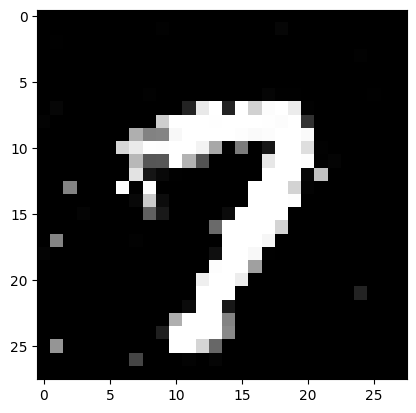

In [124]:
plot_img(imgs, 0)

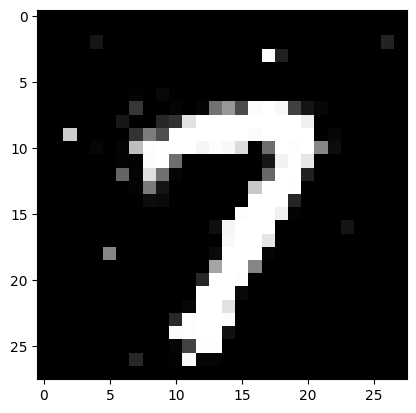

In [125]:
plot_img(imgs, 5)

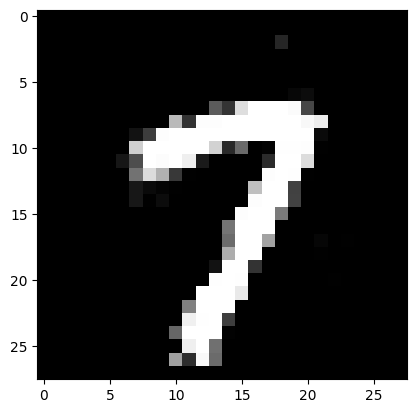

In [126]:
plot_img(imgs, 20)

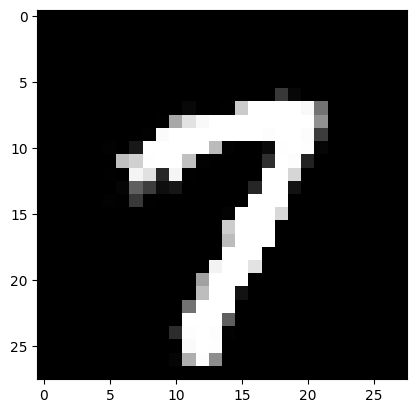

In [127]:
plot_img(imgs, 39)